In [1]:
# imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from itertools import product
from torch.optim.lr_scheduler import StepLR

In [23]:
# define dataset class
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(data['item_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# NeuMF model
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, gmf_factors, mlp_layers, dropout):
        super().__init__()
        self.user_embedding_gmf = nn.Embedding(num_users, gmf_factors)
        self.item_embedding_gmf = nn.Embedding(num_items, gmf_factors)
        
        self.user_embedding_mlp = nn.Embedding(num_users, mlp_layers[0] // 2)
        self.item_embedding_mlp = nn.Embedding(num_items, mlp_layers[0] // 2)

        mlp_layers = [mlp_layers[0]] + mlp_layers
        self.mlp_layers = nn.ModuleList()
        for i in range(1, len(mlp_layers)):
            self.mlp_layers.append(nn.Linear(mlp_layers[i-1], mlp_layers[i]))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(dropout))

        self.final_layer = nn.Linear(gmf_factors + mlp_layers[-1], 1)

        self._init_weights()

    def _init_weights(self): # weight initiation can be very important to model performance!!!
        nn.init.normal_(self.user_embedding_gmf.weight,std=0.01)
        nn.init.normal_(self.item_embedding_gmf.weight,std=0.01)
        nn.init.normal_(self.user_embedding_mlp.weight,std=0.01)
        nn.init.normal_(self.item_embedding_mlp.weight,std=0.01)

        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

        nn.init.xavier_uniform_(self.final_layer.weight)

    def forward(self, user_ids, item_ids):
        user_embedding_gmf = self.user_embedding_gmf(user_ids)
        item_embedding_gmf = self.item_embedding_gmf(item_ids)
        gmf_output = user_embedding_gmf * item_embedding_gmf

        user_embedding_mlp = self.user_embedding_mlp(user_ids)
        item_embedding_mlp = self.item_embedding_mlp(item_ids)
        mlp_input = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=1)

        mlp_output = mlp_input
        for layer in self.mlp_layers:
            mlp_output = layer(mlp_output)

        output = torch.cat([gmf_output, mlp_output], dim=1)
        return self.final_layer(output).view(-1)

# define the loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

def compute_accuracy(true_ratings,predicted_ratings):
    
    predicted_ratings = np.clip(np.round(predicted_ratings),1,5)
    accuracy = np.mean(true_ratings==predicted_ratings)
    return accuracy

from sklearn.preprocessing import KBinsDiscretizer

def plot_confusion_matrix(true_ratings,predicted_ratings,n_bins=5,title=""):
    
    rmse = np.sqrt(np.square(np.subtract(true_ratings,predicted_ratings)).mean()) ; mae = mean_absolute_error(true_ratings,predicted_ratings)
    predicted_ratings = np.clip(np.round(predicted_ratings),1,5)
    cm = confusion_matrix(true_ratings,predicted_ratings,labels=range(1,n_bins+1))
    plt.figure(figsize=(8,7))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=False,square=True,xticklabels=range(1,n_bins+1),yticklabels=range(1,n_bins+1))
    plt.xlabel('predicted ratings (approximated)')
    plt.ylabel('true ratings')
    accuracy = np.mean(true_ratings==predicted_ratings)
    plt.title(title+'confusion matrix\n(RMSE: %.3f MAE: %.3f accuracy: %.3f)'%(rmse,mae,accuracy))
    plt.show()

In [21]:
# use the movielens-1M dataset
ratings_file = 'ml-1m/ratings.dat'
ratings_data = pd.read_csv(ratings_file, sep='::', header=None, engine='python', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Reindex user and item IDs
user_mapping = {user_id: idx for idx, user_id in enumerate(ratings_data['user_id'].unique())}
item_mapping = {item_id: idx for idx, item_id in enumerate(ratings_data['item_id'].unique())}

ratings_data['user_id'] = ratings_data['user_id'].apply(lambda x: user_mapping[x])
ratings_data['item_id'] = ratings_data['item_id'].apply(lambda x: item_mapping[x])

# Split the data into train, validation, and test sets
train_val_data,test_data = train_test_split(ratings_data, test_size=0.5, random_state=42)

num_users = len(ratings_data['user_id'].unique())
num_items = len(ratings_data['item_id'].unique())

In [10]:
# main function
# Load data
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
data = pd.read_csv(url,sep='\t',header=None,names=['user_id','item_id','rating','timestamp'])
user_mapping = {user_id: idx for idx, user_id in enumerate(data['user_id'].unique())}
item_mapping = {item_id: idx for idx, item_id in enumerate(data['item_id'].unique())}
data['user_id'] = data['user_id'].apply(lambda x: user_mapping[x])
data['item_id'] = data['item_id'].apply(lambda x: item_mapping[x])

num_users = len(data['user_id'].unique())
num_items = len(data['item_id'].unique())

# Split data into train and test sets
train_val_data, test_data = train_test_split(data,test_size=0.5,random_state=42)

In [ ]:
# 3-fold cross validation
# no need to run on GPU

# parameter space
gmf_factors_lst = [128,256]; mlp_layers_lst = [[64,32,16],[128,64,32]]; batch_size_lst = [256,512]
criterion = nn.MSELoss() # currently use MSE loss

dropout = 0.5; num_epochs = 100; learning_rate = 0.0001

# calibrated hyperparameter combinations
hyperparameters = list(product(gmf_factors_lst,mlp_layers_lst,batch_size_lst))

n_splits = 3; kf = KFold(n_splits=n_splits)

cv_results = []

best_hyperparams = None
best_val_loss = float('inf') # for hyperparameter selection

for gmf_factors,mlp_layers,batch_size in hyperparameters:

    print(f"Testing hyperparameters: gmf_factors={gmf_factors}, mlp_layers={mlp_layers}, batch_size={batch_size}")

    val_loss_sum = 0

    num_fold = 0

    for train_index,val_index in kf.split(train_val_data):

        num_fold += 1

        train_data = train_val_data.iloc[train_index]; val_data = train_val_data.iloc[val_index]
        train_dataset = MovieLensDataset(train_data); val_dataset = MovieLensDataset(val_data)
        train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
        val_loader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=False)

        # train model
        model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout)
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        # scheduler = StepLR(optimizer,step_size=80,gamma=0.5)

        optim_val_loss = float('inf') # for the best performance of each fold
        for epoch in range(num_epochs):

            start_time = time.time()

            # model train
            model.train()
            train_loss = 0

            for user_ids, item_ids, ratings in train_loader:
            
                optimizer.zero_grad()
                predictions = model(user_ids,item_ids)
                loss = criterion(predictions,ratings)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            # scheduler.step()
        
            # model evaluation
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for user_ids, item_ids, ratings in val_loader:
                    predictions = model(user_ids, item_ids)
                    loss = criterion(predictions, ratings)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            if val_loss < optim_val_loss: # store the best validation result
                optim_val_loss = val_loss
            print(f"fold {num_fold}, epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, optim_val_loss: {optim_val_loss:.3f}, time_spent: {(time.time()-start_time):.2f}s")

        val_loss_sum += optim_val_loss

    ave_val_loss = val_loss_sum/n_splits # should store the best validation metrics
    print(f"Average validation MSE: {ave_val_loss}")

    if ave_val_loss < best_val_loss:
        best_val_loss = ave_val_loss
        best_hyperparams = (gmf_factors,mlp_layers,batch_size)

    cv_results.append({'gmf_factors':gmf_factors,'mlp_layers':mlp_layers,'batch_size':batch_size,'MSE':ave_val_loss}) 

cv_results_df = pd.DataFrame(cv_results)

print(f"Best hyperparameters: gmf_factors={best_hyperparams[0]},mlp_layers={best_hyperparams[1]},batch_size={best_hyperparams[2]}")
print(f"Best validation MSE: {best_val_loss}")

Testing hyperparameters: gmf_factors=128, mlp_layers=[64, 32, 16], batch_size=256
fold 1, epoch 1, train loss: 13.073, val loss: 12.760, optim_val_loss: 12.760, time_spent: 1.60s
fold 1, epoch 2, train loss: 12.229, val loss: 11.499, optim_val_loss: 11.499, time_spent: 1.40s
fold 1, epoch 3, train loss: 10.195, val loss: 8.172, optim_val_loss: 8.172, time_spent: 1.37s
fold 1, epoch 4, train loss: 6.268, val loss: 3.089, optim_val_loss: 3.089, time_spent: 1.38s
fold 1, epoch 5, train loss: 3.922, val loss: 1.715, optim_val_loss: 1.715, time_spent: 1.72s
fold 1, epoch 6, train loss: 3.584, val loss: 1.559, optim_val_loss: 1.559, time_spent: 1.84s
fold 1, epoch 7, train loss: 3.474, val loss: 1.508, optim_val_loss: 1.508, time_spent: 1.42s
fold 1, epoch 8, train loss: 3.372, val loss: 1.470, optim_val_loss: 1.470, time_spent: 1.41s
fold 1, epoch 9, train loss: 3.277, val loss: 1.442, optim_val_loss: 1.442, time_spent: 1.40s
fold 1, epoch 10, train loss: 3.223, val loss: 1.422, optim_val_l

In [ ]:
cv_results_df["mlp_layers_1"] = [i[0] for i in cv_results_df["mlp_layers"]]
cv_results_df["mlp_layers_2"] = [i[1] for i in cv_results_df["mlp_layers"]]
cv_results_df["mlp_layers_3"] = [i[2] for i in cv_results_df["mlp_layers"]]
cv_results_df

gmf_factors     mlp_layers  batch_size       MSE  mlp_layers_1  \
0          128   [64, 32, 16]         256  0.947072            64   
1          128   [64, 32, 16]         512  0.974037            64   
2          128  [128, 64, 32]         256  0.938687           128   
3          128  [128, 64, 32]         512  0.929965           128   
4          256   [64, 32, 16]         256  0.951447            64   
5          256   [64, 32, 16]         512  0.960877            64   
6          256  [128, 64, 32]         256  0.935243           128   
7          256  [128, 64, 32]         512  0.935213           128   

   mlp_layers_2  mlp_layers_3  
0            32            16  
1            32            16  
2            64            32  
3            64            32  
4            32            16  
5            32            16  
6            64            32  
7            64            32

In [ ]:
cv_results_df.to_csv("DMF_cv_results.csv",index=False)

# cross-validation result visualization (parallel coordinate plot)

fig = px.parallel_coordinates(cv_results_df,color='MSE',dimensions=['gmf_factors','mlp_layers_1','mlp_layers_2','mlp_layers_3','batch_size'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=cv_results_df['MSE'].median())
fig.show()

In [22]:
# use the best hyperparameter combination for model training & testing
# should save the model with best validation results

start_time = time.time()

# hyperparameters to be tested include batch_size, gmf factors and mlp layers, 2*2*2=8 combinations in total
# Create the NeuMF model
# gmf_factors = best_hyperparams[0]; mlp_layers = best_hyperparams[1]; batch_size = best_hyperparams[2]
gmf_factors=128; mlp_layers=[128, 64, 32]; batch_size=512
criterion = nn.MSELoss() # currently use MSE loss
dropout = 0.5; num_epochs = 100; learning_rate = 0.0001

# Create dataset and data loader for train and test sets
train_val_dataset = MovieLensDataset(train_val_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# model initiation
model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout)

# Training and evaluation
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# scheduler = StepLR(optimizer,step_size=80,gamma=0.5)

optim_test_loss = float('inf') # for storing the best test results
best_model = None; best_predictions = None

train_val_loss_history, test_loss_history = [],[]

for epoch in range(num_epochs):
  
    model.train()
    train_loss = 0

    for user_ids, item_ids, ratings in train_loader:
        
        optimizer.zero_grad()

        predictions = model(user_ids,item_ids)
        loss = criterion(predictions,ratings)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    # scheduler.step()

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, ratings)
            test_loss += loss.item()

    test_loss /= len(test_loader)

    train_val_loss_history.append(train_loss); test_loss_history.append(test_loss)

    # keep the best testing results
    if test_loss < optim_test_loss:
        optim_test_loss = test_loss
        best_model = model.state_dict().copy(); best_predictions = predictions.clone()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, time_spent: {(time.time()-start_time):.2f}s")

Epoch 1, Train Loss: 5.1067, Test Loss: 0.9838, time_spent: 31.56s
Epoch 2, Train Loss: 1.9379, Test Loss: 0.9156, time_spent: 62.27s
Epoch 3, Train Loss: 1.7740, Test Loss: 0.9070, time_spent: 93.35s
Epoch 4, Train Loss: 1.6839, Test Loss: 0.9066, time_spent: 124.87s
Epoch 5, Train Loss: 1.5581, Test Loss: 0.8773, time_spent: 155.82s
Epoch 6, Train Loss: 1.4587, Test Loss: 0.8621, time_spent: 186.38s
Epoch 7, Train Loss: 1.3649, Test Loss: 0.8412, time_spent: 217.74s
Epoch 8, Train Loss: 1.2802, Test Loss: 0.8250, time_spent: 248.67s
Epoch 9, Train Loss: 1.2012, Test Loss: 0.8157, time_spent: 280.19s
Epoch 10, Train Loss: 1.1289, Test Loss: 0.8083, time_spent: 311.53s
Epoch 11, Train Loss: 1.0560, Test Loss: 0.8096, time_spent: 342.86s
Epoch 12, Train Loss: 0.9914, Test Loss: 0.7970, time_spent: 374.31s
Epoch 13, Train Loss: 0.9348, Test Loss: 0.7927, time_spent: 406.40s
Epoch 14, Train Loss: 0.8803, Test Loss: 0.7860, time_spent: 440.14s
Epoch 15, Train Loss: 0.8315, Test Loss: 0.781

test RMSE:0.874  test MAE:0.690  test R2:0.388
test_accuracy:0.442


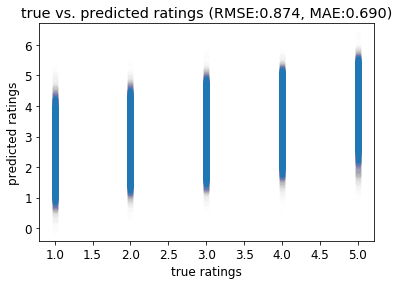

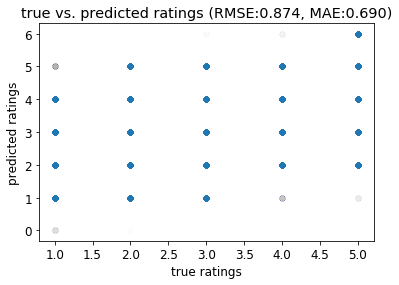

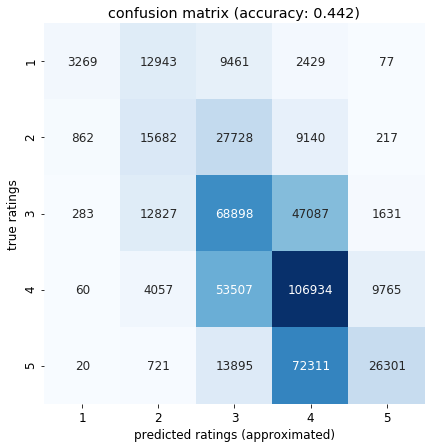

In [23]:
# metric calculation

plt.rcParams["font.size"] = 12

test_preds = best_predictions.detach().cpu().numpy(); test_targets = ratings.detach().cpu().numpy()
test_rmse = np.sqrt(optim_test_loss)
test_mae = mean_absolute_error(test_targets,test_preds)
test_r2 = r2_score(test_targets,test_preds)
print("test RMSE:%.3f  test MAE:%.3f  test R2:%.3f"%(test_rmse,test_mae,test_r2))

test_accuracy = compute_accuracy(test_targets,test_preds)
print("test_accuracy:%.3f"%test_accuracy) # only 42% of accuracy, still very low

# result visualization

# Scatter plot
plt.scatter(test_targets,test_preds,alpha=0.005)
plt.xlabel("true ratings"); plt.ylabel("predicted ratings")
plt.title("true vs. predicted ratings (RMSE:%.3f, MAE:%.3f)"%(test_rmse,test_mae))
plt.show()

# Scatter plot
plt.figure()
plt.scatter(test_targets,np.round(test_preds),alpha=0.005)
plt.xlabel("true ratings"); plt.ylabel("predicted ratings")
plt.title("true vs. predicted ratings (RMSE:%.3f, MAE:%.3f)"%(test_rmse,test_mae))
plt.show()

# plot the confusion matrix
plot_confusion_matrix(test_targets,np.round(test_preds))

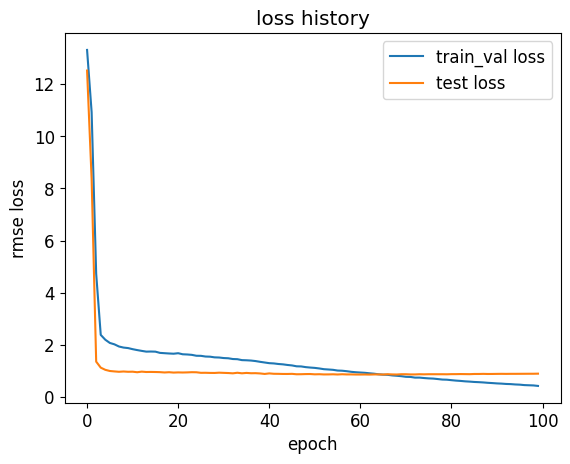

In [ ]:
# loss hitory
plt.plot(train_val_loss_history,label="train_val loss")
plt.plot(test_loss_history,label="test loss")
plt.xlabel("epoch");plt.ylabel("mse loss");plt.title("loss history")
plt.legend();plt.show()

In [16]:
# test NCF performance on the newly-generated datasets (remove half the entries & train on the other half)

plt.rcParams["font.size"] = 12

sup_data_results = []

# load data
data_path = r"C:\Users\eliza\Desktop\final project\noisy_truth_matrix"

# use the previously decided hyperparameters to test on the models
for file in os.listdir(data_path):
    
    print("test pseudo dataset: %s"%file)
    
    ip = pd.read_csv(os.path.join(data_path,file))
    ip.set_index("0",inplace=True) # set the user_id as index
    
    # transform the matrix into the original format
    user_ids = []; item_ids = []; ratings = []
    for user_id in ip.index:
        for item_id in ip.columns:
            rating = ip.loc[user_id,item_id]
            user_ids.append(int(user_id));item_ids.append(int(item_id));ratings.append(rating) # no int for rating
    
    data = pd.DataFrame({'user_id':user_ids,'item_id':item_ids,'rating': ratings})
    
    # read metrics
    user_mapping = {user_id: idx for idx, user_id in enumerate(data['user_id'].unique())}
    item_mapping = {item_id: idx for idx, item_id in enumerate(data['item_id'].unique())}
    data['user_id'] = data['user_id'].apply(lambda x: user_mapping[x])
    data['item_id'] = data['item_id'].apply(lambda x: item_mapping[x])

    num_users = len(data['user_id'].unique())
    num_items = len(data['item_id'].unique())

    # Split data into train and test sets
    train_val_data, test_data = train_test_split(data,test_size=0.5,random_state=42)
    
    ############################ model training & evaluation ################################
    start_time = time.time()

    # hyperparameters to be tested include batch_size, gmf factors and mlp layers, 2*2*2=8 combinations in total
    # Create the NeuMF model
    # gmf_factors = best_hyperparams[0]; mlp_layers = best_hyperparams[1]; batch_size = best_hyperparams[2]
    gmf_factors=128; mlp_layers=[128, 64, 32]; batch_size=512
    criterion = nn.MSELoss() # currently use MSE loss
    dropout = 0.5; num_epochs = 100; learning_rate = 0.0001

    # Create dataset and data loader for train and test sets
    train_val_dataset = MovieLensDataset(train_val_data)
    test_dataset = MovieLensDataset(test_data)

    train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # model initiation
    model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout)

    # Training and evaluation
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    # scheduler = StepLR(optimizer,step_size=80,gamma=0.5)

    train_val_loss_history, test_loss_history = [],[]

    for epoch in range(num_epochs):
  
        model.train()
        train_loss = 0

        for user_ids, item_ids, ratings in train_loader:
        
            optimizer.zero_grad()

            predictions = model(user_ids,item_ids)
            loss = criterion(predictions,ratings)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        # scheduler.step()

        model.eval()
        test_loss = 0

        with torch.no_grad():
            for user_ids, item_ids, ratings in test_loader:
                predictions = model(user_ids,item_ids)
                loss = criterion(predictions,ratings)
                test_loss += loss.item()

        test_loss /= len(test_loader)

        train_val_loss_history.append(train_loss); test_loss_history.append(test_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, time_spent: {(time.time()-start_time):.2f}s")
        
    # result visualization
    # metrics calculation
    test_preds = predictions.detach().cpu().numpy(); test_targets = ratings.detach().cpu().numpy() # here use the final epoch result
    test_rmse = np.sqrt(test_loss); test_mae = mean_absolute_error(test_targets,test_preds); test_accuracy = compute_accuracy(np.round(test_targets),test_preds)
    print("test RMSE:%.3f  test MAE:%.3f  test_accuracy:%.3f"%(test_rmse,test_mae,test_accuracy))
    
    # store in a dataframe
    sup_data_results.append({'data':file,'test RMSE':test_rmse,'test MAE':test_mae,'test accuracy':test_accuracy,'time spent (s)':time.time()-start_time}) 
    
    # Scatter plot
    plt.figure()
    plt.scatter(test_targets,test_preds,alpha=0.005)
    plt.xlabel("true ratings"); plt.ylabel("predicted ratings")
    plt.title("%s true vs. predicted ratings (RMSE:%.3f, MAE:%.3f)"%(file,test_rmse,test_mae))
    plt.show()

    # confusion matrix
    plot_confusion_matrix(np.round(test_targets),np.round(test_preds),title="%s "%file)
    
    # loss hitory
    plt.plot(train_val_loss_history,label="train_val loss")
    plt.plot(test_loss_history,label="test loss")
    plt.xlabel("epoch");plt.ylabel("mse loss");plt.title("loss history")
    plt.legend();plt.show()
    
sup_data_results_df = pd.DataFrame(sup_data_results)

test pseudo dataset: df_c_0.1.csv
Epoch 1, Train Loss: 14.2146, Test Loss: 13.9552, time_spent: 0.94s
Epoch 2, Train Loss: 13.8315, Test Loss: 13.5751, time_spent: 1.80s
Epoch 3, Train Loss: 13.3957, Test Loss: 13.0728, time_spent: 2.76s
Epoch 4, Train Loss: 12.6883, Test Loss: 12.1004, time_spent: 3.63s


KeyboardInterrupt: 

In [55]:
sup_data_results_df

data  test RMSE  test MAE  test accuracy  time spent (s)
0   df_c_0.1.csv   0.685597  0.475310        0.59785       97.281652
1   df_c_0.2.csv   0.687891  0.476454        0.59240       97.208545
2   df_c_0.3.csv   0.692385  0.480964        0.58795       95.512698
3   df_c_0.5.csv   0.710758  0.501869        0.57745       96.386993
4  df_c_0.75.csv   0.749943  0.552327        0.53690       95.945219
5     df_c_1.csv   0.798631  0.610607        0.49195       95.121565
6   df_fill3.csv   0.773425  0.579894        0.56080       93.906466

### final matrix imputation task

In [3]:
plt.rcParams["font.size"] = 12

# load data
data_path = r"C:\Users\eliza\Desktop\final project"

ip = pd.read_csv(os.path.join(data_path,"Feedback.csv"))
ip.set_index("Unnamed: 0",inplace=True) # set the user_id as index

# transform the matrix into the original format
user_ids = []; item_ids = []; ratings = []
for user_id in ip.index:
    for item_id in ip.columns: # restaurant
        rating = ip.loc[user_id,item_id]
        user_ids.append(int(user_id));item_ids.append(item_id);ratings.append(rating) # no int for rating
    
data = pd.DataFrame({'user_id':user_ids,'item_id':item_ids,'rating': ratings})
    
# the index mapping must be first done
user_mapping = {user_id: idx for idx, user_id in enumerate(data['user_id'].unique())}
item_mapping = {item_id: idx for idx, item_id in enumerate(data['item_id'].unique())}
data['user_id'] = data['user_id'].apply(lambda x: user_mapping[x])
data['item_id'] = data['item_id'].apply(lambda x: item_mapping[x])

num_users = len(data['user_id'].unique())
num_items = len(data['item_id'].unique())

print(num_users,num_items)

# separate the training & testing set
# this is a relatively small dataset, so there is danger of overfitting
train_val_data = data.dropna()
test_data = data[np.isnan(data["rating"])]
#train_val_set; test_set

41 15


In [9]:
# cross-validation for selecting hyperparameters
# parameter space
# take ~18 mins to finish run
gmf_factors_lst = [64,128,256]; mlp_layers_lst = [[32,16,8],[64,32,16],[128,64,32]]; batch_size_lst = [100,150];
learning_rate_lst = [0.0001,0.001]
criterion = nn.MSELoss() # currently use MSE loss

dropout = 0.5; num_epochs = 200 # change into 200 epochs

# calibrated hyperparameter combinations
hyperparameters = list(product(gmf_factors_lst,mlp_layers_lst,batch_size_lst,learning_rate_lst))

n_splits = 5; kf = KFold(n_splits=n_splits)

cv_results = []

best_hyperparams = None
best_val_loss = float('inf') # for hyperparameter selection

for gmf_factors,mlp_layers,batch_size,learning_rate in hyperparameters:

    print(f"Testing hyperparameters: gmf_factors={gmf_factors}, mlp_layers={mlp_layers}, batch_size={batch_size}, \
    learning_rate = {learning_rate}")

    val_loss_sum = 0

    num_fold = 0

    for train_index,val_index in kf.split(train_val_data):

        num_fold += 1

        train_data = train_val_data.iloc[train_index]; val_data = train_val_data.iloc[val_index]
        train_dataset = MovieLensDataset(train_data); val_dataset = MovieLensDataset(val_data)
        train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
        val_loader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=False)

        # train model
        model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout)
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        # scheduler = StepLR(optimizer,step_size=80,gamma=0.5)

        optim_val_loss = float('inf') # for the best performance of each fold
        for epoch in range(num_epochs):

            start_time = time.time()

            # model train
            model.train()
            train_loss = 0

            for user_ids, item_ids, ratings in train_loader:
            
                optimizer.zero_grad()
                predictions = model(user_ids,item_ids)
                loss = criterion(predictions,ratings)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            # scheduler.step()
        
            # model evaluation
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for user_ids, item_ids, ratings in val_loader:
                    predictions = model(user_ids, item_ids)
                    loss = criterion(predictions, ratings)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            if val_loss < optim_val_loss: # store the best validation result
                optim_val_loss = val_loss
            print(f"fold {num_fold}, epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, optim_val_loss: {optim_val_loss:.3f}, time_spent: {(time.time()-start_time):.2f}s")

        val_loss_sum += optim_val_loss

    ave_val_loss = val_loss_sum/n_splits # should store the best validation metrics
    print(f"Average validation MSE: {ave_val_loss}")

    if ave_val_loss < best_val_loss:
        best_val_loss = ave_val_loss
        best_hyperparams = (gmf_factors,mlp_layers,batch_size,learning_rate)

    cv_results.append({'gmf_factors':gmf_factors,'mlp_layers':mlp_layers,'batch_size':batch_size,\
                       'learning_rate':learning_rate,'MSE':ave_val_loss}) 

cv_results_df = pd.DataFrame(cv_results)

print(f"Best hyperparameters: gmf_factors={best_hyperparams[0]},mlp_layers={best_hyperparams[1]},\
batch_size={best_hyperparams[2]}, learning_rate={best_hyperparams[3]}")
print(f"Best validation MSE: {best_val_loss}")

cv_results_df["mlp_layers_1"] = [i[0] for i in cv_results_df["mlp_layers"]]
cv_results_df["mlp_layers_2"] = [i[1] for i in cv_results_df["mlp_layers"]]
cv_results_df["mlp_layers_3"] = [i[2] for i in cv_results_df["mlp_layers"]]
cv_results_df

Testing hyperparameters: gmf_factors=64, mlp_layers=[32, 16, 8], batch_size=100,     learning_rate = 0.0001
fold 1, epoch 1, train loss: 12.393, val loss: 11.776, optim_val_loss: 11.776, time_spent: 0.01s
fold 1, epoch 2, train loss: 12.219, val loss: 11.766, optim_val_loss: 11.766, time_spent: 0.02s
fold 1, epoch 3, train loss: 12.405, val loss: 11.756, optim_val_loss: 11.756, time_spent: 0.02s
fold 1, epoch 4, train loss: 12.057, val loss: 11.747, optim_val_loss: 11.747, time_spent: 0.01s
fold 1, epoch 5, train loss: 12.399, val loss: 11.737, optim_val_loss: 11.737, time_spent: 0.01s
fold 1, epoch 6, train loss: 11.967, val loss: 11.728, optim_val_loss: 11.728, time_spent: 0.02s
fold 1, epoch 7, train loss: 12.683, val loss: 11.718, optim_val_loss: 11.718, time_spent: 0.01s
fold 1, epoch 8, train loss: 12.388, val loss: 11.709, optim_val_loss: 11.709, time_spent: 0.01s
fold 1, epoch 9, train loss: 12.335, val loss: 11.700, optim_val_loss: 11.700, time_spent: 0.01s
fold 1, epoch 10, t

fold 1, epoch 88, train loss: 11.607, val loss: 11.158, optim_val_loss: 11.158, time_spent: 0.01s
fold 1, epoch 89, train loss: 11.512, val loss: 11.151, optim_val_loss: 11.151, time_spent: 0.02s
fold 1, epoch 90, train loss: 11.584, val loss: 11.143, optim_val_loss: 11.143, time_spent: 0.02s
fold 1, epoch 91, train loss: 11.697, val loss: 11.136, optim_val_loss: 11.136, time_spent: 0.01s
fold 1, epoch 92, train loss: 11.926, val loss: 11.129, optim_val_loss: 11.129, time_spent: 0.02s
fold 1, epoch 93, train loss: 11.657, val loss: 11.121, optim_val_loss: 11.121, time_spent: 0.01s
fold 1, epoch 94, train loss: 11.673, val loss: 11.114, optim_val_loss: 11.114, time_spent: 0.01s
fold 1, epoch 95, train loss: 11.418, val loss: 11.107, optim_val_loss: 11.107, time_spent: 0.01s
fold 1, epoch 96, train loss: 11.697, val loss: 11.100, optim_val_loss: 11.100, time_spent: 0.00s
fold 1, epoch 97, train loss: 11.603, val loss: 11.093, optim_val_loss: 11.093, time_spent: 0.01s
fold 1, epoch 98, tr

fold 1, epoch 183, train loss: 10.804, val loss: 10.325, optim_val_loss: 10.325, time_spent: 0.01s
fold 1, epoch 184, train loss: 10.316, val loss: 10.314, optim_val_loss: 10.314, time_spent: 0.01s
fold 1, epoch 185, train loss: 10.403, val loss: 10.302, optim_val_loss: 10.302, time_spent: 0.01s
fold 1, epoch 186, train loss: 10.250, val loss: 10.290, optim_val_loss: 10.290, time_spent: 0.01s
fold 1, epoch 187, train loss: 10.353, val loss: 10.278, optim_val_loss: 10.278, time_spent: 0.01s
fold 1, epoch 188, train loss: 10.507, val loss: 10.266, optim_val_loss: 10.266, time_spent: 0.01s
fold 1, epoch 189, train loss: 10.221, val loss: 10.254, optim_val_loss: 10.254, time_spent: 0.00s
fold 1, epoch 190, train loss: 10.284, val loss: 10.241, optim_val_loss: 10.241, time_spent: 0.01s
fold 1, epoch 191, train loss: 10.372, val loss: 10.229, optim_val_loss: 10.229, time_spent: 0.02s
fold 1, epoch 192, train loss: 9.792, val loss: 10.217, optim_val_loss: 10.217, time_spent: 0.02s
fold 1, epo

fold 2, epoch 81, train loss: 10.344, val loss: 9.989, optim_val_loss: 9.989, time_spent: 0.01s
fold 2, epoch 82, train loss: 10.661, val loss: 9.968, optim_val_loss: 9.968, time_spent: 0.02s
fold 2, epoch 83, train loss: 10.441, val loss: 9.945, optim_val_loss: 9.945, time_spent: 0.02s
fold 2, epoch 84, train loss: 10.975, val loss: 9.921, optim_val_loss: 9.921, time_spent: 0.01s
fold 2, epoch 85, train loss: 10.432, val loss: 9.896, optim_val_loss: 9.896, time_spent: 0.02s
fold 2, epoch 86, train loss: 10.587, val loss: 9.868, optim_val_loss: 9.868, time_spent: 0.01s
fold 2, epoch 87, train loss: 10.732, val loss: 9.838, optim_val_loss: 9.838, time_spent: 0.02s
fold 2, epoch 88, train loss: 10.416, val loss: 9.808, optim_val_loss: 9.808, time_spent: 0.01s
fold 2, epoch 89, train loss: 10.867, val loss: 9.776, optim_val_loss: 9.776, time_spent: 0.01s
fold 2, epoch 90, train loss: 10.455, val loss: 9.744, optim_val_loss: 9.744, time_spent: 0.01s
fold 2, epoch 91, train loss: 10.283, va

fold 2, epoch 172, train loss: 6.069, val loss: 5.643, optim_val_loss: 5.643, time_spent: 0.01s
fold 2, epoch 173, train loss: 5.791, val loss: 5.582, optim_val_loss: 5.582, time_spent: 0.02s
fold 2, epoch 174, train loss: 6.142, val loss: 5.521, optim_val_loss: 5.521, time_spent: 0.01s
fold 2, epoch 175, train loss: 6.268, val loss: 5.460, optim_val_loss: 5.460, time_spent: 0.02s
fold 2, epoch 176, train loss: 5.750, val loss: 5.399, optim_val_loss: 5.399, time_spent: 0.01s
fold 2, epoch 177, train loss: 5.776, val loss: 5.337, optim_val_loss: 5.337, time_spent: 0.01s
fold 2, epoch 178, train loss: 6.334, val loss: 5.277, optim_val_loss: 5.277, time_spent: 0.01s
fold 2, epoch 179, train loss: 5.811, val loss: 5.217, optim_val_loss: 5.217, time_spent: 0.01s
fold 2, epoch 180, train loss: 5.266, val loss: 5.156, optim_val_loss: 5.156, time_spent: 0.01s
fold 2, epoch 181, train loss: 5.445, val loss: 5.097, optim_val_loss: 5.097, time_spent: 0.02s
fold 2, epoch 182, train loss: 5.882, va

fold 3, epoch 76, train loss: 11.669, val loss: 14.330, optim_val_loss: 14.330, time_spent: 0.01s
fold 3, epoch 77, train loss: 11.718, val loss: 14.323, optim_val_loss: 14.323, time_spent: 0.01s
fold 3, epoch 78, train loss: 11.333, val loss: 14.316, optim_val_loss: 14.316, time_spent: 0.02s
fold 3, epoch 79, train loss: 12.092, val loss: 14.309, optim_val_loss: 14.309, time_spent: 0.01s
fold 3, epoch 80, train loss: 11.986, val loss: 14.302, optim_val_loss: 14.302, time_spent: 0.01s
fold 3, epoch 81, train loss: 11.915, val loss: 14.295, optim_val_loss: 14.295, time_spent: 0.01s
fold 3, epoch 82, train loss: 11.799, val loss: 14.288, optim_val_loss: 14.288, time_spent: 0.01s
fold 3, epoch 83, train loss: 11.885, val loss: 14.281, optim_val_loss: 14.281, time_spent: 0.01s
fold 3, epoch 84, train loss: 11.554, val loss: 14.274, optim_val_loss: 14.274, time_spent: 0.01s
fold 3, epoch 85, train loss: 11.100, val loss: 14.267, optim_val_loss: 14.267, time_spent: 0.01s
fold 3, epoch 86, tr

fold 3, epoch 165, train loss: 10.660, val loss: 13.393, optim_val_loss: 13.393, time_spent: 0.00s
fold 3, epoch 166, train loss: 10.692, val loss: 13.374, optim_val_loss: 13.374, time_spent: 0.01s
fold 3, epoch 167, train loss: 10.461, val loss: 13.355, optim_val_loss: 13.355, time_spent: 0.01s
fold 3, epoch 168, train loss: 10.354, val loss: 13.336, optim_val_loss: 13.336, time_spent: 0.02s
fold 3, epoch 169, train loss: 10.338, val loss: 13.316, optim_val_loss: 13.316, time_spent: 0.01s
fold 3, epoch 170, train loss: 10.679, val loss: 13.296, optim_val_loss: 13.296, time_spent: 0.02s
fold 3, epoch 171, train loss: 10.299, val loss: 13.276, optim_val_loss: 13.276, time_spent: 0.02s
fold 3, epoch 172, train loss: 10.246, val loss: 13.255, optim_val_loss: 13.255, time_spent: 0.01s
fold 3, epoch 173, train loss: 10.281, val loss: 13.234, optim_val_loss: 13.234, time_spent: 0.02s
fold 3, epoch 174, train loss: 10.185, val loss: 13.213, optim_val_loss: 13.213, time_spent: 0.01s
fold 3, ep

fold 4, epoch 58, train loss: 12.438, val loss: 10.113, optim_val_loss: 10.113, time_spent: 0.02s
fold 4, epoch 59, train loss: 12.826, val loss: 10.107, optim_val_loss: 10.107, time_spent: 0.01s
fold 4, epoch 60, train loss: 12.391, val loss: 10.101, optim_val_loss: 10.101, time_spent: 0.01s
fold 4, epoch 61, train loss: 12.533, val loss: 10.095, optim_val_loss: 10.095, time_spent: 0.01s
fold 4, epoch 62, train loss: 13.012, val loss: 10.090, optim_val_loss: 10.090, time_spent: 0.01s
fold 4, epoch 63, train loss: 12.744, val loss: 10.084, optim_val_loss: 10.084, time_spent: 0.00s
fold 4, epoch 64, train loss: 12.514, val loss: 10.078, optim_val_loss: 10.078, time_spent: 0.01s
fold 4, epoch 65, train loss: 12.577, val loss: 10.072, optim_val_loss: 10.072, time_spent: 0.01s
fold 4, epoch 66, train loss: 12.535, val loss: 10.065, optim_val_loss: 10.065, time_spent: 0.01s
fold 4, epoch 67, train loss: 12.623, val loss: 10.059, optim_val_loss: 10.059, time_spent: 0.01s
fold 4, epoch 68, tr

fold 4, epoch 154, train loss: 11.784, val loss: 9.543, optim_val_loss: 9.543, time_spent: 0.01s
fold 4, epoch 155, train loss: 11.571, val loss: 9.537, optim_val_loss: 9.537, time_spent: 0.01s
fold 4, epoch 156, train loss: 11.559, val loss: 9.531, optim_val_loss: 9.531, time_spent: 0.02s
fold 4, epoch 157, train loss: 11.587, val loss: 9.526, optim_val_loss: 9.526, time_spent: 0.01s
fold 4, epoch 158, train loss: 11.810, val loss: 9.520, optim_val_loss: 9.520, time_spent: 0.02s
fold 4, epoch 159, train loss: 11.538, val loss: 9.514, optim_val_loss: 9.514, time_spent: 0.01s
fold 4, epoch 160, train loss: 11.751, val loss: 9.509, optim_val_loss: 9.509, time_spent: 0.01s
fold 4, epoch 161, train loss: 11.575, val loss: 9.503, optim_val_loss: 9.503, time_spent: 0.01s
fold 4, epoch 162, train loss: 11.710, val loss: 9.497, optim_val_loss: 9.497, time_spent: 0.01s
fold 4, epoch 163, train loss: 11.622, val loss: 9.491, optim_val_loss: 9.491, time_spent: 0.01s
fold 4, epoch 164, train loss:

fold 5, epoch 44, train loss: 9.674, val loss: 11.019, optim_val_loss: 11.019, time_spent: 0.02s
fold 5, epoch 45, train loss: 9.333, val loss: 11.007, optim_val_loss: 11.007, time_spent: 0.01s
fold 5, epoch 46, train loss: 9.172, val loss: 10.994, optim_val_loss: 10.994, time_spent: 0.01s
fold 5, epoch 47, train loss: 9.446, val loss: 10.981, optim_val_loss: 10.981, time_spent: 0.01s
fold 5, epoch 48, train loss: 9.464, val loss: 10.968, optim_val_loss: 10.968, time_spent: 0.01s
fold 5, epoch 49, train loss: 9.416, val loss: 10.955, optim_val_loss: 10.955, time_spent: 0.01s
fold 5, epoch 50, train loss: 9.819, val loss: 10.942, optim_val_loss: 10.942, time_spent: 0.01s
fold 5, epoch 51, train loss: 9.566, val loss: 10.929, optim_val_loss: 10.929, time_spent: 0.00s
fold 5, epoch 52, train loss: 9.271, val loss: 10.916, optim_val_loss: 10.916, time_spent: 0.01s
fold 5, epoch 53, train loss: 9.714, val loss: 10.903, optim_val_loss: 10.903, time_spent: 0.02s
fold 5, epoch 54, train loss: 

fold 5, epoch 140, train loss: 7.680, val loss: 9.251, optim_val_loss: 9.251, time_spent: 0.02s
fold 5, epoch 141, train loss: 7.903, val loss: 9.224, optim_val_loss: 9.224, time_spent: 0.02s
fold 5, epoch 142, train loss: 8.116, val loss: 9.197, optim_val_loss: 9.197, time_spent: 0.02s
fold 5, epoch 143, train loss: 7.714, val loss: 9.170, optim_val_loss: 9.170, time_spent: 0.01s
fold 5, epoch 144, train loss: 7.817, val loss: 9.144, optim_val_loss: 9.144, time_spent: 0.01s
fold 5, epoch 145, train loss: 7.309, val loss: 9.117, optim_val_loss: 9.117, time_spent: 0.02s
fold 5, epoch 146, train loss: 7.745, val loss: 9.089, optim_val_loss: 9.089, time_spent: 0.02s
fold 5, epoch 147, train loss: 7.498, val loss: 9.062, optim_val_loss: 9.062, time_spent: 0.01s
fold 5, epoch 148, train loss: 7.358, val loss: 9.034, optim_val_loss: 9.034, time_spent: 0.02s
fold 5, epoch 149, train loss: 7.497, val loss: 9.006, optim_val_loss: 9.006, time_spent: 0.02s
fold 5, epoch 150, train loss: 7.376, va

fold 1, epoch 36, train loss: 3.679, val loss: 3.130, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 37, train loss: 3.578, val loss: 3.130, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 38, train loss: 3.898, val loss: 3.124, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 39, train loss: 3.912, val loss: 3.148, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 40, train loss: 4.758, val loss: 3.194, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 41, train loss: 3.715, val loss: 3.258, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 42, train loss: 4.134, val loss: 3.332, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 43, train loss: 3.776, val loss: 3.421, optim_val_loss: 2.973, time_spent: 0.00s
fold 1, epoch 44, train loss: 3.889, val loss: 3.477, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 45, train loss: 3.744, val loss: 3.508, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 46, train loss: 3.401, val loss: 3.5

fold 1, epoch 135, train loss: 0.588, val loss: 7.217, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 136, train loss: 0.590, val loss: 7.245, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 137, train loss: 0.568, val loss: 7.267, optim_val_loss: 2.973, time_spent: 0.02s
fold 1, epoch 138, train loss: 0.553, val loss: 7.288, optim_val_loss: 2.973, time_spent: 0.02s
fold 1, epoch 139, train loss: 0.620, val loss: 7.311, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 140, train loss: 0.592, val loss: 7.335, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 141, train loss: 0.543, val loss: 7.361, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.517, val loss: 7.389, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 143, train loss: 0.596, val loss: 7.420, optim_val_loss: 2.973, time_spent: 0.01s
fold 1, epoch 144, train loss: 0.521, val loss: 7.454, optim_val_loss: 2.973, time_spent: 0.00s
fold 1, epoch 145, train loss: 0.501, va

fold 2, epoch 21, train loss: 10.543, val loss: 9.359, optim_val_loss: 9.359, time_spent: 0.02s
fold 2, epoch 22, train loss: 9.977, val loss: 9.233, optim_val_loss: 9.233, time_spent: 0.02s
fold 2, epoch 23, train loss: 10.014, val loss: 9.099, optim_val_loss: 9.099, time_spent: 0.01s
fold 2, epoch 24, train loss: 9.860, val loss: 8.956, optim_val_loss: 8.956, time_spent: 0.02s
fold 2, epoch 25, train loss: 9.543, val loss: 8.803, optim_val_loss: 8.803, time_spent: 0.02s
fold 2, epoch 26, train loss: 9.409, val loss: 8.637, optim_val_loss: 8.637, time_spent: 0.02s
fold 2, epoch 27, train loss: 9.175, val loss: 8.458, optim_val_loss: 8.458, time_spent: 0.01s
fold 2, epoch 28, train loss: 9.065, val loss: 8.264, optim_val_loss: 8.264, time_spent: 0.01s
fold 2, epoch 29, train loss: 8.584, val loss: 8.053, optim_val_loss: 8.053, time_spent: 0.01s
fold 2, epoch 30, train loss: 8.216, val loss: 7.823, optim_val_loss: 7.823, time_spent: 0.01s
fold 2, epoch 31, train loss: 7.676, val loss: 7

fold 2, epoch 122, train loss: 0.702, val loss: 6.217, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 123, train loss: 0.720, val loss: 6.247, optim_val_loss: 3.017, time_spent: 0.02s
fold 2, epoch 124, train loss: 0.746, val loss: 6.277, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 125, train loss: 0.791, val loss: 6.307, optim_val_loss: 3.017, time_spent: 0.02s
fold 2, epoch 126, train loss: 0.740, val loss: 6.339, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 127, train loss: 0.791, val loss: 6.375, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 128, train loss: 0.693, val loss: 6.408, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 129, train loss: 0.660, val loss: 6.434, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 130, train loss: 0.700, val loss: 6.462, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 131, train loss: 0.756, val loss: 6.491, optim_val_loss: 3.017, time_spent: 0.01s
fold 2, epoch 132, train loss: 0.641, va

fold 3, epoch 16, train loss: 9.992, val loss: 12.544, optim_val_loss: 12.544, time_spent: 0.02s
fold 3, epoch 17, train loss: 9.713, val loss: 12.358, optim_val_loss: 12.358, time_spent: 0.01s
fold 3, epoch 18, train loss: 10.192, val loss: 12.146, optim_val_loss: 12.146, time_spent: 0.02s
fold 3, epoch 19, train loss: 9.695, val loss: 11.918, optim_val_loss: 11.918, time_spent: 0.01s
fold 3, epoch 20, train loss: 8.961, val loss: 11.677, optim_val_loss: 11.677, time_spent: 0.01s
fold 3, epoch 21, train loss: 8.999, val loss: 11.420, optim_val_loss: 11.420, time_spent: 0.01s
fold 3, epoch 22, train loss: 8.645, val loss: 11.145, optim_val_loss: 11.145, time_spent: 0.01s
fold 3, epoch 23, train loss: 8.360, val loss: 10.852, optim_val_loss: 10.852, time_spent: 0.01s
fold 3, epoch 24, train loss: 7.757, val loss: 10.535, optim_val_loss: 10.535, time_spent: 0.01s
fold 3, epoch 25, train loss: 7.726, val loss: 10.196, optim_val_loss: 10.196, time_spent: 0.01s
fold 3, epoch 26, train loss:

fold 3, epoch 114, train loss: 0.719, val loss: 8.609, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 115, train loss: 0.737, val loss: 8.637, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 116, train loss: 0.772, val loss: 8.663, optim_val_loss: 5.249, time_spent: 0.01s
fold 3, epoch 117, train loss: 0.708, val loss: 8.692, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 118, train loss: 0.626, val loss: 8.719, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 119, train loss: 0.781, val loss: 8.745, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 120, train loss: 0.665, val loss: 8.765, optim_val_loss: 5.249, time_spent: 0.02s
fold 3, epoch 121, train loss: 0.755, val loss: 8.791, optim_val_loss: 5.249, time_spent: 0.01s
fold 3, epoch 122, train loss: 0.747, val loss: 8.819, optim_val_loss: 5.249, time_spent: 0.01s
fold 3, epoch 123, train loss: 0.681, val loss: 8.844, optim_val_loss: 5.249, time_spent: 0.01s
fold 3, epoch 124, train loss: 0.770, va

fold 4, epoch 8, train loss: 10.349, val loss: 8.162, optim_val_loss: 8.162, time_spent: 0.01s
fold 4, epoch 9, train loss: 10.658, val loss: 8.014, optim_val_loss: 8.014, time_spent: 0.01s
fold 4, epoch 10, train loss: 10.104, val loss: 7.857, optim_val_loss: 7.857, time_spent: 0.01s
fold 4, epoch 11, train loss: 9.416, val loss: 7.689, optim_val_loss: 7.689, time_spent: 0.01s
fold 4, epoch 12, train loss: 9.756, val loss: 7.512, optim_val_loss: 7.512, time_spent: 0.01s
fold 4, epoch 13, train loss: 9.252, val loss: 7.324, optim_val_loss: 7.324, time_spent: 0.01s
fold 4, epoch 14, train loss: 9.414, val loss: 7.123, optim_val_loss: 7.123, time_spent: 0.01s
fold 4, epoch 15, train loss: 9.165, val loss: 6.908, optim_val_loss: 6.908, time_spent: 0.02s
fold 4, epoch 16, train loss: 8.600, val loss: 6.675, optim_val_loss: 6.675, time_spent: 0.02s
fold 4, epoch 17, train loss: 8.104, val loss: 6.427, optim_val_loss: 6.427, time_spent: 0.01s
fold 4, epoch 18, train loss: 8.406, val loss: 6.

fold 4, epoch 99, train loss: 1.103, val loss: 4.575, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 100, train loss: 0.908, val loss: 4.609, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 101, train loss: 0.945, val loss: 4.641, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 102, train loss: 0.998, val loss: 4.672, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 103, train loss: 1.009, val loss: 4.712, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 104, train loss: 0.926, val loss: 4.770, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 105, train loss: 0.795, val loss: 4.822, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 106, train loss: 0.843, val loss: 4.870, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 107, train loss: 0.915, val loss: 4.922, optim_val_loss: 2.717, time_spent: 0.02s
fold 4, epoch 108, train loss: 0.819, val loss: 4.969, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 109, train loss: 0.924, val

fold 4, epoch 194, train loss: 0.264, val loss: 6.850, optim_val_loss: 2.717, time_spent: 0.02s
fold 4, epoch 195, train loss: 0.261, val loss: 6.858, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 196, train loss: 0.258, val loss: 6.868, optim_val_loss: 2.717, time_spent: 0.02s
fold 4, epoch 197, train loss: 0.266, val loss: 6.875, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 198, train loss: 0.234, val loss: 6.880, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 199, train loss: 0.254, val loss: 6.886, optim_val_loss: 2.717, time_spent: 0.01s
fold 4, epoch 200, train loss: 0.269, val loss: 6.893, optim_val_loss: 2.717, time_spent: 0.01s
fold 5, epoch 1, train loss: 11.599, val loss: 13.658, optim_val_loss: 13.658, time_spent: 0.01s
fold 5, epoch 2, train loss: 11.902, val loss: 13.610, optim_val_loss: 13.610, time_spent: 0.01s
fold 5, epoch 3, train loss: 11.899, val loss: 13.559, optim_val_loss: 13.559, time_spent: 0.01s
fold 5, epoch 4, train loss: 11.587, 

fold 5, epoch 89, train loss: 1.123, val loss: 7.915, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 90, train loss: 1.234, val loss: 7.966, optim_val_loss: 4.495, time_spent: 0.02s
fold 5, epoch 91, train loss: 1.140, val loss: 8.018, optim_val_loss: 4.495, time_spent: 0.02s
fold 5, epoch 92, train loss: 1.352, val loss: 8.072, optim_val_loss: 4.495, time_spent: 0.02s
fold 5, epoch 93, train loss: 1.146, val loss: 8.147, optim_val_loss: 4.495, time_spent: 0.02s
fold 5, epoch 94, train loss: 1.198, val loss: 8.238, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 95, train loss: 1.150, val loss: 8.333, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 96, train loss: 1.083, val loss: 8.427, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 97, train loss: 0.924, val loss: 8.521, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 98, train loss: 1.074, val loss: 8.610, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 99, train loss: 1.060, val loss: 8.6

fold 5, epoch 187, train loss: 0.434, val loss: 11.409, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 188, train loss: 0.405, val loss: 11.422, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 189, train loss: 0.417, val loss: 11.436, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 190, train loss: 0.425, val loss: 11.448, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 191, train loss: 0.399, val loss: 11.459, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 192, train loss: 0.391, val loss: 11.471, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 193, train loss: 0.416, val loss: 11.481, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 194, train loss: 0.388, val loss: 11.490, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 195, train loss: 0.376, val loss: 11.499, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 196, train loss: 0.369, val loss: 11.508, optim_val_loss: 4.495, time_spent: 0.01s
fold 5, epoch 197, train loss:

fold 1, epoch 84, train loss: 11.578, val loss: 11.231, optim_val_loss: 11.231, time_spent: 0.01s
fold 1, epoch 85, train loss: 11.794, val loss: 11.222, optim_val_loss: 11.222, time_spent: 0.02s
fold 1, epoch 86, train loss: 11.964, val loss: 11.214, optim_val_loss: 11.214, time_spent: 0.01s
fold 1, epoch 87, train loss: 11.873, val loss: 11.206, optim_val_loss: 11.206, time_spent: 0.00s
fold 1, epoch 88, train loss: 11.768, val loss: 11.198, optim_val_loss: 11.198, time_spent: 0.01s
fold 1, epoch 89, train loss: 11.704, val loss: 11.190, optim_val_loss: 11.190, time_spent: 0.02s
fold 1, epoch 90, train loss: 11.545, val loss: 11.181, optim_val_loss: 11.181, time_spent: 0.01s
fold 1, epoch 91, train loss: 11.665, val loss: 11.173, optim_val_loss: 11.173, time_spent: 0.01s
fold 1, epoch 92, train loss: 11.886, val loss: 11.165, optim_val_loss: 11.165, time_spent: 0.01s
fold 1, epoch 93, train loss: 11.688, val loss: 11.156, optim_val_loss: 11.156, time_spent: 0.01s
fold 1, epoch 94, tr

fold 1, epoch 179, train loss: 10.520, val loss: 10.185, optim_val_loss: 10.185, time_spent: 0.02s
fold 1, epoch 180, train loss: 10.540, val loss: 10.169, optim_val_loss: 10.169, time_spent: 0.01s
fold 1, epoch 181, train loss: 10.621, val loss: 10.154, optim_val_loss: 10.154, time_spent: 0.01s
fold 1, epoch 182, train loss: 10.541, val loss: 10.138, optim_val_loss: 10.138, time_spent: 0.01s
fold 1, epoch 183, train loss: 10.485, val loss: 10.122, optim_val_loss: 10.122, time_spent: 0.01s
fold 1, epoch 184, train loss: 10.415, val loss: 10.106, optim_val_loss: 10.106, time_spent: 0.00s
fold 1, epoch 185, train loss: 10.478, val loss: 10.090, optim_val_loss: 10.090, time_spent: 0.02s
fold 1, epoch 186, train loss: 10.389, val loss: 10.074, optim_val_loss: 10.074, time_spent: 0.01s
fold 1, epoch 187, train loss: 10.592, val loss: 10.058, optim_val_loss: 10.058, time_spent: 0.02s
fold 1, epoch 188, train loss: 10.669, val loss: 10.042, optim_val_loss: 10.042, time_spent: 0.00s
fold 1, ep

fold 2, epoch 77, train loss: 10.226, val loss: 9.292, optim_val_loss: 9.292, time_spent: 0.00s
fold 2, epoch 78, train loss: 10.469, val loss: 9.282, optim_val_loss: 9.282, time_spent: 0.01s
fold 2, epoch 79, train loss: 10.137, val loss: 9.271, optim_val_loss: 9.271, time_spent: 0.01s
fold 2, epoch 80, train loss: 10.119, val loss: 9.260, optim_val_loss: 9.260, time_spent: 0.01s
fold 2, epoch 81, train loss: 10.401, val loss: 9.249, optim_val_loss: 9.249, time_spent: 0.01s
fold 2, epoch 82, train loss: 10.145, val loss: 9.239, optim_val_loss: 9.239, time_spent: 0.01s
fold 2, epoch 83, train loss: 10.177, val loss: 9.228, optim_val_loss: 9.228, time_spent: 0.00s
fold 2, epoch 84, train loss: 10.130, val loss: 9.217, optim_val_loss: 9.217, time_spent: 0.00s
fold 2, epoch 85, train loss: 9.961, val loss: 9.206, optim_val_loss: 9.206, time_spent: 0.01s
fold 2, epoch 86, train loss: 10.388, val loss: 9.196, optim_val_loss: 9.196, time_spent: 0.01s
fold 2, epoch 87, train loss: 10.347, val

fold 2, epoch 179, train loss: 8.351, val loss: 7.835, optim_val_loss: 7.835, time_spent: 0.01s
fold 2, epoch 180, train loss: 8.274, val loss: 7.817, optim_val_loss: 7.817, time_spent: 0.02s
fold 2, epoch 181, train loss: 8.263, val loss: 7.798, optim_val_loss: 7.798, time_spent: 0.01s
fold 2, epoch 182, train loss: 8.460, val loss: 7.780, optim_val_loss: 7.780, time_spent: 0.02s
fold 2, epoch 183, train loss: 8.012, val loss: 7.761, optim_val_loss: 7.761, time_spent: 0.01s
fold 2, epoch 184, train loss: 8.441, val loss: 7.743, optim_val_loss: 7.743, time_spent: 0.01s
fold 2, epoch 185, train loss: 8.155, val loss: 7.724, optim_val_loss: 7.724, time_spent: 0.01s
fold 2, epoch 186, train loss: 8.087, val loss: 7.705, optim_val_loss: 7.705, time_spent: 0.01s
fold 2, epoch 187, train loss: 8.283, val loss: 7.686, optim_val_loss: 7.686, time_spent: 0.01s
fold 2, epoch 188, train loss: 8.113, val loss: 7.668, optim_val_loss: 7.668, time_spent: 0.01s
fold 2, epoch 189, train loss: 8.212, va

fold 3, epoch 72, train loss: 10.566, val loss: 13.332, optim_val_loss: 13.332, time_spent: 0.02s
fold 3, epoch 73, train loss: 10.304, val loss: 13.317, optim_val_loss: 13.317, time_spent: 0.01s
fold 3, epoch 74, train loss: 10.544, val loss: 13.301, optim_val_loss: 13.301, time_spent: 0.01s
fold 3, epoch 75, train loss: 10.459, val loss: 13.286, optim_val_loss: 13.286, time_spent: 0.01s
fold 3, epoch 76, train loss: 10.451, val loss: 13.270, optim_val_loss: 13.270, time_spent: 0.01s
fold 3, epoch 77, train loss: 10.458, val loss: 13.255, optim_val_loss: 13.255, time_spent: 0.01s
fold 3, epoch 78, train loss: 10.542, val loss: 13.239, optim_val_loss: 13.239, time_spent: 0.00s
fold 3, epoch 79, train loss: 10.672, val loss: 13.223, optim_val_loss: 13.223, time_spent: 0.01s
fold 3, epoch 80, train loss: 10.636, val loss: 13.208, optim_val_loss: 13.208, time_spent: 0.01s
fold 3, epoch 81, train loss: 10.350, val loss: 13.191, optim_val_loss: 13.191, time_spent: 0.00s
fold 3, epoch 82, tr

fold 3, epoch 169, train loss: 8.291, val loss: 11.332, optim_val_loss: 11.332, time_spent: 0.01s
fold 3, epoch 170, train loss: 8.330, val loss: 11.304, optim_val_loss: 11.304, time_spent: 0.01s
fold 3, epoch 171, train loss: 8.410, val loss: 11.277, optim_val_loss: 11.277, time_spent: 0.01s
fold 3, epoch 172, train loss: 8.541, val loss: 11.249, optim_val_loss: 11.249, time_spent: 0.01s
fold 3, epoch 173, train loss: 8.832, val loss: 11.222, optim_val_loss: 11.222, time_spent: 0.01s
fold 3, epoch 174, train loss: 8.514, val loss: 11.195, optim_val_loss: 11.195, time_spent: 0.01s
fold 3, epoch 175, train loss: 8.572, val loss: 11.167, optim_val_loss: 11.167, time_spent: 0.01s
fold 3, epoch 176, train loss: 8.618, val loss: 11.140, optim_val_loss: 11.140, time_spent: 0.01s
fold 3, epoch 177, train loss: 8.522, val loss: 11.113, optim_val_loss: 11.113, time_spent: 0.01s
fold 3, epoch 178, train loss: 8.302, val loss: 11.085, optim_val_loss: 11.085, time_spent: 0.01s
fold 3, epoch 179, t

fold 4, epoch 66, train loss: 12.003, val loss: 9.410, optim_val_loss: 9.410, time_spent: 0.01s
fold 4, epoch 67, train loss: 11.846, val loss: 9.404, optim_val_loss: 9.404, time_spent: 0.01s
fold 4, epoch 68, train loss: 11.805, val loss: 9.399, optim_val_loss: 9.399, time_spent: 0.01s
fold 4, epoch 69, train loss: 11.725, val loss: 9.393, optim_val_loss: 9.393, time_spent: 0.01s
fold 4, epoch 70, train loss: 11.837, val loss: 9.387, optim_val_loss: 9.387, time_spent: 0.01s
fold 4, epoch 71, train loss: 12.004, val loss: 9.382, optim_val_loss: 9.382, time_spent: 0.01s
fold 4, epoch 72, train loss: 11.881, val loss: 9.376, optim_val_loss: 9.376, time_spent: 0.00s
fold 4, epoch 73, train loss: 11.676, val loss: 9.370, optim_val_loss: 9.370, time_spent: 0.01s
fold 4, epoch 74, train loss: 11.996, val loss: 9.364, optim_val_loss: 9.364, time_spent: 0.01s
fold 4, epoch 75, train loss: 11.428, val loss: 9.358, optim_val_loss: 9.358, time_spent: 0.01s
fold 4, epoch 76, train loss: 11.751, va

fold 4, epoch 154, train loss: 10.517, val loss: 8.436, optim_val_loss: 8.436, time_spent: 0.01s
fold 4, epoch 155, train loss: 10.439, val loss: 8.418, optim_val_loss: 8.418, time_spent: 0.01s
fold 4, epoch 156, train loss: 10.458, val loss: 8.400, optim_val_loss: 8.400, time_spent: 0.01s
fold 4, epoch 157, train loss: 10.629, val loss: 8.382, optim_val_loss: 8.382, time_spent: 0.01s
fold 4, epoch 158, train loss: 10.538, val loss: 8.364, optim_val_loss: 8.364, time_spent: 0.01s
fold 4, epoch 159, train loss: 10.448, val loss: 8.346, optim_val_loss: 8.346, time_spent: 0.01s
fold 4, epoch 160, train loss: 10.446, val loss: 8.328, optim_val_loss: 8.328, time_spent: 0.00s
fold 4, epoch 161, train loss: 10.599, val loss: 8.310, optim_val_loss: 8.310, time_spent: 0.01s
fold 4, epoch 162, train loss: 10.089, val loss: 8.291, optim_val_loss: 8.291, time_spent: 0.01s
fold 4, epoch 163, train loss: 10.391, val loss: 8.272, optim_val_loss: 8.272, time_spent: 0.01s
fold 4, epoch 164, train loss:

fold 5, epoch 50, train loss: 12.266, val loss: 14.000, optim_val_loss: 14.000, time_spent: 0.01s
fold 5, epoch 51, train loss: 12.198, val loss: 13.995, optim_val_loss: 13.995, time_spent: 0.02s
fold 5, epoch 52, train loss: 12.182, val loss: 13.990, optim_val_loss: 13.990, time_spent: 0.01s
fold 5, epoch 53, train loss: 12.152, val loss: 13.985, optim_val_loss: 13.985, time_spent: 0.02s
fold 5, epoch 54, train loss: 12.309, val loss: 13.979, optim_val_loss: 13.979, time_spent: 0.01s
fold 5, epoch 55, train loss: 12.171, val loss: 13.974, optim_val_loss: 13.974, time_spent: 0.01s
fold 5, epoch 56, train loss: 12.272, val loss: 13.969, optim_val_loss: 13.969, time_spent: 0.01s
fold 5, epoch 57, train loss: 12.094, val loss: 13.963, optim_val_loss: 13.963, time_spent: 0.02s
fold 5, epoch 58, train loss: 12.120, val loss: 13.958, optim_val_loss: 13.958, time_spent: 0.01s
fold 5, epoch 59, train loss: 12.131, val loss: 13.952, optim_val_loss: 13.952, time_spent: 0.01s
fold 5, epoch 60, tr

fold 5, epoch 137, train loss: 11.828, val loss: 13.558, optim_val_loss: 13.558, time_spent: 0.01s
fold 5, epoch 138, train loss: 11.756, val loss: 13.553, optim_val_loss: 13.553, time_spent: 0.02s
fold 5, epoch 139, train loss: 11.751, val loss: 13.548, optim_val_loss: 13.548, time_spent: 0.01s
fold 5, epoch 140, train loss: 11.728, val loss: 13.543, optim_val_loss: 13.543, time_spent: 0.01s
fold 5, epoch 141, train loss: 11.708, val loss: 13.538, optim_val_loss: 13.538, time_spent: 0.01s
fold 5, epoch 142, train loss: 11.927, val loss: 13.533, optim_val_loss: 13.533, time_spent: 0.00s
fold 5, epoch 143, train loss: 11.821, val loss: 13.528, optim_val_loss: 13.528, time_spent: 0.01s
fold 5, epoch 144, train loss: 11.810, val loss: 13.522, optim_val_loss: 13.522, time_spent: 0.01s
fold 5, epoch 145, train loss: 11.803, val loss: 13.517, optim_val_loss: 13.517, time_spent: 0.01s
fold 5, epoch 146, train loss: 11.792, val loss: 13.512, optim_val_loss: 13.512, time_spent: 0.01s
fold 5, ep

fold 1, epoch 22, train loss: 10.135, val loss: 9.803, optim_val_loss: 9.803, time_spent: 0.01s
fold 1, epoch 23, train loss: 10.035, val loss: 9.673, optim_val_loss: 9.673, time_spent: 0.02s
fold 1, epoch 24, train loss: 10.220, val loss: 9.541, optim_val_loss: 9.541, time_spent: 0.01s
fold 1, epoch 25, train loss: 9.483, val loss: 9.402, optim_val_loss: 9.402, time_spent: 0.00s
fold 1, epoch 26, train loss: 9.161, val loss: 9.253, optim_val_loss: 9.253, time_spent: 0.01s
fold 1, epoch 27, train loss: 9.472, val loss: 9.096, optim_val_loss: 9.096, time_spent: 0.01s
fold 1, epoch 28, train loss: 9.082, val loss: 8.931, optim_val_loss: 8.931, time_spent: 0.01s
fold 1, epoch 29, train loss: 8.904, val loss: 8.758, optim_val_loss: 8.758, time_spent: 0.00s
fold 1, epoch 30, train loss: 9.161, val loss: 8.577, optim_val_loss: 8.577, time_spent: 0.02s
fold 1, epoch 31, train loss: 8.337, val loss: 8.386, optim_val_loss: 8.386, time_spent: 0.01s
fold 1, epoch 32, train loss: 8.208, val loss: 

fold 1, epoch 121, train loss: 1.340, val loss: 6.349, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 122, train loss: 1.400, val loss: 6.381, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 123, train loss: 1.337, val loss: 6.422, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 124, train loss: 1.254, val loss: 6.465, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 125, train loss: 1.240, val loss: 6.510, optim_val_loss: 4.027, time_spent: 0.00s
fold 1, epoch 126, train loss: 1.409, val loss: 6.562, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 127, train loss: 1.331, val loss: 6.616, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 128, train loss: 1.189, val loss: 6.658, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 129, train loss: 1.155, val loss: 6.701, optim_val_loss: 4.027, time_spent: 0.01s
fold 1, epoch 130, train loss: 1.131, val loss: 6.746, optim_val_loss: 4.027, time_spent: 0.02s
fold 1, epoch 131, train loss: 1.259, va

fold 2, epoch 101, train loss: 2.026, val loss: 4.254, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 102, train loss: 1.697, val loss: 4.282, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 103, train loss: 1.911, val loss: 4.317, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 104, train loss: 2.048, val loss: 4.362, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 105, train loss: 1.900, val loss: 4.413, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 106, train loss: 1.866, val loss: 4.464, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 107, train loss: 1.821, val loss: 4.516, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 108, train loss: 1.689, val loss: 4.564, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 109, train loss: 1.836, val loss: 4.611, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 110, train loss: 1.555, val loss: 4.657, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 111, train loss: 1.572, va

fold 2, epoch 199, train loss: 0.588, val loss: 6.781, optim_val_loss: 3.262, time_spent: 0.01s
fold 2, epoch 200, train loss: 0.642, val loss: 6.792, optim_val_loss: 3.262, time_spent: 0.01s
fold 3, epoch 1, train loss: 11.126, val loss: 13.810, optim_val_loss: 13.810, time_spent: 0.01s
fold 3, epoch 2, train loss: 11.051, val loss: 13.748, optim_val_loss: 13.748, time_spent: 0.01s
fold 3, epoch 3, train loss: 10.992, val loss: 13.685, optim_val_loss: 13.685, time_spent: 0.02s
fold 3, epoch 4, train loss: 11.073, val loss: 13.622, optim_val_loss: 13.622, time_spent: 0.01s
fold 3, epoch 5, train loss: 10.806, val loss: 13.559, optim_val_loss: 13.559, time_spent: 0.02s
fold 3, epoch 6, train loss: 10.835, val loss: 13.493, optim_val_loss: 13.493, time_spent: 0.01s
fold 3, epoch 7, train loss: 10.786, val loss: 13.426, optim_val_loss: 13.426, time_spent: 0.01s
fold 3, epoch 8, train loss: 10.844, val loss: 13.356, optim_val_loss: 13.356, time_spent: 0.00s
fold 3, epoch 9, train loss: 10.

fold 3, epoch 101, train loss: 1.923, val loss: 6.207, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 102, train loss: 1.873, val loss: 6.234, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 103, train loss: 1.586, val loss: 6.260, optim_val_loss: 5.240, time_spent: 0.02s
fold 3, epoch 104, train loss: 1.715, val loss: 6.298, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 105, train loss: 1.650, val loss: 6.333, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 106, train loss: 1.397, val loss: 6.374, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 107, train loss: 1.488, val loss: 6.414, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 108, train loss: 1.626, val loss: 6.464, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 109, train loss: 1.349, val loss: 6.511, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 110, train loss: 1.609, val loss: 6.565, optim_val_loss: 5.240, time_spent: 0.01s
fold 3, epoch 111, train loss: 1.413, va

fold 3, epoch 200, train loss: 0.577, val loss: 9.211, optim_val_loss: 5.240, time_spent: 0.01s
fold 4, epoch 1, train loss: 13.578, val loss: 10.597, optim_val_loss: 10.597, time_spent: 0.01s
fold 4, epoch 2, train loss: 13.322, val loss: 10.554, optim_val_loss: 10.554, time_spent: 0.01s
fold 4, epoch 3, train loss: 13.445, val loss: 10.513, optim_val_loss: 10.513, time_spent: 0.01s
fold 4, epoch 4, train loss: 13.382, val loss: 10.474, optim_val_loss: 10.474, time_spent: 0.01s
fold 4, epoch 5, train loss: 13.290, val loss: 10.436, optim_val_loss: 10.436, time_spent: 0.01s
fold 4, epoch 6, train loss: 13.109, val loss: 10.399, optim_val_loss: 10.399, time_spent: 0.01s
fold 4, epoch 7, train loss: 13.406, val loss: 10.364, optim_val_loss: 10.364, time_spent: 0.01s
fold 4, epoch 8, train loss: 12.977, val loss: 10.331, optim_val_loss: 10.331, time_spent: 0.01s
fold 4, epoch 9, train loss: 13.158, val loss: 10.298, optim_val_loss: 10.298, time_spent: 0.01s
fold 4, epoch 10, train loss: 1

fold 4, epoch 92, train loss: 3.291, val loss: 9.177, optim_val_loss: 9.177, time_spent: 0.01s
fold 4, epoch 93, train loss: 3.171, val loss: 9.167, optim_val_loss: 9.167, time_spent: 0.01s
fold 4, epoch 94, train loss: 3.030, val loss: 9.158, optim_val_loss: 9.158, time_spent: 0.01s
fold 4, epoch 95, train loss: 2.931, val loss: 9.149, optim_val_loss: 9.149, time_spent: 0.01s
fold 4, epoch 96, train loss: 2.748, val loss: 9.140, optim_val_loss: 9.140, time_spent: 0.01s
fold 4, epoch 97, train loss: 2.560, val loss: 9.132, optim_val_loss: 9.132, time_spent: 0.01s
fold 4, epoch 98, train loss: 2.522, val loss: 9.124, optim_val_loss: 9.124, time_spent: 0.00s
fold 4, epoch 99, train loss: 2.346, val loss: 9.116, optim_val_loss: 9.116, time_spent: 0.02s
fold 4, epoch 100, train loss: 2.334, val loss: 9.108, optim_val_loss: 9.108, time_spent: 0.01s
fold 4, epoch 101, train loss: 2.103, val loss: 9.101, optim_val_loss: 9.101, time_spent: 0.01s
fold 4, epoch 102, train loss: 2.041, val loss: 

fold 4, epoch 191, train loss: 0.652, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 192, train loss: 0.688, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 193, train loss: 0.686, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 194, train loss: 0.691, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 195, train loss: 0.671, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 196, train loss: 0.691, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 197, train loss: 0.679, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 198, train loss: 0.702, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 199, train loss: 0.680, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 4, epoch 200, train loss: 0.690, val loss: 8.992, optim_val_loss: 8.991, time_spent: 0.01s
fold 5, epoch 1, train loss: 12.515, val

fold 5, epoch 77, train loss: 2.923, val loss: 5.997, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 78, train loss: 2.953, val loss: 5.994, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 79, train loss: 3.078, val loss: 6.026, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 80, train loss: 3.211, val loss: 6.068, optim_val_loss: 5.430, time_spent: 0.00s
fold 5, epoch 81, train loss: 3.063, val loss: 6.111, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 82, train loss: 3.352, val loss: 6.186, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 83, train loss: 2.473, val loss: 6.252, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 84, train loss: 3.075, val loss: 6.308, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 85, train loss: 2.624, val loss: 6.364, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 86, train loss: 2.513, val loss: 6.410, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 87, train loss: 2.941, val loss: 6.4

fold 5, epoch 174, train loss: 0.758, val loss: 10.559, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 175, train loss: 0.712, val loss: 10.584, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 176, train loss: 0.722, val loss: 10.606, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 177, train loss: 0.724, val loss: 10.629, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 178, train loss: 0.795, val loss: 10.651, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 179, train loss: 0.742, val loss: 10.673, optim_val_loss: 5.430, time_spent: 0.02s
fold 5, epoch 180, train loss: 0.734, val loss: 10.697, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 181, train loss: 0.698, val loss: 10.719, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 182, train loss: 0.778, val loss: 10.743, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 183, train loss: 0.662, val loss: 10.765, optim_val_loss: 5.430, time_spent: 0.01s
fold 5, epoch 184, train loss:

fold 1, epoch 58, train loss: 11.770, val loss: 11.053, optim_val_loss: 11.053, time_spent: 0.01s
fold 1, epoch 59, train loss: 11.703, val loss: 11.030, optim_val_loss: 11.030, time_spent: 0.02s
fold 1, epoch 60, train loss: 11.460, val loss: 11.007, optim_val_loss: 11.007, time_spent: 0.02s
fold 1, epoch 61, train loss: 11.676, val loss: 10.984, optim_val_loss: 10.984, time_spent: 0.01s
fold 1, epoch 62, train loss: 11.669, val loss: 10.960, optim_val_loss: 10.960, time_spent: 0.01s
fold 1, epoch 63, train loss: 11.698, val loss: 10.937, optim_val_loss: 10.937, time_spent: 0.01s
fold 1, epoch 64, train loss: 11.266, val loss: 10.913, optim_val_loss: 10.913, time_spent: 0.01s
fold 1, epoch 65, train loss: 11.749, val loss: 10.889, optim_val_loss: 10.889, time_spent: 0.01s
fold 1, epoch 66, train loss: 11.482, val loss: 10.865, optim_val_loss: 10.865, time_spent: 0.01s
fold 1, epoch 67, train loss: 11.552, val loss: 10.841, optim_val_loss: 10.841, time_spent: 0.02s
fold 1, epoch 68, tr

fold 1, epoch 155, train loss: 5.575, val loss: 5.313, optim_val_loss: 5.313, time_spent: 0.01s
fold 1, epoch 156, train loss: 5.933, val loss: 5.202, optim_val_loss: 5.202, time_spent: 0.01s
fold 1, epoch 157, train loss: 5.441, val loss: 5.092, optim_val_loss: 5.092, time_spent: 0.02s
fold 1, epoch 158, train loss: 4.965, val loss: 4.984, optim_val_loss: 4.984, time_spent: 0.02s
fold 1, epoch 159, train loss: 5.245, val loss: 4.876, optim_val_loss: 4.876, time_spent: 0.01s
fold 1, epoch 160, train loss: 5.241, val loss: 4.769, optim_val_loss: 4.769, time_spent: 0.02s
fold 1, epoch 161, train loss: 5.163, val loss: 4.663, optim_val_loss: 4.663, time_spent: 0.01s
fold 1, epoch 162, train loss: 4.822, val loss: 4.555, optim_val_loss: 4.555, time_spent: 0.01s
fold 1, epoch 163, train loss: 5.456, val loss: 4.451, optim_val_loss: 4.451, time_spent: 0.01s
fold 1, epoch 164, train loss: 4.522, val loss: 4.348, optim_val_loss: 4.348, time_spent: 0.01s
fold 1, epoch 165, train loss: 4.398, va

fold 2, epoch 44, train loss: 12.538, val loss: 11.086, optim_val_loss: 11.086, time_spent: 0.01s
fold 2, epoch 45, train loss: 12.582, val loss: 11.073, optim_val_loss: 11.073, time_spent: 0.01s
fold 2, epoch 46, train loss: 11.604, val loss: 11.061, optim_val_loss: 11.061, time_spent: 0.01s
fold 2, epoch 47, train loss: 12.292, val loss: 11.048, optim_val_loss: 11.048, time_spent: 0.01s
fold 2, epoch 48, train loss: 12.163, val loss: 11.036, optim_val_loss: 11.036, time_spent: 0.01s
fold 2, epoch 49, train loss: 12.095, val loss: 11.023, optim_val_loss: 11.023, time_spent: 0.01s
fold 2, epoch 50, train loss: 12.206, val loss: 11.010, optim_val_loss: 11.010, time_spent: 0.01s
fold 2, epoch 51, train loss: 12.256, val loss: 10.998, optim_val_loss: 10.998, time_spent: 0.01s
fold 2, epoch 52, train loss: 12.188, val loss: 10.985, optim_val_loss: 10.985, time_spent: 0.01s
fold 2, epoch 53, train loss: 12.164, val loss: 10.972, optim_val_loss: 10.972, time_spent: 0.01s
fold 2, epoch 54, tr

fold 2, epoch 130, train loss: 9.512, val loss: 8.754, optim_val_loss: 8.754, time_spent: 0.01s
fold 2, epoch 131, train loss: 9.610, val loss: 8.698, optim_val_loss: 8.698, time_spent: 0.01s
fold 2, epoch 132, train loss: 9.483, val loss: 8.640, optim_val_loss: 8.640, time_spent: 0.01s
fold 2, epoch 133, train loss: 9.856, val loss: 8.582, optim_val_loss: 8.582, time_spent: 0.01s
fold 2, epoch 134, train loss: 9.740, val loss: 8.524, optim_val_loss: 8.524, time_spent: 0.01s
fold 2, epoch 135, train loss: 9.264, val loss: 8.463, optim_val_loss: 8.463, time_spent: 0.01s
fold 2, epoch 136, train loss: 9.245, val loss: 8.401, optim_val_loss: 8.401, time_spent: 0.02s
fold 2, epoch 137, train loss: 9.446, val loss: 8.339, optim_val_loss: 8.339, time_spent: 0.01s
fold 2, epoch 138, train loss: 8.973, val loss: 8.275, optim_val_loss: 8.275, time_spent: 0.01s
fold 2, epoch 139, train loss: 9.279, val loss: 8.211, optim_val_loss: 8.211, time_spent: 0.01s
fold 2, epoch 140, train loss: 9.081, va

fold 3, epoch 19, train loss: 11.469, val loss: 13.918, optim_val_loss: 13.918, time_spent: 0.01s
fold 3, epoch 20, train loss: 11.127, val loss: 13.900, optim_val_loss: 13.900, time_spent: 0.01s
fold 3, epoch 21, train loss: 11.306, val loss: 13.883, optim_val_loss: 13.883, time_spent: 0.01s
fold 3, epoch 22, train loss: 11.400, val loss: 13.866, optim_val_loss: 13.866, time_spent: 0.01s
fold 3, epoch 23, train loss: 11.628, val loss: 13.848, optim_val_loss: 13.848, time_spent: 0.01s
fold 3, epoch 24, train loss: 11.467, val loss: 13.831, optim_val_loss: 13.831, time_spent: 0.01s
fold 3, epoch 25, train loss: 11.571, val loss: 13.813, optim_val_loss: 13.813, time_spent: 0.01s
fold 3, epoch 26, train loss: 11.279, val loss: 13.796, optim_val_loss: 13.796, time_spent: 0.01s
fold 3, epoch 27, train loss: 11.081, val loss: 13.778, optim_val_loss: 13.778, time_spent: 0.01s
fold 3, epoch 28, train loss: 11.489, val loss: 13.761, optim_val_loss: 13.761, time_spent: 0.01s
fold 3, epoch 29, tr

fold 3, epoch 103, train loss: 9.051, val loss: 11.739, optim_val_loss: 11.739, time_spent: 0.02s
fold 3, epoch 104, train loss: 8.979, val loss: 11.679, optim_val_loss: 11.679, time_spent: 0.01s
fold 3, epoch 105, train loss: 8.969, val loss: 11.617, optim_val_loss: 11.617, time_spent: 0.02s
fold 3, epoch 106, train loss: 8.910, val loss: 11.549, optim_val_loss: 11.549, time_spent: 0.00s
fold 3, epoch 107, train loss: 8.526, val loss: 11.474, optim_val_loss: 11.474, time_spent: 0.01s
fold 3, epoch 108, train loss: 9.039, val loss: 11.396, optim_val_loss: 11.396, time_spent: 0.02s
fold 3, epoch 109, train loss: 8.501, val loss: 11.313, optim_val_loss: 11.313, time_spent: 0.01s
fold 3, epoch 110, train loss: 8.661, val loss: 11.230, optim_val_loss: 11.230, time_spent: 0.02s
fold 3, epoch 111, train loss: 8.568, val loss: 11.145, optim_val_loss: 11.145, time_spent: 0.01s
fold 3, epoch 112, train loss: 8.437, val loss: 11.057, optim_val_loss: 11.057, time_spent: 0.02s
fold 3, epoch 113, t

fold 4, epoch 3, train loss: 13.091, val loss: 9.943, optim_val_loss: 9.943, time_spent: 0.01s
fold 4, epoch 4, train loss: 12.493, val loss: 9.935, optim_val_loss: 9.935, time_spent: 0.01s
fold 4, epoch 5, train loss: 12.705, val loss: 9.926, optim_val_loss: 9.926, time_spent: 0.01s
fold 4, epoch 6, train loss: 12.675, val loss: 9.918, optim_val_loss: 9.918, time_spent: 0.01s
fold 4, epoch 7, train loss: 12.338, val loss: 9.909, optim_val_loss: 9.909, time_spent: 0.01s
fold 4, epoch 8, train loss: 12.526, val loss: 9.901, optim_val_loss: 9.901, time_spent: 0.01s
fold 4, epoch 9, train loss: 12.629, val loss: 9.892, optim_val_loss: 9.892, time_spent: 0.01s
fold 4, epoch 10, train loss: 12.386, val loss: 9.883, optim_val_loss: 9.883, time_spent: 0.01s
fold 4, epoch 11, train loss: 12.488, val loss: 9.875, optim_val_loss: 9.875, time_spent: 0.01s
fold 4, epoch 12, train loss: 12.566, val loss: 9.866, optim_val_loss: 9.866, time_spent: 0.01s
fold 4, epoch 13, train loss: 12.808, val loss:

fold 4, epoch 90, train loss: 10.383, val loss: 8.329, optim_val_loss: 8.329, time_spent: 0.01s
fold 4, epoch 91, train loss: 10.573, val loss: 8.292, optim_val_loss: 8.292, time_spent: 0.01s
fold 4, epoch 92, train loss: 10.595, val loss: 8.256, optim_val_loss: 8.256, time_spent: 0.01s
fold 4, epoch 93, train loss: 10.352, val loss: 8.219, optim_val_loss: 8.219, time_spent: 0.01s
fold 4, epoch 94, train loss: 10.576, val loss: 8.181, optim_val_loss: 8.181, time_spent: 0.02s
fold 4, epoch 95, train loss: 10.207, val loss: 8.142, optim_val_loss: 8.142, time_spent: 0.02s
fold 4, epoch 96, train loss: 10.217, val loss: 8.101, optim_val_loss: 8.101, time_spent: 0.01s
fold 4, epoch 97, train loss: 10.182, val loss: 8.060, optim_val_loss: 8.060, time_spent: 0.01s
fold 4, epoch 98, train loss: 9.807, val loss: 8.018, optim_val_loss: 8.018, time_spent: 0.01s
fold 4, epoch 99, train loss: 10.112, val loss: 7.976, optim_val_loss: 7.976, time_spent: 0.01s
fold 4, epoch 100, train loss: 10.020, va

fold 4, epoch 187, train loss: 4.400, val loss: 2.956, optim_val_loss: 2.956, time_spent: 0.02s
fold 4, epoch 188, train loss: 4.342, val loss: 2.936, optim_val_loss: 2.936, time_spent: 0.01s
fold 4, epoch 189, train loss: 4.315, val loss: 2.916, optim_val_loss: 2.916, time_spent: 0.02s
fold 4, epoch 190, train loss: 3.893, val loss: 2.897, optim_val_loss: 2.897, time_spent: 0.01s
fold 4, epoch 191, train loss: 3.852, val loss: 2.874, optim_val_loss: 2.874, time_spent: 0.01s
fold 4, epoch 192, train loss: 4.452, val loss: 2.855, optim_val_loss: 2.855, time_spent: 0.00s
fold 4, epoch 193, train loss: 3.797, val loss: 2.840, optim_val_loss: 2.840, time_spent: 0.01s
fold 4, epoch 194, train loss: 3.835, val loss: 2.825, optim_val_loss: 2.825, time_spent: 0.01s
fold 4, epoch 195, train loss: 4.205, val loss: 2.810, optim_val_loss: 2.810, time_spent: 0.02s
fold 4, epoch 196, train loss: 3.790, val loss: 2.799, optim_val_loss: 2.799, time_spent: 0.02s
fold 4, epoch 197, train loss: 3.656, va

fold 5, epoch 81, train loss: 8.234, val loss: 10.275, optim_val_loss: 10.275, time_spent: 0.02s
fold 5, epoch 82, train loss: 9.062, val loss: 10.204, optim_val_loss: 10.204, time_spent: 0.01s
fold 5, epoch 83, train loss: 8.668, val loss: 10.133, optim_val_loss: 10.133, time_spent: 0.01s
fold 5, epoch 84, train loss: 8.222, val loss: 10.059, optim_val_loss: 10.059, time_spent: 0.01s
fold 5, epoch 85, train loss: 8.597, val loss: 9.984, optim_val_loss: 9.984, time_spent: 0.02s
fold 5, epoch 86, train loss: 8.329, val loss: 9.908, optim_val_loss: 9.908, time_spent: 0.02s
fold 5, epoch 87, train loss: 8.578, val loss: 9.831, optim_val_loss: 9.831, time_spent: 0.01s
fold 5, epoch 88, train loss: 8.438, val loss: 9.752, optim_val_loss: 9.752, time_spent: 0.01s
fold 5, epoch 89, train loss: 8.313, val loss: 9.672, optim_val_loss: 9.672, time_spent: 0.01s
fold 5, epoch 90, train loss: 7.801, val loss: 9.590, optim_val_loss: 9.590, time_spent: 0.01s
fold 5, epoch 91, train loss: 8.066, val l

fold 5, epoch 167, train loss: 3.439, val loss: 3.704, optim_val_loss: 3.704, time_spent: 0.02s
fold 5, epoch 168, train loss: 3.365, val loss: 3.685, optim_val_loss: 3.685, time_spent: 0.02s
fold 5, epoch 169, train loss: 3.434, val loss: 3.667, optim_val_loss: 3.667, time_spent: 0.02s
fold 5, epoch 170, train loss: 3.722, val loss: 3.657, optim_val_loss: 3.657, time_spent: 0.01s
fold 5, epoch 171, train loss: 3.903, val loss: 3.649, optim_val_loss: 3.649, time_spent: 0.01s
fold 5, epoch 172, train loss: 3.638, val loss: 3.645, optim_val_loss: 3.645, time_spent: 0.01s
fold 5, epoch 173, train loss: 3.064, val loss: 3.639, optim_val_loss: 3.639, time_spent: 0.02s
fold 5, epoch 174, train loss: 3.675, val loss: 3.627, optim_val_loss: 3.627, time_spent: 0.02s
fold 5, epoch 175, train loss: 2.669, val loss: 3.613, optim_val_loss: 3.613, time_spent: 0.01s
fold 5, epoch 176, train loss: 3.543, val loss: 3.599, optim_val_loss: 3.599, time_spent: 0.01s
fold 5, epoch 177, train loss: 3.051, va

fold 1, epoch 65, train loss: 1.857, val loss: 3.012, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 66, train loss: 1.917, val loss: 2.967, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 67, train loss: 1.878, val loss: 2.880, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 68, train loss: 1.847, val loss: 2.874, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 69, train loss: 1.995, val loss: 2.967, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 70, train loss: 1.773, val loss: 3.100, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 71, train loss: 1.618, val loss: 3.267, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 72, train loss: 1.657, val loss: 3.392, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 73, train loss: 1.570, val loss: 3.445, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 74, train loss: 1.644, val loss: 3.453, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 75, train loss: 1.767, val loss: 3.4

fold 1, epoch 163, train loss: 0.308, val loss: 7.823, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 164, train loss: 0.301, val loss: 7.845, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 165, train loss: 0.299, val loss: 7.866, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 166, train loss: 0.303, val loss: 7.891, optim_val_loss: 2.491, time_spent: 0.01s
fold 1, epoch 167, train loss: 0.332, val loss: 7.919, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 168, train loss: 0.308, val loss: 7.948, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 169, train loss: 0.282, val loss: 7.977, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 170, train loss: 0.296, val loss: 8.000, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 171, train loss: 0.303, val loss: 8.031, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 172, train loss: 0.275, val loss: 8.056, optim_val_loss: 2.491, time_spent: 0.02s
fold 1, epoch 173, train loss: 0.274, va

fold 2, epoch 51, train loss: 2.805, val loss: 3.219, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 52, train loss: 2.366, val loss: 3.195, optim_val_loss: 2.869, time_spent: 0.02s
fold 2, epoch 53, train loss: 2.881, val loss: 3.203, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 54, train loss: 2.845, val loss: 3.220, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 55, train loss: 2.467, val loss: 3.249, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 56, train loss: 2.303, val loss: 3.187, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 57, train loss: 2.640, val loss: 3.123, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 58, train loss: 2.379, val loss: 3.086, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 59, train loss: 2.123, val loss: 3.092, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 60, train loss: 2.489, val loss: 3.180, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 61, train loss: 1.853, val loss: 3.2

fold 2, epoch 141, train loss: 0.508, val loss: 6.604, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 142, train loss: 0.492, val loss: 6.631, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 143, train loss: 0.478, val loss: 6.656, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 144, train loss: 0.468, val loss: 6.679, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 145, train loss: 0.513, val loss: 6.697, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 146, train loss: 0.483, val loss: 6.720, optim_val_loss: 2.869, time_spent: 0.02s
fold 2, epoch 147, train loss: 0.482, val loss: 6.747, optim_val_loss: 2.869, time_spent: 0.02s
fold 2, epoch 148, train loss: 0.471, val loss: 6.773, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 149, train loss: 0.433, val loss: 6.797, optim_val_loss: 2.869, time_spent: 0.00s
fold 2, epoch 150, train loss: 0.442, val loss: 6.822, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 151, train loss: 0.424, va

fold 3, epoch 37, train loss: 3.402, val loss: 4.696, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 38, train loss: 3.624, val loss: 4.726, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 39, train loss: 3.174, val loss: 4.736, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 40, train loss: 3.325, val loss: 4.736, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 41, train loss: 3.351, val loss: 4.732, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 42, train loss: 3.269, val loss: 4.708, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 43, train loss: 3.027, val loss: 4.631, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 44, train loss: 3.595, val loss: 4.651, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 45, train loss: 2.699, val loss: 4.703, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 46, train loss: 2.670, val loss: 4.712, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 47, train loss: 2.472, val loss: 4.6

fold 3, epoch 134, train loss: 0.520, val loss: 8.434, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 135, train loss: 0.496, val loss: 8.450, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 136, train loss: 0.473, val loss: 8.471, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 137, train loss: 0.469, val loss: 8.496, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 138, train loss: 0.448, val loss: 8.527, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 139, train loss: 0.522, val loss: 8.567, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 140, train loss: 0.448, val loss: 8.613, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 141, train loss: 0.486, val loss: 8.658, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 142, train loss: 0.421, val loss: 8.696, optim_val_loss: 4.227, time_spent: 0.01s
fold 3, epoch 143, train loss: 0.488, val loss: 8.726, optim_val_loss: 4.227, time_spent: 0.02s
fold 3, epoch 144, train loss: 0.422, va

fold 4, epoch 30, train loss: 3.611, val loss: 2.154, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 31, train loss: 2.975, val loss: 2.218, optim_val_loss: 1.862, time_spent: 0.02s
fold 4, epoch 32, train loss: 3.211, val loss: 2.268, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 33, train loss: 3.377, val loss: 2.307, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 34, train loss: 3.409, val loss: 2.303, optim_val_loss: 1.862, time_spent: 0.00s
fold 4, epoch 35, train loss: 2.953, val loss: 2.282, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 36, train loss: 3.236, val loss: 2.256, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 37, train loss: 3.108, val loss: 2.212, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 38, train loss: 3.782, val loss: 2.222, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 39, train loss: 2.909, val loss: 2.258, optim_val_loss: 1.862, time_spent: 0.02s
fold 4, epoch 40, train loss: 3.005, val loss: 2.3

fold 4, epoch 125, train loss: 0.533, val loss: 4.994, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 126, train loss: 0.566, val loss: 5.042, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 127, train loss: 0.613, val loss: 5.092, optim_val_loss: 1.862, time_spent: 0.02s
fold 4, epoch 128, train loss: 0.492, val loss: 5.132, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 129, train loss: 0.504, val loss: 5.176, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 130, train loss: 0.534, val loss: 5.230, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 131, train loss: 0.536, val loss: 5.289, optim_val_loss: 1.862, time_spent: 0.02s
fold 4, epoch 132, train loss: 0.453, val loss: 5.337, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 133, train loss: 0.540, val loss: 5.381, optim_val_loss: 1.862, time_spent: 0.02s
fold 4, epoch 134, train loss: 0.483, val loss: 5.424, optim_val_loss: 1.862, time_spent: 0.01s
fold 4, epoch 135, train loss: 0.495, va

fold 5, epoch 16, train loss: 9.670, val loss: 11.197, optim_val_loss: 11.197, time_spent: 0.02s
fold 5, epoch 17, train loss: 9.178, val loss: 10.783, optim_val_loss: 10.783, time_spent: 0.02s
fold 5, epoch 18, train loss: 8.986, val loss: 10.298, optim_val_loss: 10.298, time_spent: 0.01s
fold 5, epoch 19, train loss: 8.513, val loss: 9.737, optim_val_loss: 9.737, time_spent: 0.01s
fold 5, epoch 20, train loss: 7.217, val loss: 9.083, optim_val_loss: 9.083, time_spent: 0.01s
fold 5, epoch 21, train loss: 7.273, val loss: 8.347, optim_val_loss: 8.347, time_spent: 0.01s
fold 5, epoch 22, train loss: 6.165, val loss: 7.525, optim_val_loss: 7.525, time_spent: 0.01s
fold 5, epoch 23, train loss: 5.537, val loss: 6.624, optim_val_loss: 6.624, time_spent: 0.02s
fold 5, epoch 24, train loss: 4.967, val loss: 5.720, optim_val_loss: 5.720, time_spent: 0.01s
fold 5, epoch 25, train loss: 4.634, val loss: 4.868, optim_val_loss: 4.868, time_spent: 0.01s
fold 5, epoch 26, train loss: 3.903, val los

fold 5, epoch 111, train loss: 0.715, val loss: 8.120, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 112, train loss: 0.776, val loss: 8.185, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 113, train loss: 0.809, val loss: 8.249, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 114, train loss: 0.804, val loss: 8.318, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 115, train loss: 0.698, val loss: 8.395, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 116, train loss: 0.672, val loss: 8.465, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 117, train loss: 0.643, val loss: 8.528, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 118, train loss: 0.724, val loss: 8.589, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 119, train loss: 0.658, val loss: 8.655, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 120, train loss: 0.674, val loss: 8.718, optim_val_loss: 3.609, time_spent: 0.01s
fold 5, epoch 121, train loss: 0.622, va

fold 1, epoch 6, train loss: 13.207, val loss: 12.457, optim_val_loss: 12.457, time_spent: 0.01s
fold 1, epoch 7, train loss: 12.754, val loss: 12.443, optim_val_loss: 12.443, time_spent: 0.02s
fold 1, epoch 8, train loss: 12.830, val loss: 12.428, optim_val_loss: 12.428, time_spent: 0.01s
fold 1, epoch 9, train loss: 13.084, val loss: 12.413, optim_val_loss: 12.413, time_spent: 0.01s
fold 1, epoch 10, train loss: 13.338, val loss: 12.397, optim_val_loss: 12.397, time_spent: 0.01s
fold 1, epoch 11, train loss: 12.971, val loss: 12.382, optim_val_loss: 12.382, time_spent: 0.02s
fold 1, epoch 12, train loss: 13.048, val loss: 12.367, optim_val_loss: 12.367, time_spent: 0.01s
fold 1, epoch 13, train loss: 12.970, val loss: 12.352, optim_val_loss: 12.352, time_spent: 0.02s
fold 1, epoch 14, train loss: 13.088, val loss: 12.336, optim_val_loss: 12.336, time_spent: 0.01s
fold 1, epoch 15, train loss: 12.864, val loss: 12.321, optim_val_loss: 12.321, time_spent: 0.01s
fold 1, epoch 16, train 

fold 1, epoch 101, train loss: 11.347, val loss: 10.712, optim_val_loss: 10.712, time_spent: 0.01s
fold 1, epoch 102, train loss: 11.288, val loss: 10.683, optim_val_loss: 10.683, time_spent: 0.01s
fold 1, epoch 103, train loss: 11.384, val loss: 10.654, optim_val_loss: 10.654, time_spent: 0.01s
fold 1, epoch 104, train loss: 11.448, val loss: 10.625, optim_val_loss: 10.625, time_spent: 0.00s
fold 1, epoch 105, train loss: 11.309, val loss: 10.596, optim_val_loss: 10.596, time_spent: 0.01s
fold 1, epoch 106, train loss: 11.293, val loss: 10.568, optim_val_loss: 10.568, time_spent: 0.01s
fold 1, epoch 107, train loss: 11.193, val loss: 10.539, optim_val_loss: 10.539, time_spent: 0.01s
fold 1, epoch 108, train loss: 11.140, val loss: 10.510, optim_val_loss: 10.510, time_spent: 0.01s
fold 1, epoch 109, train loss: 11.221, val loss: 10.482, optim_val_loss: 10.482, time_spent: 0.02s
fold 1, epoch 110, train loss: 11.207, val loss: 10.454, optim_val_loss: 10.454, time_spent: 0.01s
fold 1, ep

fold 1, epoch 195, train loss: 6.588, val loss: 6.484, optim_val_loss: 6.484, time_spent: 0.01s
fold 1, epoch 196, train loss: 6.572, val loss: 6.418, optim_val_loss: 6.418, time_spent: 0.01s
fold 1, epoch 197, train loss: 6.431, val loss: 6.352, optim_val_loss: 6.352, time_spent: 0.01s
fold 1, epoch 198, train loss: 6.445, val loss: 6.284, optim_val_loss: 6.284, time_spent: 0.01s
fold 1, epoch 199, train loss: 6.403, val loss: 6.216, optim_val_loss: 6.216, time_spent: 0.01s
fold 1, epoch 200, train loss: 6.424, val loss: 6.147, optim_val_loss: 6.147, time_spent: 0.01s
fold 2, epoch 1, train loss: 12.343, val loss: 11.033, optim_val_loss: 11.033, time_spent: 0.01s
fold 2, epoch 2, train loss: 12.391, val loss: 11.022, optim_val_loss: 11.022, time_spent: 0.01s
fold 2, epoch 3, train loss: 12.246, val loss: 11.010, optim_val_loss: 11.010, time_spent: 0.01s
fold 2, epoch 4, train loss: 12.059, val loss: 10.999, optim_val_loss: 10.999, time_spent: 0.02s
fold 2, epoch 5, train loss: 12.259,

fold 2, epoch 84, train loss: 10.728, val loss: 9.520, optim_val_loss: 9.520, time_spent: 0.01s
fold 2, epoch 85, train loss: 10.710, val loss: 9.493, optim_val_loss: 9.493, time_spent: 0.01s
fold 2, epoch 86, train loss: 10.552, val loss: 9.465, optim_val_loss: 9.465, time_spent: 0.01s
fold 2, epoch 87, train loss: 10.725, val loss: 9.438, optim_val_loss: 9.438, time_spent: 0.01s
fold 2, epoch 88, train loss: 10.452, val loss: 9.410, optim_val_loss: 9.410, time_spent: 0.01s
fold 2, epoch 89, train loss: 10.373, val loss: 9.381, optim_val_loss: 9.381, time_spent: 0.01s
fold 2, epoch 90, train loss: 10.368, val loss: 9.352, optim_val_loss: 9.352, time_spent: 0.02s
fold 2, epoch 91, train loss: 10.343, val loss: 9.323, optim_val_loss: 9.323, time_spent: 0.01s
fold 2, epoch 92, train loss: 10.200, val loss: 9.294, optim_val_loss: 9.294, time_spent: 0.01s
fold 2, epoch 93, train loss: 10.149, val loss: 9.264, optim_val_loss: 9.264, time_spent: 0.02s
fold 2, epoch 94, train loss: 10.112, va

fold 2, epoch 178, train loss: 5.196, val loss: 4.615, optim_val_loss: 4.615, time_spent: 0.01s
fold 2, epoch 179, train loss: 4.734, val loss: 4.552, optim_val_loss: 4.552, time_spent: 0.01s
fold 2, epoch 180, train loss: 5.459, val loss: 4.492, optim_val_loss: 4.492, time_spent: 0.00s
fold 2, epoch 181, train loss: 4.600, val loss: 4.432, optim_val_loss: 4.432, time_spent: 0.01s
fold 2, epoch 182, train loss: 4.742, val loss: 4.373, optim_val_loss: 4.373, time_spent: 0.01s
fold 2, epoch 183, train loss: 5.199, val loss: 4.317, optim_val_loss: 4.317, time_spent: 0.01s
fold 2, epoch 184, train loss: 4.852, val loss: 4.262, optim_val_loss: 4.262, time_spent: 0.01s
fold 2, epoch 185, train loss: 4.545, val loss: 4.207, optim_val_loss: 4.207, time_spent: 0.02s
fold 2, epoch 186, train loss: 5.035, val loss: 4.154, optim_val_loss: 4.154, time_spent: 0.00s
fold 2, epoch 187, train loss: 4.732, val loss: 4.102, optim_val_loss: 4.102, time_spent: 0.01s
fold 2, epoch 188, train loss: 4.286, va

fold 3, epoch 64, train loss: 10.566, val loss: 13.061, optim_val_loss: 13.061, time_spent: 0.01s
fold 3, epoch 65, train loss: 10.555, val loss: 13.048, optim_val_loss: 13.048, time_spent: 0.01s
fold 3, epoch 66, train loss: 10.631, val loss: 13.033, optim_val_loss: 13.033, time_spent: 0.00s
fold 3, epoch 67, train loss: 10.614, val loss: 13.019, optim_val_loss: 13.019, time_spent: 0.01s
fold 3, epoch 68, train loss: 10.627, val loss: 13.004, optim_val_loss: 13.004, time_spent: 0.01s
fold 3, epoch 69, train loss: 10.454, val loss: 12.988, optim_val_loss: 12.988, time_spent: 0.01s
fold 3, epoch 70, train loss: 10.559, val loss: 12.972, optim_val_loss: 12.972, time_spent: 0.01s
fold 3, epoch 71, train loss: 10.568, val loss: 12.956, optim_val_loss: 12.956, time_spent: 0.01s
fold 3, epoch 72, train loss: 10.550, val loss: 12.940, optim_val_loss: 12.940, time_spent: 0.01s
fold 3, epoch 73, train loss: 10.459, val loss: 12.923, optim_val_loss: 12.923, time_spent: 0.01s
fold 3, epoch 74, tr

fold 3, epoch 163, train loss: 8.672, val loss: 10.934, optim_val_loss: 10.934, time_spent: 0.00s
fold 3, epoch 164, train loss: 8.829, val loss: 10.898, optim_val_loss: 10.898, time_spent: 0.02s
fold 3, epoch 165, train loss: 8.344, val loss: 10.861, optim_val_loss: 10.861, time_spent: 0.01s
fold 3, epoch 166, train loss: 8.343, val loss: 10.823, optim_val_loss: 10.823, time_spent: 0.01s
fold 3, epoch 167, train loss: 8.232, val loss: 10.785, optim_val_loss: 10.785, time_spent: 0.01s
fold 3, epoch 168, train loss: 8.205, val loss: 10.745, optim_val_loss: 10.745, time_spent: 0.02s
fold 3, epoch 169, train loss: 8.295, val loss: 10.706, optim_val_loss: 10.706, time_spent: 0.01s
fold 3, epoch 170, train loss: 8.410, val loss: 10.665, optim_val_loss: 10.665, time_spent: 0.02s
fold 3, epoch 171, train loss: 8.553, val loss: 10.624, optim_val_loss: 10.624, time_spent: 0.01s
fold 3, epoch 172, train loss: 8.223, val loss: 10.583, optim_val_loss: 10.583, time_spent: 0.01s
fold 3, epoch 173, t

fold 4, epoch 60, train loss: 10.457, val loss: 8.309, optim_val_loss: 8.309, time_spent: 0.01s
fold 4, epoch 61, train loss: 10.415, val loss: 8.297, optim_val_loss: 8.297, time_spent: 0.01s
fold 4, epoch 62, train loss: 10.445, val loss: 8.284, optim_val_loss: 8.284, time_spent: 0.01s
fold 4, epoch 63, train loss: 10.458, val loss: 8.272, optim_val_loss: 8.272, time_spent: 0.00s
fold 4, epoch 64, train loss: 10.516, val loss: 8.259, optim_val_loss: 8.259, time_spent: 0.01s
fold 4, epoch 65, train loss: 10.421, val loss: 8.247, optim_val_loss: 8.247, time_spent: 0.01s
fold 4, epoch 66, train loss: 10.419, val loss: 8.234, optim_val_loss: 8.234, time_spent: 0.01s
fold 4, epoch 67, train loss: 10.534, val loss: 8.222, optim_val_loss: 8.222, time_spent: 0.01s
fold 4, epoch 68, train loss: 10.313, val loss: 8.209, optim_val_loss: 8.209, time_spent: 0.01s
fold 4, epoch 69, train loss: 10.404, val loss: 8.196, optim_val_loss: 8.196, time_spent: 0.01s
fold 4, epoch 70, train loss: 10.395, va

fold 4, epoch 152, train loss: 6.596, val loss: 5.397, optim_val_loss: 5.397, time_spent: 0.01s
fold 4, epoch 153, train loss: 6.412, val loss: 5.332, optim_val_loss: 5.332, time_spent: 0.01s
fold 4, epoch 154, train loss: 6.419, val loss: 5.268, optim_val_loss: 5.268, time_spent: 0.01s
fold 4, epoch 155, train loss: 6.302, val loss: 5.203, optim_val_loss: 5.203, time_spent: 0.01s
fold 4, epoch 156, train loss: 6.079, val loss: 5.138, optim_val_loss: 5.138, time_spent: 0.01s
fold 4, epoch 157, train loss: 6.171, val loss: 5.073, optim_val_loss: 5.073, time_spent: 0.01s
fold 4, epoch 158, train loss: 6.187, val loss: 5.008, optim_val_loss: 5.008, time_spent: 0.01s
fold 4, epoch 159, train loss: 6.135, val loss: 4.943, optim_val_loss: 4.943, time_spent: 0.01s
fold 4, epoch 160, train loss: 5.757, val loss: 4.877, optim_val_loss: 4.877, time_spent: 0.01s
fold 4, epoch 161, train loss: 6.011, val loss: 4.811, optim_val_loss: 4.811, time_spent: 0.02s
fold 4, epoch 162, train loss: 5.866, va

fold 5, epoch 43, train loss: 11.489, val loss: 12.977, optim_val_loss: 12.977, time_spent: 0.01s
fold 5, epoch 44, train loss: 11.461, val loss: 12.960, optim_val_loss: 12.960, time_spent: 0.02s
fold 5, epoch 45, train loss: 11.510, val loss: 12.944, optim_val_loss: 12.944, time_spent: 0.01s
fold 5, epoch 46, train loss: 11.454, val loss: 12.927, optim_val_loss: 12.927, time_spent: 0.01s
fold 5, epoch 47, train loss: 11.392, val loss: 12.911, optim_val_loss: 12.911, time_spent: 0.02s
fold 5, epoch 48, train loss: 11.355, val loss: 12.894, optim_val_loss: 12.894, time_spent: 0.01s
fold 5, epoch 49, train loss: 11.388, val loss: 12.878, optim_val_loss: 12.878, time_spent: 0.01s
fold 5, epoch 50, train loss: 11.259, val loss: 12.861, optim_val_loss: 12.861, time_spent: 0.01s
fold 5, epoch 51, train loss: 11.536, val loss: 12.845, optim_val_loss: 12.845, time_spent: 0.01s
fold 5, epoch 52, train loss: 11.417, val loss: 12.828, optim_val_loss: 12.828, time_spent: 0.01s
fold 5, epoch 53, tr

fold 5, epoch 138, train loss: 9.481, val loss: 11.095, optim_val_loss: 11.095, time_spent: 0.01s
fold 5, epoch 139, train loss: 9.596, val loss: 11.069, optim_val_loss: 11.069, time_spent: 0.01s
fold 5, epoch 140, train loss: 9.554, val loss: 11.042, optim_val_loss: 11.042, time_spent: 0.01s
fold 5, epoch 141, train loss: 9.653, val loss: 11.015, optim_val_loss: 11.015, time_spent: 0.01s
fold 5, epoch 142, train loss: 9.548, val loss: 10.987, optim_val_loss: 10.987, time_spent: 0.01s
fold 5, epoch 143, train loss: 9.393, val loss: 10.959, optim_val_loss: 10.959, time_spent: 0.01s
fold 5, epoch 144, train loss: 9.531, val loss: 10.931, optim_val_loss: 10.931, time_spent: 0.01s
fold 5, epoch 145, train loss: 9.305, val loss: 10.903, optim_val_loss: 10.903, time_spent: 0.01s
fold 5, epoch 146, train loss: 9.463, val loss: 10.874, optim_val_loss: 10.874, time_spent: 0.01s
fold 5, epoch 147, train loss: 9.211, val loss: 10.844, optim_val_loss: 10.844, time_spent: 0.01s
fold 5, epoch 148, t

fold 1, epoch 22, train loss: 6.717, val loss: 6.268, optim_val_loss: 6.268, time_spent: 0.02s
fold 1, epoch 23, train loss: 5.961, val loss: 5.755, optim_val_loss: 5.755, time_spent: 0.01s
fold 1, epoch 24, train loss: 5.680, val loss: 5.213, optim_val_loss: 5.213, time_spent: 0.00s
fold 1, epoch 25, train loss: 5.215, val loss: 4.650, optim_val_loss: 4.650, time_spent: 0.00s
fold 1, epoch 26, train loss: 4.524, val loss: 4.082, optim_val_loss: 4.082, time_spent: 0.01s
fold 1, epoch 27, train loss: 4.357, val loss: 3.527, optim_val_loss: 3.527, time_spent: 0.02s
fold 1, epoch 28, train loss: 4.240, val loss: 3.013, optim_val_loss: 3.013, time_spent: 0.00s
fold 1, epoch 29, train loss: 3.806, val loss: 2.570, optim_val_loss: 2.570, time_spent: 0.00s
fold 1, epoch 30, train loss: 3.955, val loss: 2.235, optim_val_loss: 2.235, time_spent: 0.01s
fold 1, epoch 31, train loss: 3.421, val loss: 2.022, optim_val_loss: 2.022, time_spent: 0.02s
fold 1, epoch 32, train loss: 3.864, val loss: 1.9

fold 1, epoch 127, train loss: 1.309, val loss: 4.288, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 128, train loss: 1.093, val loss: 4.346, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 129, train loss: 1.241, val loss: 4.415, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 130, train loss: 1.161, val loss: 4.491, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 131, train loss: 1.058, val loss: 4.559, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 132, train loss: 1.127, val loss: 4.612, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 133, train loss: 1.101, val loss: 4.669, optim_val_loss: 1.891, time_spent: 0.02s
fold 1, epoch 134, train loss: 0.948, val loss: 4.722, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 135, train loss: 1.041, val loss: 4.771, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 136, train loss: 1.054, val loss: 4.817, optim_val_loss: 1.891, time_spent: 0.01s
fold 1, epoch 137, train loss: 0.918, va

fold 2, epoch 18, train loss: 10.493, val loss: 9.489, optim_val_loss: 9.489, time_spent: 0.02s
fold 2, epoch 19, train loss: 10.500, val loss: 9.214, optim_val_loss: 9.214, time_spent: 0.02s
fold 2, epoch 20, train loss: 10.185, val loss: 8.913, optim_val_loss: 8.913, time_spent: 0.01s
fold 2, epoch 21, train loss: 9.736, val loss: 8.581, optim_val_loss: 8.581, time_spent: 0.01s
fold 2, epoch 22, train loss: 9.423, val loss: 8.217, optim_val_loss: 8.217, time_spent: 0.01s
fold 2, epoch 23, train loss: 9.152, val loss: 7.821, optim_val_loss: 7.821, time_spent: 0.01s
fold 2, epoch 24, train loss: 8.594, val loss: 7.393, optim_val_loss: 7.393, time_spent: 0.01s
fold 2, epoch 25, train loss: 8.206, val loss: 6.930, optim_val_loss: 6.930, time_spent: 0.01s
fold 2, epoch 26, train loss: 7.952, val loss: 6.433, optim_val_loss: 6.433, time_spent: 0.01s
fold 2, epoch 27, train loss: 7.143, val loss: 5.900, optim_val_loss: 5.900, time_spent: 0.01s
fold 2, epoch 28, train loss: 5.948, val loss: 

fold 2, epoch 194, train loss: 0.530, val loss: 6.972, optim_val_loss: 2.166, time_spent: 0.02s
fold 2, epoch 195, train loss: 0.584, val loss: 6.992, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 196, train loss: 0.558, val loss: 7.018, optim_val_loss: 2.166, time_spent: 0.02s
fold 2, epoch 197, train loss: 0.522, val loss: 7.037, optim_val_loss: 2.166, time_spent: 0.02s
fold 2, epoch 198, train loss: 0.541, val loss: 7.056, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 199, train loss: 0.481, val loss: 7.074, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 200, train loss: 0.515, val loss: 7.091, optim_val_loss: 2.166, time_spent: 0.01s
fold 3, epoch 1, train loss: 11.309, val loss: 13.885, optim_val_loss: 13.885, time_spent: 0.01s
fold 3, epoch 2, train loss: 11.270, val loss: 13.672, optim_val_loss: 13.672, time_spent: 0.01s
fold 3, epoch 3, train loss: 10.760, val loss: 13.457, optim_val_loss: 13.457, time_spent: 0.01s
fold 3, epoch 4, train loss: 10.958, 

fold 3, epoch 97, train loss: 1.701, val loss: 4.178, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 98, train loss: 1.606, val loss: 4.247, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 99, train loss: 1.594, val loss: 4.334, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 100, train loss: 1.524, val loss: 4.413, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 101, train loss: 1.481, val loss: 4.472, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 102, train loss: 1.556, val loss: 4.499, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 103, train loss: 1.416, val loss: 4.523, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 104, train loss: 1.388, val loss: 4.545, optim_val_loss: 2.984, time_spent: 0.02s
fold 3, epoch 105, train loss: 1.508, val loss: 4.556, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 106, train loss: 1.481, val loss: 4.560, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 107, train loss: 1.345, val l

fold 3, epoch 186, train loss: 0.327, val loss: 7.728, optim_val_loss: 2.984, time_spent: 0.02s
fold 3, epoch 187, train loss: 0.326, val loss: 7.757, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 188, train loss: 0.332, val loss: 7.787, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 189, train loss: 0.302, val loss: 7.817, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 190, train loss: 0.336, val loss: 7.849, optim_val_loss: 2.984, time_spent: 0.02s
fold 3, epoch 191, train loss: 0.328, val loss: 7.877, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 192, train loss: 0.311, val loss: 7.902, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 193, train loss: 0.279, val loss: 7.928, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 194, train loss: 0.270, val loss: 7.954, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 195, train loss: 0.302, val loss: 7.977, optim_val_loss: 2.984, time_spent: 0.01s
fold 3, epoch 196, train loss: 0.291, va

fold 4, epoch 75, train loss: 1.989, val loss: 2.700, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 76, train loss: 2.236, val loss: 2.671, optim_val_loss: 2.058, time_spent: 0.02s
fold 4, epoch 77, train loss: 2.118, val loss: 2.637, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 78, train loss: 2.158, val loss: 2.609, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 79, train loss: 2.445, val loss: 2.594, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 80, train loss: 2.031, val loss: 2.589, optim_val_loss: 2.058, time_spent: 0.02s
fold 4, epoch 81, train loss: 1.895, val loss: 2.585, optim_val_loss: 2.058, time_spent: 0.02s
fold 4, epoch 82, train loss: 2.326, val loss: 2.598, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 83, train loss: 2.003, val loss: 2.622, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 84, train loss: 2.009, val loss: 2.647, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 85, train loss: 1.876, val loss: 2.6

fold 4, epoch 166, train loss: 0.604, val loss: 5.137, optim_val_loss: 2.058, time_spent: 0.02s
fold 4, epoch 167, train loss: 0.657, val loss: 5.164, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 168, train loss: 0.574, val loss: 5.192, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 169, train loss: 0.613, val loss: 5.216, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 170, train loss: 0.590, val loss: 5.246, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 171, train loss: 0.581, val loss: 5.281, optim_val_loss: 2.058, time_spent: 0.00s
fold 4, epoch 172, train loss: 0.639, val loss: 5.321, optim_val_loss: 2.058, time_spent: 0.02s
fold 4, epoch 173, train loss: 0.535, val loss: 5.357, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 174, train loss: 0.541, val loss: 5.388, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 175, train loss: 0.652, val loss: 5.420, optim_val_loss: 2.058, time_spent: 0.01s
fold 4, epoch 176, train loss: 0.584, va

fold 5, epoch 59, train loss: 2.565, val loss: 3.596, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 60, train loss: 2.611, val loss: 3.670, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 61, train loss: 2.508, val loss: 3.753, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 62, train loss: 2.657, val loss: 3.813, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 63, train loss: 2.431, val loss: 3.836, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 64, train loss: 2.824, val loss: 3.860, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 65, train loss: 2.240, val loss: 3.869, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 66, train loss: 2.405, val loss: 3.859, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 67, train loss: 2.388, val loss: 3.827, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 68, train loss: 2.177, val loss: 3.807, optim_val_loss: 2.716, time_spent: 0.02s
fold 5, epoch 69, train loss: 2.076, val loss: 3.7

fold 5, epoch 155, train loss: 0.635, val loss: 7.322, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 156, train loss: 0.647, val loss: 7.374, optim_val_loss: 2.716, time_spent: 0.02s
fold 5, epoch 157, train loss: 0.663, val loss: 7.421, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 158, train loss: 0.603, val loss: 7.464, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 159, train loss: 0.571, val loss: 7.510, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 160, train loss: 0.654, val loss: 7.560, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 161, train loss: 0.594, val loss: 7.606, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 162, train loss: 0.665, val loss: 7.658, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 163, train loss: 0.589, val loss: 7.712, optim_val_loss: 2.716, time_spent: 0.01s
fold 5, epoch 164, train loss: 0.641, val loss: 7.761, optim_val_loss: 2.716, time_spent: 0.02s
fold 5, epoch 165, train loss: 0.522, va

fold 1, epoch 49, train loss: 10.249, val loss: 9.953, optim_val_loss: 9.953, time_spent: 0.01s
fold 1, epoch 50, train loss: 10.594, val loss: 9.898, optim_val_loss: 9.898, time_spent: 0.01s
fold 1, epoch 51, train loss: 10.374, val loss: 9.842, optim_val_loss: 9.842, time_spent: 0.01s
fold 1, epoch 52, train loss: 10.250, val loss: 9.783, optim_val_loss: 9.783, time_spent: 0.01s
fold 1, epoch 53, train loss: 10.265, val loss: 9.722, optim_val_loss: 9.722, time_spent: 0.01s
fold 1, epoch 54, train loss: 10.010, val loss: 9.660, optim_val_loss: 9.660, time_spent: 0.01s
fold 1, epoch 55, train loss: 10.018, val loss: 9.595, optim_val_loss: 9.595, time_spent: 0.01s
fold 1, epoch 56, train loss: 10.190, val loss: 9.529, optim_val_loss: 9.529, time_spent: 0.01s
fold 1, epoch 57, train loss: 9.622, val loss: 9.461, optim_val_loss: 9.461, time_spent: 0.01s
fold 1, epoch 58, train loss: 10.122, val loss: 9.390, optim_val_loss: 9.390, time_spent: 0.02s
fold 1, epoch 59, train loss: 10.161, val

fold 1, epoch 136, train loss: 2.681, val loss: 2.355, optim_val_loss: 2.355, time_spent: 0.01s
fold 1, epoch 137, train loss: 3.042, val loss: 2.350, optim_val_loss: 2.350, time_spent: 0.01s
fold 1, epoch 138, train loss: 2.756, val loss: 2.349, optim_val_loss: 2.349, time_spent: 0.02s
fold 1, epoch 139, train loss: 2.529, val loss: 2.344, optim_val_loss: 2.344, time_spent: 0.01s
fold 1, epoch 140, train loss: 2.915, val loss: 2.339, optim_val_loss: 2.339, time_spent: 0.02s
fold 1, epoch 141, train loss: 2.939, val loss: 2.338, optim_val_loss: 2.338, time_spent: 0.02s
fold 1, epoch 142, train loss: 2.986, val loss: 2.344, optim_val_loss: 2.338, time_spent: 0.01s
fold 1, epoch 143, train loss: 2.801, val loss: 2.347, optim_val_loss: 2.338, time_spent: 0.01s
fold 1, epoch 144, train loss: 2.749, val loss: 2.353, optim_val_loss: 2.338, time_spent: 0.02s
fold 1, epoch 145, train loss: 2.656, val loss: 2.356, optim_val_loss: 2.338, time_spent: 0.01s
fold 1, epoch 146, train loss: 2.851, va

fold 2, epoch 31, train loss: 11.466, val loss: 9.974, optim_val_loss: 9.974, time_spent: 0.01s
fold 2, epoch 32, train loss: 11.190, val loss: 9.921, optim_val_loss: 9.921, time_spent: 0.02s
fold 2, epoch 33, train loss: 11.017, val loss: 9.865, optim_val_loss: 9.865, time_spent: 0.02s
fold 2, epoch 34, train loss: 10.937, val loss: 9.808, optim_val_loss: 9.808, time_spent: 0.01s
fold 2, epoch 35, train loss: 10.812, val loss: 9.748, optim_val_loss: 9.748, time_spent: 0.02s
fold 2, epoch 36, train loss: 10.658, val loss: 9.686, optim_val_loss: 9.686, time_spent: 0.01s
fold 2, epoch 37, train loss: 10.790, val loss: 9.623, optim_val_loss: 9.623, time_spent: 0.01s
fold 2, epoch 38, train loss: 10.748, val loss: 9.558, optim_val_loss: 9.558, time_spent: 0.01s
fold 2, epoch 39, train loss: 10.325, val loss: 9.492, optim_val_loss: 9.492, time_spent: 0.01s
fold 2, epoch 40, train loss: 10.389, val loss: 9.425, optim_val_loss: 9.425, time_spent: 0.01s
fold 2, epoch 41, train loss: 10.521, va

fold 2, epoch 124, train loss: 2.664, val loss: 2.237, optim_val_loss: 2.232, time_spent: 0.01s
fold 2, epoch 125, train loss: 2.460, val loss: 2.235, optim_val_loss: 2.232, time_spent: 0.02s
fold 2, epoch 126, train loss: 2.655, val loss: 2.239, optim_val_loss: 2.232, time_spent: 0.02s
fold 2, epoch 127, train loss: 2.226, val loss: 2.237, optim_val_loss: 2.232, time_spent: 0.01s
fold 2, epoch 128, train loss: 2.570, val loss: 2.228, optim_val_loss: 2.228, time_spent: 0.02s
fold 2, epoch 129, train loss: 2.877, val loss: 2.222, optim_val_loss: 2.222, time_spent: 0.02s
fold 2, epoch 130, train loss: 2.584, val loss: 2.227, optim_val_loss: 2.222, time_spent: 0.01s
fold 2, epoch 131, train loss: 2.668, val loss: 2.236, optim_val_loss: 2.222, time_spent: 0.02s
fold 2, epoch 132, train loss: 2.485, val loss: 2.242, optim_val_loss: 2.222, time_spent: 0.02s
fold 2, epoch 133, train loss: 2.401, val loss: 2.247, optim_val_loss: 2.222, time_spent: 0.02s
fold 2, epoch 134, train loss: 2.760, va

fold 3, epoch 10, train loss: 11.329, val loss: 13.857, optim_val_loss: 13.857, time_spent: 0.02s
fold 3, epoch 11, train loss: 11.040, val loss: 13.816, optim_val_loss: 13.816, time_spent: 0.02s
fold 3, epoch 12, train loss: 11.089, val loss: 13.774, optim_val_loss: 13.774, time_spent: 0.02s
fold 3, epoch 13, train loss: 11.277, val loss: 13.731, optim_val_loss: 13.731, time_spent: 0.02s
fold 3, epoch 14, train loss: 11.066, val loss: 13.687, optim_val_loss: 13.687, time_spent: 0.01s
fold 3, epoch 15, train loss: 10.932, val loss: 13.642, optim_val_loss: 13.642, time_spent: 0.01s
fold 3, epoch 16, train loss: 11.033, val loss: 13.596, optim_val_loss: 13.596, time_spent: 0.01s
fold 3, epoch 17, train loss: 10.764, val loss: 13.549, optim_val_loss: 13.549, time_spent: 0.01s
fold 3, epoch 18, train loss: 10.836, val loss: 13.502, optim_val_loss: 13.502, time_spent: 0.03s
fold 3, epoch 19, train loss: 11.237, val loss: 13.454, optim_val_loss: 13.454, time_spent: 0.02s
fold 3, epoch 20, tr

fold 3, epoch 101, train loss: 2.330, val loss: 3.462, optim_val_loss: 3.437, time_spent: 0.02s
fold 3, epoch 102, train loss: 2.127, val loss: 3.465, optim_val_loss: 3.437, time_spent: 0.02s
fold 3, epoch 103, train loss: 2.664, val loss: 3.467, optim_val_loss: 3.437, time_spent: 0.02s
fold 3, epoch 104, train loss: 2.036, val loss: 3.471, optim_val_loss: 3.437, time_spent: 0.02s
fold 3, epoch 105, train loss: 2.401, val loss: 3.478, optim_val_loss: 3.437, time_spent: 0.02s
fold 3, epoch 106, train loss: 2.578, val loss: 3.483, optim_val_loss: 3.437, time_spent: 0.01s
fold 3, epoch 107, train loss: 2.777, val loss: 3.488, optim_val_loss: 3.437, time_spent: 0.01s
fold 3, epoch 108, train loss: 2.486, val loss: 3.492, optim_val_loss: 3.437, time_spent: 0.01s
fold 3, epoch 109, train loss: 2.510, val loss: 3.492, optim_val_loss: 3.437, time_spent: 0.01s
fold 3, epoch 110, train loss: 2.675, val loss: 3.493, optim_val_loss: 3.437, time_spent: 0.01s
fold 3, epoch 111, train loss: 2.351, va

fold 3, epoch 200, train loss: 1.688, val loss: 3.480, optim_val_loss: 3.366, time_spent: 0.01s
fold 4, epoch 1, train loss: 13.137, val loss: 10.411, optim_val_loss: 10.411, time_spent: 0.01s
fold 4, epoch 2, train loss: 12.915, val loss: 10.387, optim_val_loss: 10.387, time_spent: 0.01s
fold 4, epoch 3, train loss: 12.974, val loss: 10.363, optim_val_loss: 10.363, time_spent: 0.01s
fold 4, epoch 4, train loss: 12.966, val loss: 10.339, optim_val_loss: 10.339, time_spent: 0.02s
fold 4, epoch 5, train loss: 12.636, val loss: 10.315, optim_val_loss: 10.315, time_spent: 0.01s
fold 4, epoch 6, train loss: 12.959, val loss: 10.291, optim_val_loss: 10.291, time_spent: 0.01s
fold 4, epoch 7, train loss: 13.054, val loss: 10.267, optim_val_loss: 10.267, time_spent: 0.01s
fold 4, epoch 8, train loss: 12.839, val loss: 10.243, optim_val_loss: 10.243, time_spent: 0.01s
fold 4, epoch 9, train loss: 13.215, val loss: 10.219, optim_val_loss: 10.219, time_spent: 0.01s
fold 4, epoch 10, train loss: 1

fold 4, epoch 96, train loss: 6.187, val loss: 5.351, optim_val_loss: 5.351, time_spent: 0.02s
fold 4, epoch 97, train loss: 6.153, val loss: 5.189, optim_val_loss: 5.189, time_spent: 0.02s
fold 4, epoch 98, train loss: 5.671, val loss: 5.024, optim_val_loss: 5.024, time_spent: 0.01s
fold 4, epoch 99, train loss: 5.569, val loss: 4.857, optim_val_loss: 4.857, time_spent: 0.01s
fold 4, epoch 100, train loss: 5.537, val loss: 4.691, optim_val_loss: 4.691, time_spent: 0.01s
fold 4, epoch 101, train loss: 5.050, val loss: 4.524, optim_val_loss: 4.524, time_spent: 0.01s
fold 4, epoch 102, train loss: 5.047, val loss: 4.356, optim_val_loss: 4.356, time_spent: 0.01s
fold 4, epoch 103, train loss: 5.122, val loss: 4.191, optim_val_loss: 4.191, time_spent: 0.01s
fold 4, epoch 104, train loss: 4.872, val loss: 4.026, optim_val_loss: 4.026, time_spent: 0.02s
fold 4, epoch 105, train loss: 4.416, val loss: 3.864, optim_val_loss: 3.864, time_spent: 0.01s
fold 4, epoch 106, train loss: 3.945, val lo

fold 4, epoch 182, train loss: 2.475, val loss: 2.229, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 183, train loss: 2.355, val loss: 2.238, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 184, train loss: 2.432, val loss: 2.248, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 185, train loss: 2.386, val loss: 2.258, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 186, train loss: 2.343, val loss: 2.261, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 187, train loss: 2.312, val loss: 2.265, optim_val_loss: 2.187, time_spent: 0.02s
fold 4, epoch 188, train loss: 2.298, val loss: 2.275, optim_val_loss: 2.187, time_spent: 0.02s
fold 4, epoch 189, train loss: 2.147, val loss: 2.279, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 190, train loss: 2.410, val loss: 2.281, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 191, train loss: 2.445, val loss: 2.279, optim_val_loss: 2.187, time_spent: 0.01s
fold 4, epoch 192, train loss: 2.386, va

fold 5, epoch 77, train loss: 5.918, val loss: 7.452, optim_val_loss: 7.452, time_spent: 0.02s
fold 5, epoch 78, train loss: 5.951, val loss: 7.244, optim_val_loss: 7.244, time_spent: 0.02s
fold 5, epoch 79, train loss: 5.604, val loss: 7.036, optim_val_loss: 7.036, time_spent: 0.01s
fold 5, epoch 80, train loss: 5.733, val loss: 6.828, optim_val_loss: 6.828, time_spent: 0.01s
fold 5, epoch 81, train loss: 5.666, val loss: 6.623, optim_val_loss: 6.623, time_spent: 0.01s
fold 5, epoch 82, train loss: 4.922, val loss: 6.417, optim_val_loss: 6.417, time_spent: 0.02s
fold 5, epoch 83, train loss: 5.144, val loss: 6.212, optim_val_loss: 6.212, time_spent: 0.01s
fold 5, epoch 84, train loss: 5.024, val loss: 6.008, optim_val_loss: 6.008, time_spent: 0.01s
fold 5, epoch 85, train loss: 4.705, val loss: 5.808, optim_val_loss: 5.808, time_spent: 0.01s
fold 5, epoch 86, train loss: 4.765, val loss: 5.611, optim_val_loss: 5.611, time_spent: 0.01s
fold 5, epoch 87, train loss: 4.136, val loss: 5.4

fold 5, epoch 172, train loss: 2.140, val loss: 2.995, optim_val_loss: 2.840, time_spent: 0.02s
fold 5, epoch 173, train loss: 2.444, val loss: 2.985, optim_val_loss: 2.840, time_spent: 0.02s
fold 5, epoch 174, train loss: 2.441, val loss: 2.977, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 175, train loss: 2.330, val loss: 2.975, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 176, train loss: 2.493, val loss: 2.984, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 177, train loss: 2.255, val loss: 2.992, optim_val_loss: 2.840, time_spent: 0.02s
fold 5, epoch 178, train loss: 2.127, val loss: 2.997, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 179, train loss: 2.107, val loss: 3.005, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 180, train loss: 2.419, val loss: 3.019, optim_val_loss: 2.840, time_spent: 0.02s
fold 5, epoch 181, train loss: 2.214, val loss: 3.033, optim_val_loss: 2.840, time_spent: 0.01s
fold 5, epoch 182, train loss: 2.226, va

fold 1, epoch 58, train loss: 1.850, val loss: 2.084, optim_val_loss: 1.384, time_spent: 0.02s
fold 1, epoch 59, train loss: 1.543, val loss: 2.015, optim_val_loss: 1.384, time_spent: 0.02s
fold 1, epoch 60, train loss: 1.480, val loss: 2.023, optim_val_loss: 1.384, time_spent: 0.02s
fold 1, epoch 61, train loss: 1.816, val loss: 2.002, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 62, train loss: 1.511, val loss: 2.027, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 63, train loss: 1.662, val loss: 2.046, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 64, train loss: 1.679, val loss: 1.984, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 65, train loss: 1.668, val loss: 1.939, optim_val_loss: 1.384, time_spent: 0.02s
fold 1, epoch 66, train loss: 1.632, val loss: 1.940, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 67, train loss: 1.575, val loss: 1.987, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 68, train loss: 1.572, val loss: 2.0

fold 1, epoch 154, train loss: 0.204, val loss: 5.798, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 155, train loss: 0.203, val loss: 5.878, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 156, train loss: 0.211, val loss: 5.950, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 157, train loss: 0.185, val loss: 6.000, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 158, train loss: 0.180, val loss: 6.060, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 159, train loss: 0.179, val loss: 6.089, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 160, train loss: 0.178, val loss: 6.090, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 161, train loss: 0.186, val loss: 6.106, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 162, train loss: 0.169, val loss: 6.149, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 163, train loss: 0.169, val loss: 6.218, optim_val_loss: 1.384, time_spent: 0.01s
fold 1, epoch 164, train loss: 0.152, va

fold 2, epoch 46, train loss: 1.557, val loss: 1.761, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 47, train loss: 1.802, val loss: 1.843, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 48, train loss: 1.458, val loss: 1.870, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 49, train loss: 1.766, val loss: 1.863, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 50, train loss: 1.704, val loss: 1.888, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 51, train loss: 1.546, val loss: 1.892, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 52, train loss: 1.569, val loss: 1.914, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 53, train loss: 1.701, val loss: 1.936, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 54, train loss: 1.592, val loss: 1.896, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 55, train loss: 1.403, val loss: 1.814, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 56, train loss: 1.630, val loss: 1.7

fold 2, epoch 138, train loss: 0.321, val loss: 3.023, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 139, train loss: 0.269, val loss: 3.075, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 140, train loss: 0.281, val loss: 3.118, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 141, train loss: 0.282, val loss: 3.156, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 142, train loss: 0.350, val loss: 3.196, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 143, train loss: 0.222, val loss: 3.245, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 144, train loss: 0.252, val loss: 3.262, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 145, train loss: 0.282, val loss: 3.273, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 146, train loss: 0.247, val loss: 3.302, optim_val_loss: 1.414, time_spent: 0.01s
fold 2, epoch 147, train loss: 0.256, val loss: 3.330, optim_val_loss: 1.414, time_spent: 0.02s
fold 2, epoch 148, train loss: 0.254, va

fold 3, epoch 34, train loss: 1.748, val loss: 3.543, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 35, train loss: 2.075, val loss: 3.464, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 36, train loss: 2.041, val loss: 3.408, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 37, train loss: 1.676, val loss: 3.438, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 38, train loss: 2.155, val loss: 3.512, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 39, train loss: 1.853, val loss: 3.485, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 40, train loss: 2.229, val loss: 3.443, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 41, train loss: 2.203, val loss: 3.348, optim_val_loss: 2.299, time_spent: 0.02s
fold 3, epoch 42, train loss: 2.044, val loss: 3.327, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 43, train loss: 2.057, val loss: 3.387, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 44, train loss: 1.851, val loss: 3.4

fold 3, epoch 123, train loss: 0.428, val loss: 5.169, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 124, train loss: 0.528, val loss: 5.223, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 125, train loss: 0.457, val loss: 5.318, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 126, train loss: 0.395, val loss: 5.438, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 127, train loss: 0.405, val loss: 5.511, optim_val_loss: 2.299, time_spent: 0.02s
fold 3, epoch 128, train loss: 0.399, val loss: 5.557, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 129, train loss: 0.411, val loss: 5.625, optim_val_loss: 2.299, time_spent: 0.02s
fold 3, epoch 130, train loss: 0.407, val loss: 5.661, optim_val_loss: 2.299, time_spent: 0.02s
fold 3, epoch 131, train loss: 0.424, val loss: 5.694, optim_val_loss: 2.299, time_spent: 0.02s
fold 3, epoch 132, train loss: 0.391, val loss: 5.714, optim_val_loss: 2.299, time_spent: 0.01s
fold 3, epoch 133, train loss: 0.359, va

fold 4, epoch 103, train loss: 0.951, val loss: 2.339, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 104, train loss: 0.877, val loss: 2.353, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 105, train loss: 0.730, val loss: 2.377, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 106, train loss: 0.800, val loss: 2.390, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 107, train loss: 0.783, val loss: 2.417, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 108, train loss: 0.839, val loss: 2.453, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 109, train loss: 0.732, val loss: 2.498, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 110, train loss: 0.628, val loss: 2.535, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 111, train loss: 0.688, val loss: 2.550, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 112, train loss: 0.621, val loss: 2.541, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 113, train loss: 0.607, va

fold 4, epoch 197, train loss: 0.088, val loss: 5.669, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 198, train loss: 0.087, val loss: 5.694, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 199, train loss: 0.076, val loss: 5.731, optim_val_loss: 1.619, time_spent: 0.01s
fold 4, epoch 200, train loss: 0.073, val loss: 5.761, optim_val_loss: 1.619, time_spent: 0.01s
fold 5, epoch 1, train loss: 12.473, val loss: 14.071, optim_val_loss: 14.071, time_spent: 0.01s
fold 5, epoch 2, train loss: 12.447, val loss: 13.740, optim_val_loss: 13.740, time_spent: 0.02s
fold 5, epoch 3, train loss: 11.768, val loss: 13.412, optim_val_loss: 13.412, time_spent: 0.01s
fold 5, epoch 4, train loss: 11.525, val loss: 13.074, optim_val_loss: 13.074, time_spent: 0.01s
fold 5, epoch 5, train loss: 11.435, val loss: 12.683, optim_val_loss: 12.683, time_spent: 0.01s
fold 5, epoch 6, train loss: 10.853, val loss: 12.228, optim_val_loss: 12.228, time_spent: 0.01s
fold 5, epoch 7, train loss: 10.66

fold 5, epoch 94, train loss: 1.040, val loss: 4.234, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 95, train loss: 1.077, val loss: 4.216, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 96, train loss: 0.972, val loss: 4.197, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 97, train loss: 1.057, val loss: 4.211, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 98, train loss: 0.906, val loss: 4.303, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 99, train loss: 0.868, val loss: 4.381, optim_val_loss: 2.073, time_spent: 0.01s
fold 5, epoch 100, train loss: 0.910, val loss: 4.509, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 101, train loss: 0.835, val loss: 4.635, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 102, train loss: 0.951, val loss: 4.734, optim_val_loss: 2.073, time_spent: 0.02s
fold 5, epoch 103, train loss: 0.949, val loss: 4.779, optim_val_loss: 2.073, time_spent: 0.01s
fold 5, epoch 104, train loss: 0.795, val loss

fold 1, epoch 71, train loss: 9.340, val loss: 8.913, optim_val_loss: 8.913, time_spent: 0.01s
fold 1, epoch 72, train loss: 9.155, val loss: 8.851, optim_val_loss: 8.851, time_spent: 0.01s
fold 1, epoch 73, train loss: 9.234, val loss: 8.788, optim_val_loss: 8.788, time_spent: 0.01s
fold 1, epoch 74, train loss: 8.923, val loss: 8.723, optim_val_loss: 8.723, time_spent: 0.01s
fold 1, epoch 75, train loss: 8.994, val loss: 8.656, optim_val_loss: 8.656, time_spent: 0.01s
fold 1, epoch 76, train loss: 9.132, val loss: 8.588, optim_val_loss: 8.588, time_spent: 0.00s
fold 1, epoch 77, train loss: 8.695, val loss: 8.519, optim_val_loss: 8.519, time_spent: 0.01s
fold 1, epoch 78, train loss: 8.847, val loss: 8.447, optim_val_loss: 8.447, time_spent: 0.02s
fold 1, epoch 79, train loss: 8.573, val loss: 8.374, optim_val_loss: 8.374, time_spent: 0.01s
fold 1, epoch 80, train loss: 8.667, val loss: 8.300, optim_val_loss: 8.300, time_spent: 0.02s
fold 1, epoch 81, train loss: 8.567, val loss: 8.2

fold 1, epoch 163, train loss: 2.501, val loss: 2.265, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 164, train loss: 2.514, val loss: 2.268, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 165, train loss: 2.705, val loss: 2.272, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 166, train loss: 2.340, val loss: 2.275, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 167, train loss: 2.423, val loss: 2.273, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 168, train loss: 2.773, val loss: 2.269, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 169, train loss: 2.535, val loss: 2.267, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 170, train loss: 2.605, val loss: 2.266, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 171, train loss: 2.659, val loss: 2.266, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 172, train loss: 2.497, val loss: 2.269, optim_val_loss: 2.253, time_spent: 0.01s
fold 1, epoch 173, train loss: 2.494, va

fold 2, epoch 58, train loss: 10.470, val loss: 9.272, optim_val_loss: 9.272, time_spent: 0.01s
fold 2, epoch 59, train loss: 9.963, val loss: 9.225, optim_val_loss: 9.225, time_spent: 0.01s
fold 2, epoch 60, train loss: 10.133, val loss: 9.177, optim_val_loss: 9.177, time_spent: 0.01s
fold 2, epoch 61, train loss: 9.915, val loss: 9.127, optim_val_loss: 9.127, time_spent: 0.01s
fold 2, epoch 62, train loss: 10.075, val loss: 9.076, optim_val_loss: 9.076, time_spent: 0.01s
fold 2, epoch 63, train loss: 9.938, val loss: 9.024, optim_val_loss: 9.024, time_spent: 0.01s
fold 2, epoch 64, train loss: 9.899, val loss: 8.971, optim_val_loss: 8.971, time_spent: 0.01s
fold 2, epoch 65, train loss: 9.700, val loss: 8.916, optim_val_loss: 8.916, time_spent: 0.01s
fold 2, epoch 66, train loss: 9.738, val loss: 8.859, optim_val_loss: 8.859, time_spent: 0.01s
fold 2, epoch 67, train loss: 9.769, val loss: 8.801, optim_val_loss: 8.801, time_spent: 0.02s
fold 2, epoch 68, train loss: 9.227, val loss: 

fold 2, epoch 151, train loss: 2.204, val loss: 2.045, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 152, train loss: 2.667, val loss: 2.046, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 153, train loss: 2.937, val loss: 2.052, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 154, train loss: 2.300, val loss: 2.061, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 155, train loss: 2.676, val loss: 2.071, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 156, train loss: 2.171, val loss: 2.078, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 157, train loss: 2.381, val loss: 2.081, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 158, train loss: 2.386, val loss: 2.083, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 159, train loss: 2.653, val loss: 2.086, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 160, train loss: 2.636, val loss: 2.090, optim_val_loss: 2.045, time_spent: 0.01s
fold 2, epoch 161, train loss: 2.921, va

fold 3, epoch 49, train loss: 10.534, val loss: 13.013, optim_val_loss: 13.013, time_spent: 0.02s
fold 3, epoch 50, train loss: 10.336, val loss: 12.966, optim_val_loss: 12.966, time_spent: 0.02s
fold 3, epoch 51, train loss: 10.610, val loss: 12.918, optim_val_loss: 12.918, time_spent: 0.01s
fold 3, epoch 52, train loss: 10.464, val loss: 12.869, optim_val_loss: 12.869, time_spent: 0.02s
fold 3, epoch 53, train loss: 10.184, val loss: 12.816, optim_val_loss: 12.816, time_spent: 0.01s
fold 3, epoch 54, train loss: 10.081, val loss: 12.760, optim_val_loss: 12.760, time_spent: 0.02s
fold 3, epoch 55, train loss: 10.205, val loss: 12.700, optim_val_loss: 12.700, time_spent: 0.01s
fold 3, epoch 56, train loss: 10.173, val loss: 12.638, optim_val_loss: 12.638, time_spent: 0.02s
fold 3, epoch 57, train loss: 9.939, val loss: 12.576, optim_val_loss: 12.576, time_spent: 0.02s
fold 3, epoch 58, train loss: 9.935, val loss: 12.512, optim_val_loss: 12.512, time_spent: 0.01s
fold 3, epoch 59, trai

fold 3, epoch 145, train loss: 2.862, val loss: 3.601, optim_val_loss: 3.601, time_spent: 0.01s
fold 3, epoch 146, train loss: 2.425, val loss: 3.596, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 147, train loss: 2.973, val loss: 3.602, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 148, train loss: 2.782, val loss: 3.607, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 149, train loss: 2.452, val loss: 3.610, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 150, train loss: 2.723, val loss: 3.615, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 151, train loss: 2.777, val loss: 3.621, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 152, train loss: 2.623, val loss: 3.625, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 153, train loss: 2.817, val loss: 3.630, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 154, train loss: 2.824, val loss: 3.636, optim_val_loss: 3.596, time_spent: 0.01s
fold 3, epoch 155, train loss: 2.815, va

fold 4, epoch 42, train loss: 10.946, val loss: 8.736, optim_val_loss: 8.736, time_spent: 0.01s
fold 4, epoch 43, train loss: 11.195, val loss: 8.708, optim_val_loss: 8.708, time_spent: 0.01s
fold 4, epoch 44, train loss: 10.932, val loss: 8.679, optim_val_loss: 8.679, time_spent: 0.01s
fold 4, epoch 45, train loss: 10.862, val loss: 8.649, optim_val_loss: 8.649, time_spent: 0.01s
fold 4, epoch 46, train loss: 10.860, val loss: 8.619, optim_val_loss: 8.619, time_spent: 0.02s
fold 4, epoch 47, train loss: 10.874, val loss: 8.587, optim_val_loss: 8.587, time_spent: 0.02s
fold 4, epoch 48, train loss: 10.707, val loss: 8.554, optim_val_loss: 8.554, time_spent: 0.02s
fold 4, epoch 49, train loss: 10.816, val loss: 8.521, optim_val_loss: 8.521, time_spent: 0.01s
fold 4, epoch 50, train loss: 10.739, val loss: 8.485, optim_val_loss: 8.485, time_spent: 0.01s
fold 4, epoch 51, train loss: 10.835, val loss: 8.449, optim_val_loss: 8.449, time_spent: 0.01s
fold 4, epoch 52, train loss: 10.373, va

fold 4, epoch 134, train loss: 2.504, val loss: 2.215, optim_val_loss: 2.215, time_spent: 0.02s
fold 4, epoch 135, train loss: 2.537, val loss: 2.200, optim_val_loss: 2.200, time_spent: 0.01s
fold 4, epoch 136, train loss: 2.404, val loss: 2.186, optim_val_loss: 2.186, time_spent: 0.01s
fold 4, epoch 137, train loss: 2.739, val loss: 2.174, optim_val_loss: 2.174, time_spent: 0.01s
fold 4, epoch 138, train loss: 2.524, val loss: 2.164, optim_val_loss: 2.164, time_spent: 0.01s
fold 4, epoch 139, train loss: 2.682, val loss: 2.154, optim_val_loss: 2.154, time_spent: 0.01s
fold 4, epoch 140, train loss: 2.200, val loss: 2.145, optim_val_loss: 2.145, time_spent: 0.01s
fold 4, epoch 141, train loss: 2.512, val loss: 2.139, optim_val_loss: 2.139, time_spent: 0.01s
fold 4, epoch 142, train loss: 2.302, val loss: 2.131, optim_val_loss: 2.131, time_spent: 0.01s
fold 4, epoch 143, train loss: 2.680, val loss: 2.125, optim_val_loss: 2.125, time_spent: 0.01s
fold 4, epoch 144, train loss: 2.548, va

fold 5, epoch 26, train loss: 11.756, val loss: 13.342, optim_val_loss: 13.342, time_spent: 0.01s
fold 5, epoch 27, train loss: 11.523, val loss: 13.323, optim_val_loss: 13.323, time_spent: 0.02s
fold 5, epoch 28, train loss: 11.769, val loss: 13.304, optim_val_loss: 13.304, time_spent: 0.02s
fold 5, epoch 29, train loss: 11.793, val loss: 13.285, optim_val_loss: 13.285, time_spent: 0.02s
fold 5, epoch 30, train loss: 11.531, val loss: 13.265, optim_val_loss: 13.265, time_spent: 0.02s
fold 5, epoch 31, train loss: 11.599, val loss: 13.246, optim_val_loss: 13.246, time_spent: 0.02s
fold 5, epoch 32, train loss: 11.761, val loss: 13.226, optim_val_loss: 13.226, time_spent: 0.01s
fold 5, epoch 33, train loss: 11.567, val loss: 13.206, optim_val_loss: 13.206, time_spent: 0.01s
fold 5, epoch 34, train loss: 11.654, val loss: 13.185, optim_val_loss: 13.185, time_spent: 0.02s
fold 5, epoch 35, train loss: 11.519, val loss: 13.164, optim_val_loss: 13.164, time_spent: 0.01s
fold 5, epoch 36, tr

fold 5, epoch 115, train loss: 5.106, val loss: 6.955, optim_val_loss: 6.955, time_spent: 0.02s
fold 5, epoch 116, train loss: 5.218, val loss: 6.798, optim_val_loss: 6.798, time_spent: 0.01s
fold 5, epoch 117, train loss: 4.936, val loss: 6.640, optim_val_loss: 6.640, time_spent: 0.01s
fold 5, epoch 118, train loss: 4.980, val loss: 6.482, optim_val_loss: 6.482, time_spent: 0.02s
fold 5, epoch 119, train loss: 4.604, val loss: 6.325, optim_val_loss: 6.325, time_spent: 0.01s
fold 5, epoch 120, train loss: 4.486, val loss: 6.170, optim_val_loss: 6.170, time_spent: 0.01s
fold 5, epoch 121, train loss: 4.106, val loss: 6.018, optim_val_loss: 6.018, time_spent: 0.01s
fold 5, epoch 122, train loss: 4.232, val loss: 5.866, optim_val_loss: 5.866, time_spent: 0.02s
fold 5, epoch 123, train loss: 4.248, val loss: 5.716, optim_val_loss: 5.716, time_spent: 0.01s
fold 5, epoch 124, train loss: 4.221, val loss: 5.566, optim_val_loss: 5.566, time_spent: 0.01s
fold 5, epoch 125, train loss: 3.915, va

fold 1, epoch 2, train loss: 11.522, val loss: 11.085, optim_val_loss: 11.085, time_spent: 0.01s
fold 1, epoch 3, train loss: 11.706, val loss: 10.842, optim_val_loss: 10.842, time_spent: 0.01s
fold 1, epoch 4, train loss: 11.161, val loss: 10.549, optim_val_loss: 10.549, time_spent: 0.01s
fold 1, epoch 5, train loss: 10.922, val loss: 10.233, optim_val_loss: 10.233, time_spent: 0.01s
fold 1, epoch 6, train loss: 10.626, val loss: 9.891, optim_val_loss: 9.891, time_spent: 0.01s
fold 1, epoch 7, train loss: 10.266, val loss: 9.530, optim_val_loss: 9.530, time_spent: 0.01s
fold 1, epoch 8, train loss: 9.870, val loss: 9.132, optim_val_loss: 9.132, time_spent: 0.01s
fold 1, epoch 9, train loss: 9.215, val loss: 8.682, optim_val_loss: 8.682, time_spent: 0.01s
fold 1, epoch 10, train loss: 8.840, val loss: 8.175, optim_val_loss: 8.175, time_spent: 0.01s
fold 1, epoch 11, train loss: 8.573, val loss: 7.602, optim_val_loss: 7.602, time_spent: 0.01s
fold 1, epoch 12, train loss: 7.715, val los

fold 1, epoch 92, train loss: 1.417, val loss: 1.928, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 93, train loss: 1.392, val loss: 1.884, optim_val_loss: 1.280, time_spent: 0.02s
fold 1, epoch 94, train loss: 1.609, val loss: 1.872, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 95, train loss: 1.445, val loss: 1.900, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 96, train loss: 1.412, val loss: 1.961, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 97, train loss: 1.245, val loss: 2.020, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 98, train loss: 1.556, val loss: 2.051, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 99, train loss: 1.489, val loss: 2.082, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 100, train loss: 1.279, val loss: 2.122, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 101, train loss: 1.566, val loss: 2.150, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 102, train loss: 1.345, val loss: 

fold 1, epoch 179, train loss: 0.298, val loss: 4.418, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 180, train loss: 0.350, val loss: 4.464, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 181, train loss: 0.299, val loss: 4.513, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 182, train loss: 0.297, val loss: 4.562, optim_val_loss: 1.280, time_spent: 0.02s
fold 1, epoch 183, train loss: 0.302, val loss: 4.609, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 184, train loss: 0.270, val loss: 4.654, optim_val_loss: 1.280, time_spent: 0.02s
fold 1, epoch 185, train loss: 0.256, val loss: 4.697, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 186, train loss: 0.274, val loss: 4.755, optim_val_loss: 1.280, time_spent: 0.02s
fold 1, epoch 187, train loss: 0.278, val loss: 4.817, optim_val_loss: 1.280, time_spent: 0.01s
fold 1, epoch 188, train loss: 0.281, val loss: 4.888, optim_val_loss: 1.280, time_spent: 0.02s
fold 1, epoch 189, train loss: 0.235, va

fold 2, epoch 80, train loss: 1.707, val loss: 2.154, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 81, train loss: 1.653, val loss: 2.160, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 82, train loss: 1.494, val loss: 2.158, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 83, train loss: 1.680, val loss: 2.145, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 84, train loss: 1.544, val loss: 2.137, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 85, train loss: 1.396, val loss: 2.137, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 86, train loss: 1.656, val loss: 2.142, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 87, train loss: 1.449, val loss: 2.105, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 88, train loss: 1.476, val loss: 2.068, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 89, train loss: 1.566, val loss: 2.051, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 90, train loss: 1.639, val loss: 2.0

fold 2, epoch 169, train loss: 0.435, val loss: 3.474, optim_val_loss: 1.586, time_spent: 0.02s
fold 2, epoch 170, train loss: 0.367, val loss: 3.546, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 171, train loss: 0.368, val loss: 3.614, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 172, train loss: 0.447, val loss: 3.669, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 173, train loss: 0.417, val loss: 3.688, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 174, train loss: 0.416, val loss: 3.686, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 175, train loss: 0.342, val loss: 3.674, optim_val_loss: 1.586, time_spent: 0.02s
fold 2, epoch 176, train loss: 0.338, val loss: 3.655, optim_val_loss: 1.586, time_spent: 0.02s
fold 2, epoch 177, train loss: 0.390, val loss: 3.653, optim_val_loss: 1.586, time_spent: 0.02s
fold 2, epoch 178, train loss: 0.353, val loss: 3.656, optim_val_loss: 1.586, time_spent: 0.01s
fold 2, epoch 179, train loss: 0.348, va

fold 3, epoch 58, train loss: 1.601, val loss: 3.382, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 59, train loss: 1.792, val loss: 3.351, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 60, train loss: 1.628, val loss: 3.359, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 61, train loss: 1.714, val loss: 3.412, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 62, train loss: 1.753, val loss: 3.487, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 63, train loss: 1.566, val loss: 3.532, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 64, train loss: 1.784, val loss: 3.470, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 65, train loss: 1.913, val loss: 3.409, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 66, train loss: 1.596, val loss: 3.393, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 67, train loss: 1.408, val loss: 3.377, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 68, train loss: 1.655, val loss: 3.3

fold 3, epoch 156, train loss: 0.581, val loss: 5.432, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 157, train loss: 0.475, val loss: 5.485, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 158, train loss: 0.457, val loss: 5.523, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 159, train loss: 0.410, val loss: 5.560, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 160, train loss: 0.525, val loss: 5.597, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 161, train loss: 0.460, val loss: 5.616, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 162, train loss: 0.396, val loss: 5.636, optim_val_loss: 2.454, time_spent: 0.02s
fold 3, epoch 163, train loss: 0.500, val loss: 5.667, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 164, train loss: 0.382, val loss: 5.687, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 165, train loss: 0.504, val loss: 5.727, optim_val_loss: 2.454, time_spent: 0.01s
fold 3, epoch 166, train loss: 0.435, va

fold 4, epoch 42, train loss: 1.851, val loss: 1.995, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 43, train loss: 1.915, val loss: 1.974, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 44, train loss: 1.726, val loss: 1.940, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 45, train loss: 1.803, val loss: 1.917, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 46, train loss: 1.913, val loss: 1.915, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 47, train loss: 2.454, val loss: 1.944, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 48, train loss: 2.096, val loss: 1.995, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 49, train loss: 1.854, val loss: 2.042, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 50, train loss: 1.779, val loss: 2.075, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 51, train loss: 1.715, val loss: 2.071, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 52, train loss: 1.681, val loss: 2.0

fold 4, epoch 129, train loss: 0.974, val loss: 2.271, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 130, train loss: 0.966, val loss: 2.317, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 131, train loss: 0.886, val loss: 2.368, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 132, train loss: 0.805, val loss: 2.386, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 133, train loss: 0.787, val loss: 2.394, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 134, train loss: 0.854, val loss: 2.378, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 135, train loss: 0.840, val loss: 2.354, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 136, train loss: 0.743, val loss: 2.352, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 137, train loss: 0.745, val loss: 2.352, optim_val_loss: 1.585, time_spent: 0.02s
fold 4, epoch 138, train loss: 0.741, val loss: 2.361, optim_val_loss: 1.585, time_spent: 0.01s
fold 4, epoch 139, train loss: 0.747, va

fold 5, epoch 26, train loss: 2.521, val loss: 2.684, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 27, train loss: 2.219, val loss: 2.974, optim_val_loss: 1.949, time_spent: 0.02s
fold 5, epoch 28, train loss: 1.879, val loss: 3.170, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 29, train loss: 2.274, val loss: 3.265, optim_val_loss: 1.949, time_spent: 0.02s
fold 5, epoch 30, train loss: 2.124, val loss: 3.249, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 31, train loss: 2.109, val loss: 3.156, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 32, train loss: 1.908, val loss: 3.055, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 33, train loss: 1.877, val loss: 2.940, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 34, train loss: 2.160, val loss: 2.835, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 35, train loss: 1.647, val loss: 2.745, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 36, train loss: 1.896, val loss: 2.6

fold 5, epoch 123, train loss: 0.931, val loss: 3.289, optim_val_loss: 1.949, time_spent: 0.02s
fold 5, epoch 124, train loss: 0.816, val loss: 3.293, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 125, train loss: 0.800, val loss: 3.309, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 126, train loss: 0.947, val loss: 3.311, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 127, train loss: 0.854, val loss: 3.300, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 128, train loss: 0.844, val loss: 3.270, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 129, train loss: 0.717, val loss: 3.239, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 130, train loss: 0.817, val loss: 3.200, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 131, train loss: 0.945, val loss: 3.195, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 132, train loss: 0.769, val loss: 3.223, optim_val_loss: 1.949, time_spent: 0.01s
fold 5, epoch 133, train loss: 0.759, va

fold 1, epoch 15, train loss: 11.724, val loss: 11.021, optim_val_loss: 11.021, time_spent: 0.01s
fold 1, epoch 16, train loss: 11.458, val loss: 11.016, optim_val_loss: 11.016, time_spent: 0.02s
fold 1, epoch 17, train loss: 11.768, val loss: 11.011, optim_val_loss: 11.011, time_spent: 0.02s
fold 1, epoch 18, train loss: 11.360, val loss: 11.006, optim_val_loss: 11.006, time_spent: 0.02s
fold 1, epoch 19, train loss: 11.537, val loss: 11.001, optim_val_loss: 11.001, time_spent: 0.01s
fold 1, epoch 20, train loss: 11.659, val loss: 10.996, optim_val_loss: 10.996, time_spent: 0.01s
fold 1, epoch 21, train loss: 11.570, val loss: 10.991, optim_val_loss: 10.991, time_spent: 0.02s
fold 1, epoch 22, train loss: 11.288, val loss: 10.986, optim_val_loss: 10.986, time_spent: 0.02s
fold 1, epoch 23, train loss: 11.596, val loss: 10.980, optim_val_loss: 10.980, time_spent: 0.02s
fold 1, epoch 24, train loss: 11.610, val loss: 10.975, optim_val_loss: 10.975, time_spent: 0.02s
fold 1, epoch 25, tr

fold 1, epoch 114, train loss: 9.852, val loss: 10.176, optim_val_loss: 10.176, time_spent: 0.01s
fold 1, epoch 115, train loss: 10.661, val loss: 10.159, optim_val_loss: 10.159, time_spent: 0.01s
fold 1, epoch 116, train loss: 10.423, val loss: 10.142, optim_val_loss: 10.142, time_spent: 0.01s
fold 1, epoch 117, train loss: 10.540, val loss: 10.125, optim_val_loss: 10.125, time_spent: 0.01s
fold 1, epoch 118, train loss: 10.363, val loss: 10.108, optim_val_loss: 10.108, time_spent: 0.01s
fold 1, epoch 119, train loss: 10.286, val loss: 10.090, optim_val_loss: 10.090, time_spent: 0.01s
fold 1, epoch 120, train loss: 10.264, val loss: 10.072, optim_val_loss: 10.072, time_spent: 0.01s
fold 1, epoch 121, train loss: 10.396, val loss: 10.054, optim_val_loss: 10.054, time_spent: 0.01s
fold 1, epoch 122, train loss: 10.217, val loss: 10.036, optim_val_loss: 10.036, time_spent: 0.01s
fold 1, epoch 123, train loss: 10.126, val loss: 10.018, optim_val_loss: 10.018, time_spent: 0.01s
fold 1, epo

fold 2, epoch 15, train loss: 11.249, val loss: 10.116, optim_val_loss: 10.116, time_spent: 0.01s
fold 2, epoch 16, train loss: 11.382, val loss: 10.105, optim_val_loss: 10.105, time_spent: 0.01s
fold 2, epoch 17, train loss: 11.356, val loss: 10.094, optim_val_loss: 10.094, time_spent: 0.01s
fold 2, epoch 18, train loss: 11.121, val loss: 10.083, optim_val_loss: 10.083, time_spent: 0.01s
fold 2, epoch 19, train loss: 11.060, val loss: 10.071, optim_val_loss: 10.071, time_spent: 0.01s
fold 2, epoch 20, train loss: 11.113, val loss: 10.059, optim_val_loss: 10.059, time_spent: 0.01s
fold 2, epoch 21, train loss: 11.274, val loss: 10.048, optim_val_loss: 10.048, time_spent: 0.01s
fold 2, epoch 22, train loss: 11.305, val loss: 10.036, optim_val_loss: 10.036, time_spent: 0.01s
fold 2, epoch 23, train loss: 11.526, val loss: 10.024, optim_val_loss: 10.024, time_spent: 0.01s
fold 2, epoch 24, train loss: 10.903, val loss: 10.012, optim_val_loss: 10.012, time_spent: 0.01s
fold 2, epoch 25, tr

fold 2, epoch 101, train loss: 9.347, val loss: 8.539, optim_val_loss: 8.539, time_spent: 0.01s
fold 2, epoch 102, train loss: 9.650, val loss: 8.512, optim_val_loss: 8.512, time_spent: 0.01s
fold 2, epoch 103, train loss: 9.645, val loss: 8.484, optim_val_loss: 8.484, time_spent: 0.02s
fold 2, epoch 104, train loss: 9.476, val loss: 8.456, optim_val_loss: 8.456, time_spent: 0.01s
fold 2, epoch 105, train loss: 9.222, val loss: 8.427, optim_val_loss: 8.427, time_spent: 0.01s
fold 2, epoch 106, train loss: 9.075, val loss: 8.398, optim_val_loss: 8.398, time_spent: 0.01s
fold 2, epoch 107, train loss: 9.423, val loss: 8.367, optim_val_loss: 8.367, time_spent: 0.01s
fold 2, epoch 108, train loss: 9.032, val loss: 8.335, optim_val_loss: 8.335, time_spent: 0.02s
fold 2, epoch 109, train loss: 9.621, val loss: 8.304, optim_val_loss: 8.304, time_spent: 0.02s
fold 2, epoch 110, train loss: 9.062, val loss: 8.272, optim_val_loss: 8.272, time_spent: 0.01s
fold 2, epoch 111, train loss: 9.079, va

fold 2, epoch 197, train loss: 5.051, val loss: 4.683, optim_val_loss: 4.683, time_spent: 0.01s
fold 2, epoch 198, train loss: 5.455, val loss: 4.645, optim_val_loss: 4.645, time_spent: 0.02s
fold 2, epoch 199, train loss: 4.758, val loss: 4.609, optim_val_loss: 4.609, time_spent: 0.01s
fold 2, epoch 200, train loss: 4.496, val loss: 4.572, optim_val_loss: 4.572, time_spent: 0.01s
fold 3, epoch 1, train loss: 11.806, val loss: 14.650, optim_val_loss: 14.650, time_spent: 0.01s
fold 3, epoch 2, train loss: 11.700, val loss: 14.645, optim_val_loss: 14.645, time_spent: 0.01s
fold 3, epoch 3, train loss: 11.497, val loss: 14.641, optim_val_loss: 14.641, time_spent: 0.01s
fold 3, epoch 4, train loss: 12.152, val loss: 14.638, optim_val_loss: 14.638, time_spent: 0.01s
fold 3, epoch 5, train loss: 11.793, val loss: 14.634, optim_val_loss: 14.634, time_spent: 0.01s
fold 3, epoch 6, train loss: 12.196, val loss: 14.630, optim_val_loss: 14.630, time_spent: 0.01s
fold 3, epoch 7, train loss: 12.21

fold 3, epoch 81, train loss: 11.099, val loss: 14.038, optim_val_loss: 14.038, time_spent: 0.01s
fold 3, epoch 82, train loss: 11.424, val loss: 14.019, optim_val_loss: 14.019, time_spent: 0.01s
fold 3, epoch 83, train loss: 11.303, val loss: 14.000, optim_val_loss: 14.000, time_spent: 0.01s
fold 3, epoch 84, train loss: 10.842, val loss: 13.980, optim_val_loss: 13.980, time_spent: 0.01s
fold 3, epoch 85, train loss: 11.097, val loss: 13.960, optim_val_loss: 13.960, time_spent: 0.01s
fold 3, epoch 86, train loss: 11.071, val loss: 13.940, optim_val_loss: 13.940, time_spent: 0.01s
fold 3, epoch 87, train loss: 10.925, val loss: 13.919, optim_val_loss: 13.919, time_spent: 0.00s
fold 3, epoch 88, train loss: 10.655, val loss: 13.897, optim_val_loss: 13.897, time_spent: 0.02s
fold 3, epoch 89, train loss: 11.218, val loss: 13.875, optim_val_loss: 13.875, time_spent: 0.02s
fold 3, epoch 90, train loss: 10.761, val loss: 13.854, optim_val_loss: 13.854, time_spent: 0.01s
fold 3, epoch 91, tr

fold 3, epoch 173, train loss: 7.138, val loss: 10.714, optim_val_loss: 10.714, time_spent: 0.01s
fold 3, epoch 174, train loss: 7.561, val loss: 10.658, optim_val_loss: 10.658, time_spent: 0.01s
fold 3, epoch 175, train loss: 7.119, val loss: 10.602, optim_val_loss: 10.602, time_spent: 0.02s
fold 3, epoch 176, train loss: 7.269, val loss: 10.546, optim_val_loss: 10.546, time_spent: 0.02s
fold 3, epoch 177, train loss: 7.235, val loss: 10.488, optim_val_loss: 10.488, time_spent: 0.02s
fold 3, epoch 178, train loss: 6.755, val loss: 10.431, optim_val_loss: 10.431, time_spent: 0.02s
fold 3, epoch 179, train loss: 7.026, val loss: 10.372, optim_val_loss: 10.372, time_spent: 0.01s
fold 3, epoch 180, train loss: 6.966, val loss: 10.314, optim_val_loss: 10.314, time_spent: 0.01s
fold 3, epoch 181, train loss: 6.992, val loss: 10.256, optim_val_loss: 10.256, time_spent: 0.01s
fold 3, epoch 182, train loss: 6.951, val loss: 10.198, optim_val_loss: 10.198, time_spent: 0.01s
fold 3, epoch 183, t

fold 4, epoch 65, train loss: 11.298, val loss: 8.746, optim_val_loss: 8.746, time_spent: 0.01s
fold 4, epoch 66, train loss: 10.911, val loss: 8.738, optim_val_loss: 8.738, time_spent: 0.01s
fold 4, epoch 67, train loss: 11.346, val loss: 8.729, optim_val_loss: 8.729, time_spent: 0.01s
fold 4, epoch 68, train loss: 10.925, val loss: 8.721, optim_val_loss: 8.721, time_spent: 0.01s
fold 4, epoch 69, train loss: 10.904, val loss: 8.712, optim_val_loss: 8.712, time_spent: 0.02s
fold 4, epoch 70, train loss: 11.254, val loss: 8.704, optim_val_loss: 8.704, time_spent: 0.01s
fold 4, epoch 71, train loss: 11.040, val loss: 8.696, optim_val_loss: 8.696, time_spent: 0.01s
fold 4, epoch 72, train loss: 10.928, val loss: 8.687, optim_val_loss: 8.687, time_spent: 0.01s
fold 4, epoch 73, train loss: 11.026, val loss: 8.678, optim_val_loss: 8.678, time_spent: 0.01s
fold 4, epoch 74, train loss: 10.968, val loss: 8.670, optim_val_loss: 8.670, time_spent: 0.01s
fold 4, epoch 75, train loss: 10.922, va

fold 4, epoch 163, train loss: 8.002, val loss: 6.716, optim_val_loss: 6.716, time_spent: 0.01s
fold 4, epoch 164, train loss: 7.751, val loss: 6.678, optim_val_loss: 6.678, time_spent: 0.01s
fold 4, epoch 165, train loss: 7.853, val loss: 6.640, optim_val_loss: 6.640, time_spent: 0.02s
fold 4, epoch 166, train loss: 7.787, val loss: 6.601, optim_val_loss: 6.601, time_spent: 0.02s
fold 4, epoch 167, train loss: 7.850, val loss: 6.563, optim_val_loss: 6.563, time_spent: 0.01s
fold 4, epoch 168, train loss: 7.130, val loss: 6.524, optim_val_loss: 6.524, time_spent: 0.01s
fold 4, epoch 169, train loss: 7.518, val loss: 6.486, optim_val_loss: 6.486, time_spent: 0.01s
fold 4, epoch 170, train loss: 7.440, val loss: 6.446, optim_val_loss: 6.446, time_spent: 0.01s
fold 4, epoch 171, train loss: 7.479, val loss: 6.407, optim_val_loss: 6.407, time_spent: 0.02s
fold 4, epoch 172, train loss: 7.150, val loss: 6.367, optim_val_loss: 6.367, time_spent: 0.02s
fold 4, epoch 173, train loss: 7.166, va

fold 5, epoch 59, train loss: 10.271, val loss: 12.166, optim_val_loss: 12.166, time_spent: 0.01s
fold 5, epoch 60, train loss: 10.429, val loss: 12.149, optim_val_loss: 12.149, time_spent: 0.01s
fold 5, epoch 61, train loss: 10.889, val loss: 12.131, optim_val_loss: 12.131, time_spent: 0.01s
fold 5, epoch 62, train loss: 10.417, val loss: 12.114, optim_val_loss: 12.114, time_spent: 0.01s
fold 5, epoch 63, train loss: 10.409, val loss: 12.095, optim_val_loss: 12.095, time_spent: 0.01s
fold 5, epoch 64, train loss: 10.501, val loss: 12.077, optim_val_loss: 12.077, time_spent: 0.00s
fold 5, epoch 65, train loss: 10.274, val loss: 12.058, optim_val_loss: 12.058, time_spent: 0.01s
fold 5, epoch 66, train loss: 10.330, val loss: 12.039, optim_val_loss: 12.039, time_spent: 0.01s
fold 5, epoch 67, train loss: 10.687, val loss: 12.020, optim_val_loss: 12.020, time_spent: 0.01s
fold 5, epoch 68, train loss: 10.249, val loss: 12.001, optim_val_loss: 12.001, time_spent: 0.01s
fold 5, epoch 69, tr

fold 5, epoch 145, train loss: 7.823, val loss: 9.811, optim_val_loss: 9.811, time_spent: 0.02s
fold 5, epoch 146, train loss: 7.634, val loss: 9.772, optim_val_loss: 9.772, time_spent: 0.01s
fold 5, epoch 147, train loss: 7.735, val loss: 9.732, optim_val_loss: 9.732, time_spent: 0.01s
fold 5, epoch 148, train loss: 6.981, val loss: 9.692, optim_val_loss: 9.692, time_spent: 0.01s
fold 5, epoch 149, train loss: 7.847, val loss: 9.652, optim_val_loss: 9.652, time_spent: 0.01s
fold 5, epoch 150, train loss: 7.997, val loss: 9.612, optim_val_loss: 9.612, time_spent: 0.00s
fold 5, epoch 151, train loss: 7.477, val loss: 9.571, optim_val_loss: 9.571, time_spent: 0.01s
fold 5, epoch 152, train loss: 7.387, val loss: 9.530, optim_val_loss: 9.530, time_spent: 0.02s
fold 5, epoch 153, train loss: 7.244, val loss: 9.488, optim_val_loss: 9.488, time_spent: 0.01s
fold 5, epoch 154, train loss: 7.236, val loss: 9.447, optim_val_loss: 9.447, time_spent: 0.01s
fold 5, epoch 155, train loss: 7.583, va

fold 1, epoch 33, train loss: 4.660, val loss: 3.644, optim_val_loss: 3.644, time_spent: 0.01s
fold 1, epoch 34, train loss: 4.267, val loss: 3.531, optim_val_loss: 3.531, time_spent: 0.00s
fold 1, epoch 35, train loss: 4.043, val loss: 3.509, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 36, train loss: 3.984, val loss: 3.563, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 37, train loss: 3.464, val loss: 3.633, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 38, train loss: 3.616, val loss: 3.676, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 39, train loss: 3.739, val loss: 3.722, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 40, train loss: 3.034, val loss: 3.746, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 41, train loss: 3.868, val loss: 3.783, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 42, train loss: 3.708, val loss: 3.853, optim_val_loss: 3.509, time_spent: 0.02s
fold 1, epoch 43, train loss: 3.596, val loss: 3.9

fold 1, epoch 137, train loss: 0.383, val loss: 8.804, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 138, train loss: 0.387, val loss: 8.825, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 139, train loss: 0.372, val loss: 8.845, optim_val_loss: 3.509, time_spent: 0.00s
fold 1, epoch 140, train loss: 0.338, val loss: 8.863, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 141, train loss: 0.354, val loss: 8.882, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.338, val loss: 8.900, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 143, train loss: 0.381, val loss: 8.921, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 144, train loss: 0.327, val loss: 8.941, optim_val_loss: 3.509, time_spent: 0.02s
fold 1, epoch 145, train loss: 0.337, val loss: 8.961, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 146, train loss: 0.296, val loss: 8.981, optim_val_loss: 3.509, time_spent: 0.01s
fold 1, epoch 147, train loss: 0.303, va

fold 2, epoch 36, train loss: 4.484, val loss: 3.880, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 37, train loss: 4.330, val loss: 3.944, optim_val_loss: 3.760, time_spent: 0.02s
fold 2, epoch 38, train loss: 4.515, val loss: 4.015, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 39, train loss: 4.136, val loss: 4.067, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 40, train loss: 4.144, val loss: 4.076, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 41, train loss: 3.877, val loss: 4.061, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 42, train loss: 3.816, val loss: 4.080, optim_val_loss: 3.760, time_spent: 0.00s
fold 2, epoch 43, train loss: 3.625, val loss: 4.103, optim_val_loss: 3.760, time_spent: 0.02s
fold 2, epoch 44, train loss: 3.483, val loss: 4.153, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 45, train loss: 3.588, val loss: 4.197, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 46, train loss: 3.279, val loss: 4.2

fold 2, epoch 135, train loss: 0.441, val loss: 7.373, optim_val_loss: 3.760, time_spent: 0.02s
fold 2, epoch 136, train loss: 0.450, val loss: 7.391, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 137, train loss: 0.416, val loss: 7.407, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 138, train loss: 0.395, val loss: 7.423, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 139, train loss: 0.385, val loss: 7.436, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 140, train loss: 0.416, val loss: 7.449, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 141, train loss: 0.381, val loss: 7.464, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 142, train loss: 0.372, val loss: 7.474, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 143, train loss: 0.464, val loss: 7.486, optim_val_loss: 3.760, time_spent: 0.02s
fold 2, epoch 144, train loss: 0.381, val loss: 7.500, optim_val_loss: 3.760, time_spent: 0.01s
fold 2, epoch 145, train loss: 0.387, va

fold 3, epoch 34, train loss: 4.859, val loss: 7.866, optim_val_loss: 7.866, time_spent: 0.01s
fold 3, epoch 35, train loss: 4.479, val loss: 7.349, optim_val_loss: 7.349, time_spent: 0.02s
fold 3, epoch 36, train loss: 4.390, val loss: 6.850, optim_val_loss: 6.850, time_spent: 0.01s
fold 3, epoch 37, train loss: 4.162, val loss: 6.386, optim_val_loss: 6.386, time_spent: 0.02s
fold 3, epoch 38, train loss: 3.969, val loss: 6.042, optim_val_loss: 6.042, time_spent: 0.01s
fold 3, epoch 39, train loss: 4.026, val loss: 5.873, optim_val_loss: 5.873, time_spent: 0.02s
fold 3, epoch 40, train loss: 3.786, val loss: 5.772, optim_val_loss: 5.772, time_spent: 0.02s
fold 3, epoch 41, train loss: 4.053, val loss: 5.724, optim_val_loss: 5.724, time_spent: 0.02s
fold 3, epoch 42, train loss: 3.617, val loss: 5.706, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 43, train loss: 3.304, val loss: 5.736, optim_val_loss: 5.706, time_spent: 0.02s
fold 3, epoch 44, train loss: 3.251, val loss: 5.7

fold 3, epoch 133, train loss: 0.429, val loss: 9.837, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 134, train loss: 0.436, val loss: 9.852, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 135, train loss: 0.423, val loss: 9.870, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 136, train loss: 0.424, val loss: 9.886, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 137, train loss: 0.405, val loss: 9.899, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 138, train loss: 0.425, val loss: 9.912, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 139, train loss: 0.390, val loss: 9.927, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 140, train loss: 0.376, val loss: 9.940, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 141, train loss: 0.385, val loss: 9.955, optim_val_loss: 5.706, time_spent: 0.01s
fold 3, epoch 142, train loss: 0.364, val loss: 9.971, optim_val_loss: 5.706, time_spent: 0.02s
fold 3, epoch 143, train loss: 0.367, va

fold 4, epoch 32, train loss: 4.600, val loss: 3.783, optim_val_loss: 3.783, time_spent: 0.02s
fold 4, epoch 33, train loss: 4.567, val loss: 3.538, optim_val_loss: 3.538, time_spent: 0.01s
fold 4, epoch 34, train loss: 4.103, val loss: 3.368, optim_val_loss: 3.368, time_spent: 0.01s
fold 4, epoch 35, train loss: 4.064, val loss: 3.257, optim_val_loss: 3.257, time_spent: 0.02s
fold 4, epoch 36, train loss: 3.963, val loss: 3.184, optim_val_loss: 3.184, time_spent: 0.01s
fold 4, epoch 37, train loss: 4.331, val loss: 3.140, optim_val_loss: 3.140, time_spent: 0.02s
fold 4, epoch 38, train loss: 4.225, val loss: 3.152, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 39, train loss: 3.488, val loss: 3.188, optim_val_loss: 3.140, time_spent: 0.02s
fold 4, epoch 40, train loss: 3.834, val loss: 3.258, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 41, train loss: 3.655, val loss: 3.338, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 42, train loss: 3.611, val loss: 3.4

fold 4, epoch 126, train loss: 0.539, val loss: 7.038, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 127, train loss: 0.500, val loss: 7.046, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 128, train loss: 0.529, val loss: 7.058, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 129, train loss: 0.501, val loss: 7.072, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 130, train loss: 0.531, val loss: 7.085, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 131, train loss: 0.482, val loss: 7.100, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 132, train loss: 0.520, val loss: 7.114, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 133, train loss: 0.469, val loss: 7.130, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 134, train loss: 0.498, val loss: 7.145, optim_val_loss: 3.140, time_spent: 0.01s
fold 4, epoch 135, train loss: 0.443, val loss: 7.158, optim_val_loss: 3.140, time_spent: 0.02s
fold 4, epoch 136, train loss: 0.453, va

fold 5, epoch 12, train loss: 10.324, val loss: 11.990, optim_val_loss: 11.990, time_spent: 0.01s
fold 5, epoch 13, train loss: 10.065, val loss: 11.784, optim_val_loss: 11.784, time_spent: 0.02s
fold 5, epoch 14, train loss: 9.911, val loss: 11.555, optim_val_loss: 11.555, time_spent: 0.01s
fold 5, epoch 15, train loss: 9.819, val loss: 11.301, optim_val_loss: 11.301, time_spent: 0.01s
fold 5, epoch 16, train loss: 9.421, val loss: 11.016, optim_val_loss: 11.016, time_spent: 0.01s
fold 5, epoch 17, train loss: 9.051, val loss: 10.702, optim_val_loss: 10.702, time_spent: 0.01s
fold 5, epoch 18, train loss: 8.720, val loss: 10.359, optim_val_loss: 10.359, time_spent: 0.01s
fold 5, epoch 19, train loss: 8.428, val loss: 9.985, optim_val_loss: 9.985, time_spent: 0.01s
fold 5, epoch 20, train loss: 8.002, val loss: 9.583, optim_val_loss: 9.583, time_spent: 0.00s
fold 5, epoch 21, train loss: 7.869, val loss: 9.150, optim_val_loss: 9.150, time_spent: 0.01s
fold 5, epoch 22, train loss: 6.57

fold 5, epoch 106, train loss: 0.640, val loss: 9.771, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 107, train loss: 0.673, val loss: 9.805, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 108, train loss: 0.646, val loss: 9.840, optim_val_loss: 4.546, time_spent: 0.02s
fold 5, epoch 109, train loss: 0.610, val loss: 9.877, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 110, train loss: 0.645, val loss: 9.917, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 111, train loss: 0.580, val loss: 9.954, optim_val_loss: 4.546, time_spent: 0.02s
fold 5, epoch 112, train loss: 0.627, val loss: 9.992, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 113, train loss: 0.539, val loss: 10.026, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 114, train loss: 0.588, val loss: 10.063, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 115, train loss: 0.551, val loss: 10.090, optim_val_loss: 4.546, time_spent: 0.02s
fold 5, epoch 116, train loss: 0.540,

fold 5, epoch 196, train loss: 0.106, val loss: 11.418, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 197, train loss: 0.101, val loss: 11.426, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 198, train loss: 0.104, val loss: 11.434, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 199, train loss: 0.089, val loss: 11.440, optim_val_loss: 4.546, time_spent: 0.01s
fold 5, epoch 200, train loss: 0.096, val loss: 11.447, optim_val_loss: 4.546, time_spent: 0.01s
Average validation MSE: 4.132237100601197
Testing hyperparameters: gmf_factors=128, mlp_layers=[32, 16, 8], batch_size=150,     learning_rate = 0.0001
fold 1, epoch 1, train loss: 12.496, val loss: 11.806, optim_val_loss: 11.806, time_spent: 0.01s
fold 1, epoch 2, train loss: 12.188, val loss: 11.801, optim_val_loss: 11.801, time_spent: 0.01s
fold 1, epoch 3, train loss: 12.316, val loss: 11.797, optim_val_loss: 11.797, time_spent: 0.01s
fold 1, epoch 4, train loss: 12.389, val loss: 11.793, optim_val_loss: 11

fold 1, epoch 94, train loss: 11.833, val loss: 11.420, optim_val_loss: 11.420, time_spent: 0.01s
fold 1, epoch 95, train loss: 12.161, val loss: 11.416, optim_val_loss: 11.416, time_spent: 0.01s
fold 1, epoch 96, train loss: 12.019, val loss: 11.412, optim_val_loss: 11.412, time_spent: 0.01s
fold 1, epoch 97, train loss: 11.962, val loss: 11.408, optim_val_loss: 11.408, time_spent: 0.01s
fold 1, epoch 98, train loss: 11.882, val loss: 11.404, optim_val_loss: 11.404, time_spent: 0.01s
fold 1, epoch 99, train loss: 12.186, val loss: 11.400, optim_val_loss: 11.400, time_spent: 0.01s
fold 1, epoch 100, train loss: 11.829, val loss: 11.396, optim_val_loss: 11.396, time_spent: 0.01s
fold 1, epoch 101, train loss: 11.911, val loss: 11.392, optim_val_loss: 11.392, time_spent: 0.01s
fold 1, epoch 102, train loss: 11.878, val loss: 11.388, optim_val_loss: 11.388, time_spent: 0.01s
fold 1, epoch 103, train loss: 11.945, val loss: 11.384, optim_val_loss: 11.384, time_spent: 0.01s
fold 1, epoch 10

fold 1, epoch 195, train loss: 11.266, val loss: 11.011, optim_val_loss: 11.011, time_spent: 0.01s
fold 1, epoch 196, train loss: 11.352, val loss: 11.006, optim_val_loss: 11.006, time_spent: 0.01s
fold 1, epoch 197, train loss: 11.278, val loss: 11.002, optim_val_loss: 11.002, time_spent: 0.01s
fold 1, epoch 198, train loss: 11.230, val loss: 10.997, optim_val_loss: 10.997, time_spent: 0.02s
fold 1, epoch 199, train loss: 11.227, val loss: 10.993, optim_val_loss: 10.993, time_spent: 0.01s
fold 1, epoch 200, train loss: 11.234, val loss: 10.988, optim_val_loss: 10.988, time_spent: 0.01s
fold 2, epoch 1, train loss: 12.049, val loss: 10.622, optim_val_loss: 10.622, time_spent: 0.01s
fold 2, epoch 2, train loss: 11.892, val loss: 10.617, optim_val_loss: 10.617, time_spent: 0.01s
fold 2, epoch 3, train loss: 11.686, val loss: 10.612, optim_val_loss: 10.612, time_spent: 0.01s
fold 2, epoch 4, train loss: 11.650, val loss: 10.607, optim_val_loss: 10.607, time_spent: 0.01s
fold 2, epoch 5, t

fold 2, epoch 84, train loss: 11.194, val loss: 10.154, optim_val_loss: 10.154, time_spent: 0.01s
fold 2, epoch 85, train loss: 11.385, val loss: 10.147, optim_val_loss: 10.147, time_spent: 0.01s
fold 2, epoch 86, train loss: 11.407, val loss: 10.141, optim_val_loss: 10.141, time_spent: 0.01s
fold 2, epoch 87, train loss: 11.250, val loss: 10.134, optim_val_loss: 10.134, time_spent: 0.01s
fold 2, epoch 88, train loss: 11.420, val loss: 10.128, optim_val_loss: 10.128, time_spent: 0.01s
fold 2, epoch 89, train loss: 11.307, val loss: 10.121, optim_val_loss: 10.121, time_spent: 0.01s
fold 2, epoch 90, train loss: 11.074, val loss: 10.114, optim_val_loss: 10.114, time_spent: 0.01s
fold 2, epoch 91, train loss: 11.183, val loss: 10.107, optim_val_loss: 10.107, time_spent: 0.01s
fold 2, epoch 92, train loss: 11.221, val loss: 10.100, optim_val_loss: 10.100, time_spent: 0.01s
fold 2, epoch 93, train loss: 11.149, val loss: 10.093, optim_val_loss: 10.093, time_spent: 0.01s
fold 2, epoch 94, tr

fold 2, epoch 176, train loss: 10.153, val loss: 9.258, optim_val_loss: 9.258, time_spent: 0.00s
fold 2, epoch 177, train loss: 10.295, val loss: 9.244, optim_val_loss: 9.244, time_spent: 0.01s
fold 2, epoch 178, train loss: 10.355, val loss: 9.230, optim_val_loss: 9.230, time_spent: 0.01s
fold 2, epoch 179, train loss: 10.023, val loss: 9.216, optim_val_loss: 9.216, time_spent: 0.02s
fold 2, epoch 180, train loss: 10.174, val loss: 9.202, optim_val_loss: 9.202, time_spent: 0.01s
fold 2, epoch 181, train loss: 10.019, val loss: 9.188, optim_val_loss: 9.188, time_spent: 0.01s
fold 2, epoch 182, train loss: 9.880, val loss: 9.173, optim_val_loss: 9.173, time_spent: 0.01s
fold 2, epoch 183, train loss: 10.124, val loss: 9.158, optim_val_loss: 9.158, time_spent: 0.01s
fold 2, epoch 184, train loss: 9.935, val loss: 9.143, optim_val_loss: 9.143, time_spent: 0.00s
fold 2, epoch 185, train loss: 9.872, val loss: 9.128, optim_val_loss: 9.128, time_spent: 0.02s
fold 2, epoch 186, train loss: 9.

fold 3, epoch 73, train loss: 11.173, val loss: 13.551, optim_val_loss: 13.551, time_spent: 0.01s
fold 3, epoch 74, train loss: 10.860, val loss: 13.546, optim_val_loss: 13.546, time_spent: 0.01s
fold 3, epoch 75, train loss: 10.760, val loss: 13.542, optim_val_loss: 13.542, time_spent: 0.01s
fold 3, epoch 76, train loss: 10.775, val loss: 13.537, optim_val_loss: 13.537, time_spent: 0.01s
fold 3, epoch 77, train loss: 10.837, val loss: 13.533, optim_val_loss: 13.533, time_spent: 0.01s
fold 3, epoch 78, train loss: 10.880, val loss: 13.529, optim_val_loss: 13.529, time_spent: 0.04s
fold 3, epoch 79, train loss: 10.997, val loss: 13.524, optim_val_loss: 13.524, time_spent: 0.01s
fold 3, epoch 80, train loss: 10.806, val loss: 13.520, optim_val_loss: 13.520, time_spent: 0.02s
fold 3, epoch 81, train loss: 10.923, val loss: 13.515, optim_val_loss: 13.515, time_spent: 0.01s
fold 3, epoch 82, train loss: 10.766, val loss: 13.511, optim_val_loss: 13.511, time_spent: 0.02s
fold 3, epoch 83, tr

fold 3, epoch 157, train loss: 10.201, val loss: 12.965, optim_val_loss: 12.965, time_spent: 0.01s
fold 3, epoch 158, train loss: 10.316, val loss: 12.953, optim_val_loss: 12.953, time_spent: 0.00s
fold 3, epoch 159, train loss: 10.046, val loss: 12.941, optim_val_loss: 12.941, time_spent: 0.01s
fold 3, epoch 160, train loss: 10.111, val loss: 12.929, optim_val_loss: 12.929, time_spent: 0.01s
fold 3, epoch 161, train loss: 10.204, val loss: 12.916, optim_val_loss: 12.916, time_spent: 0.01s
fold 3, epoch 162, train loss: 10.184, val loss: 12.904, optim_val_loss: 12.904, time_spent: 0.00s
fold 3, epoch 163, train loss: 9.909, val loss: 12.892, optim_val_loss: 12.892, time_spent: 0.01s
fold 3, epoch 164, train loss: 10.123, val loss: 12.879, optim_val_loss: 12.879, time_spent: 0.01s
fold 3, epoch 165, train loss: 9.743, val loss: 12.866, optim_val_loss: 12.866, time_spent: 0.01s
fold 3, epoch 166, train loss: 10.206, val loss: 12.853, optim_val_loss: 12.853, time_spent: 0.01s
fold 3, epoc

fold 4, epoch 53, train loss: 11.750, val loss: 9.371, optim_val_loss: 9.371, time_spent: 0.01s
fold 4, epoch 54, train loss: 11.955, val loss: 9.366, optim_val_loss: 9.366, time_spent: 0.01s
fold 4, epoch 55, train loss: 11.672, val loss: 9.361, optim_val_loss: 9.361, time_spent: 0.01s
fold 4, epoch 56, train loss: 11.937, val loss: 9.356, optim_val_loss: 9.356, time_spent: 0.01s
fold 4, epoch 57, train loss: 11.721, val loss: 9.350, optim_val_loss: 9.350, time_spent: 0.01s
fold 4, epoch 58, train loss: 11.778, val loss: 9.345, optim_val_loss: 9.345, time_spent: 0.01s
fold 4, epoch 59, train loss: 11.941, val loss: 9.340, optim_val_loss: 9.340, time_spent: 0.01s
fold 4, epoch 60, train loss: 11.648, val loss: 9.335, optim_val_loss: 9.335, time_spent: 0.01s
fold 4, epoch 61, train loss: 11.828, val loss: 9.330, optim_val_loss: 9.330, time_spent: 0.02s
fold 4, epoch 62, train loss: 11.901, val loss: 9.325, optim_val_loss: 9.325, time_spent: 0.01s
fold 4, epoch 63, train loss: 11.933, va

fold 4, epoch 149, train loss: 11.407, val loss: 8.888, optim_val_loss: 8.888, time_spent: 0.01s
fold 4, epoch 150, train loss: 11.238, val loss: 8.882, optim_val_loss: 8.882, time_spent: 0.01s
fold 4, epoch 151, train loss: 11.215, val loss: 8.877, optim_val_loss: 8.877, time_spent: 0.01s
fold 4, epoch 152, train loss: 11.214, val loss: 8.871, optim_val_loss: 8.871, time_spent: 0.01s
fold 4, epoch 153, train loss: 11.239, val loss: 8.865, optim_val_loss: 8.865, time_spent: 0.01s
fold 4, epoch 154, train loss: 11.193, val loss: 8.860, optim_val_loss: 8.860, time_spent: 0.01s
fold 4, epoch 155, train loss: 11.225, val loss: 8.854, optim_val_loss: 8.854, time_spent: 0.01s
fold 4, epoch 156, train loss: 11.197, val loss: 8.849, optim_val_loss: 8.849, time_spent: 0.02s
fold 4, epoch 157, train loss: 11.100, val loss: 8.843, optim_val_loss: 8.843, time_spent: 0.01s
fold 4, epoch 158, train loss: 11.177, val loss: 8.838, optim_val_loss: 8.838, time_spent: 0.01s
fold 4, epoch 159, train loss:

fold 5, epoch 36, train loss: 11.617, val loss: 13.485, optim_val_loss: 13.485, time_spent: 0.01s
fold 5, epoch 37, train loss: 11.751, val loss: 13.481, optim_val_loss: 13.481, time_spent: 0.01s
fold 5, epoch 38, train loss: 11.829, val loss: 13.478, optim_val_loss: 13.478, time_spent: 0.01s
fold 5, epoch 39, train loss: 11.896, val loss: 13.474, optim_val_loss: 13.474, time_spent: 0.01s
fold 5, epoch 40, train loss: 11.849, val loss: 13.470, optim_val_loss: 13.470, time_spent: 0.01s
fold 5, epoch 41, train loss: 11.854, val loss: 13.466, optim_val_loss: 13.466, time_spent: 0.01s
fold 5, epoch 42, train loss: 11.869, val loss: 13.463, optim_val_loss: 13.463, time_spent: 0.01s
fold 5, epoch 43, train loss: 12.025, val loss: 13.459, optim_val_loss: 13.459, time_spent: 0.01s
fold 5, epoch 44, train loss: 11.823, val loss: 13.456, optim_val_loss: 13.456, time_spent: 0.01s
fold 5, epoch 45, train loss: 11.776, val loss: 13.453, optim_val_loss: 13.453, time_spent: 0.01s
fold 5, epoch 46, tr

fold 5, epoch 126, train loss: 11.528, val loss: 13.213, optim_val_loss: 13.213, time_spent: 0.01s
fold 5, epoch 127, train loss: 11.412, val loss: 13.210, optim_val_loss: 13.210, time_spent: 0.01s
fold 5, epoch 128, train loss: 11.492, val loss: 13.207, optim_val_loss: 13.207, time_spent: 0.01s
fold 5, epoch 129, train loss: 11.418, val loss: 13.204, optim_val_loss: 13.204, time_spent: 0.01s
fold 5, epoch 130, train loss: 11.315, val loss: 13.201, optim_val_loss: 13.201, time_spent: 0.00s
fold 5, epoch 131, train loss: 11.537, val loss: 13.199, optim_val_loss: 13.199, time_spent: 0.01s
fold 5, epoch 132, train loss: 11.435, val loss: 13.196, optim_val_loss: 13.196, time_spent: 0.01s
fold 5, epoch 133, train loss: 11.422, val loss: 13.193, optim_val_loss: 13.193, time_spent: 0.01s
fold 5, epoch 134, train loss: 11.519, val loss: 13.190, optim_val_loss: 13.190, time_spent: 0.01s
fold 5, epoch 135, train loss: 11.437, val loss: 13.187, optim_val_loss: 13.187, time_spent: 0.01s
fold 5, ep

fold 1, epoch 15, train loss: 11.430, val loss: 11.117, optim_val_loss: 11.117, time_spent: 0.01s
fold 1, epoch 16, train loss: 11.293, val loss: 11.016, optim_val_loss: 11.016, time_spent: 0.01s
fold 1, epoch 17, train loss: 11.167, val loss: 10.910, optim_val_loss: 10.910, time_spent: 0.01s
fold 1, epoch 18, train loss: 10.886, val loss: 10.792, optim_val_loss: 10.792, time_spent: 0.01s
fold 1, epoch 19, train loss: 10.767, val loss: 10.656, optim_val_loss: 10.656, time_spent: 0.01s
fold 1, epoch 20, train loss: 10.780, val loss: 10.505, optim_val_loss: 10.505, time_spent: 0.01s
fold 1, epoch 21, train loss: 10.511, val loss: 10.336, optim_val_loss: 10.336, time_spent: 0.01s
fold 1, epoch 22, train loss: 10.119, val loss: 10.153, optim_val_loss: 10.153, time_spent: 0.01s
fold 1, epoch 23, train loss: 9.916, val loss: 9.953, optim_val_loss: 9.953, time_spent: 0.02s
fold 1, epoch 24, train loss: 9.597, val loss: 9.733, optim_val_loss: 9.733, time_spent: 0.01s
fold 1, epoch 25, train lo

fold 1, epoch 110, train loss: 1.129, val loss: 6.753, optim_val_loss: 3.407, time_spent: 0.02s
fold 1, epoch 111, train loss: 1.129, val loss: 6.806, optim_val_loss: 3.407, time_spent: 0.00s
fold 1, epoch 112, train loss: 1.031, val loss: 6.854, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 113, train loss: 1.120, val loss: 6.909, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 114, train loss: 1.036, val loss: 6.964, optim_val_loss: 3.407, time_spent: 0.02s
fold 1, epoch 115, train loss: 1.026, val loss: 7.019, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 116, train loss: 0.995, val loss: 7.075, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 117, train loss: 0.942, val loss: 7.133, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 118, train loss: 1.014, val loss: 7.190, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 119, train loss: 0.917, val loss: 7.245, optim_val_loss: 3.407, time_spent: 0.01s
fold 1, epoch 120, train loss: 0.918, va

fold 2, epoch 8, train loss: 12.241, val loss: 10.981, optim_val_loss: 10.981, time_spent: 0.01s
fold 2, epoch 9, train loss: 12.152, val loss: 10.912, optim_val_loss: 10.912, time_spent: 0.01s
fold 2, epoch 10, train loss: 12.200, val loss: 10.840, optim_val_loss: 10.840, time_spent: 0.01s
fold 2, epoch 11, train loss: 12.025, val loss: 10.764, optim_val_loss: 10.764, time_spent: 0.01s
fold 2, epoch 12, train loss: 11.923, val loss: 10.685, optim_val_loss: 10.685, time_spent: 0.01s
fold 2, epoch 13, train loss: 11.847, val loss: 10.603, optim_val_loss: 10.603, time_spent: 0.01s
fold 2, epoch 14, train loss: 11.790, val loss: 10.516, optim_val_loss: 10.516, time_spent: 0.01s
fold 2, epoch 15, train loss: 11.423, val loss: 10.424, optim_val_loss: 10.424, time_spent: 0.01s
fold 2, epoch 16, train loss: 11.347, val loss: 10.326, optim_val_loss: 10.326, time_spent: 0.01s
fold 2, epoch 17, train loss: 11.331, val loss: 10.223, optim_val_loss: 10.223, time_spent: 0.01s
fold 2, epoch 18, trai

fold 2, epoch 101, train loss: 1.523, val loss: 5.429, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 102, train loss: 1.306, val loss: 5.487, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 103, train loss: 1.238, val loss: 5.529, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 104, train loss: 1.298, val loss: 5.569, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 105, train loss: 1.078, val loss: 5.612, optim_val_loss: 3.625, time_spent: 0.02s
fold 2, epoch 106, train loss: 1.225, val loss: 5.658, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 107, train loss: 1.234, val loss: 5.708, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 108, train loss: 1.033, val loss: 5.760, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 109, train loss: 1.029, val loss: 5.813, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 110, train loss: 1.031, val loss: 5.866, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 111, train loss: 1.010, va

fold 2, epoch 195, train loss: 0.369, val loss: 8.181, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 196, train loss: 0.368, val loss: 8.192, optim_val_loss: 3.625, time_spent: 0.02s
fold 2, epoch 197, train loss: 0.355, val loss: 8.204, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 198, train loss: 0.325, val loss: 8.215, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 199, train loss: 0.375, val loss: 8.227, optim_val_loss: 3.625, time_spent: 0.01s
fold 2, epoch 200, train loss: 0.329, val loss: 8.238, optim_val_loss: 3.625, time_spent: 0.01s
fold 3, epoch 1, train loss: 10.663, val loss: 13.485, optim_val_loss: 13.485, time_spent: 0.01s
fold 3, epoch 2, train loss: 10.957, val loss: 13.419, optim_val_loss: 13.419, time_spent: 0.01s
fold 3, epoch 3, train loss: 10.846, val loss: 13.350, optim_val_loss: 13.350, time_spent: 0.01s
fold 3, epoch 4, train loss: 10.745, val loss: 13.279, optim_val_loss: 13.279, time_spent: 0.01s
fold 3, epoch 5, train loss: 10.549,

fold 3, epoch 83, train loss: 1.571, val loss: 6.004, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 84, train loss: 2.041, val loss: 6.036, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 85, train loss: 1.563, val loss: 6.072, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 86, train loss: 1.715, val loss: 6.113, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 87, train loss: 1.702, val loss: 6.159, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 88, train loss: 1.705, val loss: 6.208, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 89, train loss: 1.454, val loss: 6.245, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 90, train loss: 1.432, val loss: 6.278, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 91, train loss: 1.434, val loss: 6.315, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 92, train loss: 1.413, val loss: 6.338, optim_val_loss: 4.758, time_spent: 0.00s
fold 3, epoch 93, train loss: 1.413, val loss: 6.3

fold 3, epoch 176, train loss: 0.323, val loss: 8.960, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 177, train loss: 0.301, val loss: 8.977, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 178, train loss: 0.281, val loss: 8.992, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 179, train loss: 0.314, val loss: 9.007, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 180, train loss: 0.319, val loss: 9.022, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 181, train loss: 0.281, val loss: 9.036, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 182, train loss: 0.303, val loss: 9.049, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 183, train loss: 0.255, val loss: 9.061, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 184, train loss: 0.296, val loss: 9.074, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 185, train loss: 0.294, val loss: 9.086, optim_val_loss: 4.758, time_spent: 0.01s
fold 3, epoch 186, train loss: 0.260, va

fold 4, epoch 76, train loss: 2.518, val loss: 5.135, optim_val_loss: 5.135, time_spent: 0.01s
fold 4, epoch 77, train loss: 2.420, val loss: 5.116, optim_val_loss: 5.116, time_spent: 0.01s
fold 4, epoch 78, train loss: 2.609, val loss: 5.115, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 79, train loss: 2.424, val loss: 5.135, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 80, train loss: 2.162, val loss: 5.151, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 81, train loss: 2.339, val loss: 5.172, optim_val_loss: 5.115, time_spent: 0.02s
fold 4, epoch 82, train loss: 2.095, val loss: 5.205, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 83, train loss: 1.852, val loss: 5.240, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 84, train loss: 2.182, val loss: 5.283, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 85, train loss: 1.998, val loss: 5.328, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 86, train loss: 2.164, val loss: 5.3

fold 4, epoch 167, train loss: 0.621, val loss: 8.073, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 168, train loss: 0.651, val loss: 8.085, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 169, train loss: 0.662, val loss: 8.098, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 170, train loss: 0.624, val loss: 8.112, optim_val_loss: 5.115, time_spent: 0.02s
fold 4, epoch 171, train loss: 0.632, val loss: 8.124, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 172, train loss: 0.610, val loss: 8.135, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 173, train loss: 0.617, val loss: 8.147, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 174, train loss: 0.582, val loss: 8.158, optim_val_loss: 5.115, time_spent: 0.00s
fold 4, epoch 175, train loss: 0.626, val loss: 8.170, optim_val_loss: 5.115, time_spent: 0.01s
fold 4, epoch 176, train loss: 0.606, val loss: 8.183, optim_val_loss: 5.115, time_spent: 0.02s
fold 4, epoch 177, train loss: 0.577, va

fold 5, epoch 55, train loss: 3.199, val loss: 4.795, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 56, train loss: 3.303, val loss: 4.868, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 57, train loss: 3.104, val loss: 4.911, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 58, train loss: 2.878, val loss: 4.939, optim_val_loss: 3.973, time_spent: 0.00s
fold 5, epoch 59, train loss: 2.803, val loss: 4.944, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 60, train loss: 3.464, val loss: 4.935, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 61, train loss: 2.854, val loss: 4.922, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 62, train loss: 2.929, val loss: 4.907, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 63, train loss: 2.965, val loss: 4.898, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 64, train loss: 2.712, val loss: 4.886, optim_val_loss: 3.973, time_spent: 0.02s
fold 5, epoch 65, train loss: 2.644, val loss: 4.8

fold 5, epoch 150, train loss: 0.548, val loss: 9.482, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 151, train loss: 0.566, val loss: 9.511, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 152, train loss: 0.488, val loss: 9.539, optim_val_loss: 3.973, time_spent: 0.02s
fold 5, epoch 153, train loss: 0.534, val loss: 9.566, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 154, train loss: 0.514, val loss: 9.592, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 155, train loss: 0.454, val loss: 9.616, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 156, train loss: 0.488, val loss: 9.637, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 157, train loss: 0.488, val loss: 9.660, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 158, train loss: 0.459, val loss: 9.682, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 159, train loss: 0.443, val loss: 9.703, optim_val_loss: 3.973, time_spent: 0.01s
fold 5, epoch 160, train loss: 0.407, va

fold 1, epoch 40, train loss: 11.567, val loss: 10.947, optim_val_loss: 10.947, time_spent: 0.01s
fold 1, epoch 41, train loss: 11.484, val loss: 10.928, optim_val_loss: 10.928, time_spent: 0.02s
fold 1, epoch 42, train loss: 11.726, val loss: 10.908, optim_val_loss: 10.908, time_spent: 0.01s
fold 1, epoch 43, train loss: 11.810, val loss: 10.888, optim_val_loss: 10.888, time_spent: 0.02s
fold 1, epoch 44, train loss: 11.721, val loss: 10.867, optim_val_loss: 10.867, time_spent: 0.01s
fold 1, epoch 45, train loss: 11.395, val loss: 10.847, optim_val_loss: 10.847, time_spent: 0.02s
fold 1, epoch 46, train loss: 11.310, val loss: 10.826, optim_val_loss: 10.826, time_spent: 0.01s
fold 1, epoch 47, train loss: 11.516, val loss: 10.805, optim_val_loss: 10.805, time_spent: 0.01s
fold 1, epoch 48, train loss: 11.122, val loss: 10.783, optim_val_loss: 10.783, time_spent: 0.02s
fold 1, epoch 49, train loss: 11.345, val loss: 10.762, optim_val_loss: 10.762, time_spent: 0.01s
fold 1, epoch 50, tr

fold 1, epoch 136, train loss: 6.846, val loss: 6.919, optim_val_loss: 6.919, time_spent: 0.01s
fold 1, epoch 137, train loss: 7.037, val loss: 6.842, optim_val_loss: 6.842, time_spent: 0.01s
fold 1, epoch 138, train loss: 7.176, val loss: 6.763, optim_val_loss: 6.763, time_spent: 0.02s
fold 1, epoch 139, train loss: 6.854, val loss: 6.685, optim_val_loss: 6.685, time_spent: 0.02s
fold 1, epoch 140, train loss: 7.062, val loss: 6.605, optim_val_loss: 6.605, time_spent: 0.01s
fold 1, epoch 141, train loss: 6.517, val loss: 6.525, optim_val_loss: 6.525, time_spent: 0.01s
fold 1, epoch 142, train loss: 6.778, val loss: 6.445, optim_val_loss: 6.445, time_spent: 0.02s
fold 1, epoch 143, train loss: 6.791, val loss: 6.365, optim_val_loss: 6.365, time_spent: 0.01s
fold 1, epoch 144, train loss: 6.882, val loss: 6.285, optim_val_loss: 6.285, time_spent: 0.01s
fold 1, epoch 145, train loss: 6.178, val loss: 6.204, optim_val_loss: 6.204, time_spent: 0.01s
fold 1, epoch 146, train loss: 6.357, va

fold 2, epoch 36, train loss: 11.308, val loss: 10.337, optim_val_loss: 10.337, time_spent: 0.02s
fold 2, epoch 37, train loss: 11.188, val loss: 10.314, optim_val_loss: 10.314, time_spent: 0.02s
fold 2, epoch 38, train loss: 11.340, val loss: 10.290, optim_val_loss: 10.290, time_spent: 0.01s
fold 2, epoch 39, train loss: 11.296, val loss: 10.266, optim_val_loss: 10.266, time_spent: 0.02s
fold 2, epoch 40, train loss: 11.605, val loss: 10.241, optim_val_loss: 10.241, time_spent: 0.01s
fold 2, epoch 41, train loss: 11.009, val loss: 10.216, optim_val_loss: 10.216, time_spent: 0.01s
fold 2, epoch 42, train loss: 11.335, val loss: 10.190, optim_val_loss: 10.190, time_spent: 0.01s
fold 2, epoch 43, train loss: 11.331, val loss: 10.164, optim_val_loss: 10.164, time_spent: 0.01s
fold 2, epoch 44, train loss: 11.202, val loss: 10.138, optim_val_loss: 10.138, time_spent: 0.01s
fold 2, epoch 45, train loss: 10.963, val loss: 10.111, optim_val_loss: 10.111, time_spent: 0.02s
fold 2, epoch 46, tr

fold 2, epoch 123, train loss: 5.692, val loss: 4.995, optim_val_loss: 4.995, time_spent: 0.01s
fold 2, epoch 124, train loss: 5.070, val loss: 4.896, optim_val_loss: 4.896, time_spent: 0.01s
fold 2, epoch 125, train loss: 5.073, val loss: 4.798, optim_val_loss: 4.798, time_spent: 0.01s
fold 2, epoch 126, train loss: 5.297, val loss: 4.700, optim_val_loss: 4.700, time_spent: 0.01s
fold 2, epoch 127, train loss: 4.752, val loss: 4.603, optim_val_loss: 4.603, time_spent: 0.01s
fold 2, epoch 128, train loss: 4.406, val loss: 4.507, optim_val_loss: 4.507, time_spent: 0.02s
fold 2, epoch 129, train loss: 5.060, val loss: 4.416, optim_val_loss: 4.416, time_spent: 0.01s
fold 2, epoch 130, train loss: 4.634, val loss: 4.325, optim_val_loss: 4.325, time_spent: 0.02s
fold 2, epoch 131, train loss: 4.700, val loss: 4.236, optim_val_loss: 4.236, time_spent: 0.01s
fold 2, epoch 132, train loss: 4.566, val loss: 4.147, optim_val_loss: 4.147, time_spent: 0.01s
fold 2, epoch 133, train loss: 4.264, va

fold 3, epoch 14, train loss: 11.032, val loss: 13.839, optim_val_loss: 13.839, time_spent: 0.01s
fold 3, epoch 15, train loss: 11.277, val loss: 13.834, optim_val_loss: 13.834, time_spent: 0.01s
fold 3, epoch 16, train loss: 11.234, val loss: 13.828, optim_val_loss: 13.828, time_spent: 0.01s
fold 3, epoch 17, train loss: 11.007, val loss: 13.823, optim_val_loss: 13.823, time_spent: 0.01s
fold 3, epoch 18, train loss: 11.555, val loss: 13.817, optim_val_loss: 13.817, time_spent: 0.01s
fold 3, epoch 19, train loss: 11.107, val loss: 13.812, optim_val_loss: 13.812, time_spent: 0.01s
fold 3, epoch 20, train loss: 10.990, val loss: 13.806, optim_val_loss: 13.806, time_spent: 0.01s
fold 3, epoch 21, train loss: 11.341, val loss: 13.801, optim_val_loss: 13.801, time_spent: 0.01s
fold 3, epoch 22, train loss: 11.172, val loss: 13.795, optim_val_loss: 13.795, time_spent: 0.01s
fold 3, epoch 23, train loss: 11.112, val loss: 13.790, optim_val_loss: 13.790, time_spent: 0.02s
fold 3, epoch 24, tr

fold 3, epoch 106, train loss: 10.662, val loss: 13.066, optim_val_loss: 13.066, time_spent: 0.01s
fold 3, epoch 107, train loss: 10.335, val loss: 13.048, optim_val_loss: 13.048, time_spent: 0.01s
fold 3, epoch 108, train loss: 10.438, val loss: 13.030, optim_val_loss: 13.030, time_spent: 0.02s
fold 3, epoch 109, train loss: 10.082, val loss: 13.010, optim_val_loss: 13.010, time_spent: 0.02s
fold 3, epoch 110, train loss: 10.175, val loss: 12.990, optim_val_loss: 12.990, time_spent: 0.01s
fold 3, epoch 111, train loss: 10.268, val loss: 12.969, optim_val_loss: 12.969, time_spent: 0.01s
fold 3, epoch 112, train loss: 10.619, val loss: 12.948, optim_val_loss: 12.948, time_spent: 0.01s
fold 3, epoch 113, train loss: 10.404, val loss: 12.927, optim_val_loss: 12.927, time_spent: 0.02s
fold 3, epoch 114, train loss: 10.343, val loss: 12.904, optim_val_loss: 12.904, time_spent: 0.01s
fold 3, epoch 115, train loss: 10.170, val loss: 12.881, optim_val_loss: 12.881, time_spent: 0.01s
fold 3, ep

fold 3, epoch 192, train loss: 4.401, val loss: 7.444, optim_val_loss: 7.444, time_spent: 0.01s
fold 3, epoch 193, train loss: 4.956, val loss: 7.338, optim_val_loss: 7.338, time_spent: 0.01s
fold 3, epoch 194, train loss: 4.437, val loss: 7.236, optim_val_loss: 7.236, time_spent: 0.01s
fold 3, epoch 195, train loss: 4.944, val loss: 7.141, optim_val_loss: 7.141, time_spent: 0.01s
fold 3, epoch 196, train loss: 4.421, val loss: 7.047, optim_val_loss: 7.047, time_spent: 0.01s
fold 3, epoch 197, train loss: 4.445, val loss: 6.957, optim_val_loss: 6.957, time_spent: 0.01s
fold 3, epoch 198, train loss: 3.945, val loss: 6.866, optim_val_loss: 6.866, time_spent: 0.01s
fold 3, epoch 199, train loss: 4.048, val loss: 6.774, optim_val_loss: 6.774, time_spent: 0.01s
fold 3, epoch 200, train loss: 3.775, val loss: 6.679, optim_val_loss: 6.679, time_spent: 0.01s
fold 4, epoch 1, train loss: 11.884, val loss: 9.498, optim_val_loss: 9.498, time_spent: 0.02s
fold 4, epoch 2, train loss: 11.897, val 

fold 4, epoch 85, train loss: 9.941, val loss: 8.103, optim_val_loss: 8.103, time_spent: 0.01s
fold 4, epoch 86, train loss: 10.345, val loss: 8.076, optim_val_loss: 8.076, time_spent: 0.02s
fold 4, epoch 87, train loss: 10.190, val loss: 8.049, optim_val_loss: 8.049, time_spent: 0.01s
fold 4, epoch 88, train loss: 10.349, val loss: 8.022, optim_val_loss: 8.022, time_spent: 0.01s
fold 4, epoch 89, train loss: 10.376, val loss: 7.993, optim_val_loss: 7.993, time_spent: 0.01s
fold 4, epoch 90, train loss: 10.119, val loss: 7.964, optim_val_loss: 7.964, time_spent: 0.01s
fold 4, epoch 91, train loss: 10.059, val loss: 7.935, optim_val_loss: 7.935, time_spent: 0.01s
fold 4, epoch 92, train loss: 10.193, val loss: 7.905, optim_val_loss: 7.905, time_spent: 0.01s
fold 4, epoch 93, train loss: 9.992, val loss: 7.874, optim_val_loss: 7.874, time_spent: 0.01s
fold 4, epoch 94, train loss: 9.874, val loss: 7.843, optim_val_loss: 7.843, time_spent: 0.01s
fold 4, epoch 95, train loss: 9.907, val lo

fold 4, epoch 177, train loss: 4.089, val loss: 2.732, optim_val_loss: 2.732, time_spent: 0.02s
fold 4, epoch 178, train loss: 3.732, val loss: 2.697, optim_val_loss: 2.697, time_spent: 0.01s
fold 4, epoch 179, train loss: 3.603, val loss: 2.665, optim_val_loss: 2.665, time_spent: 0.01s
fold 4, epoch 180, train loss: 3.180, val loss: 2.633, optim_val_loss: 2.633, time_spent: 0.02s
fold 4, epoch 181, train loss: 3.181, val loss: 2.601, optim_val_loss: 2.601, time_spent: 0.02s
fold 4, epoch 182, train loss: 3.335, val loss: 2.571, optim_val_loss: 2.571, time_spent: 0.02s
fold 4, epoch 183, train loss: 3.595, val loss: 2.546, optim_val_loss: 2.546, time_spent: 0.01s
fold 4, epoch 184, train loss: 3.721, val loss: 2.523, optim_val_loss: 2.523, time_spent: 0.01s
fold 4, epoch 185, train loss: 3.749, val loss: 2.502, optim_val_loss: 2.502, time_spent: 0.01s
fold 4, epoch 186, train loss: 3.348, val loss: 2.480, optim_val_loss: 2.480, time_spent: 0.02s
fold 4, epoch 187, train loss: 3.330, va

fold 5, epoch 68, train loss: 10.413, val loss: 12.152, optim_val_loss: 12.152, time_spent: 0.02s
fold 5, epoch 69, train loss: 10.471, val loss: 12.116, optim_val_loss: 12.116, time_spent: 0.02s
fold 5, epoch 70, train loss: 10.294, val loss: 12.079, optim_val_loss: 12.079, time_spent: 0.01s
fold 5, epoch 71, train loss: 10.236, val loss: 12.041, optim_val_loss: 12.041, time_spent: 0.01s
fold 5, epoch 72, train loss: 10.558, val loss: 12.002, optim_val_loss: 12.002, time_spent: 0.01s
fold 5, epoch 73, train loss: 10.169, val loss: 11.962, optim_val_loss: 11.962, time_spent: 0.01s
fold 5, epoch 74, train loss: 10.175, val loss: 11.921, optim_val_loss: 11.921, time_spent: 0.01s
fold 5, epoch 75, train loss: 10.227, val loss: 11.880, optim_val_loss: 11.880, time_spent: 0.01s
fold 5, epoch 76, train loss: 10.143, val loss: 11.838, optim_val_loss: 11.838, time_spent: 0.02s
fold 5, epoch 77, train loss: 10.009, val loss: 11.794, optim_val_loss: 11.794, time_spent: 0.02s
fold 5, epoch 78, tr

fold 5, epoch 156, train loss: 4.194, val loss: 4.931, optim_val_loss: 4.931, time_spent: 0.01s
fold 5, epoch 157, train loss: 4.275, val loss: 4.893, optim_val_loss: 4.893, time_spent: 0.02s
fold 5, epoch 158, train loss: 3.695, val loss: 4.852, optim_val_loss: 4.852, time_spent: 0.01s
fold 5, epoch 159, train loss: 3.420, val loss: 4.809, optim_val_loss: 4.809, time_spent: 0.01s
fold 5, epoch 160, train loss: 3.630, val loss: 4.770, optim_val_loss: 4.770, time_spent: 0.01s
fold 5, epoch 161, train loss: 3.507, val loss: 4.731, optim_val_loss: 4.731, time_spent: 0.01s
fold 5, epoch 162, train loss: 3.633, val loss: 4.692, optim_val_loss: 4.692, time_spent: 0.01s
fold 5, epoch 163, train loss: 3.710, val loss: 4.659, optim_val_loss: 4.659, time_spent: 0.01s
fold 5, epoch 164, train loss: 3.533, val loss: 4.630, optim_val_loss: 4.630, time_spent: 0.01s
fold 5, epoch 165, train loss: 3.251, val loss: 4.612, optim_val_loss: 4.612, time_spent: 0.01s
fold 5, epoch 166, train loss: 3.685, va

fold 1, epoch 47, train loss: 2.343, val loss: 3.145, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 48, train loss: 2.180, val loss: 3.150, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 49, train loss: 2.376, val loss: 3.175, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 50, train loss: 2.896, val loss: 3.209, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 51, train loss: 2.506, val loss: 3.269, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 52, train loss: 2.429, val loss: 3.326, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 53, train loss: 2.216, val loss: 3.342, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 54, train loss: 2.493, val loss: 3.381, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 55, train loss: 1.993, val loss: 3.454, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 56, train loss: 1.866, val loss: 3.508, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 57, train loss: 2.083, val loss: 3.5

fold 1, epoch 137, train loss: 0.348, val loss: 8.258, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 138, train loss: 0.385, val loss: 8.288, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 139, train loss: 0.323, val loss: 8.326, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 140, train loss: 0.279, val loss: 8.357, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 141, train loss: 0.278, val loss: 8.381, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.287, val loss: 8.408, optim_val_loss: 2.109, time_spent: 0.01s
fold 1, epoch 143, train loss: 0.256, val loss: 8.434, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 144, train loss: 0.267, val loss: 8.467, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 145, train loss: 0.235, val loss: 8.503, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 146, train loss: 0.257, val loss: 8.536, optim_val_loss: 2.109, time_spent: 0.02s
fold 1, epoch 147, train loss: 0.256, va

fold 2, epoch 115, train loss: 0.385, val loss: 6.572, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 116, train loss: 0.446, val loss: 6.592, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 117, train loss: 0.385, val loss: 6.612, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 118, train loss: 0.376, val loss: 6.638, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 119, train loss: 0.391, val loss: 6.677, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 120, train loss: 0.365, val loss: 6.723, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 121, train loss: 0.377, val loss: 6.773, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 122, train loss: 0.391, val loss: 6.816, optim_val_loss: 1.920, time_spent: 0.01s
fold 2, epoch 123, train loss: 0.336, val loss: 6.856, optim_val_loss: 1.920, time_spent: 0.02s
fold 2, epoch 124, train loss: 0.388, val loss: 6.893, optim_val_loss: 1.920, time_spent: 0.02s
fold 2, epoch 125, train loss: 0.307, va

fold 3, epoch 1, train loss: 11.132, val loss: 13.647, optim_val_loss: 13.647, time_spent: 0.02s
fold 3, epoch 2, train loss: 11.090, val loss: 13.472, optim_val_loss: 13.472, time_spent: 0.01s
fold 3, epoch 3, train loss: 11.085, val loss: 13.297, optim_val_loss: 13.297, time_spent: 0.01s
fold 3, epoch 4, train loss: 10.830, val loss: 13.127, optim_val_loss: 13.127, time_spent: 0.01s
fold 3, epoch 5, train loss: 10.785, val loss: 12.968, optim_val_loss: 12.968, time_spent: 0.02s
fold 3, epoch 6, train loss: 10.517, val loss: 12.808, optim_val_loss: 12.808, time_spent: 0.02s
fold 3, epoch 7, train loss: 10.025, val loss: 12.644, optim_val_loss: 12.644, time_spent: 0.01s
fold 3, epoch 8, train loss: 10.151, val loss: 12.470, optim_val_loss: 12.470, time_spent: 0.01s
fold 3, epoch 9, train loss: 10.023, val loss: 12.281, optim_val_loss: 12.281, time_spent: 0.01s
fold 3, epoch 10, train loss: 9.614, val loss: 12.077, optim_val_loss: 12.077, time_spent: 0.01s
fold 3, epoch 11, train loss: 

fold 3, epoch 88, train loss: 0.735, val loss: 7.219, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 89, train loss: 0.805, val loss: 7.268, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 90, train loss: 0.739, val loss: 7.305, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 91, train loss: 0.700, val loss: 7.351, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 92, train loss: 0.754, val loss: 7.406, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 93, train loss: 0.699, val loss: 7.463, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 94, train loss: 0.631, val loss: 7.526, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 95, train loss: 0.631, val loss: 7.582, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 96, train loss: 0.585, val loss: 7.619, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 97, train loss: 0.579, val loss: 7.660, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 98, train loss: 0.630, val loss: 7.7

fold 3, epoch 186, train loss: 0.061, val loss: 9.805, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 187, train loss: 0.062, val loss: 9.813, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 188, train loss: 0.071, val loss: 9.823, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 189, train loss: 0.066, val loss: 9.832, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 190, train loss: 0.060, val loss: 9.839, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 191, train loss: 0.055, val loss: 9.846, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 192, train loss: 0.058, val loss: 9.851, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 193, train loss: 0.057, val loss: 9.854, optim_val_loss: 3.836, time_spent: 0.02s
fold 3, epoch 194, train loss: 0.053, val loss: 9.857, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 195, train loss: 0.054, val loss: 9.862, optim_val_loss: 3.836, time_spent: 0.01s
fold 3, epoch 196, train loss: 0.047, va

fold 4, epoch 77, train loss: 1.225, val loss: 4.173, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 78, train loss: 1.415, val loss: 4.240, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 79, train loss: 1.209, val loss: 4.309, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 80, train loss: 1.077, val loss: 4.384, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 81, train loss: 1.000, val loss: 4.444, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 82, train loss: 0.976, val loss: 4.500, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 83, train loss: 1.056, val loss: 4.544, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 84, train loss: 1.130, val loss: 4.599, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 85, train loss: 1.013, val loss: 4.648, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 86, train loss: 0.981, val loss: 4.705, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 87, train loss: 0.889, val loss: 4.7

fold 4, epoch 168, train loss: 0.215, val loss: 7.305, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 169, train loss: 0.210, val loss: 7.318, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 170, train loss: 0.251, val loss: 7.335, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 171, train loss: 0.203, val loss: 7.350, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 172, train loss: 0.209, val loss: 7.365, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 173, train loss: 0.184, val loss: 7.379, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 174, train loss: 0.174, val loss: 7.391, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 175, train loss: 0.178, val loss: 7.399, optim_val_loss: 2.171, time_spent: 0.01s
fold 4, epoch 176, train loss: 0.185, val loss: 7.408, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 177, train loss: 0.180, val loss: 7.417, optim_val_loss: 2.171, time_spent: 0.02s
fold 4, epoch 178, train loss: 0.183, va

fold 5, epoch 56, train loss: 1.650, val loss: 4.391, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 57, train loss: 1.504, val loss: 4.298, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 58, train loss: 1.665, val loss: 4.243, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 59, train loss: 1.594, val loss: 4.216, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 60, train loss: 1.655, val loss: 4.265, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 61, train loss: 1.864, val loss: 4.380, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 62, train loss: 1.561, val loss: 4.550, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 63, train loss: 1.560, val loss: 4.711, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 64, train loss: 1.652, val loss: 4.864, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 65, train loss: 1.499, val loss: 4.967, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 66, train loss: 1.533, val loss: 5.0

fold 5, epoch 147, train loss: 0.134, val loss: 10.135, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 148, train loss: 0.148, val loss: 10.156, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 149, train loss: 0.140, val loss: 10.178, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 150, train loss: 0.135, val loss: 10.197, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 151, train loss: 0.130, val loss: 10.217, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 152, train loss: 0.127, val loss: 10.240, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 153, train loss: 0.117, val loss: 10.264, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 154, train loss: 0.123, val loss: 10.287, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 155, train loss: 0.129, val loss: 10.310, optim_val_loss: 3.239, time_spent: 0.02s
fold 5, epoch 156, train loss: 0.116, val loss: 10.334, optim_val_loss: 3.239, time_spent: 0.01s
fold 5, epoch 157, train loss:

fold 1, epoch 33, train loss: 12.300, val loss: 11.553, optim_val_loss: 11.553, time_spent: 0.01s
fold 1, epoch 34, train loss: 12.085, val loss: 11.546, optim_val_loss: 11.546, time_spent: 0.01s
fold 1, epoch 35, train loss: 12.230, val loss: 11.540, optim_val_loss: 11.540, time_spent: 0.01s
fold 1, epoch 36, train loss: 12.328, val loss: 11.534, optim_val_loss: 11.534, time_spent: 0.01s
fold 1, epoch 37, train loss: 12.172, val loss: 11.528, optim_val_loss: 11.528, time_spent: 0.01s
fold 1, epoch 38, train loss: 12.245, val loss: 11.522, optim_val_loss: 11.522, time_spent: 0.02s
fold 1, epoch 39, train loss: 12.211, val loss: 11.516, optim_val_loss: 11.516, time_spent: 0.00s
fold 1, epoch 40, train loss: 12.376, val loss: 11.510, optim_val_loss: 11.510, time_spent: 0.02s
fold 1, epoch 41, train loss: 12.109, val loss: 11.504, optim_val_loss: 11.504, time_spent: 0.01s
fold 1, epoch 42, train loss: 12.062, val loss: 11.497, optim_val_loss: 11.497, time_spent: 0.01s
fold 1, epoch 43, tr

fold 1, epoch 135, train loss: 10.670, val loss: 10.323, optim_val_loss: 10.323, time_spent: 0.01s
fold 1, epoch 136, train loss: 10.797, val loss: 10.299, optim_val_loss: 10.299, time_spent: 0.01s
fold 1, epoch 137, train loss: 10.669, val loss: 10.275, optim_val_loss: 10.275, time_spent: 0.01s
fold 1, epoch 138, train loss: 10.711, val loss: 10.250, optim_val_loss: 10.250, time_spent: 0.01s
fold 1, epoch 139, train loss: 10.691, val loss: 10.225, optim_val_loss: 10.225, time_spent: 0.01s
fold 1, epoch 140, train loss: 10.448, val loss: 10.199, optim_val_loss: 10.199, time_spent: 0.01s
fold 1, epoch 141, train loss: 10.591, val loss: 10.173, optim_val_loss: 10.173, time_spent: 0.01s
fold 1, epoch 142, train loss: 10.541, val loss: 10.146, optim_val_loss: 10.146, time_spent: 0.01s
fold 1, epoch 143, train loss: 10.414, val loss: 10.119, optim_val_loss: 10.119, time_spent: 0.01s
fold 1, epoch 144, train loss: 10.396, val loss: 10.092, optim_val_loss: 10.092, time_spent: 0.01s
fold 1, ep

fold 2, epoch 31, train loss: 11.761, val loss: 10.553, optim_val_loss: 10.553, time_spent: 0.01s
fold 2, epoch 32, train loss: 11.757, val loss: 10.541, optim_val_loss: 10.541, time_spent: 0.02s
fold 2, epoch 33, train loss: 11.482, val loss: 10.529, optim_val_loss: 10.529, time_spent: 0.01s
fold 2, epoch 34, train loss: 11.533, val loss: 10.517, optim_val_loss: 10.517, time_spent: 0.01s
fold 2, epoch 35, train loss: 11.609, val loss: 10.505, optim_val_loss: 10.505, time_spent: 0.01s
fold 2, epoch 36, train loss: 11.556, val loss: 10.493, optim_val_loss: 10.493, time_spent: 0.01s
fold 2, epoch 37, train loss: 11.431, val loss: 10.480, optim_val_loss: 10.480, time_spent: 0.01s
fold 2, epoch 38, train loss: 11.627, val loss: 10.468, optim_val_loss: 10.468, time_spent: 0.01s
fold 2, epoch 39, train loss: 11.503, val loss: 10.455, optim_val_loss: 10.455, time_spent: 0.01s
fold 2, epoch 40, train loss: 11.457, val loss: 10.443, optim_val_loss: 10.443, time_spent: 0.01s
fold 2, epoch 41, tr

fold 2, epoch 117, train loss: 9.836, val loss: 8.991, optim_val_loss: 8.991, time_spent: 0.01s
fold 2, epoch 118, train loss: 9.771, val loss: 8.954, optim_val_loss: 8.954, time_spent: 0.01s
fold 2, epoch 119, train loss: 9.469, val loss: 8.916, optim_val_loss: 8.916, time_spent: 0.01s
fold 2, epoch 120, train loss: 9.742, val loss: 8.877, optim_val_loss: 8.877, time_spent: 0.01s
fold 2, epoch 121, train loss: 9.849, val loss: 8.838, optim_val_loss: 8.838, time_spent: 0.01s
fold 2, epoch 122, train loss: 9.752, val loss: 8.799, optim_val_loss: 8.799, time_spent: 0.02s
fold 2, epoch 123, train loss: 9.530, val loss: 8.758, optim_val_loss: 8.758, time_spent: 0.01s
fold 2, epoch 124, train loss: 9.250, val loss: 8.717, optim_val_loss: 8.717, time_spent: 0.01s
fold 2, epoch 125, train loss: 9.300, val loss: 8.674, optim_val_loss: 8.674, time_spent: 0.01s
fold 2, epoch 126, train loss: 9.325, val loss: 8.631, optim_val_loss: 8.631, time_spent: 0.01s
fold 2, epoch 127, train loss: 9.169, va

fold 3, epoch 19, train loss: 11.145, val loss: 13.568, optim_val_loss: 13.568, time_spent: 0.01s
fold 3, epoch 20, train loss: 10.863, val loss: 13.556, optim_val_loss: 13.556, time_spent: 0.02s
fold 3, epoch 21, train loss: 11.005, val loss: 13.544, optim_val_loss: 13.544, time_spent: 0.01s
fold 3, epoch 22, train loss: 10.866, val loss: 13.532, optim_val_loss: 13.532, time_spent: 0.01s
fold 3, epoch 23, train loss: 10.861, val loss: 13.520, optim_val_loss: 13.520, time_spent: 0.01s
fold 3, epoch 24, train loss: 11.001, val loss: 13.508, optim_val_loss: 13.508, time_spent: 0.01s
fold 3, epoch 25, train loss: 10.960, val loss: 13.496, optim_val_loss: 13.496, time_spent: 0.01s
fold 3, epoch 26, train loss: 11.053, val loss: 13.485, optim_val_loss: 13.485, time_spent: 0.01s
fold 3, epoch 27, train loss: 10.859, val loss: 13.473, optim_val_loss: 13.473, time_spent: 0.01s
fold 3, epoch 28, train loss: 10.897, val loss: 13.461, optim_val_loss: 13.461, time_spent: 0.01s
fold 3, epoch 29, tr

fold 3, epoch 110, train loss: 9.843, val loss: 12.402, optim_val_loss: 12.402, time_spent: 0.01s
fold 3, epoch 111, train loss: 9.996, val loss: 12.387, optim_val_loss: 12.387, time_spent: 0.01s
fold 3, epoch 112, train loss: 10.173, val loss: 12.372, optim_val_loss: 12.372, time_spent: 0.01s
fold 3, epoch 113, train loss: 9.661, val loss: 12.357, optim_val_loss: 12.357, time_spent: 0.01s
fold 3, epoch 114, train loss: 9.755, val loss: 12.342, optim_val_loss: 12.342, time_spent: 0.01s
fold 3, epoch 115, train loss: 9.758, val loss: 12.327, optim_val_loss: 12.327, time_spent: 0.01s
fold 3, epoch 116, train loss: 9.846, val loss: 12.311, optim_val_loss: 12.311, time_spent: 0.01s
fold 3, epoch 117, train loss: 9.927, val loss: 12.296, optim_val_loss: 12.296, time_spent: 0.01s
fold 3, epoch 118, train loss: 9.708, val loss: 12.280, optim_val_loss: 12.280, time_spent: 0.02s
fold 3, epoch 119, train loss: 9.695, val loss: 12.264, optim_val_loss: 12.264, time_spent: 0.01s
fold 3, epoch 120, 

fold 4, epoch 11, train loss: 12.076, val loss: 9.509, optim_val_loss: 9.509, time_spent: 0.01s
fold 4, epoch 12, train loss: 11.918, val loss: 9.502, optim_val_loss: 9.502, time_spent: 0.01s
fold 4, epoch 13, train loss: 11.877, val loss: 9.495, optim_val_loss: 9.495, time_spent: 0.01s
fold 4, epoch 14, train loss: 11.871, val loss: 9.488, optim_val_loss: 9.488, time_spent: 0.01s
fold 4, epoch 15, train loss: 12.033, val loss: 9.482, optim_val_loss: 9.482, time_spent: 0.00s
fold 4, epoch 16, train loss: 11.953, val loss: 9.475, optim_val_loss: 9.475, time_spent: 0.00s
fold 4, epoch 17, train loss: 12.050, val loss: 9.468, optim_val_loss: 9.468, time_spent: 0.01s
fold 4, epoch 18, train loss: 11.963, val loss: 9.462, optim_val_loss: 9.462, time_spent: 0.02s
fold 4, epoch 19, train loss: 11.943, val loss: 9.455, optim_val_loss: 9.455, time_spent: 0.01s
fold 4, epoch 20, train loss: 12.148, val loss: 9.448, optim_val_loss: 9.448, time_spent: 0.01s
fold 4, epoch 21, train loss: 11.841, va

fold 4, epoch 112, train loss: 10.246, val loss: 8.098, optim_val_loss: 8.098, time_spent: 0.01s
fold 4, epoch 113, train loss: 10.421, val loss: 8.070, optim_val_loss: 8.070, time_spent: 0.01s
fold 4, epoch 114, train loss: 10.113, val loss: 8.042, optim_val_loss: 8.042, time_spent: 0.01s
fold 4, epoch 115, train loss: 10.077, val loss: 8.014, optim_val_loss: 8.014, time_spent: 0.01s
fold 4, epoch 116, train loss: 10.182, val loss: 7.985, optim_val_loss: 7.985, time_spent: 0.01s
fold 4, epoch 117, train loss: 9.896, val loss: 7.956, optim_val_loss: 7.956, time_spent: 0.01s
fold 4, epoch 118, train loss: 9.867, val loss: 7.926, optim_val_loss: 7.926, time_spent: 0.01s
fold 4, epoch 119, train loss: 10.156, val loss: 7.896, optim_val_loss: 7.896, time_spent: 0.01s
fold 4, epoch 120, train loss: 9.841, val loss: 7.865, optim_val_loss: 7.865, time_spent: 0.01s
fold 4, epoch 121, train loss: 9.788, val loss: 7.835, optim_val_loss: 7.835, time_spent: 0.00s
fold 4, epoch 122, train loss: 9.8

fold 5, epoch 8, train loss: 11.335, val loss: 13.025, optim_val_loss: 13.025, time_spent: 0.01s
fold 5, epoch 9, train loss: 11.311, val loss: 13.015, optim_val_loss: 13.015, time_spent: 0.02s
fold 5, epoch 10, train loss: 11.127, val loss: 13.006, optim_val_loss: 13.006, time_spent: 0.01s
fold 5, epoch 11, train loss: 11.359, val loss: 12.997, optim_val_loss: 12.997, time_spent: 0.02s
fold 5, epoch 12, train loss: 11.117, val loss: 12.988, optim_val_loss: 12.988, time_spent: 0.01s
fold 5, epoch 13, train loss: 11.255, val loss: 12.978, optim_val_loss: 12.978, time_spent: 0.01s
fold 5, epoch 14, train loss: 11.244, val loss: 12.969, optim_val_loss: 12.969, time_spent: 0.01s
fold 5, epoch 15, train loss: 11.339, val loss: 12.960, optim_val_loss: 12.960, time_spent: 0.01s
fold 5, epoch 16, train loss: 11.288, val loss: 12.950, optim_val_loss: 12.950, time_spent: 0.01s
fold 5, epoch 17, train loss: 11.248, val loss: 12.941, optim_val_loss: 12.941, time_spent: 0.01s
fold 5, epoch 18, trai

fold 5, epoch 187, train loss: 5.264, val loss: 7.448, optim_val_loss: 7.448, time_spent: 0.01s
fold 5, epoch 188, train loss: 5.575, val loss: 7.376, optim_val_loss: 7.376, time_spent: 0.01s
fold 5, epoch 189, train loss: 5.318, val loss: 7.304, optim_val_loss: 7.304, time_spent: 0.01s
fold 5, epoch 190, train loss: 5.023, val loss: 7.231, optim_val_loss: 7.231, time_spent: 0.01s
fold 5, epoch 191, train loss: 4.957, val loss: 7.158, optim_val_loss: 7.158, time_spent: 0.01s
fold 5, epoch 192, train loss: 5.254, val loss: 7.086, optim_val_loss: 7.086, time_spent: 0.01s
fold 5, epoch 193, train loss: 5.067, val loss: 7.014, optim_val_loss: 7.014, time_spent: 0.01s
fold 5, epoch 194, train loss: 4.798, val loss: 6.943, optim_val_loss: 6.943, time_spent: 0.01s
fold 5, epoch 195, train loss: 4.829, val loss: 6.872, optim_val_loss: 6.872, time_spent: 0.02s
fold 5, epoch 196, train loss: 5.187, val loss: 6.802, optim_val_loss: 6.802, time_spent: 0.01s
fold 5, epoch 197, train loss: 4.732, va

fold 1, epoch 86, train loss: 1.680, val loss: 3.280, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 87, train loss: 1.758, val loss: 3.337, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 88, train loss: 1.886, val loss: 3.387, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 89, train loss: 1.553, val loss: 3.420, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 90, train loss: 1.755, val loss: 3.479, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 91, train loss: 1.465, val loss: 3.508, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 92, train loss: 1.622, val loss: 3.537, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 93, train loss: 1.417, val loss: 3.578, optim_val_loss: 1.871, time_spent: 0.00s
fold 1, epoch 94, train loss: 1.590, val loss: 3.601, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 95, train loss: 1.555, val loss: 3.642, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 96, train loss: 1.489, val loss: 3.7

fold 1, epoch 175, train loss: 0.309, val loss: 7.587, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 176, train loss: 0.278, val loss: 7.622, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 177, train loss: 0.265, val loss: 7.653, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 178, train loss: 0.301, val loss: 7.679, optim_val_loss: 1.871, time_spent: 0.02s
fold 1, epoch 179, train loss: 0.264, val loss: 7.702, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 180, train loss: 0.271, val loss: 7.724, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 181, train loss: 0.241, val loss: 7.746, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 182, train loss: 0.234, val loss: 7.764, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 183, train loss: 0.257, val loss: 7.784, optim_val_loss: 1.871, time_spent: 0.01s
fold 1, epoch 184, train loss: 0.245, val loss: 7.803, optim_val_loss: 1.871, time_spent: 0.02s
fold 1, epoch 185, train loss: 0.233, va

fold 2, epoch 81, train loss: 1.811, val loss: 3.134, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 82, train loss: 1.954, val loss: 3.131, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 83, train loss: 1.654, val loss: 3.110, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 84, train loss: 1.720, val loss: 3.075, optim_val_loss: 1.973, time_spent: 0.00s
fold 2, epoch 85, train loss: 1.691, val loss: 3.017, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 86, train loss: 1.679, val loss: 2.982, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 87, train loss: 1.600, val loss: 2.946, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 88, train loss: 1.808, val loss: 2.933, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 89, train loss: 1.536, val loss: 2.949, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 90, train loss: 1.625, val loss: 2.987, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 91, train loss: 1.754, val loss: 3.0

fold 2, epoch 176, train loss: 0.273, val loss: 6.631, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 177, train loss: 0.258, val loss: 6.651, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 178, train loss: 0.262, val loss: 6.673, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 179, train loss: 0.236, val loss: 6.696, optim_val_loss: 1.973, time_spent: 0.00s
fold 2, epoch 180, train loss: 0.249, val loss: 6.718, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 181, train loss: 0.220, val loss: 6.743, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 182, train loss: 0.225, val loss: 6.766, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 183, train loss: 0.227, val loss: 6.787, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 184, train loss: 0.215, val loss: 6.810, optim_val_loss: 1.973, time_spent: 0.00s
fold 2, epoch 185, train loss: 0.214, val loss: 6.829, optim_val_loss: 1.973, time_spent: 0.01s
fold 2, epoch 186, train loss: 0.235, va

fold 3, epoch 77, train loss: 2.071, val loss: 4.960, optim_val_loss: 3.689, time_spent: 0.02s
fold 3, epoch 78, train loss: 1.703, val loss: 5.032, optim_val_loss: 3.689, time_spent: 0.00s
fold 3, epoch 79, train loss: 1.861, val loss: 5.099, optim_val_loss: 3.689, time_spent: 0.02s
fold 3, epoch 80, train loss: 1.759, val loss: 5.175, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 81, train loss: 1.672, val loss: 5.238, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 82, train loss: 1.692, val loss: 5.269, optim_val_loss: 3.689, time_spent: 0.02s
fold 3, epoch 83, train loss: 1.570, val loss: 5.286, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 84, train loss: 1.463, val loss: 5.287, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 85, train loss: 1.550, val loss: 5.286, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 86, train loss: 1.520, val loss: 5.297, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 87, train loss: 1.482, val loss: 5.2

fold 3, epoch 171, train loss: 0.276, val loss: 8.545, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 172, train loss: 0.294, val loss: 8.567, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 173, train loss: 0.268, val loss: 8.587, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 174, train loss: 0.302, val loss: 8.606, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 175, train loss: 0.262, val loss: 8.626, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 176, train loss: 0.287, val loss: 8.647, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 177, train loss: 0.278, val loss: 8.666, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 178, train loss: 0.268, val loss: 8.682, optim_val_loss: 3.689, time_spent: 0.02s
fold 3, epoch 179, train loss: 0.256, val loss: 8.696, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 180, train loss: 0.229, val loss: 8.710, optim_val_loss: 3.689, time_spent: 0.01s
fold 3, epoch 181, train loss: 0.252, va

fold 4, epoch 57, train loss: 3.038, val loss: 2.631, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 58, train loss: 2.385, val loss: 2.666, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 59, train loss: 2.553, val loss: 2.702, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 60, train loss: 2.835, val loss: 2.712, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 61, train loss: 2.712, val loss: 2.748, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 62, train loss: 2.460, val loss: 2.773, optim_val_loss: 2.041, time_spent: 0.02s
fold 4, epoch 63, train loss: 2.660, val loss: 2.789, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 64, train loss: 2.553, val loss: 2.800, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 65, train loss: 2.228, val loss: 2.812, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 66, train loss: 2.400, val loss: 2.805, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 67, train loss: 2.521, val loss: 2.8

fold 4, epoch 155, train loss: 0.545, val loss: 6.279, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 156, train loss: 0.496, val loss: 6.300, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 157, train loss: 0.472, val loss: 6.320, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 158, train loss: 0.569, val loss: 6.343, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 159, train loss: 0.587, val loss: 6.374, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 160, train loss: 0.531, val loss: 6.405, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 161, train loss: 0.507, val loss: 6.442, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 162, train loss: 0.515, val loss: 6.481, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 163, train loss: 0.502, val loss: 6.519, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 164, train loss: 0.472, val loss: 6.553, optim_val_loss: 2.041, time_spent: 0.01s
fold 4, epoch 165, train loss: 0.530, va

fold 5, epoch 46, train loss: 2.826, val loss: 5.158, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 47, train loss: 3.573, val loss: 5.102, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 48, train loss: 3.634, val loss: 5.059, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 49, train loss: 3.365, val loss: 5.004, optim_val_loss: 4.001, time_spent: 0.02s
fold 5, epoch 50, train loss: 3.120, val loss: 4.944, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 51, train loss: 3.001, val loss: 4.879, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 52, train loss: 3.237, val loss: 4.817, optim_val_loss: 4.001, time_spent: 0.02s
fold 5, epoch 53, train loss: 3.656, val loss: 4.780, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 54, train loss: 3.676, val loss: 4.799, optim_val_loss: 4.001, time_spent: 0.00s
fold 5, epoch 55, train loss: 3.162, val loss: 4.839, optim_val_loss: 4.001, time_spent: 0.00s
fold 5, epoch 56, train loss: 2.685, val loss: 4.8

fold 5, epoch 136, train loss: 0.699, val loss: 9.768, optim_val_loss: 4.001, time_spent: 0.02s
fold 5, epoch 137, train loss: 0.630, val loss: 9.831, optim_val_loss: 4.001, time_spent: 0.00s
fold 5, epoch 138, train loss: 0.636, val loss: 9.888, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 139, train loss: 0.591, val loss: 9.931, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 140, train loss: 0.613, val loss: 9.972, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 141, train loss: 0.638, val loss: 10.017, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 142, train loss: 0.668, val loss: 10.062, optim_val_loss: 4.001, time_spent: 0.00s
fold 5, epoch 143, train loss: 0.585, val loss: 10.105, optim_val_loss: 4.001, time_spent: 0.02s
fold 5, epoch 144, train loss: 0.595, val loss: 10.150, optim_val_loss: 4.001, time_spent: 0.00s
fold 5, epoch 145, train loss: 0.583, val loss: 10.197, optim_val_loss: 4.001, time_spent: 0.01s
fold 5, epoch 146, train loss: 0.54

fold 1, epoch 113, train loss: 2.541, val loss: 1.947, optim_val_loss: 1.947, time_spent: 0.02s
fold 1, epoch 114, train loss: 2.236, val loss: 1.940, optim_val_loss: 1.940, time_spent: 0.02s
fold 1, epoch 115, train loss: 2.380, val loss: 1.937, optim_val_loss: 1.937, time_spent: 0.01s
fold 1, epoch 116, train loss: 2.225, val loss: 1.936, optim_val_loss: 1.936, time_spent: 0.01s
fold 1, epoch 117, train loss: 2.361, val loss: 1.935, optim_val_loss: 1.935, time_spent: 0.01s
fold 1, epoch 118, train loss: 2.153, val loss: 1.940, optim_val_loss: 1.935, time_spent: 0.01s
fold 1, epoch 119, train loss: 2.138, val loss: 1.941, optim_val_loss: 1.935, time_spent: 0.01s
fold 1, epoch 120, train loss: 2.144, val loss: 1.942, optim_val_loss: 1.935, time_spent: 0.02s
fold 1, epoch 121, train loss: 2.123, val loss: 1.948, optim_val_loss: 1.935, time_spent: 0.01s
fold 1, epoch 122, train loss: 2.123, val loss: 1.948, optim_val_loss: 1.935, time_spent: 0.01s
fold 1, epoch 123, train loss: 2.363, va

fold 2, epoch 4, train loss: 11.696, val loss: 10.487, optim_val_loss: 10.487, time_spent: 0.02s
fold 2, epoch 5, train loss: 11.580, val loss: 10.463, optim_val_loss: 10.463, time_spent: 0.02s
fold 2, epoch 6, train loss: 11.804, val loss: 10.439, optim_val_loss: 10.439, time_spent: 0.02s
fold 2, epoch 7, train loss: 11.563, val loss: 10.414, optim_val_loss: 10.414, time_spent: 0.01s
fold 2, epoch 8, train loss: 11.537, val loss: 10.389, optim_val_loss: 10.389, time_spent: 0.02s
fold 2, epoch 9, train loss: 11.466, val loss: 10.364, optim_val_loss: 10.364, time_spent: 0.01s
fold 2, epoch 10, train loss: 11.285, val loss: 10.338, optim_val_loss: 10.338, time_spent: 0.01s
fold 2, epoch 11, train loss: 11.748, val loss: 10.312, optim_val_loss: 10.312, time_spent: 0.01s
fold 2, epoch 12, train loss: 11.598, val loss: 10.284, optim_val_loss: 10.284, time_spent: 0.01s
fold 2, epoch 13, train loss: 11.092, val loss: 10.256, optim_val_loss: 10.256, time_spent: 0.02s
fold 2, epoch 14, train lo

fold 2, epoch 96, train loss: 2.958, val loss: 2.387, optim_val_loss: 2.387, time_spent: 0.01s
fold 2, epoch 97, train loss: 2.851, val loss: 2.318, optim_val_loss: 2.318, time_spent: 0.01s
fold 2, epoch 98, train loss: 2.944, val loss: 2.256, optim_val_loss: 2.256, time_spent: 0.02s
fold 2, epoch 99, train loss: 2.822, val loss: 2.203, optim_val_loss: 2.203, time_spent: 0.01s
fold 2, epoch 100, train loss: 2.724, val loss: 2.156, optim_val_loss: 2.156, time_spent: 0.01s
fold 2, epoch 101, train loss: 2.511, val loss: 2.116, optim_val_loss: 2.116, time_spent: 0.01s
fold 2, epoch 102, train loss: 2.615, val loss: 2.084, optim_val_loss: 2.084, time_spent: 0.01s
fold 2, epoch 103, train loss: 2.508, val loss: 2.054, optim_val_loss: 2.054, time_spent: 0.01s
fold 2, epoch 104, train loss: 2.566, val loss: 2.034, optim_val_loss: 2.034, time_spent: 0.01s
fold 2, epoch 105, train loss: 2.359, val loss: 2.021, optim_val_loss: 2.021, time_spent: 0.01s
fold 2, epoch 106, train loss: 2.854, val lo

fold 2, epoch 186, train loss: 2.028, val loss: 2.084, optim_val_loss: 1.990, time_spent: 0.01s
fold 2, epoch 187, train loss: 1.886, val loss: 2.087, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 188, train loss: 1.974, val loss: 2.092, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 189, train loss: 2.265, val loss: 2.093, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 190, train loss: 2.028, val loss: 2.096, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 191, train loss: 1.708, val loss: 2.098, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 192, train loss: 2.024, val loss: 2.099, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 193, train loss: 2.139, val loss: 2.100, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 194, train loss: 1.952, val loss: 2.101, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 195, train loss: 2.339, val loss: 2.101, optim_val_loss: 1.990, time_spent: 0.02s
fold 2, epoch 196, train loss: 2.131, va

fold 3, epoch 73, train loss: 3.269, val loss: 5.388, optim_val_loss: 5.388, time_spent: 0.02s
fold 3, epoch 74, train loss: 3.099, val loss: 5.168, optim_val_loss: 5.168, time_spent: 0.02s
fold 3, epoch 75, train loss: 3.044, val loss: 4.956, optim_val_loss: 4.956, time_spent: 0.02s
fold 3, epoch 76, train loss: 2.651, val loss: 4.755, optim_val_loss: 4.755, time_spent: 0.02s
fold 3, epoch 77, train loss: 3.020, val loss: 4.561, optim_val_loss: 4.561, time_spent: 0.02s
fold 3, epoch 78, train loss: 2.399, val loss: 4.371, optim_val_loss: 4.371, time_spent: 0.01s
fold 3, epoch 79, train loss: 2.484, val loss: 4.194, optim_val_loss: 4.194, time_spent: 0.01s
fold 3, epoch 80, train loss: 2.690, val loss: 4.027, optim_val_loss: 4.027, time_spent: 0.01s
fold 3, epoch 81, train loss: 2.137, val loss: 3.875, optim_val_loss: 3.875, time_spent: 0.02s
fold 3, epoch 82, train loss: 2.416, val loss: 3.744, optim_val_loss: 3.744, time_spent: 0.02s
fold 3, epoch 83, train loss: 2.060, val loss: 3.6

fold 3, epoch 161, train loss: 1.556, val loss: 3.267, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 162, train loss: 2.038, val loss: 3.287, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 163, train loss: 1.819, val loss: 3.321, optim_val_loss: 3.118, time_spent: 0.02s
fold 3, epoch 164, train loss: 1.748, val loss: 3.344, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 165, train loss: 1.571, val loss: 3.360, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 166, train loss: 1.660, val loss: 3.369, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 167, train loss: 1.735, val loss: 3.371, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 168, train loss: 1.868, val loss: 3.371, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 169, train loss: 1.670, val loss: 3.369, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 170, train loss: 1.640, val loss: 3.364, optim_val_loss: 3.118, time_spent: 0.01s
fold 3, epoch 171, train loss: 1.469, va

fold 4, epoch 50, train loss: 11.641, val loss: 9.220, optim_val_loss: 9.220, time_spent: 0.02s
fold 4, epoch 51, train loss: 11.485, val loss: 9.187, optim_val_loss: 9.187, time_spent: 0.02s
fold 4, epoch 52, train loss: 11.533, val loss: 9.152, optim_val_loss: 9.152, time_spent: 0.02s
fold 4, epoch 53, train loss: 11.351, val loss: 9.116, optim_val_loss: 9.116, time_spent: 0.01s
fold 4, epoch 54, train loss: 11.350, val loss: 9.077, optim_val_loss: 9.077, time_spent: 0.02s
fold 4, epoch 55, train loss: 11.095, val loss: 9.036, optim_val_loss: 9.036, time_spent: 0.02s
fold 4, epoch 56, train loss: 11.256, val loss: 8.992, optim_val_loss: 8.992, time_spent: 0.01s
fold 4, epoch 57, train loss: 11.305, val loss: 8.945, optim_val_loss: 8.945, time_spent: 0.01s
fold 4, epoch 58, train loss: 11.237, val loss: 8.895, optim_val_loss: 8.895, time_spent: 0.01s
fold 4, epoch 59, train loss: 11.455, val loss: 8.843, optim_val_loss: 8.843, time_spent: 0.02s
fold 4, epoch 60, train loss: 11.492, va

fold 4, epoch 143, train loss: 2.593, val loss: 2.096, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 144, train loss: 2.660, val loss: 2.095, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 145, train loss: 3.040, val loss: 2.095, optim_val_loss: 2.043, time_spent: 0.01s
fold 4, epoch 146, train loss: 2.416, val loss: 2.094, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 147, train loss: 2.717, val loss: 2.097, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 148, train loss: 2.419, val loss: 2.106, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 149, train loss: 2.557, val loss: 2.110, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 150, train loss: 2.262, val loss: 2.113, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 151, train loss: 2.557, val loss: 2.116, optim_val_loss: 2.043, time_spent: 0.02s
fold 4, epoch 152, train loss: 2.269, val loss: 2.117, optim_val_loss: 2.043, time_spent: 0.01s
fold 4, epoch 153, train loss: 2.340, va

fold 5, epoch 29, train loss: 10.757, val loss: 12.404, optim_val_loss: 12.404, time_spent: 0.02s
fold 5, epoch 30, train loss: 10.740, val loss: 12.363, optim_val_loss: 12.363, time_spent: 0.01s
fold 5, epoch 31, train loss: 10.869, val loss: 12.322, optim_val_loss: 12.322, time_spent: 0.02s
fold 5, epoch 32, train loss: 10.704, val loss: 12.279, optim_val_loss: 12.279, time_spent: 0.01s
fold 5, epoch 33, train loss: 10.975, val loss: 12.235, optim_val_loss: 12.235, time_spent: 0.02s
fold 5, epoch 34, train loss: 10.590, val loss: 12.191, optim_val_loss: 12.191, time_spent: 0.01s
fold 5, epoch 35, train loss: 10.933, val loss: 12.146, optim_val_loss: 12.146, time_spent: 0.01s
fold 5, epoch 36, train loss: 10.163, val loss: 12.099, optim_val_loss: 12.099, time_spent: 0.02s
fold 5, epoch 37, train loss: 10.691, val loss: 12.051, optim_val_loss: 12.051, time_spent: 0.01s
fold 5, epoch 38, train loss: 10.424, val loss: 12.002, optim_val_loss: 12.002, time_spent: 0.01s
fold 5, epoch 39, tr

fold 5, epoch 120, train loss: 2.403, val loss: 3.025, optim_val_loss: 3.025, time_spent: 0.02s
fold 5, epoch 121, train loss: 2.368, val loss: 3.001, optim_val_loss: 3.001, time_spent: 0.01s
fold 5, epoch 122, train loss: 2.470, val loss: 2.990, optim_val_loss: 2.990, time_spent: 0.01s
fold 5, epoch 123, train loss: 2.317, val loss: 2.982, optim_val_loss: 2.982, time_spent: 0.01s
fold 5, epoch 124, train loss: 2.452, val loss: 2.980, optim_val_loss: 2.980, time_spent: 0.02s
fold 5, epoch 125, train loss: 2.859, val loss: 2.981, optim_val_loss: 2.980, time_spent: 0.02s
fold 5, epoch 126, train loss: 2.443, val loss: 2.979, optim_val_loss: 2.979, time_spent: 0.02s
fold 5, epoch 127, train loss: 2.355, val loss: 2.979, optim_val_loss: 2.979, time_spent: 0.01s
fold 5, epoch 128, train loss: 2.490, val loss: 2.981, optim_val_loss: 2.979, time_spent: 0.01s
fold 5, epoch 129, train loss: 2.313, val loss: 2.991, optim_val_loss: 2.979, time_spent: 0.01s
fold 5, epoch 130, train loss: 2.561, va

fold 1, epoch 6, train loss: 9.247, val loss: 8.428, optim_val_loss: 8.428, time_spent: 0.01s
fold 1, epoch 7, train loss: 8.682, val loss: 7.757, optim_val_loss: 7.757, time_spent: 0.01s
fold 1, epoch 8, train loss: 7.769, val loss: 6.932, optim_val_loss: 6.932, time_spent: 0.01s
fold 1, epoch 9, train loss: 6.824, val loss: 5.956, optim_val_loss: 5.956, time_spent: 0.01s
fold 1, epoch 10, train loss: 5.807, val loss: 4.847, optim_val_loss: 4.847, time_spent: 0.02s
fold 1, epoch 11, train loss: 4.774, val loss: 3.645, optim_val_loss: 3.645, time_spent: 0.01s
fold 1, epoch 12, train loss: 3.684, val loss: 2.492, optim_val_loss: 2.492, time_spent: 0.02s
fold 1, epoch 13, train loss: 2.887, val loss: 1.624, optim_val_loss: 1.624, time_spent: 0.01s
fold 1, epoch 14, train loss: 2.768, val loss: 1.292, optim_val_loss: 1.292, time_spent: 0.01s
fold 1, epoch 15, train loss: 2.900, val loss: 1.275, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 16, train loss: 3.070, val loss: 1.442, 

fold 1, epoch 100, train loss: 0.533, val loss: 2.900, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 101, train loss: 0.540, val loss: 2.996, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 102, train loss: 0.428, val loss: 3.047, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 103, train loss: 0.480, val loss: 3.085, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 104, train loss: 0.436, val loss: 3.149, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 105, train loss: 0.408, val loss: 3.227, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 106, train loss: 0.332, val loss: 3.290, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 107, train loss: 0.381, val loss: 3.319, optim_val_loss: 1.275, time_spent: 0.01s
fold 1, epoch 108, train loss: 0.337, val loss: 3.332, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 109, train loss: 0.386, val loss: 3.331, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 110, train loss: 0.307, va

fold 1, epoch 190, train loss: 0.030, val loss: 7.568, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 191, train loss: 0.025, val loss: 7.603, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 192, train loss: 0.029, val loss: 7.626, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 193, train loss: 0.023, val loss: 7.644, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 194, train loss: 0.027, val loss: 7.663, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 195, train loss: 0.028, val loss: 7.685, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 196, train loss: 0.026, val loss: 7.722, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 197, train loss: 0.023, val loss: 7.753, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 198, train loss: 0.022, val loss: 7.768, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 199, train loss: 0.022, val loss: 7.779, optim_val_loss: 1.275, time_spent: 0.02s
fold 1, epoch 200, train loss: 0.023, va

fold 2, epoch 83, train loss: 0.996, val loss: 3.262, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 84, train loss: 0.803, val loss: 3.317, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 85, train loss: 0.902, val loss: 3.343, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 86, train loss: 0.758, val loss: 3.355, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 87, train loss: 0.799, val loss: 3.397, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 88, train loss: 0.734, val loss: 3.427, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 89, train loss: 0.778, val loss: 3.478, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 90, train loss: 0.757, val loss: 3.582, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 91, train loss: 0.760, val loss: 3.689, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 92, train loss: 0.761, val loss: 3.747, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 93, train loss: 0.711, val loss: 3.7

fold 2, epoch 170, train loss: 0.047, val loss: 6.768, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 171, train loss: 0.040, val loss: 6.796, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 172, train loss: 0.038, val loss: 6.825, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 173, train loss: 0.042, val loss: 6.856, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 174, train loss: 0.039, val loss: 6.886, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 175, train loss: 0.037, val loss: 6.913, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 176, train loss: 0.033, val loss: 6.935, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 177, train loss: 0.041, val loss: 6.955, optim_val_loss: 1.553, time_spent: 0.02s
fold 2, epoch 178, train loss: 0.034, val loss: 6.967, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 179, train loss: 0.038, val loss: 6.980, optim_val_loss: 1.553, time_spent: 0.01s
fold 2, epoch 180, train loss: 0.031, va

fold 3, epoch 58, train loss: 1.364, val loss: 3.485, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 59, train loss: 1.399, val loss: 3.499, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 60, train loss: 0.996, val loss: 3.553, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 61, train loss: 1.232, val loss: 3.586, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 62, train loss: 1.284, val loss: 3.690, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 63, train loss: 1.137, val loss: 3.688, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 64, train loss: 1.108, val loss: 3.681, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 65, train loss: 1.191, val loss: 3.626, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 66, train loss: 0.997, val loss: 3.630, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 67, train loss: 1.013, val loss: 3.678, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 68, train loss: 1.025, val loss: 3.7

fold 3, epoch 158, train loss: 0.085, val loss: 7.976, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 159, train loss: 0.090, val loss: 8.009, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 160, train loss: 0.081, val loss: 8.040, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 161, train loss: 0.090, val loss: 8.081, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 162, train loss: 0.086, val loss: 8.115, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 163, train loss: 0.060, val loss: 8.149, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 164, train loss: 0.079, val loss: 8.182, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 165, train loss: 0.070, val loss: 8.210, optim_val_loss: 2.499, time_spent: 0.02s
fold 3, epoch 166, train loss: 0.066, val loss: 8.243, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 167, train loss: 0.068, val loss: 8.274, optim_val_loss: 2.499, time_spent: 0.01s
fold 3, epoch 168, train loss: 0.072, va

fold 4, epoch 54, train loss: 1.293, val loss: 1.827, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 55, train loss: 1.578, val loss: 1.804, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 56, train loss: 1.212, val loss: 1.831, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 57, train loss: 1.525, val loss: 1.897, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 58, train loss: 1.504, val loss: 1.966, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 59, train loss: 1.294, val loss: 2.001, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 60, train loss: 1.495, val loss: 1.982, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 61, train loss: 1.224, val loss: 1.937, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 62, train loss: 1.282, val loss: 1.882, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 63, train loss: 1.364, val loss: 1.872, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 64, train loss: 1.271, val loss: 1.8

fold 4, epoch 140, train loss: 0.143, val loss: 4.615, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 141, train loss: 0.104, val loss: 4.673, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 142, train loss: 0.110, val loss: 4.741, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 143, train loss: 0.116, val loss: 4.787, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 144, train loss: 0.105, val loss: 4.820, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 145, train loss: 0.096, val loss: 4.855, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 146, train loss: 0.095, val loss: 4.890, optim_val_loss: 1.552, time_spent: 0.02s
fold 4, epoch 147, train loss: 0.089, val loss: 4.944, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 148, train loss: 0.089, val loss: 5.004, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 149, train loss: 0.077, val loss: 5.060, optim_val_loss: 1.552, time_spent: 0.01s
fold 4, epoch 150, train loss: 0.096, va

fold 5, epoch 117, train loss: 0.228, val loss: 7.332, optim_val_loss: 1.974, time_spent: 0.01s
fold 5, epoch 118, train loss: 0.252, val loss: 7.410, optim_val_loss: 1.974, time_spent: 0.01s
fold 5, epoch 119, train loss: 0.266, val loss: 7.519, optim_val_loss: 1.974, time_spent: 0.01s
fold 5, epoch 120, train loss: 0.225, val loss: 7.617, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 121, train loss: 0.212, val loss: 7.680, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 122, train loss: 0.204, val loss: 7.705, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 123, train loss: 0.211, val loss: 7.747, optim_val_loss: 1.974, time_spent: 0.01s
fold 5, epoch 124, train loss: 0.231, val loss: 7.817, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 125, train loss: 0.187, val loss: 7.893, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 126, train loss: 0.173, val loss: 7.984, optim_val_loss: 1.974, time_spent: 0.02s
fold 5, epoch 127, train loss: 0.183, va

fold 1, epoch 11, train loss: 12.034, val loss: 11.562, optim_val_loss: 11.562, time_spent: 0.02s
fold 1, epoch 12, train loss: 12.088, val loss: 11.545, optim_val_loss: 11.545, time_spent: 0.01s
fold 1, epoch 13, train loss: 11.820, val loss: 11.527, optim_val_loss: 11.527, time_spent: 0.01s
fold 1, epoch 14, train loss: 12.038, val loss: 11.509, optim_val_loss: 11.509, time_spent: 0.01s
fold 1, epoch 15, train loss: 12.035, val loss: 11.490, optim_val_loss: 11.490, time_spent: 0.02s
fold 1, epoch 16, train loss: 12.075, val loss: 11.472, optim_val_loss: 11.472, time_spent: 0.01s
fold 1, epoch 17, train loss: 11.952, val loss: 11.453, optim_val_loss: 11.453, time_spent: 0.01s
fold 1, epoch 18, train loss: 11.786, val loss: 11.433, optim_val_loss: 11.433, time_spent: 0.01s
fold 1, epoch 19, train loss: 12.012, val loss: 11.413, optim_val_loss: 11.413, time_spent: 0.01s
fold 1, epoch 20, train loss: 11.798, val loss: 11.393, optim_val_loss: 11.393, time_spent: 0.01s
fold 1, epoch 21, tr

fold 1, epoch 104, train loss: 5.787, val loss: 5.783, optim_val_loss: 5.783, time_spent: 0.01s
fold 1, epoch 105, train loss: 5.264, val loss: 5.630, optim_val_loss: 5.630, time_spent: 0.01s
fold 1, epoch 106, train loss: 5.313, val loss: 5.477, optim_val_loss: 5.477, time_spent: 0.01s
fold 1, epoch 107, train loss: 4.756, val loss: 5.323, optim_val_loss: 5.323, time_spent: 0.02s
fold 1, epoch 108, train loss: 4.636, val loss: 5.170, optim_val_loss: 5.170, time_spent: 0.01s
fold 1, epoch 109, train loss: 4.681, val loss: 5.018, optim_val_loss: 5.018, time_spent: 0.02s
fold 1, epoch 110, train loss: 4.505, val loss: 4.866, optim_val_loss: 4.866, time_spent: 0.01s
fold 1, epoch 111, train loss: 4.510, val loss: 4.714, optim_val_loss: 4.714, time_spent: 0.01s
fold 1, epoch 112, train loss: 4.083, val loss: 4.564, optim_val_loss: 4.564, time_spent: 0.01s
fold 1, epoch 113, train loss: 4.001, val loss: 4.415, optim_val_loss: 4.415, time_spent: 0.01s
fold 1, epoch 114, train loss: 3.788, va

fold 2, epoch 1, train loss: 12.100, val loss: 10.917, optim_val_loss: 10.917, time_spent: 0.02s
fold 2, epoch 2, train loss: 12.243, val loss: 10.897, optim_val_loss: 10.897, time_spent: 0.02s
fold 2, epoch 3, train loss: 11.907, val loss: 10.878, optim_val_loss: 10.878, time_spent: 0.02s
fold 2, epoch 4, train loss: 12.018, val loss: 10.858, optim_val_loss: 10.858, time_spent: 0.01s
fold 2, epoch 5, train loss: 12.035, val loss: 10.839, optim_val_loss: 10.839, time_spent: 0.01s
fold 2, epoch 6, train loss: 11.973, val loss: 10.819, optim_val_loss: 10.819, time_spent: 0.02s
fold 2, epoch 7, train loss: 12.118, val loss: 10.799, optim_val_loss: 10.799, time_spent: 0.01s
fold 2, epoch 8, train loss: 11.832, val loss: 10.779, optim_val_loss: 10.779, time_spent: 0.01s
fold 2, epoch 9, train loss: 11.892, val loss: 10.759, optim_val_loss: 10.759, time_spent: 0.02s
fold 2, epoch 10, train loss: 12.093, val loss: 10.739, optim_val_loss: 10.739, time_spent: 0.01s
fold 2, epoch 11, train loss:

fold 2, epoch 86, train loss: 8.086, val loss: 7.616, optim_val_loss: 7.616, time_spent: 0.01s
fold 2, epoch 87, train loss: 8.247, val loss: 7.518, optim_val_loss: 7.518, time_spent: 0.01s
fold 2, epoch 88, train loss: 7.882, val loss: 7.417, optim_val_loss: 7.417, time_spent: 0.01s
fold 2, epoch 89, train loss: 7.749, val loss: 7.314, optim_val_loss: 7.314, time_spent: 0.01s
fold 2, epoch 90, train loss: 7.683, val loss: 7.209, optim_val_loss: 7.209, time_spent: 0.01s
fold 2, epoch 91, train loss: 7.335, val loss: 7.101, optim_val_loss: 7.101, time_spent: 0.01s
fold 2, epoch 92, train loss: 7.541, val loss: 6.991, optim_val_loss: 6.991, time_spent: 0.01s
fold 2, epoch 93, train loss: 7.394, val loss: 6.879, optim_val_loss: 6.879, time_spent: 0.02s
fold 2, epoch 94, train loss: 7.228, val loss: 6.764, optim_val_loss: 6.764, time_spent: 0.01s
fold 2, epoch 95, train loss: 6.607, val loss: 6.648, optim_val_loss: 6.648, time_spent: 0.01s
fold 2, epoch 96, train loss: 6.892, val loss: 6.5

fold 2, epoch 175, train loss: 1.870, val loss: 2.214, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 176, train loss: 2.686, val loss: 2.211, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 177, train loss: 2.540, val loss: 2.208, optim_val_loss: 2.166, time_spent: 0.02s
fold 2, epoch 178, train loss: 2.356, val loss: 2.204, optim_val_loss: 2.166, time_spent: 0.02s
fold 2, epoch 179, train loss: 2.107, val loss: 2.200, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 180, train loss: 2.292, val loss: 2.197, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 181, train loss: 2.665, val loss: 2.195, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 182, train loss: 2.065, val loss: 2.190, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 183, train loss: 2.294, val loss: 2.187, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 184, train loss: 2.123, val loss: 2.182, optim_val_loss: 2.166, time_spent: 0.01s
fold 2, epoch 185, train loss: 2.404, va

fold 3, epoch 66, train loss: 10.048, val loss: 12.624, optim_val_loss: 12.624, time_spent: 0.01s
fold 3, epoch 67, train loss: 9.979, val loss: 12.584, optim_val_loss: 12.584, time_spent: 0.01s
fold 3, epoch 68, train loss: 10.084, val loss: 12.543, optim_val_loss: 12.543, time_spent: 0.01s
fold 3, epoch 69, train loss: 9.939, val loss: 12.501, optim_val_loss: 12.501, time_spent: 0.01s
fold 3, epoch 70, train loss: 9.969, val loss: 12.457, optim_val_loss: 12.457, time_spent: 0.02s
fold 3, epoch 71, train loss: 9.867, val loss: 12.412, optim_val_loss: 12.412, time_spent: 0.02s
fold 3, epoch 72, train loss: 9.788, val loss: 12.366, optim_val_loss: 12.366, time_spent: 0.01s
fold 3, epoch 73, train loss: 9.789, val loss: 12.318, optim_val_loss: 12.318, time_spent: 0.01s
fold 3, epoch 74, train loss: 9.622, val loss: 12.268, optim_val_loss: 12.268, time_spent: 0.01s
fold 3, epoch 75, train loss: 9.889, val loss: 12.218, optim_val_loss: 12.218, time_spent: 0.01s
fold 3, epoch 76, train loss

fold 3, epoch 154, train loss: 2.910, val loss: 3.910, optim_val_loss: 3.910, time_spent: 0.01s
fold 3, epoch 155, train loss: 2.471, val loss: 3.904, optim_val_loss: 3.904, time_spent: 0.02s
fold 3, epoch 156, train loss: 2.235, val loss: 3.900, optim_val_loss: 3.900, time_spent: 0.01s
fold 3, epoch 157, train loss: 2.557, val loss: 3.896, optim_val_loss: 3.896, time_spent: 0.01s
fold 3, epoch 158, train loss: 2.574, val loss: 3.893, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 159, train loss: 2.413, val loss: 3.895, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 160, train loss: 2.340, val loss: 3.898, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 161, train loss: 2.105, val loss: 3.899, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 162, train loss: 2.316, val loss: 3.898, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 163, train loss: 2.416, val loss: 3.901, optim_val_loss: 3.893, time_spent: 0.01s
fold 3, epoch 164, train loss: 2.374, va

fold 4, epoch 43, train loss: 11.857, val loss: 9.284, optim_val_loss: 9.284, time_spent: 0.01s
fold 4, epoch 44, train loss: 11.912, val loss: 9.265, optim_val_loss: 9.265, time_spent: 0.01s
fold 4, epoch 45, train loss: 12.089, val loss: 9.245, optim_val_loss: 9.245, time_spent: 0.01s
fold 4, epoch 46, train loss: 11.639, val loss: 9.224, optim_val_loss: 9.224, time_spent: 0.01s
fold 4, epoch 47, train loss: 11.631, val loss: 9.203, optim_val_loss: 9.203, time_spent: 0.01s
fold 4, epoch 48, train loss: 11.534, val loss: 9.181, optim_val_loss: 9.181, time_spent: 0.02s
fold 4, epoch 49, train loss: 11.532, val loss: 9.158, optim_val_loss: 9.158, time_spent: 0.01s
fold 4, epoch 50, train loss: 11.267, val loss: 9.134, optim_val_loss: 9.134, time_spent: 0.01s
fold 4, epoch 51, train loss: 11.485, val loss: 9.110, optim_val_loss: 9.110, time_spent: 0.01s
fold 4, epoch 52, train loss: 11.300, val loss: 9.085, optim_val_loss: 9.085, time_spent: 0.02s
fold 4, epoch 53, train loss: 11.464, va

fold 4, epoch 136, train loss: 3.067, val loss: 2.437, optim_val_loss: 2.437, time_spent: 0.02s
fold 4, epoch 137, train loss: 2.935, val loss: 2.389, optim_val_loss: 2.389, time_spent: 0.01s
fold 4, epoch 138, train loss: 2.766, val loss: 2.344, optim_val_loss: 2.344, time_spent: 0.01s
fold 4, epoch 139, train loss: 3.344, val loss: 2.300, optim_val_loss: 2.300, time_spent: 0.01s
fold 4, epoch 140, train loss: 2.652, val loss: 2.261, optim_val_loss: 2.261, time_spent: 0.01s
fold 4, epoch 141, train loss: 2.429, val loss: 2.226, optim_val_loss: 2.226, time_spent: 0.01s
fold 4, epoch 142, train loss: 2.546, val loss: 2.195, optim_val_loss: 2.195, time_spent: 0.01s
fold 4, epoch 143, train loss: 2.808, val loss: 2.170, optim_val_loss: 2.170, time_spent: 0.01s
fold 4, epoch 144, train loss: 2.897, val loss: 2.152, optim_val_loss: 2.152, time_spent: 0.01s
fold 4, epoch 145, train loss: 2.875, val loss: 2.137, optim_val_loss: 2.137, time_spent: 0.01s
fold 4, epoch 146, train loss: 2.308, va

fold 5, epoch 32, train loss: 11.131, val loss: 12.776, optim_val_loss: 12.776, time_spent: 0.01s
fold 5, epoch 33, train loss: 11.208, val loss: 12.760, optim_val_loss: 12.760, time_spent: 0.01s
fold 5, epoch 34, train loss: 11.009, val loss: 12.743, optim_val_loss: 12.743, time_spent: 0.01s
fold 5, epoch 35, train loss: 11.054, val loss: 12.726, optim_val_loss: 12.726, time_spent: 0.01s
fold 5, epoch 36, train loss: 11.065, val loss: 12.708, optim_val_loss: 12.708, time_spent: 0.01s
fold 5, epoch 37, train loss: 11.297, val loss: 12.689, optim_val_loss: 12.689, time_spent: 0.01s
fold 5, epoch 38, train loss: 11.323, val loss: 12.671, optim_val_loss: 12.671, time_spent: 0.01s
fold 5, epoch 39, train loss: 11.042, val loss: 12.652, optim_val_loss: 12.652, time_spent: 0.01s
fold 5, epoch 40, train loss: 11.152, val loss: 12.633, optim_val_loss: 12.633, time_spent: 0.01s
fold 5, epoch 41, train loss: 11.029, val loss: 12.614, optim_val_loss: 12.614, time_spent: 0.01s
fold 5, epoch 42, tr

fold 5, epoch 126, train loss: 4.219, val loss: 5.747, optim_val_loss: 5.747, time_spent: 0.01s
fold 5, epoch 127, train loss: 3.874, val loss: 5.585, optim_val_loss: 5.585, time_spent: 0.01s
fold 5, epoch 128, train loss: 3.594, val loss: 5.429, optim_val_loss: 5.429, time_spent: 0.01s
fold 5, epoch 129, train loss: 3.757, val loss: 5.275, optim_val_loss: 5.275, time_spent: 0.02s
fold 5, epoch 130, train loss: 3.673, val loss: 5.126, optim_val_loss: 5.126, time_spent: 0.02s
fold 5, epoch 131, train loss: 3.424, val loss: 4.984, optim_val_loss: 4.984, time_spent: 0.02s
fold 5, epoch 132, train loss: 3.205, val loss: 4.847, optim_val_loss: 4.847, time_spent: 0.01s
fold 5, epoch 133, train loss: 3.242, val loss: 4.716, optim_val_loss: 4.716, time_spent: 0.01s
fold 5, epoch 134, train loss: 3.053, val loss: 4.593, optim_val_loss: 4.593, time_spent: 0.01s
fold 5, epoch 135, train loss: 2.698, val loss: 4.471, optim_val_loss: 4.471, time_spent: 0.01s
fold 5, epoch 136, train loss: 2.964, va

fold 1, epoch 21, train loss: 3.591, val loss: 1.436, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 22, train loss: 3.411, val loss: 1.484, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 23, train loss: 2.854, val loss: 1.680, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 24, train loss: 2.602, val loss: 1.952, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 25, train loss: 2.315, val loss: 2.245, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 26, train loss: 2.040, val loss: 2.476, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 27, train loss: 2.110, val loss: 2.612, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 28, train loss: 2.313, val loss: 2.666, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 29, train loss: 2.043, val loss: 2.665, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 30, train loss: 2.060, val loss: 2.595, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 31, train loss: 2.192, val loss: 2.4

fold 1, epoch 117, train loss: 0.766, val loss: 3.138, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 118, train loss: 0.749, val loss: 3.187, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 119, train loss: 0.762, val loss: 3.237, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 120, train loss: 0.844, val loss: 3.275, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 121, train loss: 0.749, val loss: 3.314, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 122, train loss: 0.730, val loss: 3.339, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 123, train loss: 0.629, val loss: 3.342, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 124, train loss: 0.669, val loss: 3.359, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 125, train loss: 0.813, val loss: 3.400, optim_val_loss: 1.436, time_spent: 0.01s
fold 1, epoch 126, train loss: 0.660, val loss: 3.480, optim_val_loss: 1.436, time_spent: 0.02s
fold 1, epoch 127, train loss: 0.720, va

fold 2, epoch 11, train loss: 9.369, val loss: 8.170, optim_val_loss: 8.170, time_spent: 0.02s
fold 2, epoch 12, train loss: 8.344, val loss: 7.625, optim_val_loss: 7.625, time_spent: 0.02s
fold 2, epoch 13, train loss: 7.996, val loss: 6.983, optim_val_loss: 6.983, time_spent: 0.02s
fold 2, epoch 14, train loss: 6.951, val loss: 6.256, optim_val_loss: 6.256, time_spent: 0.01s
fold 2, epoch 15, train loss: 5.819, val loss: 5.451, optim_val_loss: 5.451, time_spent: 0.02s
fold 2, epoch 16, train loss: 4.921, val loss: 4.585, optim_val_loss: 4.585, time_spent: 0.02s
fold 2, epoch 17, train loss: 3.758, val loss: 3.698, optim_val_loss: 3.698, time_spent: 0.02s
fold 2, epoch 18, train loss: 3.381, val loss: 2.869, optim_val_loss: 2.869, time_spent: 0.01s
fold 2, epoch 19, train loss: 2.669, val loss: 2.211, optim_val_loss: 2.211, time_spent: 0.02s
fold 2, epoch 20, train loss: 2.679, val loss: 1.810, optim_val_loss: 1.810, time_spent: 0.02s
fold 2, epoch 21, train loss: 3.092, val loss: 1.6

fold 2, epoch 105, train loss: 0.988, val loss: 2.887, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 106, train loss: 0.897, val loss: 2.945, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 107, train loss: 1.014, val loss: 2.995, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 108, train loss: 0.958, val loss: 3.010, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 109, train loss: 0.943, val loss: 2.952, optim_val_loss: 1.641, time_spent: 0.02s
fold 2, epoch 110, train loss: 0.983, val loss: 2.884, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 111, train loss: 0.873, val loss: 2.845, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 112, train loss: 0.845, val loss: 2.857, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 113, train loss: 0.813, val loss: 2.899, optim_val_loss: 1.641, time_spent: 0.02s
fold 2, epoch 114, train loss: 0.743, val loss: 2.969, optim_val_loss: 1.641, time_spent: 0.01s
fold 2, epoch 115, train loss: 0.778, va

fold 3, epoch 1, train loss: 11.910, val loss: 14.436, optim_val_loss: 14.436, time_spent: 0.01s
fold 3, epoch 2, train loss: 11.828, val loss: 14.246, optim_val_loss: 14.246, time_spent: 0.01s
fold 3, epoch 3, train loss: 11.494, val loss: 14.050, optim_val_loss: 14.050, time_spent: 0.01s
fold 3, epoch 4, train loss: 11.477, val loss: 13.838, optim_val_loss: 13.838, time_spent: 0.02s
fold 3, epoch 5, train loss: 11.220, val loss: 13.626, optim_val_loss: 13.626, time_spent: 0.02s
fold 3, epoch 6, train loss: 10.941, val loss: 13.407, optim_val_loss: 13.407, time_spent: 0.02s
fold 3, epoch 7, train loss: 10.760, val loss: 13.173, optim_val_loss: 13.173, time_spent: 0.02s
fold 3, epoch 8, train loss: 10.477, val loss: 12.916, optim_val_loss: 12.916, time_spent: 0.02s
fold 3, epoch 9, train loss: 10.465, val loss: 12.633, optim_val_loss: 12.633, time_spent: 0.02s
fold 3, epoch 10, train loss: 9.920, val loss: 12.301, optim_val_loss: 12.301, time_spent: 0.02s
fold 3, epoch 11, train loss: 

fold 3, epoch 97, train loss: 1.186, val loss: 4.311, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 98, train loss: 1.018, val loss: 4.327, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 99, train loss: 1.205, val loss: 4.376, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 100, train loss: 0.874, val loss: 4.415, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 101, train loss: 1.215, val loss: 4.456, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 102, train loss: 1.099, val loss: 4.518, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 103, train loss: 1.074, val loss: 4.616, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 104, train loss: 0.907, val loss: 4.705, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 105, train loss: 0.913, val loss: 4.810, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 106, train loss: 0.899, val loss: 4.880, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 107, train loss: 0.996, val l

fold 3, epoch 185, train loss: 0.110, val loss: 8.505, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 186, train loss: 0.117, val loss: 8.538, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 187, train loss: 0.118, val loss: 8.573, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 188, train loss: 0.106, val loss: 8.604, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 189, train loss: 0.098, val loss: 8.633, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 190, train loss: 0.099, val loss: 8.664, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 191, train loss: 0.105, val loss: 8.695, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 192, train loss: 0.108, val loss: 8.721, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 193, train loss: 0.098, val loss: 8.744, optim_val_loss: 2.504, time_spent: 0.01s
fold 3, epoch 194, train loss: 0.100, val loss: 8.768, optim_val_loss: 2.504, time_spent: 0.02s
fold 3, epoch 195, train loss: 0.091, va

fold 4, epoch 77, train loss: 1.455, val loss: 2.221, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 78, train loss: 1.477, val loss: 2.264, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 79, train loss: 1.530, val loss: 2.298, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 80, train loss: 1.329, val loss: 2.310, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 81, train loss: 1.432, val loss: 2.309, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 82, train loss: 1.417, val loss: 2.308, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 83, train loss: 1.406, val loss: 2.301, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 84, train loss: 1.432, val loss: 2.268, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 85, train loss: 1.501, val loss: 2.231, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 86, train loss: 1.357, val loss: 2.183, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 87, train loss: 1.443, val loss: 2.1

fold 4, epoch 173, train loss: 0.139, val loss: 5.448, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 174, train loss: 0.157, val loss: 5.491, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 175, train loss: 0.125, val loss: 5.533, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 176, train loss: 0.126, val loss: 5.567, optim_val_loss: 1.612, time_spent: 0.02s
fold 4, epoch 177, train loss: 0.121, val loss: 5.592, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 178, train loss: 0.127, val loss: 5.615, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 179, train loss: 0.117, val loss: 5.637, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 180, train loss: 0.128, val loss: 5.666, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 181, train loss: 0.111, val loss: 5.698, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 182, train loss: 0.127, val loss: 5.731, optim_val_loss: 1.612, time_spent: 0.01s
fold 4, epoch 183, train loss: 0.119, va

fold 5, epoch 66, train loss: 1.302, val loss: 3.317, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 67, train loss: 1.987, val loss: 3.338, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 68, train loss: 1.642, val loss: 3.335, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 69, train loss: 1.557, val loss: 3.306, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 70, train loss: 1.586, val loss: 3.280, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 71, train loss: 1.568, val loss: 3.290, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 72, train loss: 1.363, val loss: 3.314, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 73, train loss: 1.559, val loss: 3.396, optim_val_loss: 2.178, time_spent: 0.02s
fold 5, epoch 74, train loss: 1.557, val loss: 3.446, optim_val_loss: 2.178, time_spent: 0.02s
fold 5, epoch 75, train loss: 1.545, val loss: 3.467, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 76, train loss: 1.331, val loss: 3.4

fold 5, epoch 165, train loss: 0.201, val loss: 7.958, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 166, train loss: 0.204, val loss: 8.008, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 167, train loss: 0.199, val loss: 8.062, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 168, train loss: 0.144, val loss: 8.115, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 169, train loss: 0.167, val loss: 8.168, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 170, train loss: 0.198, val loss: 8.218, optim_val_loss: 2.178, time_spent: 0.02s
fold 5, epoch 171, train loss: 0.178, val loss: 8.259, optim_val_loss: 2.178, time_spent: 0.02s
fold 5, epoch 172, train loss: 0.161, val loss: 8.289, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 173, train loss: 0.157, val loss: 8.321, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 174, train loss: 0.138, val loss: 8.357, optim_val_loss: 2.178, time_spent: 0.01s
fold 5, epoch 175, train loss: 0.141, va

fold 1, epoch 136, train loss: 9.801, val loss: 9.728, optim_val_loss: 9.728, time_spent: 0.02s
fold 1, epoch 137, train loss: 9.537, val loss: 9.702, optim_val_loss: 9.702, time_spent: 0.02s
fold 1, epoch 138, train loss: 9.439, val loss: 9.675, optim_val_loss: 9.675, time_spent: 0.02s
fold 1, epoch 139, train loss: 9.478, val loss: 9.647, optim_val_loss: 9.647, time_spent: 0.01s
fold 1, epoch 140, train loss: 9.621, val loss: 9.618, optim_val_loss: 9.618, time_spent: 0.01s
fold 1, epoch 141, train loss: 9.191, val loss: 9.588, optim_val_loss: 9.588, time_spent: 0.02s
fold 1, epoch 142, train loss: 9.163, val loss: 9.556, optim_val_loss: 9.556, time_spent: 0.02s
fold 1, epoch 143, train loss: 9.340, val loss: 9.522, optim_val_loss: 9.522, time_spent: 0.02s
fold 1, epoch 144, train loss: 9.042, val loss: 9.488, optim_val_loss: 9.488, time_spent: 0.01s
fold 1, epoch 145, train loss: 9.158, val loss: 9.453, optim_val_loss: 9.453, time_spent: 0.01s
fold 1, epoch 146, train loss: 9.312, va

fold 2, epoch 24, train loss: 12.462, val loss: 11.295, optim_val_loss: 11.295, time_spent: 0.01s
fold 2, epoch 25, train loss: 12.381, val loss: 11.292, optim_val_loss: 11.292, time_spent: 0.01s
fold 2, epoch 26, train loss: 12.521, val loss: 11.288, optim_val_loss: 11.288, time_spent: 0.01s
fold 2, epoch 27, train loss: 12.550, val loss: 11.285, optim_val_loss: 11.285, time_spent: 0.01s
fold 2, epoch 28, train loss: 12.641, val loss: 11.281, optim_val_loss: 11.281, time_spent: 0.02s
fold 2, epoch 29, train loss: 12.347, val loss: 11.276, optim_val_loss: 11.276, time_spent: 0.01s
fold 2, epoch 30, train loss: 12.559, val loss: 11.272, optim_val_loss: 11.272, time_spent: 0.01s
fold 2, epoch 31, train loss: 12.525, val loss: 11.268, optim_val_loss: 11.268, time_spent: 0.01s
fold 2, epoch 32, train loss: 12.217, val loss: 11.263, optim_val_loss: 11.263, time_spent: 0.01s
fold 2, epoch 33, train loss: 12.603, val loss: 11.259, optim_val_loss: 11.259, time_spent: 0.01s
fold 2, epoch 34, tr

fold 2, epoch 119, train loss: 11.212, val loss: 10.695, optim_val_loss: 10.695, time_spent: 0.02s
fold 2, epoch 120, train loss: 11.432, val loss: 10.685, optim_val_loss: 10.685, time_spent: 0.02s
fold 2, epoch 121, train loss: 11.193, val loss: 10.675, optim_val_loss: 10.675, time_spent: 0.01s
fold 2, epoch 122, train loss: 11.401, val loss: 10.665, optim_val_loss: 10.665, time_spent: 0.01s
fold 2, epoch 123, train loss: 11.454, val loss: 10.655, optim_val_loss: 10.655, time_spent: 0.01s
fold 2, epoch 124, train loss: 11.534, val loss: 10.644, optim_val_loss: 10.644, time_spent: 0.01s
fold 2, epoch 125, train loss: 11.579, val loss: 10.634, optim_val_loss: 10.634, time_spent: 0.02s
fold 2, epoch 126, train loss: 11.208, val loss: 10.623, optim_val_loss: 10.623, time_spent: 0.01s
fold 2, epoch 127, train loss: 11.234, val loss: 10.612, optim_val_loss: 10.612, time_spent: 0.01s
fold 2, epoch 128, train loss: 11.059, val loss: 10.601, optim_val_loss: 10.601, time_spent: 0.01s
fold 2, ep

fold 3, epoch 98, train loss: 9.976, val loss: 12.588, optim_val_loss: 12.588, time_spent: 0.02s
fold 3, epoch 99, train loss: 9.997, val loss: 12.565, optim_val_loss: 12.565, time_spent: 0.02s
fold 3, epoch 100, train loss: 9.510, val loss: 12.541, optim_val_loss: 12.541, time_spent: 0.01s
fold 3, epoch 101, train loss: 10.157, val loss: 12.516, optim_val_loss: 12.516, time_spent: 0.01s
fold 3, epoch 102, train loss: 9.990, val loss: 12.492, optim_val_loss: 12.492, time_spent: 0.01s
fold 3, epoch 103, train loss: 9.657, val loss: 12.468, optim_val_loss: 12.468, time_spent: 0.02s
fold 3, epoch 104, train loss: 9.578, val loss: 12.442, optim_val_loss: 12.442, time_spent: 0.02s
fold 3, epoch 105, train loss: 9.541, val loss: 12.416, optim_val_loss: 12.416, time_spent: 0.02s
fold 3, epoch 106, train loss: 9.253, val loss: 12.389, optim_val_loss: 12.389, time_spent: 0.02s
fold 3, epoch 107, train loss: 9.362, val loss: 12.362, optim_val_loss: 12.362, time_spent: 0.02s
fold 3, epoch 108, tr

fold 4, epoch 67, train loss: 12.072, val loss: 9.675, optim_val_loss: 9.675, time_spent: 0.02s
fold 4, epoch 68, train loss: 12.248, val loss: 9.666, optim_val_loss: 9.666, time_spent: 0.02s
fold 4, epoch 69, train loss: 12.099, val loss: 9.657, optim_val_loss: 9.657, time_spent: 0.02s
fold 4, epoch 70, train loss: 12.101, val loss: 9.648, optim_val_loss: 9.648, time_spent: 0.02s
fold 4, epoch 71, train loss: 12.053, val loss: 9.639, optim_val_loss: 9.639, time_spent: 0.02s
fold 4, epoch 72, train loss: 12.097, val loss: 9.630, optim_val_loss: 9.630, time_spent: 0.02s
fold 4, epoch 73, train loss: 11.922, val loss: 9.620, optim_val_loss: 9.620, time_spent: 0.02s
fold 4, epoch 74, train loss: 11.894, val loss: 9.610, optim_val_loss: 9.610, time_spent: 0.02s
fold 4, epoch 75, train loss: 11.794, val loss: 9.600, optim_val_loss: 9.600, time_spent: 0.02s
fold 4, epoch 76, train loss: 12.079, val loss: 9.590, optim_val_loss: 9.590, time_spent: 0.01s
fold 4, epoch 77, train loss: 11.590, va

fold 4, epoch 162, train loss: 8.863, val loss: 7.963, optim_val_loss: 7.963, time_spent: 0.01s
fold 4, epoch 163, train loss: 8.849, val loss: 7.933, optim_val_loss: 7.933, time_spent: 0.02s
fold 4, epoch 164, train loss: 8.746, val loss: 7.902, optim_val_loss: 7.902, time_spent: 0.01s
fold 4, epoch 165, train loss: 8.687, val loss: 7.871, optim_val_loss: 7.871, time_spent: 0.02s
fold 4, epoch 166, train loss: 8.798, val loss: 7.839, optim_val_loss: 7.839, time_spent: 0.02s
fold 4, epoch 167, train loss: 8.543, val loss: 7.807, optim_val_loss: 7.807, time_spent: 0.01s
fold 4, epoch 168, train loss: 8.811, val loss: 7.775, optim_val_loss: 7.775, time_spent: 0.01s
fold 4, epoch 169, train loss: 8.672, val loss: 7.743, optim_val_loss: 7.743, time_spent: 0.01s
fold 4, epoch 170, train loss: 8.297, val loss: 7.710, optim_val_loss: 7.710, time_spent: 0.01s
fold 4, epoch 171, train loss: 8.794, val loss: 7.677, optim_val_loss: 7.677, time_spent: 0.01s
fold 4, epoch 172, train loss: 8.575, va

fold 5, epoch 56, train loss: 11.543, val loss: 13.017, optim_val_loss: 13.017, time_spent: 0.01s
fold 5, epoch 57, train loss: 11.295, val loss: 13.008, optim_val_loss: 13.008, time_spent: 0.01s
fold 5, epoch 58, train loss: 11.286, val loss: 12.999, optim_val_loss: 12.999, time_spent: 0.01s
fold 5, epoch 59, train loss: 11.331, val loss: 12.990, optim_val_loss: 12.990, time_spent: 0.01s
fold 5, epoch 60, train loss: 11.405, val loss: 12.979, optim_val_loss: 12.979, time_spent: 0.01s
fold 5, epoch 61, train loss: 11.031, val loss: 12.968, optim_val_loss: 12.968, time_spent: 0.01s
fold 5, epoch 62, train loss: 11.242, val loss: 12.955, optim_val_loss: 12.955, time_spent: 0.00s
fold 5, epoch 63, train loss: 11.150, val loss: 12.942, optim_val_loss: 12.942, time_spent: 0.00s
fold 5, epoch 64, train loss: 11.020, val loss: 12.928, optim_val_loss: 12.928, time_spent: 0.01s
fold 5, epoch 65, train loss: 10.972, val loss: 12.913, optim_val_loss: 12.913, time_spent: 0.01s
fold 5, epoch 66, tr

fold 5, epoch 144, train loss: 8.855, val loss: 11.154, optim_val_loss: 11.154, time_spent: 0.01s
fold 5, epoch 145, train loss: 8.862, val loss: 11.121, optim_val_loss: 11.121, time_spent: 0.02s
fold 5, epoch 146, train loss: 8.853, val loss: 11.089, optim_val_loss: 11.089, time_spent: 0.01s
fold 5, epoch 147, train loss: 8.581, val loss: 11.055, optim_val_loss: 11.055, time_spent: 0.01s
fold 5, epoch 148, train loss: 8.756, val loss: 11.022, optim_val_loss: 11.022, time_spent: 0.02s
fold 5, epoch 149, train loss: 8.652, val loss: 10.987, optim_val_loss: 10.987, time_spent: 0.01s
fold 5, epoch 150, train loss: 8.771, val loss: 10.952, optim_val_loss: 10.952, time_spent: 0.02s
fold 5, epoch 151, train loss: 8.446, val loss: 10.916, optim_val_loss: 10.916, time_spent: 0.02s
fold 5, epoch 152, train loss: 8.624, val loss: 10.881, optim_val_loss: 10.881, time_spent: 0.01s
fold 5, epoch 153, train loss: 8.626, val loss: 10.845, optim_val_loss: 10.845, time_spent: 0.01s
fold 5, epoch 154, t

fold 1, epoch 38, train loss: 3.158, val loss: 4.970, optim_val_loss: 4.970, time_spent: 0.01s
fold 1, epoch 39, train loss: 2.964, val loss: 4.827, optim_val_loss: 4.827, time_spent: 0.01s
fold 1, epoch 40, train loss: 2.905, val loss: 4.779, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 41, train loss: 3.127, val loss: 4.785, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 42, train loss: 3.162, val loss: 4.866, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 43, train loss: 2.494, val loss: 4.990, optim_val_loss: 4.779, time_spent: 0.02s
fold 1, epoch 44, train loss: 2.433, val loss: 5.114, optim_val_loss: 4.779, time_spent: 0.02s
fold 1, epoch 45, train loss: 2.741, val loss: 5.242, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 46, train loss: 1.963, val loss: 5.352, optim_val_loss: 4.779, time_spent: 0.02s
fold 1, epoch 47, train loss: 1.765, val loss: 5.440, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 48, train loss: 1.955, val loss: 5.5

fold 1, epoch 134, train loss: 0.278, val loss: 8.965, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 135, train loss: 0.252, val loss: 8.977, optim_val_loss: 4.779, time_spent: 0.02s
fold 1, epoch 136, train loss: 0.255, val loss: 8.990, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 137, train loss: 0.223, val loss: 9.003, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 138, train loss: 0.223, val loss: 9.015, optim_val_loss: 4.779, time_spent: 0.02s
fold 1, epoch 139, train loss: 0.212, val loss: 9.026, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 140, train loss: 0.202, val loss: 9.036, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 141, train loss: 0.206, val loss: 9.048, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.223, val loss: 9.059, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 143, train loss: 0.202, val loss: 9.070, optim_val_loss: 4.779, time_spent: 0.01s
fold 1, epoch 144, train loss: 0.215, va

fold 2, epoch 29, train loss: 4.437, val loss: 4.797, optim_val_loss: 4.797, time_spent: 0.02s
fold 2, epoch 30, train loss: 4.043, val loss: 4.391, optim_val_loss: 4.391, time_spent: 0.01s
fold 2, epoch 31, train loss: 4.517, val loss: 4.061, optim_val_loss: 4.061, time_spent: 0.01s
fold 2, epoch 32, train loss: 3.785, val loss: 3.799, optim_val_loss: 3.799, time_spent: 0.01s
fold 2, epoch 33, train loss: 3.758, val loss: 3.649, optim_val_loss: 3.649, time_spent: 0.01s
fold 2, epoch 34, train loss: 3.720, val loss: 3.564, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 35, train loss: 3.982, val loss: 3.582, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 36, train loss: 4.277, val loss: 3.684, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 37, train loss: 3.244, val loss: 3.798, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 38, train loss: 3.300, val loss: 3.908, optim_val_loss: 3.564, time_spent: 0.02s
fold 2, epoch 39, train loss: 3.384, val loss: 4.0

fold 2, epoch 119, train loss: 0.399, val loss: 7.661, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 120, train loss: 0.364, val loss: 7.681, optim_val_loss: 3.564, time_spent: 0.02s
fold 2, epoch 121, train loss: 0.404, val loss: 7.700, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 122, train loss: 0.392, val loss: 7.718, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 123, train loss: 0.339, val loss: 7.736, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 124, train loss: 0.317, val loss: 7.750, optim_val_loss: 3.564, time_spent: 0.02s
fold 2, epoch 125, train loss: 0.328, val loss: 7.765, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 126, train loss: 0.328, val loss: 7.783, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 127, train loss: 0.310, val loss: 7.801, optim_val_loss: 3.564, time_spent: 0.02s
fold 2, epoch 128, train loss: 0.327, val loss: 7.817, optim_val_loss: 3.564, time_spent: 0.01s
fold 2, epoch 129, train loss: 0.345, va

fold 3, epoch 8, train loss: 11.178, val loss: 13.648, optim_val_loss: 13.648, time_spent: 0.02s
fold 3, epoch 9, train loss: 10.596, val loss: 13.573, optim_val_loss: 13.573, time_spent: 0.01s
fold 3, epoch 10, train loss: 10.764, val loss: 13.490, optim_val_loss: 13.490, time_spent: 0.01s
fold 3, epoch 11, train loss: 10.968, val loss: 13.399, optim_val_loss: 13.399, time_spent: 0.01s
fold 3, epoch 12, train loss: 10.756, val loss: 13.303, optim_val_loss: 13.303, time_spent: 0.01s
fold 3, epoch 13, train loss: 10.516, val loss: 13.197, optim_val_loss: 13.197, time_spent: 0.01s
fold 3, epoch 14, train loss: 10.548, val loss: 13.078, optim_val_loss: 13.078, time_spent: 0.01s
fold 3, epoch 15, train loss: 10.248, val loss: 12.948, optim_val_loss: 12.948, time_spent: 0.00s
fold 3, epoch 16, train loss: 10.354, val loss: 12.805, optim_val_loss: 12.805, time_spent: 0.00s
fold 3, epoch 17, train loss: 10.003, val loss: 12.646, optim_val_loss: 12.646, time_spent: 0.01s
fold 3, epoch 18, trai

fold 3, epoch 104, train loss: 0.432, val loss: 9.501, optim_val_loss: 5.627, time_spent: 0.02s
fold 3, epoch 105, train loss: 0.381, val loss: 9.521, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 106, train loss: 0.371, val loss: 9.537, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 107, train loss: 0.399, val loss: 9.557, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 108, train loss: 0.404, val loss: 9.577, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 109, train loss: 0.363, val loss: 9.596, optim_val_loss: 5.627, time_spent: 0.02s
fold 3, epoch 110, train loss: 0.357, val loss: 9.614, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 111, train loss: 0.318, val loss: 9.629, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 112, train loss: 0.324, val loss: 9.643, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 113, train loss: 0.338, val loss: 9.660, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 114, train loss: 0.326, va

fold 3, epoch 192, train loss: 0.040, val loss: 10.406, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 193, train loss: 0.035, val loss: 10.409, optim_val_loss: 5.627, time_spent: 0.02s
fold 3, epoch 194, train loss: 0.031, val loss: 10.415, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 195, train loss: 0.035, val loss: 10.420, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 196, train loss: 0.031, val loss: 10.425, optim_val_loss: 5.627, time_spent: 0.00s
fold 3, epoch 197, train loss: 0.032, val loss: 10.430, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 198, train loss: 0.027, val loss: 10.434, optim_val_loss: 5.627, time_spent: 0.01s
fold 3, epoch 199, train loss: 0.029, val loss: 10.437, optim_val_loss: 5.627, time_spent: 0.02s
fold 3, epoch 200, train loss: 0.027, val loss: 10.440, optim_val_loss: 5.627, time_spent: 0.01s
fold 4, epoch 1, train loss: 12.365, val loss: 9.699, optim_val_loss: 9.699, time_spent: 0.00s
fold 4, epoch 2, train loss: 11.

fold 4, epoch 88, train loss: 0.694, val loss: 6.649, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 89, train loss: 0.702, val loss: 6.678, optim_val_loss: 3.601, time_spent: 0.02s
fold 4, epoch 90, train loss: 0.748, val loss: 6.710, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 91, train loss: 0.701, val loss: 6.746, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 92, train loss: 0.649, val loss: 6.782, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 93, train loss: 0.655, val loss: 6.820, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 94, train loss: 0.704, val loss: 6.858, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 95, train loss: 0.610, val loss: 6.893, optim_val_loss: 3.601, time_spent: 0.02s
fold 4, epoch 96, train loss: 0.618, val loss: 6.927, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 97, train loss: 0.605, val loss: 6.959, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 98, train loss: 0.640, val loss: 6.9

fold 4, epoch 182, train loss: 0.085, val loss: 7.922, optim_val_loss: 3.601, time_spent: 0.02s
fold 4, epoch 183, train loss: 0.084, val loss: 7.926, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 184, train loss: 0.080, val loss: 7.929, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 185, train loss: 0.077, val loss: 7.932, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 186, train loss: 0.084, val loss: 7.937, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 187, train loss: 0.077, val loss: 7.941, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 188, train loss: 0.078, val loss: 7.946, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 189, train loss: 0.085, val loss: 7.952, optim_val_loss: 3.601, time_spent: 0.01s
fold 4, epoch 190, train loss: 0.069, val loss: 7.956, optim_val_loss: 3.601, time_spent: 0.02s
fold 4, epoch 191, train loss: 0.067, val loss: 7.961, optim_val_loss: 3.601, time_spent: 0.02s
fold 4, epoch 192, train loss: 0.066, va

fold 5, epoch 78, train loss: 0.759, val loss: 9.508, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 79, train loss: 0.776, val loss: 9.567, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 80, train loss: 0.823, val loss: 9.634, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 81, train loss: 0.729, val loss: 9.698, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 82, train loss: 0.731, val loss: 9.754, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 83, train loss: 0.708, val loss: 9.803, optim_val_loss: 5.591, time_spent: 0.02s
fold 5, epoch 84, train loss: 0.682, val loss: 9.850, optim_val_loss: 5.591, time_spent: 0.02s
fold 5, epoch 85, train loss: 0.703, val loss: 9.895, optim_val_loss: 5.591, time_spent: 0.00s
fold 5, epoch 86, train loss: 0.640, val loss: 9.937, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 87, train loss: 0.653, val loss: 9.978, optim_val_loss: 5.591, time_spent: 0.02s
fold 5, epoch 88, train loss: 0.649, val loss: 10.

fold 5, epoch 176, train loss: 0.076, val loss: 11.905, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 177, train loss: 0.074, val loss: 11.910, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 178, train loss: 0.069, val loss: 11.915, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 179, train loss: 0.072, val loss: 11.918, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 180, train loss: 0.078, val loss: 11.921, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 181, train loss: 0.075, val loss: 11.923, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 182, train loss: 0.070, val loss: 11.926, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 183, train loss: 0.072, val loss: 11.930, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 184, train loss: 0.069, val loss: 11.934, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 185, train loss: 0.066, val loss: 11.938, optim_val_loss: 5.591, time_spent: 0.01s
fold 5, epoch 186, train loss:

fold 1, epoch 72, train loss: 11.626, val loss: 11.345, optim_val_loss: 11.345, time_spent: 0.01s
fold 1, epoch 73, train loss: 12.022, val loss: 11.342, optim_val_loss: 11.342, time_spent: 0.02s
fold 1, epoch 74, train loss: 11.556, val loss: 11.339, optim_val_loss: 11.339, time_spent: 0.01s
fold 1, epoch 75, train loss: 11.728, val loss: 11.336, optim_val_loss: 11.336, time_spent: 0.01s
fold 1, epoch 76, train loss: 11.684, val loss: 11.334, optim_val_loss: 11.334, time_spent: 0.00s
fold 1, epoch 77, train loss: 11.594, val loss: 11.331, optim_val_loss: 11.331, time_spent: 0.01s
fold 1, epoch 78, train loss: 11.598, val loss: 11.328, optim_val_loss: 11.328, time_spent: 0.01s
fold 1, epoch 79, train loss: 11.696, val loss: 11.325, optim_val_loss: 11.325, time_spent: 0.01s
fold 1, epoch 80, train loss: 11.853, val loss: 11.321, optim_val_loss: 11.321, time_spent: 0.01s
fold 1, epoch 81, train loss: 11.736, val loss: 11.318, optim_val_loss: 11.318, time_spent: 0.01s
fold 1, epoch 82, tr

fold 1, epoch 169, train loss: 10.177, val loss: 10.297, optim_val_loss: 10.297, time_spent: 0.01s
fold 1, epoch 170, train loss: 10.167, val loss: 10.277, optim_val_loss: 10.277, time_spent: 0.02s
fold 1, epoch 171, train loss: 10.062, val loss: 10.257, optim_val_loss: 10.257, time_spent: 0.01s
fold 1, epoch 172, train loss: 9.988, val loss: 10.237, optim_val_loss: 10.237, time_spent: 0.00s
fold 1, epoch 173, train loss: 9.959, val loss: 10.217, optim_val_loss: 10.217, time_spent: 0.01s
fold 1, epoch 174, train loss: 10.211, val loss: 10.196, optim_val_loss: 10.196, time_spent: 0.01s
fold 1, epoch 175, train loss: 9.821, val loss: 10.175, optim_val_loss: 10.175, time_spent: 0.02s
fold 1, epoch 176, train loss: 9.975, val loss: 10.154, optim_val_loss: 10.154, time_spent: 0.01s
fold 1, epoch 177, train loss: 10.076, val loss: 10.133, optim_val_loss: 10.133, time_spent: 0.01s
fold 1, epoch 178, train loss: 9.865, val loss: 10.111, optim_val_loss: 10.111, time_spent: 0.01s
fold 1, epoch 1

fold 2, epoch 66, train loss: 11.518, val loss: 10.582, optim_val_loss: 10.582, time_spent: 0.01s
fold 2, epoch 67, train loss: 11.675, val loss: 10.578, optim_val_loss: 10.578, time_spent: 0.01s
fold 2, epoch 68, train loss: 11.875, val loss: 10.574, optim_val_loss: 10.574, time_spent: 0.01s
fold 2, epoch 69, train loss: 11.814, val loss: 10.569, optim_val_loss: 10.569, time_spent: 0.01s
fold 2, epoch 70, train loss: 11.750, val loss: 10.565, optim_val_loss: 10.565, time_spent: 0.01s
fold 2, epoch 71, train loss: 11.683, val loss: 10.561, optim_val_loss: 10.561, time_spent: 0.02s
fold 2, epoch 72, train loss: 11.523, val loss: 10.557, optim_val_loss: 10.557, time_spent: 0.01s
fold 2, epoch 73, train loss: 11.639, val loss: 10.552, optim_val_loss: 10.552, time_spent: 0.00s
fold 2, epoch 74, train loss: 11.644, val loss: 10.548, optim_val_loss: 10.548, time_spent: 0.01s
fold 2, epoch 75, train loss: 11.530, val loss: 10.544, optim_val_loss: 10.544, time_spent: 0.01s
fold 2, epoch 76, tr

fold 2, epoch 166, train loss: 10.516, val loss: 9.816, optim_val_loss: 9.816, time_spent: 0.01s
fold 2, epoch 167, train loss: 10.451, val loss: 9.803, optim_val_loss: 9.803, time_spent: 0.01s
fold 2, epoch 168, train loss: 10.165, val loss: 9.790, optim_val_loss: 9.790, time_spent: 0.01s
fold 2, epoch 169, train loss: 10.458, val loss: 9.777, optim_val_loss: 9.777, time_spent: 0.00s
fold 2, epoch 170, train loss: 10.201, val loss: 9.764, optim_val_loss: 9.764, time_spent: 0.01s
fold 2, epoch 171, train loss: 10.361, val loss: 9.751, optim_val_loss: 9.751, time_spent: 0.01s
fold 2, epoch 172, train loss: 10.367, val loss: 9.737, optim_val_loss: 9.737, time_spent: 0.01s
fold 2, epoch 173, train loss: 10.271, val loss: 9.724, optim_val_loss: 9.724, time_spent: 0.01s
fold 2, epoch 174, train loss: 10.331, val loss: 9.710, optim_val_loss: 9.710, time_spent: 0.01s
fold 2, epoch 175, train loss: 10.208, val loss: 9.696, optim_val_loss: 9.696, time_spent: 0.01s
fold 2, epoch 176, train loss:

fold 3, epoch 62, train loss: 10.959, val loss: 13.466, optim_val_loss: 13.466, time_spent: 0.02s
fold 3, epoch 63, train loss: 10.765, val loss: 13.460, optim_val_loss: 13.460, time_spent: 0.01s
fold 3, epoch 64, train loss: 10.992, val loss: 13.454, optim_val_loss: 13.454, time_spent: 0.02s
fold 3, epoch 65, train loss: 10.747, val loss: 13.447, optim_val_loss: 13.447, time_spent: 0.01s
fold 3, epoch 66, train loss: 10.857, val loss: 13.441, optim_val_loss: 13.441, time_spent: 0.01s
fold 3, epoch 67, train loss: 10.638, val loss: 13.434, optim_val_loss: 13.434, time_spent: 0.01s
fold 3, epoch 68, train loss: 10.937, val loss: 13.427, optim_val_loss: 13.427, time_spent: 0.02s
fold 3, epoch 69, train loss: 10.975, val loss: 13.420, optim_val_loss: 13.420, time_spent: 0.02s
fold 3, epoch 70, train loss: 10.811, val loss: 13.414, optim_val_loss: 13.414, time_spent: 0.02s
fold 3, epoch 71, train loss: 10.650, val loss: 13.407, optim_val_loss: 13.407, time_spent: 0.01s
fold 3, epoch 72, tr

fold 3, epoch 154, train loss: 9.640, val loss: 12.506, optim_val_loss: 12.506, time_spent: 0.01s
fold 3, epoch 155, train loss: 9.711, val loss: 12.490, optim_val_loss: 12.490, time_spent: 0.02s
fold 3, epoch 156, train loss: 9.456, val loss: 12.474, optim_val_loss: 12.474, time_spent: 0.01s
fold 3, epoch 157, train loss: 9.629, val loss: 12.458, optim_val_loss: 12.458, time_spent: 0.01s
fold 3, epoch 158, train loss: 9.475, val loss: 12.441, optim_val_loss: 12.441, time_spent: 0.00s
fold 3, epoch 159, train loss: 9.577, val loss: 12.425, optim_val_loss: 12.425, time_spent: 0.01s
fold 3, epoch 160, train loss: 9.443, val loss: 12.408, optim_val_loss: 12.408, time_spent: 0.01s
fold 3, epoch 161, train loss: 9.623, val loss: 12.391, optim_val_loss: 12.391, time_spent: 0.01s
fold 3, epoch 162, train loss: 9.637, val loss: 12.375, optim_val_loss: 12.375, time_spent: 0.01s
fold 3, epoch 163, train loss: 9.313, val loss: 12.358, optim_val_loss: 12.358, time_spent: 0.01s
fold 3, epoch 164, t

fold 4, epoch 49, train loss: 12.007, val loss: 9.694, optim_val_loss: 9.694, time_spent: 0.01s
fold 4, epoch 50, train loss: 12.333, val loss: 9.690, optim_val_loss: 9.690, time_spent: 0.01s
fold 4, epoch 51, train loss: 12.164, val loss: 9.685, optim_val_loss: 9.685, time_spent: 0.02s
fold 4, epoch 52, train loss: 12.167, val loss: 9.681, optim_val_loss: 9.681, time_spent: 0.01s
fold 4, epoch 53, train loss: 12.062, val loss: 9.676, optim_val_loss: 9.676, time_spent: 0.01s
fold 4, epoch 54, train loss: 12.032, val loss: 9.672, optim_val_loss: 9.672, time_spent: 0.01s
fold 4, epoch 55, train loss: 12.200, val loss: 9.667, optim_val_loss: 9.667, time_spent: 0.01s
fold 4, epoch 56, train loss: 12.082, val loss: 9.662, optim_val_loss: 9.662, time_spent: 0.01s
fold 4, epoch 57, train loss: 12.258, val loss: 9.658, optim_val_loss: 9.658, time_spent: 0.01s
fold 4, epoch 58, train loss: 12.307, val loss: 9.653, optim_val_loss: 9.653, time_spent: 0.01s
fold 4, epoch 59, train loss: 12.063, va

fold 4, epoch 139, train loss: 11.108, val loss: 9.058, optim_val_loss: 9.058, time_spent: 0.01s
fold 4, epoch 140, train loss: 10.913, val loss: 9.047, optim_val_loss: 9.047, time_spent: 0.02s
fold 4, epoch 141, train loss: 11.198, val loss: 9.037, optim_val_loss: 9.037, time_spent: 0.01s
fold 4, epoch 142, train loss: 10.919, val loss: 9.026, optim_val_loss: 9.026, time_spent: 0.01s
fold 4, epoch 143, train loss: 10.738, val loss: 9.016, optim_val_loss: 9.016, time_spent: 0.01s
fold 4, epoch 144, train loss: 10.931, val loss: 9.005, optim_val_loss: 9.005, time_spent: 0.00s
fold 4, epoch 145, train loss: 10.824, val loss: 8.994, optim_val_loss: 8.994, time_spent: 0.01s
fold 4, epoch 146, train loss: 10.817, val loss: 8.983, optim_val_loss: 8.983, time_spent: 0.01s
fold 4, epoch 147, train loss: 10.678, val loss: 8.971, optim_val_loss: 8.971, time_spent: 0.01s
fold 4, epoch 148, train loss: 10.916, val loss: 8.960, optim_val_loss: 8.960, time_spent: 0.00s
fold 4, epoch 149, train loss:

fold 5, epoch 36, train loss: 11.291, val loss: 12.852, optim_val_loss: 12.852, time_spent: 0.01s
fold 5, epoch 37, train loss: 11.249, val loss: 12.846, optim_val_loss: 12.846, time_spent: 0.02s
fold 5, epoch 38, train loss: 11.336, val loss: 12.840, optim_val_loss: 12.840, time_spent: 0.01s
fold 5, epoch 39, train loss: 11.260, val loss: 12.833, optim_val_loss: 12.833, time_spent: 0.01s
fold 5, epoch 40, train loss: 11.206, val loss: 12.827, optim_val_loss: 12.827, time_spent: 0.01s
fold 5, epoch 41, train loss: 11.099, val loss: 12.821, optim_val_loss: 12.821, time_spent: 0.01s
fold 5, epoch 42, train loss: 11.136, val loss: 12.815, optim_val_loss: 12.815, time_spent: 0.01s
fold 5, epoch 43, train loss: 11.255, val loss: 12.808, optim_val_loss: 12.808, time_spent: 0.01s
fold 5, epoch 44, train loss: 11.301, val loss: 12.802, optim_val_loss: 12.802, time_spent: 0.01s
fold 5, epoch 45, train loss: 11.053, val loss: 12.796, optim_val_loss: 12.796, time_spent: 0.00s
fold 5, epoch 46, tr

fold 5, epoch 127, train loss: 10.360, val loss: 12.049, optim_val_loss: 12.049, time_spent: 0.01s
fold 5, epoch 128, train loss: 10.386, val loss: 12.037, optim_val_loss: 12.037, time_spent: 0.01s
fold 5, epoch 129, train loss: 10.269, val loss: 12.025, optim_val_loss: 12.025, time_spent: 0.01s
fold 5, epoch 130, train loss: 10.256, val loss: 12.013, optim_val_loss: 12.013, time_spent: 0.01s
fold 5, epoch 131, train loss: 10.262, val loss: 12.002, optim_val_loss: 12.002, time_spent: 0.01s
fold 5, epoch 132, train loss: 10.152, val loss: 11.990, optim_val_loss: 11.990, time_spent: 0.01s
fold 5, epoch 133, train loss: 10.248, val loss: 11.978, optim_val_loss: 11.978, time_spent: 0.01s
fold 5, epoch 134, train loss: 10.230, val loss: 11.966, optim_val_loss: 11.966, time_spent: 0.01s
fold 5, epoch 135, train loss: 10.303, val loss: 11.954, optim_val_loss: 11.954, time_spent: 0.01s
fold 5, epoch 136, train loss: 10.319, val loss: 11.942, optim_val_loss: 11.942, time_spent: 0.01s
fold 5, ep

fold 1, epoch 12, train loss: 11.705, val loss: 11.304, optim_val_loss: 11.304, time_spent: 0.01s
fold 1, epoch 13, train loss: 11.914, val loss: 11.262, optim_val_loss: 11.262, time_spent: 0.01s
fold 1, epoch 14, train loss: 11.557, val loss: 11.219, optim_val_loss: 11.219, time_spent: 0.01s
fold 1, epoch 15, train loss: 11.665, val loss: 11.174, optim_val_loss: 11.174, time_spent: 0.01s
fold 1, epoch 16, train loss: 11.641, val loss: 11.127, optim_val_loss: 11.127, time_spent: 0.01s
fold 1, epoch 17, train loss: 11.465, val loss: 11.079, optim_val_loss: 11.079, time_spent: 0.01s
fold 1, epoch 18, train loss: 11.565, val loss: 11.028, optim_val_loss: 11.028, time_spent: 0.00s
fold 1, epoch 19, train loss: 11.391, val loss: 10.975, optim_val_loss: 10.975, time_spent: 0.02s
fold 1, epoch 20, train loss: 11.382, val loss: 10.921, optim_val_loss: 10.921, time_spent: 0.01s
fold 1, epoch 21, train loss: 11.301, val loss: 10.865, optim_val_loss: 10.865, time_spent: 0.01s
fold 1, epoch 22, tr

fold 1, epoch 105, train loss: 0.922, val loss: 8.027, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 106, train loss: 0.900, val loss: 8.070, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 107, train loss: 0.924, val loss: 8.115, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 108, train loss: 0.844, val loss: 8.161, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 109, train loss: 0.830, val loss: 8.214, optim_val_loss: 4.486, time_spent: 0.02s
fold 1, epoch 110, train loss: 0.882, val loss: 8.268, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 111, train loss: 0.831, val loss: 8.320, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 112, train loss: 0.871, val loss: 8.366, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 113, train loss: 0.812, val loss: 8.407, optim_val_loss: 4.486, time_spent: 0.02s
fold 1, epoch 114, train loss: 0.830, val loss: 8.445, optim_val_loss: 4.486, time_spent: 0.01s
fold 1, epoch 115, train loss: 0.765, va

fold 2, epoch 3, train loss: 12.614, val loss: 11.337, optim_val_loss: 11.337, time_spent: 0.02s
fold 2, epoch 4, train loss: 12.414, val loss: 11.284, optim_val_loss: 11.284, time_spent: 0.01s
fold 2, epoch 5, train loss: 12.216, val loss: 11.231, optim_val_loss: 11.231, time_spent: 0.01s
fold 2, epoch 6, train loss: 12.286, val loss: 11.178, optim_val_loss: 11.178, time_spent: 0.01s
fold 2, epoch 7, train loss: 12.435, val loss: 11.124, optim_val_loss: 11.124, time_spent: 0.01s
fold 2, epoch 8, train loss: 12.241, val loss: 11.064, optim_val_loss: 11.064, time_spent: 0.01s
fold 2, epoch 9, train loss: 12.206, val loss: 11.000, optim_val_loss: 11.000, time_spent: 0.00s
fold 2, epoch 10, train loss: 12.136, val loss: 10.937, optim_val_loss: 10.937, time_spent: 0.01s
fold 2, epoch 11, train loss: 12.049, val loss: 10.878, optim_val_loss: 10.878, time_spent: 0.01s
fold 2, epoch 12, train loss: 12.160, val loss: 10.820, optim_val_loss: 10.820, time_spent: 0.01s
fold 2, epoch 13, train los

fold 2, epoch 93, train loss: 1.049, val loss: 6.007, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 94, train loss: 1.285, val loss: 6.066, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 95, train loss: 1.110, val loss: 6.127, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 96, train loss: 1.016, val loss: 6.189, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 97, train loss: 1.074, val loss: 6.249, optim_val_loss: 3.331, time_spent: 0.02s
fold 2, epoch 98, train loss: 1.042, val loss: 6.308, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 99, train loss: 0.933, val loss: 6.362, optim_val_loss: 3.331, time_spent: 0.02s
fold 2, epoch 100, train loss: 0.933, val loss: 6.413, optim_val_loss: 3.331, time_spent: 0.00s
fold 2, epoch 101, train loss: 1.010, val loss: 6.460, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 102, train loss: 0.951, val loss: 6.503, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 103, train loss: 0.928, val loss:

fold 2, epoch 191, train loss: 0.321, val loss: 8.340, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 192, train loss: 0.306, val loss: 8.350, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 193, train loss: 0.302, val loss: 8.360, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 194, train loss: 0.292, val loss: 8.370, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 195, train loss: 0.317, val loss: 8.379, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 196, train loss: 0.297, val loss: 8.387, optim_val_loss: 3.331, time_spent: 0.00s
fold 2, epoch 197, train loss: 0.302, val loss: 8.396, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 198, train loss: 0.289, val loss: 8.404, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 199, train loss: 0.292, val loss: 8.412, optim_val_loss: 3.331, time_spent: 0.01s
fold 2, epoch 200, train loss: 0.273, val loss: 8.420, optim_val_loss: 3.331, time_spent: 0.01s
fold 3, epoch 1, train loss: 11.195, val

fold 3, epoch 83, train loss: 1.297, val loss: 7.210, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 84, train loss: 1.174, val loss: 7.281, optim_val_loss: 5.159, time_spent: 0.02s
fold 3, epoch 85, train loss: 0.963, val loss: 7.343, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 86, train loss: 1.114, val loss: 7.404, optim_val_loss: 5.159, time_spent: 0.02s
fold 3, epoch 87, train loss: 1.126, val loss: 7.463, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 88, train loss: 1.020, val loss: 7.517, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 89, train loss: 1.127, val loss: 7.579, optim_val_loss: 5.159, time_spent: 0.02s
fold 3, epoch 90, train loss: 0.936, val loss: 7.639, optim_val_loss: 5.159, time_spent: 0.00s
fold 3, epoch 91, train loss: 0.977, val loss: 7.696, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 92, train loss: 0.966, val loss: 7.751, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 93, train loss: 0.980, val loss: 7.8

fold 3, epoch 182, train loss: 0.172, val loss: 9.819, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 183, train loss: 0.183, val loss: 9.831, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 184, train loss: 0.179, val loss: 9.842, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 185, train loss: 0.174, val loss: 9.856, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 186, train loss: 0.160, val loss: 9.871, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 187, train loss: 0.153, val loss: 9.887, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 188, train loss: 0.173, val loss: 9.903, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 189, train loss: 0.162, val loss: 9.920, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 190, train loss: 0.140, val loss: 9.937, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 191, train loss: 0.139, val loss: 9.952, optim_val_loss: 5.159, time_spent: 0.01s
fold 3, epoch 192, train loss: 0.144, va

fold 4, epoch 87, train loss: 1.247, val loss: 5.485, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 88, train loss: 1.411, val loss: 5.531, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 89, train loss: 1.114, val loss: 5.577, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 90, train loss: 1.078, val loss: 5.621, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 91, train loss: 1.213, val loss: 5.664, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 92, train loss: 1.028, val loss: 5.706, optim_val_loss: 3.808, time_spent: 0.00s
fold 4, epoch 93, train loss: 1.060, val loss: 5.743, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 94, train loss: 1.077, val loss: 5.777, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 95, train loss: 1.052, val loss: 5.809, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 96, train loss: 0.952, val loss: 5.845, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 97, train loss: 1.154, val loss: 5.8

fold 4, epoch 183, train loss: 0.285, val loss: 7.584, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 184, train loss: 0.284, val loss: 7.592, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 185, train loss: 0.270, val loss: 7.599, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 186, train loss: 0.296, val loss: 7.607, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 187, train loss: 0.280, val loss: 7.614, optim_val_loss: 3.808, time_spent: 0.02s
fold 4, epoch 188, train loss: 0.243, val loss: 7.620, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 189, train loss: 0.272, val loss: 7.627, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 190, train loss: 0.253, val loss: 7.634, optim_val_loss: 3.808, time_spent: 0.02s
fold 4, epoch 191, train loss: 0.235, val loss: 7.640, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 192, train loss: 0.238, val loss: 7.647, optim_val_loss: 3.808, time_spent: 0.01s
fold 4, epoch 193, train loss: 0.239, va

fold 5, epoch 79, train loss: 1.441, val loss: 8.317, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 80, train loss: 1.452, val loss: 8.383, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 81, train loss: 1.374, val loss: 8.446, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 82, train loss: 1.381, val loss: 8.508, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 83, train loss: 1.139, val loss: 8.583, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 84, train loss: 1.240, val loss: 8.665, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 85, train loss: 1.200, val loss: 8.750, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 86, train loss: 1.151, val loss: 8.840, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 87, train loss: 1.088, val loss: 8.923, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 88, train loss: 1.064, val loss: 9.009, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 89, train loss: 1.180, val loss: 9.1

fold 5, epoch 177, train loss: 0.308, val loss: 11.952, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 178, train loss: 0.330, val loss: 11.959, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 179, train loss: 0.294, val loss: 11.966, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 180, train loss: 0.299, val loss: 11.974, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 181, train loss: 0.307, val loss: 11.983, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 182, train loss: 0.289, val loss: 11.990, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 183, train loss: 0.284, val loss: 11.997, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 184, train loss: 0.276, val loss: 12.003, optim_val_loss: 6.358, time_spent: 0.00s
fold 5, epoch 185, train loss: 0.267, val loss: 12.009, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 186, train loss: 0.295, val loss: 12.016, optim_val_loss: 6.358, time_spent: 0.01s
fold 5, epoch 187, train loss:

fold 1, epoch 64, train loss: 10.782, val loss: 10.057, optim_val_loss: 10.057, time_spent: 0.01s
fold 1, epoch 65, train loss: 10.690, val loss: 10.027, optim_val_loss: 10.027, time_spent: 0.01s
fold 1, epoch 66, train loss: 10.635, val loss: 9.997, optim_val_loss: 9.997, time_spent: 0.01s
fold 1, epoch 67, train loss: 10.522, val loss: 9.966, optim_val_loss: 9.966, time_spent: 0.01s
fold 1, epoch 68, train loss: 10.433, val loss: 9.934, optim_val_loss: 9.934, time_spent: 0.02s
fold 1, epoch 69, train loss: 10.911, val loss: 9.902, optim_val_loss: 9.902, time_spent: 0.01s
fold 1, epoch 70, train loss: 10.097, val loss: 9.868, optim_val_loss: 9.868, time_spent: 0.01s
fold 1, epoch 71, train loss: 10.221, val loss: 9.834, optim_val_loss: 9.834, time_spent: 0.01s
fold 1, epoch 72, train loss: 10.282, val loss: 9.799, optim_val_loss: 9.799, time_spent: 0.01s
fold 1, epoch 73, train loss: 10.425, val loss: 9.763, optim_val_loss: 9.763, time_spent: 0.01s
fold 1, epoch 74, train loss: 9.759,

fold 1, epoch 159, train loss: 3.670, val loss: 3.623, optim_val_loss: 3.623, time_spent: 0.01s
fold 1, epoch 160, train loss: 3.735, val loss: 3.576, optim_val_loss: 3.576, time_spent: 0.02s
fold 1, epoch 161, train loss: 3.651, val loss: 3.536, optim_val_loss: 3.536, time_spent: 0.01s
fold 1, epoch 162, train loss: 3.966, val loss: 3.499, optim_val_loss: 3.499, time_spent: 0.00s
fold 1, epoch 163, train loss: 4.236, val loss: 3.463, optim_val_loss: 3.463, time_spent: 0.02s
fold 1, epoch 164, train loss: 3.909, val loss: 3.433, optim_val_loss: 3.433, time_spent: 0.02s
fold 1, epoch 165, train loss: 3.776, val loss: 3.399, optim_val_loss: 3.399, time_spent: 0.01s
fold 1, epoch 166, train loss: 3.100, val loss: 3.367, optim_val_loss: 3.367, time_spent: 0.02s
fold 1, epoch 167, train loss: 3.681, val loss: 3.333, optim_val_loss: 3.333, time_spent: 0.02s
fold 1, epoch 168, train loss: 3.532, val loss: 3.299, optim_val_loss: 3.299, time_spent: 0.01s
fold 1, epoch 169, train loss: 3.769, va

fold 2, epoch 50, train loss: 11.710, val loss: 10.636, optim_val_loss: 10.636, time_spent: 0.02s
fold 2, epoch 51, train loss: 11.617, val loss: 10.625, optim_val_loss: 10.625, time_spent: 0.02s
fold 2, epoch 52, train loss: 11.689, val loss: 10.613, optim_val_loss: 10.613, time_spent: 0.01s
fold 2, epoch 53, train loss: 11.547, val loss: 10.601, optim_val_loss: 10.601, time_spent: 0.02s
fold 2, epoch 54, train loss: 11.524, val loss: 10.589, optim_val_loss: 10.589, time_spent: 0.01s
fold 2, epoch 55, train loss: 11.625, val loss: 10.577, optim_val_loss: 10.577, time_spent: 0.01s
fold 2, epoch 56, train loss: 11.543, val loss: 10.565, optim_val_loss: 10.565, time_spent: 0.01s
fold 2, epoch 57, train loss: 11.382, val loss: 10.552, optim_val_loss: 10.552, time_spent: 0.01s
fold 2, epoch 58, train loss: 11.255, val loss: 10.540, optim_val_loss: 10.540, time_spent: 0.01s
fold 2, epoch 59, train loss: 11.535, val loss: 10.527, optim_val_loss: 10.527, time_spent: 0.01s
fold 2, epoch 60, tr

fold 2, epoch 140, train loss: 5.281, val loss: 5.633, optim_val_loss: 5.633, time_spent: 0.01s
fold 2, epoch 141, train loss: 5.032, val loss: 5.511, optim_val_loss: 5.511, time_spent: 0.02s
fold 2, epoch 142, train loss: 5.564, val loss: 5.388, optim_val_loss: 5.388, time_spent: 0.02s
fold 2, epoch 143, train loss: 5.095, val loss: 5.267, optim_val_loss: 5.267, time_spent: 0.02s
fold 2, epoch 144, train loss: 4.648, val loss: 5.148, optim_val_loss: 5.148, time_spent: 0.01s
fold 2, epoch 145, train loss: 4.321, val loss: 5.035, optim_val_loss: 5.035, time_spent: 0.01s
fold 2, epoch 146, train loss: 4.554, val loss: 4.924, optim_val_loss: 4.924, time_spent: 0.01s
fold 2, epoch 147, train loss: 4.467, val loss: 4.815, optim_val_loss: 4.815, time_spent: 0.01s
fold 2, epoch 148, train loss: 4.539, val loss: 4.711, optim_val_loss: 4.711, time_spent: 0.01s
fold 2, epoch 149, train loss: 4.285, val loss: 4.610, optim_val_loss: 4.610, time_spent: 0.01s
fold 2, epoch 150, train loss: 4.050, va

fold 3, epoch 34, train loss: 10.679, val loss: 13.388, optim_val_loss: 13.388, time_spent: 0.02s
fold 3, epoch 35, train loss: 10.767, val loss: 13.366, optim_val_loss: 13.366, time_spent: 0.02s
fold 3, epoch 36, train loss: 11.103, val loss: 13.343, optim_val_loss: 13.343, time_spent: 0.01s
fold 3, epoch 37, train loss: 10.740, val loss: 13.320, optim_val_loss: 13.320, time_spent: 0.01s
fold 3, epoch 38, train loss: 10.764, val loss: 13.295, optim_val_loss: 13.295, time_spent: 0.01s
fold 3, epoch 39, train loss: 10.298, val loss: 13.270, optim_val_loss: 13.270, time_spent: 0.01s
fold 3, epoch 40, train loss: 10.720, val loss: 13.244, optim_val_loss: 13.244, time_spent: 0.01s
fold 3, epoch 41, train loss: 10.424, val loss: 13.218, optim_val_loss: 13.218, time_spent: 0.02s
fold 3, epoch 42, train loss: 10.478, val loss: 13.191, optim_val_loss: 13.191, time_spent: 0.02s
fold 3, epoch 43, train loss: 10.414, val loss: 13.162, optim_val_loss: 13.162, time_spent: 0.02s
fold 3, epoch 44, tr

fold 3, epoch 131, train loss: 3.770, val loss: 6.216, optim_val_loss: 6.216, time_spent: 0.01s
fold 3, epoch 132, train loss: 3.646, val loss: 6.119, optim_val_loss: 6.119, time_spent: 0.01s
fold 3, epoch 133, train loss: 3.963, val loss: 6.023, optim_val_loss: 6.023, time_spent: 0.01s
fold 3, epoch 134, train loss: 4.005, val loss: 5.928, optim_val_loss: 5.928, time_spent: 0.01s
fold 3, epoch 135, train loss: 3.474, val loss: 5.837, optim_val_loss: 5.837, time_spent: 0.02s
fold 3, epoch 136, train loss: 3.895, val loss: 5.751, optim_val_loss: 5.751, time_spent: 0.01s
fold 3, epoch 137, train loss: 3.620, val loss: 5.668, optim_val_loss: 5.668, time_spent: 0.01s
fold 3, epoch 138, train loss: 3.132, val loss: 5.581, optim_val_loss: 5.581, time_spent: 0.01s
fold 3, epoch 139, train loss: 3.575, val loss: 5.495, optim_val_loss: 5.495, time_spent: 0.02s
fold 3, epoch 140, train loss: 3.290, val loss: 5.413, optim_val_loss: 5.413, time_spent: 0.01s
fold 3, epoch 141, train loss: 3.067, va

fold 4, epoch 31, train loss: 12.442, val loss: 9.767, optim_val_loss: 9.767, time_spent: 0.01s
fold 4, epoch 32, train loss: 12.137, val loss: 9.751, optim_val_loss: 9.751, time_spent: 0.02s
fold 4, epoch 33, train loss: 12.173, val loss: 9.734, optim_val_loss: 9.734, time_spent: 0.02s
fold 4, epoch 34, train loss: 12.143, val loss: 9.718, optim_val_loss: 9.718, time_spent: 0.01s
fold 4, epoch 35, train loss: 12.130, val loss: 9.701, optim_val_loss: 9.701, time_spent: 0.02s
fold 4, epoch 36, train loss: 12.033, val loss: 9.685, optim_val_loss: 9.685, time_spent: 0.02s
fold 4, epoch 37, train loss: 11.862, val loss: 9.668, optim_val_loss: 9.668, time_spent: 0.01s
fold 4, epoch 38, train loss: 12.264, val loss: 9.651, optim_val_loss: 9.651, time_spent: 0.02s
fold 4, epoch 39, train loss: 12.230, val loss: 9.635, optim_val_loss: 9.635, time_spent: 0.01s
fold 4, epoch 40, train loss: 11.960, val loss: 9.617, optim_val_loss: 9.617, time_spent: 0.01s
fold 4, epoch 41, train loss: 12.017, va

fold 4, epoch 122, train loss: 6.288, val loss: 5.439, optim_val_loss: 5.439, time_spent: 0.01s
fold 4, epoch 123, train loss: 6.457, val loss: 5.341, optim_val_loss: 5.341, time_spent: 0.02s
fold 4, epoch 124, train loss: 5.874, val loss: 5.243, optim_val_loss: 5.243, time_spent: 0.01s
fold 4, epoch 125, train loss: 5.880, val loss: 5.145, optim_val_loss: 5.145, time_spent: 0.01s
fold 4, epoch 126, train loss: 5.419, val loss: 5.046, optim_val_loss: 5.046, time_spent: 0.01s
fold 4, epoch 127, train loss: 5.420, val loss: 4.949, optim_val_loss: 4.949, time_spent: 0.01s
fold 4, epoch 128, train loss: 5.809, val loss: 4.853, optim_val_loss: 4.853, time_spent: 0.01s
fold 4, epoch 129, train loss: 5.567, val loss: 4.757, optim_val_loss: 4.757, time_spent: 0.01s
fold 4, epoch 130, train loss: 5.543, val loss: 4.662, optim_val_loss: 4.662, time_spent: 0.01s
fold 4, epoch 131, train loss: 5.281, val loss: 4.569, optim_val_loss: 4.569, time_spent: 0.01s
fold 4, epoch 132, train loss: 5.131, va

fold 5, epoch 11, train loss: 12.001, val loss: 13.830, optim_val_loss: 13.830, time_spent: 0.01s
fold 5, epoch 12, train loss: 11.990, val loss: 13.822, optim_val_loss: 13.822, time_spent: 0.01s
fold 5, epoch 13, train loss: 12.177, val loss: 13.813, optim_val_loss: 13.813, time_spent: 0.02s
fold 5, epoch 14, train loss: 12.080, val loss: 13.805, optim_val_loss: 13.805, time_spent: 0.01s
fold 5, epoch 15, train loss: 12.077, val loss: 13.796, optim_val_loss: 13.796, time_spent: 0.01s
fold 5, epoch 16, train loss: 12.083, val loss: 13.787, optim_val_loss: 13.787, time_spent: 0.01s
fold 5, epoch 17, train loss: 11.858, val loss: 13.779, optim_val_loss: 13.779, time_spent: 0.01s
fold 5, epoch 18, train loss: 11.408, val loss: 13.769, optim_val_loss: 13.769, time_spent: 0.01s
fold 5, epoch 19, train loss: 12.230, val loss: 13.760, optim_val_loss: 13.760, time_spent: 0.01s
fold 5, epoch 20, train loss: 12.129, val loss: 13.751, optim_val_loss: 13.751, time_spent: 0.01s
fold 5, epoch 21, tr

fold 5, epoch 108, train loss: 10.217, val loss: 12.241, optim_val_loss: 12.241, time_spent: 0.02s
fold 5, epoch 109, train loss: 10.179, val loss: 12.200, optim_val_loss: 12.200, time_spent: 0.02s
fold 5, epoch 110, train loss: 9.883, val loss: 12.158, optim_val_loss: 12.158, time_spent: 0.01s
fold 5, epoch 111, train loss: 9.901, val loss: 12.114, optim_val_loss: 12.114, time_spent: 0.01s
fold 5, epoch 112, train loss: 10.098, val loss: 12.068, optim_val_loss: 12.068, time_spent: 0.01s
fold 5, epoch 113, train loss: 9.827, val loss: 12.020, optim_val_loss: 12.020, time_spent: 0.01s
fold 5, epoch 114, train loss: 9.796, val loss: 11.971, optim_val_loss: 11.971, time_spent: 0.01s
fold 5, epoch 115, train loss: 9.804, val loss: 11.919, optim_val_loss: 11.919, time_spent: 0.01s
fold 5, epoch 116, train loss: 9.565, val loss: 11.866, optim_val_loss: 11.866, time_spent: 0.02s
fold 5, epoch 117, train loss: 9.564, val loss: 11.810, optim_val_loss: 11.810, time_spent: 0.01s
fold 5, epoch 118

fold 1, epoch 2, train loss: 11.296, val loss: 10.777, optim_val_loss: 10.777, time_spent: 0.01s
fold 1, epoch 3, train loss: 11.182, val loss: 10.623, optim_val_loss: 10.623, time_spent: 0.01s
fold 1, epoch 4, train loss: 11.200, val loss: 10.446, optim_val_loss: 10.446, time_spent: 0.02s
fold 1, epoch 5, train loss: 10.577, val loss: 10.251, optim_val_loss: 10.251, time_spent: 0.01s
fold 1, epoch 6, train loss: 10.458, val loss: 10.034, optim_val_loss: 10.034, time_spent: 0.02s
fold 1, epoch 7, train loss: 10.420, val loss: 9.799, optim_val_loss: 9.799, time_spent: 0.02s
fold 1, epoch 8, train loss: 9.825, val loss: 9.530, optim_val_loss: 9.530, time_spent: 0.01s
fold 1, epoch 9, train loss: 10.004, val loss: 9.222, optim_val_loss: 9.222, time_spent: 0.02s
fold 1, epoch 10, train loss: 9.041, val loss: 8.869, optim_val_loss: 8.869, time_spent: 0.02s
fold 1, epoch 11, train loss: 8.764, val loss: 8.460, optim_val_loss: 8.460, time_spent: 0.01s
fold 1, epoch 12, train loss: 8.377, val 

fold 1, epoch 90, train loss: 0.614, val loss: 6.349, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 91, train loss: 0.561, val loss: 6.423, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 92, train loss: 0.519, val loss: 6.488, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 93, train loss: 0.435, val loss: 6.550, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 94, train loss: 0.528, val loss: 6.613, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 95, train loss: 0.431, val loss: 6.677, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 96, train loss: 0.467, val loss: 6.739, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 97, train loss: 0.456, val loss: 6.795, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 98, train loss: 0.432, val loss: 6.845, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 99, train loss: 0.422, val loss: 6.887, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 100, train loss: 0.407, val loss: 6.

fold 1, epoch 180, train loss: 0.028, val loss: 8.821, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 181, train loss: 0.026, val loss: 8.832, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 182, train loss: 0.029, val loss: 8.844, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 183, train loss: 0.026, val loss: 8.857, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 184, train loss: 0.025, val loss: 8.871, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 185, train loss: 0.023, val loss: 8.884, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 186, train loss: 0.023, val loss: 8.899, optim_val_loss: 2.031, time_spent: 0.02s
fold 1, epoch 187, train loss: 0.022, val loss: 8.914, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 188, train loss: 0.024, val loss: 8.928, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 189, train loss: 0.020, val loss: 8.942, optim_val_loss: 2.031, time_spent: 0.01s
fold 1, epoch 190, train loss: 0.025, va

fold 2, epoch 77, train loss: 0.920, val loss: 5.139, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 78, train loss: 0.914, val loss: 5.218, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 79, train loss: 0.791, val loss: 5.300, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 80, train loss: 0.719, val loss: 5.372, optim_val_loss: 1.893, time_spent: 0.00s
fold 2, epoch 81, train loss: 0.850, val loss: 5.450, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 82, train loss: 0.761, val loss: 5.530, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 83, train loss: 0.810, val loss: 5.624, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 84, train loss: 0.739, val loss: 5.713, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 85, train loss: 0.805, val loss: 5.797, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 86, train loss: 0.776, val loss: 5.881, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 87, train loss: 0.676, val loss: 5.9

fold 2, epoch 165, train loss: 0.058, val loss: 7.848, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 166, train loss: 0.050, val loss: 7.856, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 167, train loss: 0.051, val loss: 7.864, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 168, train loss: 0.047, val loss: 7.872, optim_val_loss: 1.893, time_spent: 0.02s
fold 2, epoch 169, train loss: 0.044, val loss: 7.877, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 170, train loss: 0.051, val loss: 7.882, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 171, train loss: 0.052, val loss: 7.890, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 172, train loss: 0.043, val loss: 7.900, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 173, train loss: 0.042, val loss: 7.908, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 174, train loss: 0.037, val loss: 7.917, optim_val_loss: 1.893, time_spent: 0.01s
fold 2, epoch 175, train loss: 0.036, va

fold 3, epoch 56, train loss: 1.406, val loss: 5.771, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 57, train loss: 1.292, val loss: 5.918, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 58, train loss: 1.050, val loss: 6.033, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 59, train loss: 1.397, val loss: 6.141, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 60, train loss: 1.308, val loss: 6.269, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 61, train loss: 1.146, val loss: 6.360, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 62, train loss: 1.269, val loss: 6.404, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 63, train loss: 1.226, val loss: 6.432, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 64, train loss: 1.070, val loss: 6.474, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 65, train loss: 1.301, val loss: 6.539, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 66, train loss: 1.189, val loss: 6.6

fold 3, epoch 144, train loss: 0.112, val loss: 9.856, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 145, train loss: 0.077, val loss: 9.866, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 146, train loss: 0.068, val loss: 9.875, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 147, train loss: 0.084, val loss: 9.885, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 148, train loss: 0.086, val loss: 9.897, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 149, train loss: 0.073, val loss: 9.913, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 150, train loss: 0.073, val loss: 9.927, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 151, train loss: 0.070, val loss: 9.941, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 152, train loss: 0.068, val loss: 9.954, optim_val_loss: 4.150, time_spent: 0.02s
fold 3, epoch 153, train loss: 0.069, val loss: 9.965, optim_val_loss: 4.150, time_spent: 0.01s
fold 3, epoch 154, train loss: 0.065, va

fold 4, epoch 35, train loss: 2.442, val loss: 2.598, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 36, train loss: 2.701, val loss: 2.544, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 37, train loss: 2.181, val loss: 2.534, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 38, train loss: 2.523, val loss: 2.559, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 39, train loss: 2.214, val loss: 2.581, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 40, train loss: 2.850, val loss: 2.624, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 41, train loss: 2.103, val loss: 2.676, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 42, train loss: 2.425, val loss: 2.765, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 43, train loss: 2.459, val loss: 2.838, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 44, train loss: 1.849, val loss: 2.897, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 45, train loss: 1.937, val loss: 2.9

fold 4, epoch 131, train loss: 0.119, val loss: 7.571, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 132, train loss: 0.119, val loss: 7.594, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 133, train loss: 0.116, val loss: 7.620, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 134, train loss: 0.114, val loss: 7.642, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 135, train loss: 0.138, val loss: 7.669, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 136, train loss: 0.105, val loss: 7.695, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 137, train loss: 0.112, val loss: 7.717, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 138, train loss: 0.113, val loss: 7.739, optim_val_loss: 1.903, time_spent: 0.02s
fold 4, epoch 139, train loss: 0.106, val loss: 7.761, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 140, train loss: 0.108, val loss: 7.782, optim_val_loss: 1.903, time_spent: 0.01s
fold 4, epoch 141, train loss: 0.086, va

fold 5, epoch 18, train loss: 7.213, val loss: 8.782, optim_val_loss: 8.782, time_spent: 0.02s
fold 5, epoch 19, train loss: 6.572, val loss: 7.834, optim_val_loss: 7.834, time_spent: 0.02s
fold 5, epoch 20, train loss: 5.522, val loss: 6.766, optim_val_loss: 6.766, time_spent: 0.01s
fold 5, epoch 21, train loss: 4.604, val loss: 5.599, optim_val_loss: 5.599, time_spent: 0.01s
fold 5, epoch 22, train loss: 3.617, val loss: 4.409, optim_val_loss: 4.409, time_spent: 0.01s
fold 5, epoch 23, train loss: 3.335, val loss: 3.364, optim_val_loss: 3.364, time_spent: 0.02s
fold 5, epoch 24, train loss: 3.229, val loss: 2.645, optim_val_loss: 2.645, time_spent: 0.02s
fold 5, epoch 25, train loss: 3.508, val loss: 2.339, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 26, train loss: 3.417, val loss: 2.491, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 27, train loss: 3.950, val loss: 2.934, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 28, train loss: 2.953, val loss: 3.3

fold 5, epoch 108, train loss: 0.340, val loss: 9.279, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 109, train loss: 0.307, val loss: 9.339, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 110, train loss: 0.292, val loss: 9.394, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 111, train loss: 0.308, val loss: 9.444, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 112, train loss: 0.316, val loss: 9.499, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 113, train loss: 0.302, val loss: 9.552, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 114, train loss: 0.276, val loss: 9.593, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 115, train loss: 0.256, val loss: 9.631, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 116, train loss: 0.269, val loss: 9.668, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 117, train loss: 0.207, val loss: 9.699, optim_val_loss: 2.339, time_spent: 0.02s
fold 5, epoch 118, train loss: 0.236, va

fold 5, epoch 198, train loss: 0.021, val loss: 11.593, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 199, train loss: 0.019, val loss: 11.603, optim_val_loss: 2.339, time_spent: 0.01s
fold 5, epoch 200, train loss: 0.019, val loss: 11.611, optim_val_loss: 2.339, time_spent: 0.02s
Average validation MSE: 2.463192677497864
Testing hyperparameters: gmf_factors=256, mlp_layers=[64, 32, 16], batch_size=150,     learning_rate = 0.0001
fold 1, epoch 1, train loss: 12.424, val loss: 11.863, optim_val_loss: 11.863, time_spent: 0.01s
fold 1, epoch 2, train loss: 12.428, val loss: 11.854, optim_val_loss: 11.854, time_spent: 0.01s
fold 1, epoch 3, train loss: 12.207, val loss: 11.845, optim_val_loss: 11.845, time_spent: 0.01s
fold 1, epoch 4, train loss: 12.516, val loss: 11.835, optim_val_loss: 11.835, time_spent: 0.01s
fold 1, epoch 5, train loss: 12.228, val loss: 11.826, optim_val_loss: 11.826, time_spent: 0.01s
fold 1, epoch 6, train loss: 12.472, val loss: 11.817, optim_val_loss: 1

fold 1, epoch 83, train loss: 11.772, val loss: 11.098, optim_val_loss: 11.098, time_spent: 0.01s
fold 1, epoch 84, train loss: 11.531, val loss: 11.085, optim_val_loss: 11.085, time_spent: 0.01s
fold 1, epoch 85, train loss: 11.461, val loss: 11.071, optim_val_loss: 11.071, time_spent: 0.01s
fold 1, epoch 86, train loss: 11.414, val loss: 11.057, optim_val_loss: 11.057, time_spent: 0.01s
fold 1, epoch 87, train loss: 11.748, val loss: 11.043, optim_val_loss: 11.043, time_spent: 0.01s
fold 1, epoch 88, train loss: 11.532, val loss: 11.028, optim_val_loss: 11.028, time_spent: 0.01s
fold 1, epoch 89, train loss: 11.705, val loss: 11.014, optim_val_loss: 11.014, time_spent: 0.01s
fold 1, epoch 90, train loss: 11.569, val loss: 11.000, optim_val_loss: 11.000, time_spent: 0.02s
fold 1, epoch 91, train loss: 11.687, val loss: 10.986, optim_val_loss: 10.986, time_spent: 0.01s
fold 1, epoch 92, train loss: 11.770, val loss: 10.972, optim_val_loss: 10.972, time_spent: 0.01s
fold 1, epoch 93, tr

fold 1, epoch 181, train loss: 8.146, val loss: 8.816, optim_val_loss: 8.816, time_spent: 0.01s
fold 1, epoch 182, train loss: 8.361, val loss: 8.774, optim_val_loss: 8.774, time_spent: 0.01s
fold 1, epoch 183, train loss: 8.372, val loss: 8.732, optim_val_loss: 8.732, time_spent: 0.01s
fold 1, epoch 184, train loss: 8.622, val loss: 8.688, optim_val_loss: 8.688, time_spent: 0.01s
fold 1, epoch 185, train loss: 8.209, val loss: 8.643, optim_val_loss: 8.643, time_spent: 0.02s
fold 1, epoch 186, train loss: 8.689, val loss: 8.596, optim_val_loss: 8.596, time_spent: 0.01s
fold 1, epoch 187, train loss: 8.514, val loss: 8.549, optim_val_loss: 8.549, time_spent: 0.01s
fold 1, epoch 188, train loss: 8.182, val loss: 8.500, optim_val_loss: 8.500, time_spent: 0.01s
fold 1, epoch 189, train loss: 7.929, val loss: 8.450, optim_val_loss: 8.450, time_spent: 0.01s
fold 1, epoch 190, train loss: 8.181, val loss: 8.400, optim_val_loss: 8.400, time_spent: 0.01s
fold 1, epoch 191, train loss: 7.963, va

fold 2, epoch 78, train loss: 11.056, val loss: 9.924, optim_val_loss: 9.924, time_spent: 0.01s
fold 2, epoch 79, train loss: 10.849, val loss: 9.903, optim_val_loss: 9.903, time_spent: 0.01s
fold 2, epoch 80, train loss: 10.791, val loss: 9.881, optim_val_loss: 9.881, time_spent: 0.02s
fold 2, epoch 81, train loss: 10.868, val loss: 9.859, optim_val_loss: 9.859, time_spent: 0.01s
fold 2, epoch 82, train loss: 10.850, val loss: 9.836, optim_val_loss: 9.836, time_spent: 0.01s
fold 2, epoch 83, train loss: 11.022, val loss: 9.813, optim_val_loss: 9.813, time_spent: 0.02s
fold 2, epoch 84, train loss: 10.732, val loss: 9.790, optim_val_loss: 9.790, time_spent: 0.01s
fold 2, epoch 85, train loss: 10.774, val loss: 9.766, optim_val_loss: 9.766, time_spent: 0.01s
fold 2, epoch 86, train loss: 10.694, val loss: 9.741, optim_val_loss: 9.741, time_spent: 0.01s
fold 2, epoch 87, train loss: 10.522, val loss: 9.716, optim_val_loss: 9.716, time_spent: 0.02s
fold 2, epoch 88, train loss: 10.637, va

fold 2, epoch 166, train loss: 5.980, val loss: 5.496, optim_val_loss: 5.496, time_spent: 0.01s
fold 2, epoch 167, train loss: 5.746, val loss: 5.422, optim_val_loss: 5.422, time_spent: 0.01s
fold 2, epoch 168, train loss: 5.673, val loss: 5.347, optim_val_loss: 5.347, time_spent: 0.02s
fold 2, epoch 169, train loss: 5.391, val loss: 5.272, optim_val_loss: 5.272, time_spent: 0.02s
fold 2, epoch 170, train loss: 5.168, val loss: 5.198, optim_val_loss: 5.198, time_spent: 0.02s
fold 2, epoch 171, train loss: 5.337, val loss: 5.123, optim_val_loss: 5.123, time_spent: 0.01s
fold 2, epoch 172, train loss: 4.918, val loss: 5.050, optim_val_loss: 5.050, time_spent: 0.02s
fold 2, epoch 173, train loss: 5.479, val loss: 4.977, optim_val_loss: 4.977, time_spent: 0.02s
fold 2, epoch 174, train loss: 5.333, val loss: 4.905, optim_val_loss: 4.905, time_spent: 0.02s
fold 2, epoch 175, train loss: 4.505, val loss: 4.832, optim_val_loss: 4.832, time_spent: 0.01s
fold 2, epoch 176, train loss: 4.869, va

fold 3, epoch 63, train loss: 11.183, val loss: 13.817, optim_val_loss: 13.817, time_spent: 0.02s
fold 3, epoch 64, train loss: 10.933, val loss: 13.809, optim_val_loss: 13.809, time_spent: 0.02s
fold 3, epoch 65, train loss: 11.166, val loss: 13.801, optim_val_loss: 13.801, time_spent: 0.01s
fold 3, epoch 66, train loss: 11.295, val loss: 13.792, optim_val_loss: 13.792, time_spent: 0.01s
fold 3, epoch 67, train loss: 11.408, val loss: 13.784, optim_val_loss: 13.784, time_spent: 0.01s
fold 3, epoch 68, train loss: 11.138, val loss: 13.776, optim_val_loss: 13.776, time_spent: 0.01s
fold 3, epoch 69, train loss: 11.012, val loss: 13.767, optim_val_loss: 13.767, time_spent: 0.02s
fold 3, epoch 70, train loss: 11.012, val loss: 13.759, optim_val_loss: 13.759, time_spent: 0.02s
fold 3, epoch 71, train loss: 10.904, val loss: 13.751, optim_val_loss: 13.751, time_spent: 0.02s
fold 3, epoch 72, train loss: 11.101, val loss: 13.742, optim_val_loss: 13.742, time_spent: 0.01s
fold 3, epoch 73, tr

fold 3, epoch 154, train loss: 9.835, val loss: 12.705, optim_val_loss: 12.705, time_spent: 0.02s
fold 3, epoch 155, train loss: 9.756, val loss: 12.681, optim_val_loss: 12.681, time_spent: 0.02s
fold 3, epoch 156, train loss: 9.779, val loss: 12.656, optim_val_loss: 12.656, time_spent: 0.02s
fold 3, epoch 157, train loss: 9.767, val loss: 12.631, optim_val_loss: 12.631, time_spent: 0.01s
fold 3, epoch 158, train loss: 9.782, val loss: 12.606, optim_val_loss: 12.606, time_spent: 0.01s
fold 3, epoch 159, train loss: 9.887, val loss: 12.580, optim_val_loss: 12.580, time_spent: 0.01s
fold 3, epoch 160, train loss: 9.637, val loss: 12.554, optim_val_loss: 12.554, time_spent: 0.01s
fold 3, epoch 161, train loss: 9.762, val loss: 12.528, optim_val_loss: 12.528, time_spent: 0.01s
fold 3, epoch 162, train loss: 9.634, val loss: 12.501, optim_val_loss: 12.501, time_spent: 0.01s
fold 3, epoch 163, train loss: 9.573, val loss: 12.474, optim_val_loss: 12.474, time_spent: 0.01s
fold 3, epoch 164, t

fold 4, epoch 51, train loss: 12.108, val loss: 9.567, optim_val_loss: 9.567, time_spent: 0.01s
fold 4, epoch 52, train loss: 12.174, val loss: 9.562, optim_val_loss: 9.562, time_spent: 0.01s
fold 4, epoch 53, train loss: 12.031, val loss: 9.557, optim_val_loss: 9.557, time_spent: 0.01s
fold 4, epoch 54, train loss: 12.114, val loss: 9.552, optim_val_loss: 9.552, time_spent: 0.01s
fold 4, epoch 55, train loss: 12.074, val loss: 9.547, optim_val_loss: 9.547, time_spent: 0.01s
fold 4, epoch 56, train loss: 12.014, val loss: 9.542, optim_val_loss: 9.542, time_spent: 0.01s
fold 4, epoch 57, train loss: 11.926, val loss: 9.537, optim_val_loss: 9.537, time_spent: 0.01s
fold 4, epoch 58, train loss: 11.965, val loss: 9.531, optim_val_loss: 9.531, time_spent: 0.01s
fold 4, epoch 59, train loss: 12.091, val loss: 9.526, optim_val_loss: 9.526, time_spent: 0.01s
fold 4, epoch 60, train loss: 11.981, val loss: 9.521, optim_val_loss: 9.521, time_spent: 0.01s
fold 4, epoch 61, train loss: 11.866, va

fold 4, epoch 154, train loss: 9.320, val loss: 7.863, optim_val_loss: 7.863, time_spent: 0.01s
fold 4, epoch 155, train loss: 9.439, val loss: 7.825, optim_val_loss: 7.825, time_spent: 0.02s
fold 4, epoch 156, train loss: 9.275, val loss: 7.786, optim_val_loss: 7.786, time_spent: 0.02s
fold 4, epoch 157, train loss: 9.117, val loss: 7.747, optim_val_loss: 7.747, time_spent: 0.01s
fold 4, epoch 158, train loss: 9.250, val loss: 7.706, optim_val_loss: 7.706, time_spent: 0.01s
fold 4, epoch 159, train loss: 9.053, val loss: 7.665, optim_val_loss: 7.665, time_spent: 0.01s
fold 4, epoch 160, train loss: 9.099, val loss: 7.624, optim_val_loss: 7.624, time_spent: 0.01s
fold 4, epoch 161, train loss: 8.950, val loss: 7.582, optim_val_loss: 7.582, time_spent: 0.01s
fold 4, epoch 162, train loss: 9.189, val loss: 7.540, optim_val_loss: 7.540, time_spent: 0.00s
fold 4, epoch 163, train loss: 9.064, val loss: 7.497, optim_val_loss: 7.497, time_spent: 0.01s
fold 4, epoch 164, train loss: 8.962, va

fold 5, epoch 43, train loss: 11.379, val loss: 12.887, optim_val_loss: 12.887, time_spent: 0.01s
fold 5, epoch 44, train loss: 11.348, val loss: 12.881, optim_val_loss: 12.881, time_spent: 0.01s
fold 5, epoch 45, train loss: 11.133, val loss: 12.874, optim_val_loss: 12.874, time_spent: 0.01s
fold 5, epoch 46, train loss: 11.193, val loss: 12.867, optim_val_loss: 12.867, time_spent: 0.01s
fold 5, epoch 47, train loss: 11.339, val loss: 12.861, optim_val_loss: 12.861, time_spent: 0.01s
fold 5, epoch 48, train loss: 11.091, val loss: 12.854, optim_val_loss: 12.854, time_spent: 0.01s
fold 5, epoch 49, train loss: 11.054, val loss: 12.848, optim_val_loss: 12.848, time_spent: 0.01s
fold 5, epoch 50, train loss: 11.228, val loss: 12.841, optim_val_loss: 12.841, time_spent: 0.01s
fold 5, epoch 51, train loss: 10.984, val loss: 12.834, optim_val_loss: 12.834, time_spent: 0.02s
fold 5, epoch 52, train loss: 11.264, val loss: 12.827, optim_val_loss: 12.827, time_spent: 0.01s
fold 5, epoch 53, tr

fold 5, epoch 142, train loss: 9.146, val loss: 11.256, optim_val_loss: 11.256, time_spent: 0.02s
fold 5, epoch 143, train loss: 9.073, val loss: 11.219, optim_val_loss: 11.219, time_spent: 0.02s
fold 5, epoch 144, train loss: 9.101, val loss: 11.182, optim_val_loss: 11.182, time_spent: 0.02s
fold 5, epoch 145, train loss: 8.779, val loss: 11.144, optim_val_loss: 11.144, time_spent: 0.02s
fold 5, epoch 146, train loss: 8.885, val loss: 11.105, optim_val_loss: 11.105, time_spent: 0.01s
fold 5, epoch 147, train loss: 8.824, val loss: 11.066, optim_val_loss: 11.066, time_spent: 0.02s
fold 5, epoch 148, train loss: 9.105, val loss: 11.026, optim_val_loss: 11.026, time_spent: 0.01s
fold 5, epoch 149, train loss: 8.750, val loss: 10.985, optim_val_loss: 10.985, time_spent: 0.01s
fold 5, epoch 150, train loss: 8.902, val loss: 10.943, optim_val_loss: 10.943, time_spent: 0.02s
fold 5, epoch 151, train loss: 8.753, val loss: 10.901, optim_val_loss: 10.901, time_spent: 0.01s
fold 5, epoch 152, t

fold 1, epoch 38, train loss: 4.265, val loss: 3.424, optim_val_loss: 3.424, time_spent: 0.01s
fold 1, epoch 39, train loss: 3.598, val loss: 3.143, optim_val_loss: 3.143, time_spent: 0.01s
fold 1, epoch 40, train loss: 3.526, val loss: 2.962, optim_val_loss: 2.962, time_spent: 0.02s
fold 1, epoch 41, train loss: 3.452, val loss: 2.889, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 42, train loss: 3.710, val loss: 2.936, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 43, train loss: 3.855, val loss: 3.067, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 44, train loss: 3.687, val loss: 3.220, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 45, train loss: 3.770, val loss: 3.405, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 46, train loss: 3.486, val loss: 3.596, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 47, train loss: 2.904, val loss: 3.771, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 48, train loss: 3.060, val loss: 3.8

fold 1, epoch 135, train loss: 0.570, val loss: 8.123, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 136, train loss: 0.581, val loss: 8.152, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 137, train loss: 0.590, val loss: 8.176, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 138, train loss: 0.596, val loss: 8.204, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 139, train loss: 0.600, val loss: 8.233, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 140, train loss: 0.501, val loss: 8.261, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 141, train loss: 0.536, val loss: 8.291, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.546, val loss: 8.318, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 143, train loss: 0.571, val loss: 8.345, optim_val_loss: 2.889, time_spent: 0.01s
fold 1, epoch 144, train loss: 0.500, val loss: 8.373, optim_val_loss: 2.889, time_spent: 0.02s
fold 1, epoch 145, train loss: 0.471, va

fold 2, epoch 29, train loss: 3.702, val loss: 3.412, optim_val_loss: 3.412, time_spent: 0.02s
fold 2, epoch 30, train loss: 3.729, val loss: 2.948, optim_val_loss: 2.948, time_spent: 0.02s
fold 2, epoch 31, train loss: 3.874, val loss: 2.605, optim_val_loss: 2.605, time_spent: 0.01s
fold 2, epoch 32, train loss: 3.220, val loss: 2.361, optim_val_loss: 2.361, time_spent: 0.02s
fold 2, epoch 33, train loss: 3.884, val loss: 2.250, optim_val_loss: 2.250, time_spent: 0.01s
fold 2, epoch 34, train loss: 3.908, val loss: 2.235, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 35, train loss: 3.852, val loss: 2.280, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 36, train loss: 3.273, val loss: 2.385, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 37, train loss: 3.532, val loss: 2.518, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 38, train loss: 3.296, val loss: 2.648, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 39, train loss: 3.158, val loss: 2.7

fold 2, epoch 119, train loss: 0.660, val loss: 6.426, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 120, train loss: 0.625, val loss: 6.467, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 121, train loss: 0.640, val loss: 6.505, optim_val_loss: 2.235, time_spent: 0.02s
fold 2, epoch 122, train loss: 0.546, val loss: 6.540, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 123, train loss: 0.498, val loss: 6.570, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 124, train loss: 0.574, val loss: 6.597, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 125, train loss: 0.574, val loss: 6.627, optim_val_loss: 2.235, time_spent: 0.02s
fold 2, epoch 126, train loss: 0.506, val loss: 6.658, optim_val_loss: 2.235, time_spent: 0.02s
fold 2, epoch 127, train loss: 0.559, val loss: 6.692, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 128, train loss: 0.518, val loss: 6.726, optim_val_loss: 2.235, time_spent: 0.01s
fold 2, epoch 129, train loss: 0.495, va

fold 3, epoch 12, train loss: 11.016, val loss: 13.827, optim_val_loss: 13.827, time_spent: 0.01s
fold 3, epoch 13, train loss: 11.021, val loss: 13.746, optim_val_loss: 13.746, time_spent: 0.02s
fold 3, epoch 14, train loss: 11.164, val loss: 13.659, optim_val_loss: 13.659, time_spent: 0.02s
fold 3, epoch 15, train loss: 10.852, val loss: 13.563, optim_val_loss: 13.563, time_spent: 0.01s
fold 3, epoch 16, train loss: 10.852, val loss: 13.456, optim_val_loss: 13.456, time_spent: 0.01s
fold 3, epoch 17, train loss: 10.783, val loss: 13.340, optim_val_loss: 13.340, time_spent: 0.02s
fold 3, epoch 18, train loss: 10.579, val loss: 13.210, optim_val_loss: 13.210, time_spent: 0.01s
fold 3, epoch 19, train loss: 10.321, val loss: 13.066, optim_val_loss: 13.066, time_spent: 0.01s
fold 3, epoch 20, train loss: 10.166, val loss: 12.906, optim_val_loss: 12.906, time_spent: 0.01s
fold 3, epoch 21, train loss: 9.897, val loss: 12.725, optim_val_loss: 12.725, time_spent: 0.01s
fold 3, epoch 22, tra

fold 3, epoch 113, train loss: 0.663, val loss: 8.098, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 114, train loss: 0.628, val loss: 8.147, optim_val_loss: 3.678, time_spent: 0.02s
fold 3, epoch 115, train loss: 0.645, val loss: 8.192, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 116, train loss: 0.592, val loss: 8.236, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 117, train loss: 0.587, val loss: 8.280, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 118, train loss: 0.578, val loss: 8.324, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 119, train loss: 0.565, val loss: 8.371, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 120, train loss: 0.565, val loss: 8.419, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 121, train loss: 0.564, val loss: 8.469, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 122, train loss: 0.574, val loss: 8.515, optim_val_loss: 3.678, time_spent: 0.01s
fold 3, epoch 123, train loss: 0.519, va

fold 4, epoch 13, train loss: 10.039, val loss: 7.829, optim_val_loss: 7.829, time_spent: 0.01s
fold 4, epoch 14, train loss: 9.805, val loss: 7.669, optim_val_loss: 7.669, time_spent: 0.02s
fold 4, epoch 15, train loss: 9.630, val loss: 7.496, optim_val_loss: 7.496, time_spent: 0.01s
fold 4, epoch 16, train loss: 9.414, val loss: 7.306, optim_val_loss: 7.306, time_spent: 0.01s
fold 4, epoch 17, train loss: 9.038, val loss: 7.094, optim_val_loss: 7.094, time_spent: 0.01s
fold 4, epoch 18, train loss: 8.532, val loss: 6.860, optim_val_loss: 6.860, time_spent: 0.01s
fold 4, epoch 19, train loss: 8.309, val loss: 6.604, optim_val_loss: 6.604, time_spent: 0.01s
fold 4, epoch 20, train loss: 7.970, val loss: 6.325, optim_val_loss: 6.325, time_spent: 0.01s
fold 4, epoch 21, train loss: 7.463, val loss: 6.023, optim_val_loss: 6.023, time_spent: 0.01s
fold 4, epoch 22, train loss: 6.972, val loss: 5.696, optim_val_loss: 5.696, time_spent: 0.00s
fold 4, epoch 23, train loss: 6.464, val loss: 5.

fold 4, epoch 103, train loss: 0.848, val loss: 3.912, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 104, train loss: 0.927, val loss: 3.975, optim_val_loss: 1.781, time_spent: 0.02s
fold 4, epoch 105, train loss: 0.887, val loss: 4.042, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 106, train loss: 0.876, val loss: 4.120, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 107, train loss: 0.844, val loss: 4.199, optim_val_loss: 1.781, time_spent: 0.02s
fold 4, epoch 108, train loss: 0.714, val loss: 4.271, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 109, train loss: 0.730, val loss: 4.330, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 110, train loss: 0.691, val loss: 4.382, optim_val_loss: 1.781, time_spent: 0.02s
fold 4, epoch 111, train loss: 0.629, val loss: 4.427, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 112, train loss: 0.632, val loss: 4.467, optim_val_loss: 1.781, time_spent: 0.02s
fold 4, epoch 113, train loss: 0.717, va

fold 4, epoch 199, train loss: 0.059, val loss: 6.772, optim_val_loss: 1.781, time_spent: 0.01s
fold 4, epoch 200, train loss: 0.064, val loss: 6.783, optim_val_loss: 1.781, time_spent: 0.01s
fold 5, epoch 1, train loss: 11.997, val loss: 13.742, optim_val_loss: 13.742, time_spent: 0.01s
fold 5, epoch 2, train loss: 11.891, val loss: 13.658, optim_val_loss: 13.658, time_spent: 0.01s
fold 5, epoch 3, train loss: 11.790, val loss: 13.579, optim_val_loss: 13.579, time_spent: 0.01s
fold 5, epoch 4, train loss: 11.838, val loss: 13.505, optim_val_loss: 13.505, time_spent: 0.01s
fold 5, epoch 5, train loss: 11.736, val loss: 13.433, optim_val_loss: 13.433, time_spent: 0.00s
fold 5, epoch 6, train loss: 11.893, val loss: 13.364, optim_val_loss: 13.364, time_spent: 0.01s
fold 5, epoch 7, train loss: 11.658, val loss: 13.297, optim_val_loss: 13.297, time_spent: 0.01s
fold 5, epoch 8, train loss: 11.680, val loss: 13.224, optim_val_loss: 13.224, time_spent: 0.02s
fold 5, epoch 9, train loss: 11.

fold 5, epoch 88, train loss: 1.291, val loss: 7.037, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 89, train loss: 1.191, val loss: 7.127, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 90, train loss: 1.144, val loss: 7.209, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 91, train loss: 0.932, val loss: 7.273, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 92, train loss: 0.998, val loss: 7.343, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 93, train loss: 1.049, val loss: 7.417, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 94, train loss: 1.061, val loss: 7.495, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 95, train loss: 0.996, val loss: 7.581, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 96, train loss: 0.921, val loss: 7.669, optim_val_loss: 3.787, time_spent: 0.00s
fold 5, epoch 97, train loss: 0.887, val loss: 7.753, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 98, train loss: 0.914, val loss: 7.8

fold 5, epoch 176, train loss: 0.171, val loss: 10.996, optim_val_loss: 3.787, time_spent: 0.02s
fold 5, epoch 177, train loss: 0.158, val loss: 11.017, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 178, train loss: 0.158, val loss: 11.037, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 179, train loss: 0.146, val loss: 11.058, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 180, train loss: 0.133, val loss: 11.078, optim_val_loss: 3.787, time_spent: 0.00s
fold 5, epoch 181, train loss: 0.133, val loss: 11.097, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 182, train loss: 0.130, val loss: 11.115, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 183, train loss: 0.128, val loss: 11.134, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 184, train loss: 0.134, val loss: 11.154, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 185, train loss: 0.119, val loss: 11.173, optim_val_loss: 3.787, time_spent: 0.01s
fold 5, epoch 186, train loss:

fold 1, epoch 64, train loss: 10.120, val loss: 9.687, optim_val_loss: 9.687, time_spent: 0.02s
fold 1, epoch 65, train loss: 10.000, val loss: 9.608, optim_val_loss: 9.608, time_spent: 0.02s
fold 1, epoch 66, train loss: 9.531, val loss: 9.525, optim_val_loss: 9.525, time_spent: 0.02s
fold 1, epoch 67, train loss: 9.923, val loss: 9.439, optim_val_loss: 9.439, time_spent: 0.01s
fold 1, epoch 68, train loss: 9.522, val loss: 9.348, optim_val_loss: 9.348, time_spent: 0.01s
fold 1, epoch 69, train loss: 9.663, val loss: 9.252, optim_val_loss: 9.252, time_spent: 0.02s
fold 1, epoch 70, train loss: 9.558, val loss: 9.152, optim_val_loss: 9.152, time_spent: 0.02s
fold 1, epoch 71, train loss: 9.247, val loss: 9.047, optim_val_loss: 9.047, time_spent: 0.02s
fold 1, epoch 72, train loss: 9.482, val loss: 8.939, optim_val_loss: 8.939, time_spent: 0.02s
fold 1, epoch 73, train loss: 9.288, val loss: 8.825, optim_val_loss: 8.825, time_spent: 0.02s
fold 1, epoch 74, train loss: 9.092, val loss: 8

fold 1, epoch 156, train loss: 2.188, val loss: 2.404, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 157, train loss: 2.232, val loss: 2.398, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 158, train loss: 2.193, val loss: 2.397, optim_val_loss: 2.320, time_spent: 0.01s
fold 1, epoch 159, train loss: 2.402, val loss: 2.392, optim_val_loss: 2.320, time_spent: 0.01s
fold 1, epoch 160, train loss: 2.325, val loss: 2.387, optim_val_loss: 2.320, time_spent: 0.01s
fold 1, epoch 161, train loss: 1.978, val loss: 2.383, optim_val_loss: 2.320, time_spent: 0.01s
fold 1, epoch 162, train loss: 2.122, val loss: 2.379, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 163, train loss: 1.949, val loss: 2.379, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 164, train loss: 2.663, val loss: 2.393, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 165, train loss: 1.821, val loss: 2.408, optim_val_loss: 2.320, time_spent: 0.02s
fold 1, epoch 166, train loss: 2.083, va

fold 2, epoch 43, train loss: 10.365, val loss: 9.419, optim_val_loss: 9.419, time_spent: 0.02s
fold 2, epoch 44, train loss: 10.571, val loss: 9.350, optim_val_loss: 9.350, time_spent: 0.02s
fold 2, epoch 45, train loss: 10.330, val loss: 9.276, optim_val_loss: 9.276, time_spent: 0.01s
fold 2, epoch 46, train loss: 10.193, val loss: 9.199, optim_val_loss: 9.199, time_spent: 0.02s
fold 2, epoch 47, train loss: 9.997, val loss: 9.118, optim_val_loss: 9.118, time_spent: 0.01s
fold 2, epoch 48, train loss: 9.762, val loss: 9.035, optim_val_loss: 9.035, time_spent: 0.01s
fold 2, epoch 49, train loss: 9.747, val loss: 8.948, optim_val_loss: 8.948, time_spent: 0.02s
fold 2, epoch 50, train loss: 9.894, val loss: 8.856, optim_val_loss: 8.856, time_spent: 0.02s
fold 2, epoch 51, train loss: 9.291, val loss: 8.760, optim_val_loss: 8.760, time_spent: 0.01s
fold 2, epoch 52, train loss: 9.457, val loss: 8.659, optim_val_loss: 8.659, time_spent: 0.01s
fold 2, epoch 53, train loss: 9.442, val loss:

fold 2, epoch 134, train loss: 1.783, val loss: 2.033, optim_val_loss: 1.951, time_spent: 0.02s
fold 2, epoch 135, train loss: 2.049, val loss: 2.030, optim_val_loss: 1.951, time_spent: 0.02s
fold 2, epoch 136, train loss: 2.057, val loss: 2.033, optim_val_loss: 1.951, time_spent: 0.02s
fold 2, epoch 137, train loss: 2.305, val loss: 2.039, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 138, train loss: 2.047, val loss: 2.047, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 139, train loss: 2.016, val loss: 2.046, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 140, train loss: 2.053, val loss: 2.039, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 141, train loss: 1.989, val loss: 2.032, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 142, train loss: 2.131, val loss: 2.028, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 143, train loss: 2.001, val loss: 2.026, optim_val_loss: 1.951, time_spent: 0.01s
fold 2, epoch 144, train loss: 2.198, va

fold 3, epoch 30, train loss: 10.108, val loss: 12.457, optim_val_loss: 12.457, time_spent: 0.02s
fold 3, epoch 31, train loss: 9.780, val loss: 12.418, optim_val_loss: 12.418, time_spent: 0.02s
fold 3, epoch 32, train loss: 10.023, val loss: 12.377, optim_val_loss: 12.377, time_spent: 0.02s
fold 3, epoch 33, train loss: 9.824, val loss: 12.335, optim_val_loss: 12.335, time_spent: 0.01s
fold 3, epoch 34, train loss: 9.722, val loss: 12.293, optim_val_loss: 12.293, time_spent: 0.01s
fold 3, epoch 35, train loss: 9.643, val loss: 12.250, optim_val_loss: 12.250, time_spent: 0.01s
fold 3, epoch 36, train loss: 9.833, val loss: 12.206, optim_val_loss: 12.206, time_spent: 0.01s
fold 3, epoch 37, train loss: 9.817, val loss: 12.161, optim_val_loss: 12.161, time_spent: 0.02s
fold 3, epoch 38, train loss: 9.335, val loss: 12.115, optim_val_loss: 12.115, time_spent: 0.02s
fold 3, epoch 39, train loss: 9.645, val loss: 12.067, optim_val_loss: 12.067, time_spent: 0.02s
fold 3, epoch 40, train loss

fold 3, epoch 120, train loss: 1.756, val loss: 3.970, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 121, train loss: 1.895, val loss: 3.972, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 122, train loss: 2.107, val loss: 3.978, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 123, train loss: 1.805, val loss: 3.979, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 124, train loss: 1.941, val loss: 3.985, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 125, train loss: 1.750, val loss: 3.982, optim_val_loss: 3.728, time_spent: 0.01s
fold 3, epoch 126, train loss: 1.844, val loss: 3.970, optim_val_loss: 3.728, time_spent: 0.01s
fold 3, epoch 127, train loss: 1.839, val loss: 3.958, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 128, train loss: 1.729, val loss: 3.956, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 129, train loss: 1.984, val loss: 3.955, optim_val_loss: 3.728, time_spent: 0.01s
fold 3, epoch 130, train loss: 2.045, va

fold 4, epoch 97, train loss: 2.546, val loss: 2.051, optim_val_loss: 2.051, time_spent: 0.01s
fold 4, epoch 98, train loss: 2.619, val loss: 2.034, optim_val_loss: 2.034, time_spent: 0.02s
fold 4, epoch 99, train loss: 2.496, val loss: 2.021, optim_val_loss: 2.021, time_spent: 0.01s
fold 4, epoch 100, train loss: 2.577, val loss: 2.013, optim_val_loss: 2.013, time_spent: 0.02s
fold 4, epoch 101, train loss: 2.492, val loss: 2.009, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 102, train loss: 2.327, val loss: 2.013, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 103, train loss: 2.356, val loss: 2.018, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 104, train loss: 2.202, val loss: 2.023, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 105, train loss: 2.292, val loss: 2.027, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 106, train loss: 2.160, val loss: 2.035, optim_val_loss: 2.009, time_spent: 0.02s
fold 4, epoch 107, train loss: 2.027, val l

fold 4, epoch 195, train loss: 1.833, val loss: 2.140, optim_val_loss: 2.009, time_spent: 0.02s
fold 4, epoch 196, train loss: 1.741, val loss: 2.134, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 197, train loss: 1.700, val loss: 2.130, optim_val_loss: 2.009, time_spent: 0.02s
fold 4, epoch 198, train loss: 1.828, val loss: 2.127, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 199, train loss: 1.679, val loss: 2.119, optim_val_loss: 2.009, time_spent: 0.01s
fold 4, epoch 200, train loss: 1.896, val loss: 2.113, optim_val_loss: 2.009, time_spent: 0.02s
fold 5, epoch 1, train loss: 11.822, val loss: 13.528, optim_val_loss: 13.528, time_spent: 0.02s
fold 5, epoch 2, train loss: 11.974, val loss: 13.503, optim_val_loss: 13.503, time_spent: 0.01s
fold 5, epoch 3, train loss: 11.651, val loss: 13.479, optim_val_loss: 13.479, time_spent: 0.02s
fold 5, epoch 4, train loss: 11.688, val loss: 13.454, optim_val_loss: 13.454, time_spent: 0.01s
fold 5, epoch 5, train loss: 11.712,

fold 5, epoch 83, train loss: 3.420, val loss: 5.345, optim_val_loss: 5.345, time_spent: 0.01s
fold 5, epoch 84, train loss: 3.369, val loss: 5.130, optim_val_loss: 5.130, time_spent: 0.02s
fold 5, epoch 85, train loss: 3.349, val loss: 4.923, optim_val_loss: 4.923, time_spent: 0.01s
fold 5, epoch 86, train loss: 3.049, val loss: 4.728, optim_val_loss: 4.728, time_spent: 0.02s
fold 5, epoch 87, train loss: 2.901, val loss: 4.545, optim_val_loss: 4.545, time_spent: 0.02s
fold 5, epoch 88, train loss: 2.592, val loss: 4.373, optim_val_loss: 4.373, time_spent: 0.01s
fold 5, epoch 89, train loss: 2.499, val loss: 4.217, optim_val_loss: 4.217, time_spent: 0.02s
fold 5, epoch 90, train loss: 2.652, val loss: 4.075, optim_val_loss: 4.075, time_spent: 0.01s
fold 5, epoch 91, train loss: 2.419, val loss: 3.951, optim_val_loss: 3.951, time_spent: 0.01s
fold 5, epoch 92, train loss: 2.699, val loss: 3.845, optim_val_loss: 3.845, time_spent: 0.01s
fold 5, epoch 93, train loss: 2.701, val loss: 3.7

fold 5, epoch 170, train loss: 1.869, val loss: 3.327, optim_val_loss: 3.161, time_spent: 0.02s
fold 5, epoch 171, train loss: 2.201, val loss: 3.349, optim_val_loss: 3.161, time_spent: 0.02s
fold 5, epoch 172, train loss: 1.815, val loss: 3.370, optim_val_loss: 3.161, time_spent: 0.02s
fold 5, epoch 173, train loss: 1.866, val loss: 3.386, optim_val_loss: 3.161, time_spent: 0.02s
fold 5, epoch 174, train loss: 1.964, val loss: 3.396, optim_val_loss: 3.161, time_spent: 0.02s
fold 5, epoch 175, train loss: 1.956, val loss: 3.398, optim_val_loss: 3.161, time_spent: 0.01s
fold 5, epoch 176, train loss: 1.660, val loss: 3.389, optim_val_loss: 3.161, time_spent: 0.01s
fold 5, epoch 177, train loss: 1.826, val loss: 3.383, optim_val_loss: 3.161, time_spent: 0.01s
fold 5, epoch 178, train loss: 1.849, val loss: 3.373, optim_val_loss: 3.161, time_spent: 0.01s
fold 5, epoch 179, train loss: 1.941, val loss: 3.363, optim_val_loss: 3.161, time_spent: 0.01s
fold 5, epoch 180, train loss: 2.021, va

fold 1, epoch 139, train loss: 0.046, val loss: 7.805, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 140, train loss: 0.043, val loss: 7.834, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 141, train loss: 0.043, val loss: 7.866, optim_val_loss: 1.620, time_spent: 0.01s
fold 1, epoch 142, train loss: 0.045, val loss: 7.896, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 143, train loss: 0.044, val loss: 7.928, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 144, train loss: 0.043, val loss: 7.956, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 145, train loss: 0.042, val loss: 7.986, optim_val_loss: 1.620, time_spent: 0.01s
fold 1, epoch 146, train loss: 0.042, val loss: 8.010, optim_val_loss: 1.620, time_spent: 0.01s
fold 1, epoch 147, train loss: 0.034, val loss: 8.028, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 148, train loss: 0.036, val loss: 8.047, optim_val_loss: 1.620, time_spent: 0.02s
fold 1, epoch 149, train loss: 0.036, va

fold 2, epoch 25, train loss: 2.423, val loss: 2.049, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 26, train loss: 2.157, val loss: 1.972, optim_val_loss: 1.582, time_spent: 0.02s
fold 2, epoch 27, train loss: 2.049, val loss: 2.010, optim_val_loss: 1.582, time_spent: 0.02s
fold 2, epoch 28, train loss: 1.954, val loss: 2.116, optim_val_loss: 1.582, time_spent: 0.02s
fold 2, epoch 29, train loss: 1.813, val loss: 2.189, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 30, train loss: 1.611, val loss: 2.271, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 31, train loss: 1.808, val loss: 2.336, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 32, train loss: 1.760, val loss: 2.296, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 33, train loss: 2.149, val loss: 2.223, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 34, train loss: 2.131, val loss: 2.262, optim_val_loss: 1.582, time_spent: 0.01s
fold 2, epoch 35, train loss: 1.621, val loss: 2.2

fold 3, epoch 6, train loss: 9.343, val loss: 11.395, optim_val_loss: 11.395, time_spent: 0.01s
fold 3, epoch 7, train loss: 8.642, val loss: 10.789, optim_val_loss: 10.789, time_spent: 0.03s
fold 3, epoch 8, train loss: 8.048, val loss: 10.046, optim_val_loss: 10.046, time_spent: 0.02s
fold 3, epoch 9, train loss: 7.291, val loss: 9.109, optim_val_loss: 9.109, time_spent: 0.02s
fold 3, epoch 10, train loss: 6.342, val loss: 7.948, optim_val_loss: 7.948, time_spent: 0.02s
fold 3, epoch 11, train loss: 5.132, val loss: 6.583, optim_val_loss: 6.583, time_spent: 0.02s
fold 3, epoch 12, train loss: 4.158, val loss: 5.081, optim_val_loss: 5.081, time_spent: 0.02s
fold 3, epoch 13, train loss: 2.631, val loss: 3.661, optim_val_loss: 3.661, time_spent: 0.02s
fold 3, epoch 14, train loss: 2.711, val loss: 2.709, optim_val_loss: 2.709, time_spent: 0.02s
fold 3, epoch 15, train loss: 2.910, val loss: 2.524, optim_val_loss: 2.524, time_spent: 0.02s
fold 3, epoch 16, train loss: 3.048, val loss: 2

fold 3, epoch 105, train loss: 0.151, val loss: 7.116, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 106, train loss: 0.153, val loss: 7.177, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 107, train loss: 0.159, val loss: 7.225, optim_val_loss: 2.524, time_spent: 0.02s
fold 3, epoch 108, train loss: 0.139, val loss: 7.277, optim_val_loss: 2.524, time_spent: 0.02s
fold 3, epoch 109, train loss: 0.158, val loss: 7.329, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 110, train loss: 0.119, val loss: 7.388, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 111, train loss: 0.129, val loss: 7.442, optim_val_loss: 2.524, time_spent: 0.02s
fold 3, epoch 112, train loss: 0.143, val loss: 7.494, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 113, train loss: 0.120, val loss: 7.554, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 114, train loss: 0.103, val loss: 7.608, optim_val_loss: 2.524, time_spent: 0.01s
fold 3, epoch 115, train loss: 0.115, va

fold 4, epoch 2, train loss: 12.460, val loss: 9.692, optim_val_loss: 9.692, time_spent: 0.02s
fold 4, epoch 3, train loss: 12.128, val loss: 9.540, optim_val_loss: 9.540, time_spent: 0.01s
fold 4, epoch 4, train loss: 12.002, val loss: 9.368, optim_val_loss: 9.368, time_spent: 0.01s
fold 4, epoch 5, train loss: 11.614, val loss: 9.169, optim_val_loss: 9.169, time_spent: 0.01s
fold 4, epoch 6, train loss: 11.376, val loss: 8.920, optim_val_loss: 8.920, time_spent: 0.02s
fold 4, epoch 7, train loss: 11.276, val loss: 8.604, optim_val_loss: 8.604, time_spent: 0.01s
fold 4, epoch 8, train loss: 10.936, val loss: 8.212, optim_val_loss: 8.212, time_spent: 0.02s
fold 4, epoch 9, train loss: 9.704, val loss: 7.711, optim_val_loss: 7.711, time_spent: 0.02s
fold 4, epoch 10, train loss: 9.660, val loss: 7.073, optim_val_loss: 7.073, time_spent: 0.01s
fold 4, epoch 11, train loss: 8.076, val loss: 6.268, optim_val_loss: 6.268, time_spent: 0.01s
fold 4, epoch 12, train loss: 6.921, val loss: 5.28

fold 4, epoch 90, train loss: 0.466, val loss: 3.895, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 91, train loss: 0.426, val loss: 3.987, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 92, train loss: 0.503, val loss: 4.093, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 93, train loss: 0.416, val loss: 4.243, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 94, train loss: 0.378, val loss: 4.359, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 95, train loss: 0.353, val loss: 4.420, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 96, train loss: 0.306, val loss: 4.467, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 97, train loss: 0.271, val loss: 4.486, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 98, train loss: 0.319, val loss: 4.516, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 99, train loss: 0.262, val loss: 4.554, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 100, train loss: 0.239, val loss: 4.

fold 4, epoch 176, train loss: 0.022, val loss: 7.659, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 177, train loss: 0.025, val loss: 7.687, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 178, train loss: 0.024, val loss: 7.714, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 179, train loss: 0.021, val loss: 7.730, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 180, train loss: 0.024, val loss: 7.741, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 181, train loss: 0.021, val loss: 7.755, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 182, train loss: 0.018, val loss: 7.774, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 183, train loss: 0.020, val loss: 7.791, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 184, train loss: 0.020, val loss: 7.809, optim_val_loss: 1.589, time_spent: 0.02s
fold 4, epoch 185, train loss: 0.017, val loss: 7.826, optim_val_loss: 1.589, time_spent: 0.01s
fold 4, epoch 186, train loss: 0.018, va

fold 5, epoch 67, train loss: 0.835, val loss: 4.285, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 68, train loss: 0.746, val loss: 4.298, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 69, train loss: 0.922, val loss: 4.289, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 70, train loss: 0.789, val loss: 4.391, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 71, train loss: 0.797, val loss: 4.493, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 72, train loss: 0.685, val loss: 4.616, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 73, train loss: 0.749, val loss: 4.720, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 74, train loss: 0.794, val loss: 4.784, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 75, train loss: 0.823, val loss: 4.868, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 76, train loss: 0.710, val loss: 4.951, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 77, train loss: 0.641, val loss: 5.0

fold 5, epoch 159, train loss: 0.026, val loss: 10.324, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 160, train loss: 0.027, val loss: 10.358, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 161, train loss: 0.022, val loss: 10.378, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 162, train loss: 0.029, val loss: 10.403, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 163, train loss: 0.027, val loss: 10.432, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 164, train loss: 0.023, val loss: 10.455, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 165, train loss: 0.024, val loss: 10.481, optim_val_loss: 1.980, time_spent: 0.01s
fold 5, epoch 166, train loss: 0.025, val loss: 10.510, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 167, train loss: 0.023, val loss: 10.551, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 168, train loss: 0.023, val loss: 10.595, optim_val_loss: 1.980, time_spent: 0.02s
fold 5, epoch 169, train loss:

fold 1, epoch 53, train loss: 11.264, val loss: 10.779, optim_val_loss: 10.779, time_spent: 0.01s
fold 1, epoch 54, train loss: 11.585, val loss: 10.757, optim_val_loss: 10.757, time_spent: 0.01s
fold 1, epoch 55, train loss: 11.145, val loss: 10.734, optim_val_loss: 10.734, time_spent: 0.02s
fold 1, epoch 56, train loss: 11.213, val loss: 10.711, optim_val_loss: 10.711, time_spent: 0.01s
fold 1, epoch 57, train loss: 11.456, val loss: 10.687, optim_val_loss: 10.687, time_spent: 0.01s
fold 1, epoch 58, train loss: 11.271, val loss: 10.663, optim_val_loss: 10.663, time_spent: 0.01s
fold 1, epoch 59, train loss: 11.098, val loss: 10.638, optim_val_loss: 10.638, time_spent: 0.02s
fold 1, epoch 60, train loss: 11.243, val loss: 10.612, optim_val_loss: 10.612, time_spent: 0.02s
fold 1, epoch 61, train loss: 11.160, val loss: 10.586, optim_val_loss: 10.586, time_spent: 0.02s
fold 1, epoch 62, train loss: 11.279, val loss: 10.559, optim_val_loss: 10.559, time_spent: 0.02s
fold 1, epoch 63, tr

fold 1, epoch 142, train loss: 4.324, val loss: 4.502, optim_val_loss: 4.502, time_spent: 0.02s
fold 1, epoch 143, train loss: 3.743, val loss: 4.378, optim_val_loss: 4.378, time_spent: 0.02s
fold 1, epoch 144, train loss: 3.780, val loss: 4.255, optim_val_loss: 4.255, time_spent: 0.02s
fold 1, epoch 145, train loss: 3.934, val loss: 4.135, optim_val_loss: 4.135, time_spent: 0.02s
fold 1, epoch 146, train loss: 3.498, val loss: 4.019, optim_val_loss: 4.019, time_spent: 0.01s
fold 1, epoch 147, train loss: 3.476, val loss: 3.907, optim_val_loss: 3.907, time_spent: 0.02s
fold 1, epoch 148, train loss: 3.674, val loss: 3.800, optim_val_loss: 3.800, time_spent: 0.01s
fold 1, epoch 149, train loss: 3.327, val loss: 3.697, optim_val_loss: 3.697, time_spent: 0.02s
fold 1, epoch 150, train loss: 3.422, val loss: 3.597, optim_val_loss: 3.597, time_spent: 0.01s
fold 1, epoch 151, train loss: 3.014, val loss: 3.502, optim_val_loss: 3.502, time_spent: 0.01s
fold 1, epoch 152, train loss: 3.444, va

fold 2, epoch 42, train loss: 11.272, val loss: 10.165, optim_val_loss: 10.165, time_spent: 0.01s
fold 2, epoch 43, train loss: 11.385, val loss: 10.145, optim_val_loss: 10.145, time_spent: 0.01s
fold 2, epoch 44, train loss: 11.360, val loss: 10.125, optim_val_loss: 10.125, time_spent: 0.02s
fold 2, epoch 45, train loss: 11.129, val loss: 10.104, optim_val_loss: 10.104, time_spent: 0.02s
fold 2, epoch 46, train loss: 11.284, val loss: 10.083, optim_val_loss: 10.083, time_spent: 0.01s
fold 2, epoch 47, train loss: 11.303, val loss: 10.062, optim_val_loss: 10.062, time_spent: 0.02s
fold 2, epoch 48, train loss: 11.071, val loss: 10.040, optim_val_loss: 10.040, time_spent: 0.01s
fold 2, epoch 49, train loss: 11.283, val loss: 10.018, optim_val_loss: 10.018, time_spent: 0.02s
fold 2, epoch 50, train loss: 11.019, val loss: 9.995, optim_val_loss: 9.995, time_spent: 0.01s
fold 2, epoch 51, train loss: 11.313, val loss: 9.972, optim_val_loss: 9.972, time_spent: 0.01s
fold 2, epoch 52, train 

fold 2, epoch 143, train loss: 2.971, val loss: 2.618, optim_val_loss: 2.618, time_spent: 0.01s
fold 2, epoch 144, train loss: 2.912, val loss: 2.570, optim_val_loss: 2.570, time_spent: 0.02s
fold 2, epoch 145, train loss: 2.523, val loss: 2.527, optim_val_loss: 2.527, time_spent: 0.01s
fold 2, epoch 146, train loss: 2.954, val loss: 2.486, optim_val_loss: 2.486, time_spent: 0.01s
fold 2, epoch 147, train loss: 2.599, val loss: 2.451, optim_val_loss: 2.451, time_spent: 0.01s
fold 2, epoch 148, train loss: 2.793, val loss: 2.418, optim_val_loss: 2.418, time_spent: 0.01s
fold 2, epoch 149, train loss: 2.636, val loss: 2.388, optim_val_loss: 2.388, time_spent: 0.02s
fold 2, epoch 150, train loss: 2.481, val loss: 2.359, optim_val_loss: 2.359, time_spent: 0.01s
fold 2, epoch 151, train loss: 2.760, val loss: 2.335, optim_val_loss: 2.335, time_spent: 0.02s
fold 2, epoch 152, train loss: 2.598, val loss: 2.312, optim_val_loss: 2.312, time_spent: 0.02s
fold 2, epoch 153, train loss: 2.676, va

fold 3, epoch 36, train loss: 10.733, val loss: 13.353, optim_val_loss: 13.353, time_spent: 0.02s
fold 3, epoch 37, train loss: 10.615, val loss: 13.323, optim_val_loss: 13.323, time_spent: 0.01s
fold 3, epoch 38, train loss: 10.581, val loss: 13.293, optim_val_loss: 13.293, time_spent: 0.01s
fold 3, epoch 39, train loss: 10.419, val loss: 13.262, optim_val_loss: 13.262, time_spent: 0.01s
fold 3, epoch 40, train loss: 10.714, val loss: 13.230, optim_val_loss: 13.230, time_spent: 0.02s
fold 3, epoch 41, train loss: 10.566, val loss: 13.197, optim_val_loss: 13.197, time_spent: 0.02s
fold 3, epoch 42, train loss: 10.384, val loss: 13.164, optim_val_loss: 13.164, time_spent: 0.01s
fold 3, epoch 43, train loss: 10.369, val loss: 13.129, optim_val_loss: 13.129, time_spent: 0.01s
fold 3, epoch 44, train loss: 10.345, val loss: 13.093, optim_val_loss: 13.093, time_spent: 0.01s
fold 3, epoch 45, train loss: 10.308, val loss: 13.057, optim_val_loss: 13.057, time_spent: 0.01s
fold 3, epoch 46, tr

fold 3, epoch 131, train loss: 2.620, val loss: 3.963, optim_val_loss: 3.963, time_spent: 0.01s
fold 3, epoch 132, train loss: 2.453, val loss: 3.917, optim_val_loss: 3.917, time_spent: 0.02s
fold 3, epoch 133, train loss: 2.404, val loss: 3.875, optim_val_loss: 3.875, time_spent: 0.01s
fold 3, epoch 134, train loss: 2.512, val loss: 3.833, optim_val_loss: 3.833, time_spent: 0.02s
fold 3, epoch 135, train loss: 2.492, val loss: 3.794, optim_val_loss: 3.794, time_spent: 0.02s
fold 3, epoch 136, train loss: 1.954, val loss: 3.758, optim_val_loss: 3.758, time_spent: 0.02s
fold 3, epoch 137, train loss: 2.213, val loss: 3.728, optim_val_loss: 3.728, time_spent: 0.02s
fold 3, epoch 138, train loss: 2.171, val loss: 3.700, optim_val_loss: 3.700, time_spent: 0.01s
fold 3, epoch 139, train loss: 2.747, val loss: 3.680, optim_val_loss: 3.680, time_spent: 0.02s
fold 3, epoch 140, train loss: 2.231, val loss: 3.665, optim_val_loss: 3.665, time_spent: 0.01s
fold 3, epoch 141, train loss: 2.283, va

fold 4, epoch 17, train loss: 12.838, val loss: 10.233, optim_val_loss: 10.233, time_spent: 0.02s
fold 4, epoch 18, train loss: 13.090, val loss: 10.218, optim_val_loss: 10.218, time_spent: 0.01s
fold 4, epoch 19, train loss: 12.647, val loss: 10.202, optim_val_loss: 10.202, time_spent: 0.02s
fold 4, epoch 20, train loss: 12.824, val loss: 10.186, optim_val_loss: 10.186, time_spent: 0.02s
fold 4, epoch 21, train loss: 12.834, val loss: 10.171, optim_val_loss: 10.171, time_spent: 0.02s
fold 4, epoch 22, train loss: 12.872, val loss: 10.155, optim_val_loss: 10.155, time_spent: 0.01s
fold 4, epoch 23, train loss: 12.818, val loss: 10.139, optim_val_loss: 10.139, time_spent: 0.01s
fold 4, epoch 24, train loss: 12.779, val loss: 10.122, optim_val_loss: 10.122, time_spent: 0.02s
fold 4, epoch 25, train loss: 12.623, val loss: 10.105, optim_val_loss: 10.105, time_spent: 0.02s
fold 4, epoch 26, train loss: 12.408, val loss: 10.089, optim_val_loss: 10.089, time_spent: 0.02s
fold 4, epoch 27, tr

fold 4, epoch 103, train loss: 7.860, val loss: 6.741, optim_val_loss: 6.741, time_spent: 0.02s
fold 4, epoch 104, train loss: 7.873, val loss: 6.641, optim_val_loss: 6.641, time_spent: 0.02s
fold 4, epoch 105, train loss: 7.479, val loss: 6.539, optim_val_loss: 6.539, time_spent: 0.01s
fold 4, epoch 106, train loss: 7.357, val loss: 6.434, optim_val_loss: 6.434, time_spent: 0.02s
fold 4, epoch 107, train loss: 7.150, val loss: 6.327, optim_val_loss: 6.327, time_spent: 0.01s
fold 4, epoch 108, train loss: 7.205, val loss: 6.218, optim_val_loss: 6.218, time_spent: 0.01s
fold 4, epoch 109, train loss: 6.557, val loss: 6.107, optim_val_loss: 6.107, time_spent: 0.01s
fold 4, epoch 110, train loss: 6.696, val loss: 5.994, optim_val_loss: 5.994, time_spent: 0.01s
fold 4, epoch 111, train loss: 6.629, val loss: 5.879, optim_val_loss: 5.879, time_spent: 0.01s
fold 4, epoch 112, train loss: 6.337, val loss: 5.763, optim_val_loss: 5.763, time_spent: 0.01s
fold 4, epoch 113, train loss: 6.249, va

fold 4, epoch 194, train loss: 2.353, val loss: 2.487, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 195, train loss: 2.227, val loss: 2.489, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 196, train loss: 2.269, val loss: 2.492, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 197, train loss: 1.937, val loss: 2.493, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 198, train loss: 2.570, val loss: 2.496, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 199, train loss: 2.425, val loss: 2.499, optim_val_loss: 2.485, time_spent: 0.01s
fold 4, epoch 200, train loss: 2.078, val loss: 2.500, optim_val_loss: 2.485, time_spent: 0.01s
fold 5, epoch 1, train loss: 11.470, val loss: 13.212, optim_val_loss: 13.212, time_spent: 0.01s
fold 5, epoch 2, train loss: 11.432, val loss: 13.193, optim_val_loss: 13.193, time_spent: 0.01s
fold 5, epoch 3, train loss: 11.541, val loss: 13.175, optim_val_loss: 13.175, time_spent: 0.01s
fold 5, epoch 4, train loss: 11.509, 

fold 5, epoch 95, train loss: 6.887, val loss: 8.517, optim_val_loss: 8.517, time_spent: 0.01s
fold 5, epoch 96, train loss: 6.370, val loss: 8.375, optim_val_loss: 8.375, time_spent: 0.02s
fold 5, epoch 97, train loss: 6.389, val loss: 8.230, optim_val_loss: 8.230, time_spent: 0.01s
fold 5, epoch 98, train loss: 5.970, val loss: 8.081, optim_val_loss: 8.081, time_spent: 0.01s
fold 5, epoch 99, train loss: 6.040, val loss: 7.930, optim_val_loss: 7.930, time_spent: 0.01s
fold 5, epoch 100, train loss: 5.808, val loss: 7.775, optim_val_loss: 7.775, time_spent: 0.00s
fold 5, epoch 101, train loss: 5.779, val loss: 7.618, optim_val_loss: 7.618, time_spent: 0.00s
fold 5, epoch 102, train loss: 5.530, val loss: 7.458, optim_val_loss: 7.458, time_spent: 0.01s
fold 5, epoch 103, train loss: 5.257, val loss: 7.295, optim_val_loss: 7.295, time_spent: 0.01s
fold 5, epoch 104, train loss: 5.050, val loss: 7.130, optim_val_loss: 7.130, time_spent: 0.01s
fold 5, epoch 105, train loss: 5.055, val los

fold 5, epoch 183, train loss: 1.729, val loss: 3.111, optim_val_loss: 3.071, time_spent: 0.01s
fold 5, epoch 184, train loss: 2.157, val loss: 3.113, optim_val_loss: 3.071, time_spent: 0.01s
fold 5, epoch 185, train loss: 2.025, val loss: 3.114, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 186, train loss: 1.948, val loss: 3.114, optim_val_loss: 3.071, time_spent: 0.01s
fold 5, epoch 187, train loss: 1.962, val loss: 3.118, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 188, train loss: 2.052, val loss: 3.121, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 189, train loss: 2.120, val loss: 3.122, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 190, train loss: 2.176, val loss: 3.121, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 191, train loss: 2.158, val loss: 3.120, optim_val_loss: 3.071, time_spent: 0.02s
fold 5, epoch 192, train loss: 2.107, val loss: 3.116, optim_val_loss: 3.071, time_spent: 0.01s
fold 5, epoch 193, train loss: 1.768, va

fold 1, epoch 77, train loss: 1.387, val loss: 3.044, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 78, train loss: 1.335, val loss: 3.118, optim_val_loss: 1.758, time_spent: 0.02s
fold 1, epoch 79, train loss: 1.244, val loss: 3.210, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 80, train loss: 1.076, val loss: 3.252, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 81, train loss: 1.423, val loss: 3.328, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 82, train loss: 1.256, val loss: 3.383, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 83, train loss: 1.185, val loss: 3.395, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 84, train loss: 1.148, val loss: 3.424, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 85, train loss: 1.237, val loss: 3.428, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 86, train loss: 1.136, val loss: 3.426, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 87, train loss: 1.088, val loss: 3.4

fold 1, epoch 163, train loss: 0.082, val loss: 7.727, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 164, train loss: 0.083, val loss: 7.748, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 165, train loss: 0.082, val loss: 7.776, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 166, train loss: 0.084, val loss: 7.811, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 167, train loss: 0.068, val loss: 7.848, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 168, train loss: 0.078, val loss: 7.886, optim_val_loss: 1.758, time_spent: 0.02s
fold 1, epoch 169, train loss: 0.075, val loss: 7.932, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 170, train loss: 0.065, val loss: 7.980, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 171, train loss: 0.077, val loss: 8.031, optim_val_loss: 1.758, time_spent: 0.01s
fold 1, epoch 172, train loss: 0.059, val loss: 8.071, optim_val_loss: 1.758, time_spent: 0.02s
fold 1, epoch 173, train loss: 0.068, va

fold 2, epoch 53, train loss: 1.864, val loss: 2.582, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 54, train loss: 1.883, val loss: 2.561, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 55, train loss: 2.061, val loss: 2.587, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 56, train loss: 1.817, val loss: 2.622, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 57, train loss: 1.953, val loss: 2.694, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 58, train loss: 1.789, val loss: 2.764, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 59, train loss: 1.993, val loss: 2.796, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 60, train loss: 1.843, val loss: 2.808, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 61, train loss: 1.802, val loss: 2.785, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 62, train loss: 1.599, val loss: 2.723, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 63, train loss: 1.431, val loss: 2.6

fold 2, epoch 146, train loss: 0.162, val loss: 6.184, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 147, train loss: 0.151, val loss: 6.234, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 148, train loss: 0.159, val loss: 6.273, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 149, train loss: 0.144, val loss: 6.313, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 150, train loss: 0.172, val loss: 6.348, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 151, train loss: 0.146, val loss: 6.382, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 152, train loss: 0.118, val loss: 6.417, optim_val_loss: 1.807, time_spent: 0.02s
fold 2, epoch 153, train loss: 0.129, val loss: 6.454, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 154, train loss: 0.137, val loss: 6.485, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 155, train loss: 0.128, val loss: 6.510, optim_val_loss: 1.807, time_spent: 0.01s
fold 2, epoch 156, train loss: 0.121, va

fold 3, epoch 37, train loss: 1.632, val loss: 3.530, optim_val_loss: 2.601, time_spent: 0.02s
fold 3, epoch 38, train loss: 1.772, val loss: 3.598, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 39, train loss: 1.795, val loss: 3.715, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 40, train loss: 1.892, val loss: 3.857, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 41, train loss: 1.543, val loss: 3.991, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 42, train loss: 1.879, val loss: 4.099, optim_val_loss: 2.601, time_spent: 0.02s
fold 3, epoch 43, train loss: 1.674, val loss: 4.122, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 44, train loss: 1.568, val loss: 4.082, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 45, train loss: 1.410, val loss: 4.031, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 46, train loss: 1.566, val loss: 4.004, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 47, train loss: 1.691, val loss: 3.9

fold 3, epoch 133, train loss: 0.219, val loss: 6.901, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 134, train loss: 0.235, val loss: 6.963, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 135, train loss: 0.190, val loss: 7.032, optim_val_loss: 2.601, time_spent: 0.02s
fold 3, epoch 136, train loss: 0.182, val loss: 7.096, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 137, train loss: 0.182, val loss: 7.150, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 138, train loss: 0.196, val loss: 7.206, optim_val_loss: 2.601, time_spent: 0.02s
fold 3, epoch 139, train loss: 0.185, val loss: 7.252, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 140, train loss: 0.158, val loss: 7.291, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 141, train loss: 0.157, val loss: 7.339, optim_val_loss: 2.601, time_spent: 0.01s
fold 3, epoch 142, train loss: 0.170, val loss: 7.387, optim_val_loss: 2.601, time_spent: 0.02s
fold 3, epoch 143, train loss: 0.141, va

fold 4, epoch 20, train loss: 3.639, val loss: 2.313, optim_val_loss: 2.313, time_spent: 0.02s
fold 4, epoch 21, train loss: 3.256, val loss: 1.847, optim_val_loss: 1.847, time_spent: 0.02s
fold 4, epoch 22, train loss: 3.322, val loss: 1.659, optim_val_loss: 1.659, time_spent: 0.01s
fold 4, epoch 23, train loss: 3.035, val loss: 1.622, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 24, train loss: 3.356, val loss: 1.668, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 25, train loss: 3.000, val loss: 1.772, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 26, train loss: 2.778, val loss: 1.925, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 27, train loss: 2.764, val loss: 2.096, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 28, train loss: 2.553, val loss: 2.251, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 29, train loss: 2.615, val loss: 2.354, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 30, train loss: 2.898, val loss: 2.4

fold 4, epoch 120, train loss: 0.430, val loss: 4.234, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 121, train loss: 0.459, val loss: 4.292, optim_val_loss: 1.622, time_spent: 0.01s
fold 4, epoch 122, train loss: 0.481, val loss: 4.356, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 123, train loss: 0.389, val loss: 4.414, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 124, train loss: 0.340, val loss: 4.464, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 125, train loss: 0.381, val loss: 4.517, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 126, train loss: 0.344, val loss: 4.577, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 127, train loss: 0.322, val loss: 4.636, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 128, train loss: 0.301, val loss: 4.694, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 129, train loss: 0.287, val loss: 4.742, optim_val_loss: 1.622, time_spent: 0.02s
fold 4, epoch 130, train loss: 0.319, va

fold 5, epoch 15, train loss: 9.359, val loss: 10.928, optim_val_loss: 10.928, time_spent: 0.02s
fold 5, epoch 16, train loss: 8.884, val loss: 10.525, optim_val_loss: 10.525, time_spent: 0.01s
fold 5, epoch 17, train loss: 8.276, val loss: 10.029, optim_val_loss: 10.029, time_spent: 0.01s
fold 5, epoch 18, train loss: 7.744, val loss: 9.435, optim_val_loss: 9.435, time_spent: 0.01s
fold 5, epoch 19, train loss: 7.402, val loss: 8.728, optim_val_loss: 8.728, time_spent: 0.02s
fold 5, epoch 20, train loss: 6.178, val loss: 7.897, optim_val_loss: 7.897, time_spent: 0.02s
fold 5, epoch 21, train loss: 5.456, val loss: 6.945, optim_val_loss: 6.945, time_spent: 0.02s
fold 5, epoch 22, train loss: 4.033, val loss: 5.882, optim_val_loss: 5.882, time_spent: 0.01s
fold 5, epoch 23, train loss: 3.798, val loss: 4.766, optim_val_loss: 4.766, time_spent: 0.01s
fold 5, epoch 24, train loss: 2.871, val loss: 3.720, optim_val_loss: 3.720, time_spent: 0.02s
fold 5, epoch 25, train loss: 3.009, val los

fold 5, epoch 102, train loss: 0.778, val loss: 5.591, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 103, train loss: 0.808, val loss: 5.604, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 104, train loss: 0.823, val loss: 5.674, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 105, train loss: 0.735, val loss: 5.767, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 106, train loss: 0.724, val loss: 5.864, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 107, train loss: 0.727, val loss: 5.948, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 108, train loss: 0.675, val loss: 6.002, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 109, train loss: 0.716, val loss: 6.083, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 110, train loss: 0.591, val loss: 6.163, optim_val_loss: 2.438, time_spent: 0.01s
fold 5, epoch 111, train loss: 0.595, val loss: 6.256, optim_val_loss: 2.438, time_spent: 0.02s
fold 5, epoch 112, train loss: 0.623, va

fold 5, epoch 200, train loss: 0.038, val loss: 10.087, optim_val_loss: 2.438, time_spent: 0.01s
Average validation MSE: 2.0451395511627197
Best hyperparameters: gmf_factors=64,mlp_layers=[128, 64, 32],batch_size=100, learning_rate=0.001
Best validation MSE: 1.7576359033584594


gmf_factors     mlp_layers  batch_size  learning_rate        MSE  \
0            64    [32, 16, 8]         100         0.0001   8.621911   
1            64    [32, 16, 8]         100         0.0010   3.690253   
2            64    [32, 16, 8]         150         0.0001   9.661057   
3            64    [32, 16, 8]         150         0.0010   5.389844   
4            64   [64, 32, 16]         100         0.0001   3.145342   
5            64   [64, 32, 16]         100         0.0010   3.011785   
6            64   [64, 32, 16]         150         0.0001   6.033939   
7            64   [64, 32, 16]         150         0.0010   2.363184   
8            64  [128, 64, 32]         100         0.0001   2.590783   
9            64  [128, 64, 32]         100         0.0010   1.757636   
10           64  [128, 64, 32]         150         0.0001   2.660992   
11           64  [128, 64, 32]         150         0.0010   1.770886   
12          128    [32, 16, 8]         100         0.0001   6.870460   
13          128    [32, 16, 8]         100         0.0010   4.132237   
14          128    [32, 16, 8]         150         0.0001  10.736604   
15          128    [32, 16, 8]         150         0.0010   4.175768   
16          128   [64, 32, 16]         100         0.0001   3.818183   
17          128   [64, 32, 16]         100         0.0010   2.655155   
18          128   [64, 32, 16]         150         0.0001   6.287868   
19          128   [64, 32, 16]         150         0.0010   2.714940   
20          128  [128, 64, 32]         100         0.0001   2.400874   
21          128  [128, 64, 32]         100         0.0010   1.770610   
22          128  [128, 64, 32]         150         0.0001   2.633720   
23          128  [128, 64, 32]         150         0.0010   1.873978   
24          256    [32, 16, 8]         100         0.0001   7.900271   
25          256    [32, 16, 8]         100         0.0010   4.632349   
26          256    [32, 16, 8]         150         0.0001   9.925795   
27          256    [32, 16, 8]         150         0.0010   4.628278   
28          256   [64, 32, 16]         100         0.0001   3.413669   
29          256   [64, 32, 16]         100         0.0010   2.463193   
30          256   [64, 32, 16]         150         0.0001   7.121176   
31          256   [64, 32, 16]         150         0.0010   2.874170   
32          256  [128, 64, 32]         100         0.0001   2.632211   
33          256  [128, 64, 32]         100         0.0010   1.859111   
34          256  [128, 64, 32]         150         0.0001   2.764192   
35          256  [128, 64, 32]         150         0.0010   2.045140   

    mlp_layers_1  mlp_layers_2  mlp_layers_3  
0             32            16             8  
1             32            16             8  
2             32            16             8  
3             32            16             8  
4             64            32            16  
5             64            32            16  
6             64            32            16  
7             64            32            16  
8            128            64            32  
9            128            64            32  
10           128            64            32  
11           128            64            32  
12            32            16             8  
13            32            16             8  
14            32            16             8  
15            32            16             8  
16            64            32            16  
17            64            32            16  
18            64            32            16  
19            64            32            16  
20           128            64            32  
21           128            64            32  
22           128            64            32  
23           128            64            32  
24            32            16             8  
25            32            16             8  
26            32            16             8  
27            32       

In [10]:
cv_results_df

# can consdier plotting the results using the multiplot here
fig = px.parallel_coordinates(cv_results_df,color='MSE',dimensions=['gmf_factors','mlp_layers_1','mlp_layers_2','mlp_layers_3',\
                                                                    'batch_size',"learning_rate"],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=cv_results_df['MSE'].median())
fig.show()

In [14]:
# perform training on the dataset
# using the default hyperparameters (may increase the danger of overfitting?)

############################ model training ################################
start_time = time.time()
#gmf_factors = 64; mlp_layers=[128, 64, 32]; batch_size = 100
gmf_factors = best_hyperparams[0]; mlp_layers = best_hyperparams[1]
batch_size = best_hyperparams[2]
learning_rate = best_hyperparams[3]
#learning_rate = 0.001
criterion = nn.MSELoss() # currently use MSE loss
dropout = 0.5; num_epochs = 200

# Create dataset and data loader for train and test sets
train_val_dataset = MovieLensDataset(train_val_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# model initiation
model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout)

# training and evaluation
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# scheduler = StepLR(optimizer,step_size=80,gamma=0.5)

train_val_loss_history = []

# save the best model with training performance
optim_train_loss = float('inf'); best_model = None

for epoch in range(num_epochs):
    
    model.train()
    train_loss = 0

    for user_ids, item_ids, ratings in train_loader:
        
        optimizer.zero_grad()
        predictions = model(user_ids,item_ids)
        loss = criterion(predictions,ratings)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # store the model with the best training performance
    if train_loss<optim_train_loss:
        optim_train_loss = train_loss; best_model = model.state_dict().copy() # directly clone the model
    
    train_val_loss_history.append(train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, time_spent: {(time.time()-start_time):.2f}s")

Epoch 1, Train Loss: 10.7956, time_spent: 0.03s
Epoch 2, Train Loss: 10.1756, time_spent: 0.05s
Epoch 3, Train Loss: 10.6814, time_spent: 0.07s
Epoch 4, Train Loss: 10.2538, time_spent: 0.08s
Epoch 5, Train Loss: 10.8270, time_spent: 0.09s
Epoch 6, Train Loss: 8.5044, time_spent: 0.11s
Epoch 7, Train Loss: 7.5778, time_spent: 0.13s
Epoch 8, Train Loss: 6.8839, time_spent: 0.14s
Epoch 9, Train Loss: 4.9836, time_spent: 0.16s
Epoch 10, Train Loss: 3.9130, time_spent: 0.18s
Epoch 11, Train Loss: 2.9881, time_spent: 0.20s
Epoch 12, Train Loss: 2.7186, time_spent: 0.21s
Epoch 13, Train Loss: 3.2735, time_spent: 0.23s
Epoch 14, Train Loss: 3.0600, time_spent: 0.24s
Epoch 15, Train Loss: 2.4275, time_spent: 0.26s
Epoch 16, Train Loss: 2.6443, time_spent: 0.28s
Epoch 17, Train Loss: 2.0862, time_spent: 0.30s
Epoch 18, Train Loss: 1.9189, time_spent: 0.32s
Epoch 19, Train Loss: 2.5742, time_spent: 0.34s
Epoch 20, Train Loss: 2.1864, time_spent: 0.36s
Epoch 21, Train Loss: 1.7595, time_spent: 0.

Epoch 179, Train Loss: 0.1678, time_spent: 2.89s
Epoch 180, Train Loss: 0.1637, time_spent: 2.91s
Epoch 181, Train Loss: 0.1376, time_spent: 2.93s
Epoch 182, Train Loss: 0.1893, time_spent: 2.95s
Epoch 183, Train Loss: 0.1346, time_spent: 2.96s
Epoch 184, Train Loss: 0.1316, time_spent: 2.98s
Epoch 185, Train Loss: 0.1279, time_spent: 2.99s
Epoch 186, Train Loss: 0.2270, time_spent: 3.01s
Epoch 187, Train Loss: 0.1341, time_spent: 3.04s
Epoch 188, Train Loss: 0.1209, time_spent: 3.06s
Epoch 189, Train Loss: 0.1164, time_spent: 3.07s
Epoch 190, Train Loss: 0.1101, time_spent: 3.09s
Epoch 191, Train Loss: 0.1456, time_spent: 3.10s
Epoch 192, Train Loss: 0.1406, time_spent: 3.12s
Epoch 193, Train Loss: 0.1020, time_spent: 3.13s
Epoch 194, Train Loss: 0.1395, time_spent: 3.14s
Epoch 195, Train Loss: 0.1318, time_spent: 3.16s
Epoch 196, Train Loss: 0.0911, time_spent: 3.17s
Epoch 197, Train Loss: 0.1295, time_spent: 3.18s
Epoch 198, Train Loss: 0.0873, time_spent: 3.20s
Epoch 199, Train Los

train RMSE:0.296  train MAE:0.157  train_accuracy:0.971


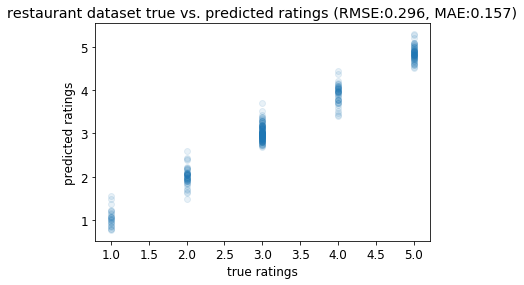

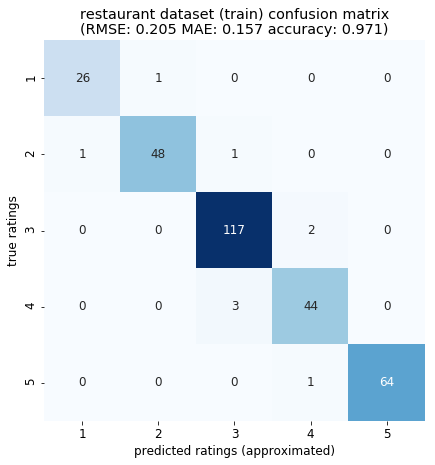

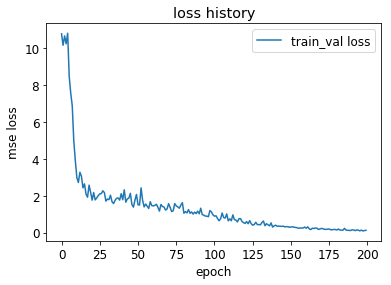

In [24]:
# result visualization
# redo the prediction using the best model, plot the train stats

model = NeuMF(num_users,num_items,gmf_factors,mlp_layers,dropout); model.load_state_dict(best_model); model.eval()
train_loader = DataLoader(train_val_dataset,batch_size=len(train_val_dataset),shuffle=False) # use the complete dataset

# do the prediction
for user_ids, item_ids, ratings in train_loader:
    optimizer.zero_grad()
    predictions = model(user_ids,item_ids)
    
# metrics calculation
train_preds = predictions.detach().cpu().numpy(); train_targets = ratings.detach().cpu().numpy()
train_rmse = np.sqrt(optim_train_loss); train_mae = mean_absolute_error(train_targets,train_preds); train_accuracy = compute_accuracy(np.round(train_targets),train_preds)
print("train RMSE:%.3f  train MAE:%.3f  train_accuracy:%.3f"%(train_rmse,train_mae,train_accuracy))

# scatter plot
plt.figure()
plt.scatter(train_targets,train_preds,alpha=0.1)
plt.xlabel("true ratings"); plt.ylabel("predicted ratings")
plt.title("restaurant dataset true vs. predicted ratings (RMSE:%.3f, MAE:%.3f)"%(train_rmse,train_mae))
plt.show()

# confusion matrix
plot_confusion_matrix(np.round(train_targets),train_preds,title="restaurant dataset (train) ")

# loss hitory
plt.plot(train_val_loss_history,label="train_val loss")
plt.xlabel("epoch");plt.ylabel("mse loss");plt.title("loss history")
plt.legend();plt.show()

C:\Users\eliza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



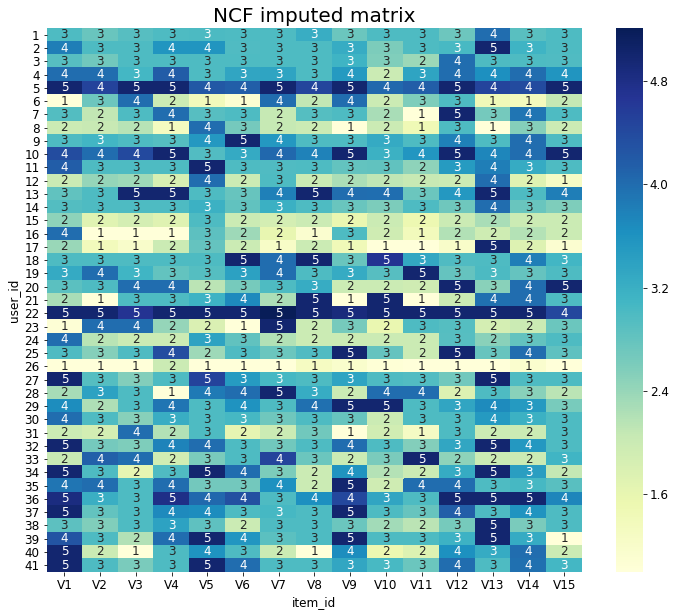

In [8]:
# predict the missing part of the matrix

# do the prediction
model.eval()
for user_ids, item_ids, ratings in test_loader:
    optimizer.zero_grad()
    predictions = model(user_ids,item_ids)
    
# fill into the origin dataframe
test_data["rating"] = list(predictions.detach().numpy())

# reform the matrix
all_data = pd.concat((test_data,train_val_data),axis=0)
all_data["user_id"] = [i+1 for i in all_data["user_id"]]
all_data["item_id"] = ["V%d"%(i+1) for i in all_data["item_id"]]
all_data

# transform back to matrix
matrix = all_data.pivot_table(values='rating',index='user_id',columns='item_id')
matrix = matrix.reindex(columns=["V%d"%i for i in range(1,15+1)])
matrix

# visualize the matrix
plt.rcParams["font.size"]=12
plt.figure(figsize=(12,10))
sns.heatmap(matrix, annot=True, fmt=".0f",cmap='YlGnBu')
plt.title("NCF imputed matrix",fontsize=20)
plt.show()

In [7]:
matrix.to_csv("")

item_id        V1        V2        V3        V4        V5        V6        V7  \
user_id                                                                         
1        3.000000  2.765158  3.218322  3.000000  2.979530  3.000000  3.000000   
2        3.670577  3.000000  3.000000  3.232478  3.538797  3.005022  3.000000   
3        2.917350  2.809492  3.000000  3.000000  3.000000  3.000000  3.000000   
4        4.000000  4.000000  3.166240  3.830073  3.000000  3.130619  3.037302   
5        5.000000  4.446277  5.000000  5.000000  4.187036  4.327650  5.000000   
6        1.000000  3.152120  4.000000  2.000000  1.526044  1.571511  4.000000   
7        3.096108  2.393473  3.000000  4.000000  3.742924  3.000000  2.126240   
8        2.000000  2.006790  2.186645  2.007400  4.000000  2.623186  1.876805   
9        3.000000  2.631655  3.000000  3.100683  3.326590  5.000000  2.920158   
10       4.244116  4.000000  4.447252  5.000000  3.652147  3.885347  3.772444   
11       3.950276  3.000000  3.000000  3.000000  5.000000  3.000000  3.031570   
12       2.000000  2.132452  2.293610  1.619193  4.000000  2.000000  3.000000   
13       2.750329  3.000000  5.000000  5.000000  3.000000  3.569115  3.868894   
14       2.937315  3.000000  3.000000  3.000000  3.008216  2.796145  3.291499   
15       2.364042  1.395137  1.774454  1.604251  3.000000  2.000000  1.727486   
16       4.000000  1.000000  1.000000  1.000000  2.229615  1.985007  1.501538   
17       2.279605  1.694854  1.960714  2.000000  2.920712  2.000000  2.238532   
18       3.000000  3.000000  3.000000  3.000000  3.000000  5.000000  4.000000   
19       2.946363  4.000000  3.496854  2.747752  2.829050  3.186509  4.000000   
20       3.522538  3.229702  4.000000  4.000000  3.598732  3.673649  3.000000   
21       3.074353  1.000000  3.000000  3.000000  3.004729  4.056886  2.086166   
22       5.000000  5.000000  4.882603  5.000000  5.000000  5.000000  4.823236   
23       1.262681  4.000000  4.000000  2.196093  2.202601  1.000000  5.000000   
24       4.000000  1.865841  2.000000  2.000000  2.886733  2.609420  1.959206   
25       3.000000  3.227443  3.000000  4.348960  3.441844  3.000000  3.011431   
26       1.000000  1.000000  1.000000  2.000000  1.000000  1.000000  1.000000   
27       5.000000  2.649666  2.596664  3.000000  4.031579  3.127177  3.043824   
28       2.535192  2.755539  3.000000  1.000000  3.028357  4.000000  5.000000   
29       3.684311  2.571903  3.000000  3.225398  3.000000  3.354043  3.000000   
30       4.000000  2.668109  2.711211  2.793441  3.000000  3.081596  2.651538   
31       2.000000  2.346184  4.000000  2.629296  3.000000  2.480905  2.000000   
32       5.000000  2.842340  2.652125  3.539129  4.000000  3.000000  2.955965   
33       1.737757  3.385736  4.000000  1.935377  1.987429  3.000000  4.024551   
34       5.000000  3.000000  2.181333  3.264720  5.000000  4.000000  2.749108   
35       3.315852  4.000000  3.000000  4.000000  2.796097  2.499959  3.347471   
36       5.207260  3.459437  3.000000  4.552989  4.701486  4.126301  3.098387   
37       5.000000  3.178292  3.000000  3.842947  3.456264  3.000000  2.919479   
38       2.672768  2.299923  3.000000  2.686531  2.813816  2.000000  3.000000   
39       4.037222  3.000000  2.785018  4.000000  5.000000  3.202191  3.434609   
40       5.000000  2.000000  1.000000  3.000000  3.996399  3.000000  2.000000   
41       5.000000  3.000000  2.575199  3.000000  5.000000  4.000000  3.000000   

item_id        V8        V9       V10       V11       V12       V13       V14  \
user_id                                                                         
1        3.150884  3.080712  3.000000  3.000000  3.072050  4.000000  2.976558   
2        3.000000  3.588725  2.684431  3.000000  3.246768  5.000000  3.210148   
3        3.000000  3.023918  2.384062  2.513493  4.000000  3.000000  3.000000   
4        3.000000  3.819594  2.000000  3.031121  4.000000  3.494665  4.000000   
5        4.567620  5.000000  3